In [6]:
import json, os,sys
import numpy as np
sys.path.append('C:\\Users\\dell\\Desktop\\phasemapy')
from copy import deepcopy
from pymatgen.core import Element, Composition
import pybaselines.whittaker as  whittaker
from scipy.spatial import distance_matrix

In [3]:
from pymatgen.core import Element
from monty.json import MontyDecoder, MontyEncoder
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import numpy as np
from phasemapy.dataio import InstanceData
from phasemapy.parser import ICDDEntry
from phasemapy.solver import Phase, Sample
import matplotlib.pyplot as plt
chemsys = ['Cu', 'Fe', 'V']
oxide_system = True
photon_e = 13e3
max_q_shift = 0.05
resample_density = 1000
initial_alphagamma = 0.1
SUM_NORM = 6000
loss_weight = {'xrd_loss': 6.0, 'comp_loss': 2.0, 'entropy_loss': 0.1}
# instance_data = InstanceData.from_file('./data/Fe-Cu-V-O-raw_background.txt', chemsys, photon_e)

instance_data = InstanceData.from_file('./data/Fe-Cu-V-O-raw_background.txt', chemsys, photon_e)
#./data/Fe-Cu-V-609-Q666-inst_with28.txt
instance_data = instance_data.resample_xrd(resample_density)


In [3]:
with open('data_vocalno_instance.json') as f:
    vocalno_instance_data = json.load(f, cls=MontyDecoder)

In [4]:
with open('./data/icdd_entries.json') as f:
    entries = json.load(f, cls=MontyDecoder)

1.Remove the background of XRD

In [5]:
# Remove the background of XRD by mins of XRD

# background = np.min(instance_data.sample_xrd,axis=0)
# for i in range(instance_data.sample_num):
#     instance_data.sample_xrd[i] = instance_data.sample_xrd[i]-background
#     instance_data.sample_xrd[i]=instance_data.sample_xrd[i]/np.max(instance_data.sample_xrd[i])


In [6]:
# Remove the background of XRD by arpls approach
from scipy.linalg import cholesky
from scipy import sparse
from scipy.sparse.linalg import spsolve
def arpls(y, lam=1e4, ratio=0.05, itermax=1000):
    r"""
    Baseline correction using asymmetrically
    reweighted penalized least squares smoothing
    Sung-June Baek, Aaron Park, Young-Jin Ahna and Jaebum Choo,
    Analyst, 2015, 140, 250 (2015)
    """
    N = len(y)
    D = sparse.eye(N, format='csc')
    D = D[1:] - D[:-1]  # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
    D = D[1:] - D[:-1]
    H = lam * D.T * D
    w = np.ones(N)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(N, N))
        WH = sparse.csc_matrix(W + H)
        C = sparse.csc_matrix(cholesky(WH.todense()))
        z = spsolve(C, spsolve(C.T, w * y))
        d = y - z
        dn = d[d < 0]
        m = np.mean(dn)
        s = np.std(dn)
        wt = 1. / (1 + np.exp(2 * (d - (2 * s - m)) / s))
        if np.linalg.norm(w - wt) / np.linalg.norm(w) < ratio:
            break
        w = wt
    return z

In [95]:
instance_data.renormalize(norm=SUM_NORM)
for i in range(instance_data.sample_num):
#     baseline_arpls = arpls(instance_data.sample_xrd[i], 1e5, 0.05)
#     instance_data.sample_xrd[i] = instance_data.sample_xrd[i] - baseline_arpls
    baseline =  whittaker.arpls(instance_data.sample_xrd[i],lam=1e4,diff_order=3,max_iter=50,tol=0.01)[0]
    instance_data.sample_xrd[i]=instance_data.sample_xrd[i]-baseline
    instance_data.sample_xrd[i]=instance_data.sample_xrd[i]+np.absolute(np.min(instance_data.sample_xrd[0]))
    instance_data.sample_xrd[i]=instance_data.sample_xrd[i]/np.max(instance_data.sample_xrd[i])

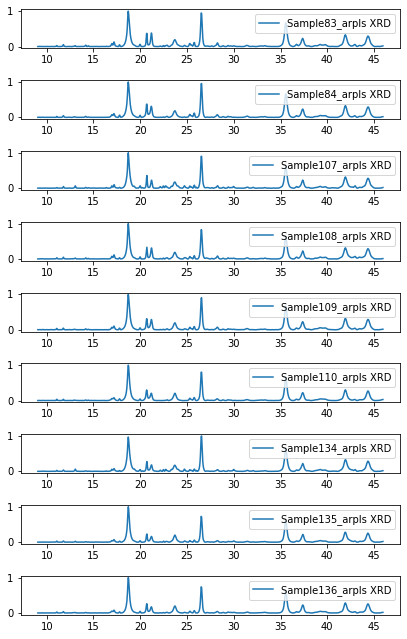

In [97]:
nn = [83, 84, 107, 108, 109, 110, 134, 135, 136]
fig,axes = plt.subplots(ncols=1,nrows=len(nn),figsize=(6,len(nn)))
plt.tight_layout()
for k,ax in zip(nn, axes):
    ax.plot(instance_data.q,instance_data.sample_xrd[k],label=f'Sample{k}_arpls XRD')
    ax.legend()

2. Find the major phases

Sample: # 83
         Name     Entry_id  fraction  shift  width
0        SnO2  01-000-0000  0.225548      0   0.03
1  V3FeCu4O13  00-000-0000  0.774452      0   0.03
Current R^2 = 34.907301115801


<module 'matplotlib.pyplot' from 'C:\\Users\\dell\\anaconda3\\envs\\myPymatgen\\lib\\site-packages\\matplotlib\\pyplot.py'>

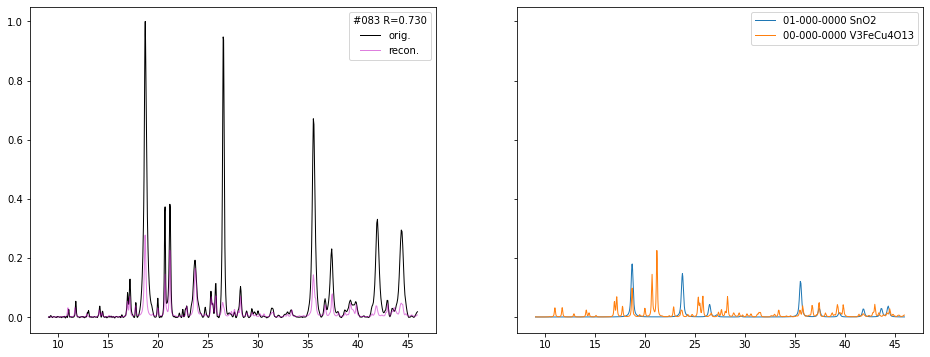

In [108]:
i=83
solution = []
for e in [entries[75],entries[76]]:
    phase = Phase.from_entry_and_instance_data(e, 1 / len(entries), instance_data)
    solution.append(phase)  
    
sample = Sample(i, instance_data.log_q, instance_data.sample_xrd[i], instance_data.chemsys,
                instance_data.sample_comp[i], oxide_system, instance_data.wavelength, max_q_shift, solution)
# sample.prune_candidates_based_on_composition(cutoff=0.05)
# sample.prune_candidate_based_on_xrd(plot=True, cutoff=0.1)
new_sample = deepcopy(sample)

# new_sample = new_sample.optimize(num_epoch=500, print_prog=False, loss_weight=loss_weight)
# new_sample.update_solution_new(0.02, 0.2999, new_sample.max_q_shift)
new_sample.print_solution()


new_sample.refine_all_fractions()
new_sample.refine_one_by_one()
new_sample.plot(perphase=True)


In [105]:
loss_weight = {'xrd_loss': 20.0, 'comp_loss': 2.0, 'entropy_loss': 0.2}

In [114]:
samples = []
for i in range(instance_data.sample_num):
    entries[75].composition = Composition(f'Cu{instance_data.sample_comp[i][0]}Fe{instance_data.sample_comp[i][1]}V{instance_data.sample_comp[i][2]}')
    solution = []
    for e in entries:
        phase = Phase.from_entry_and_instance_data(e, 1 / len(entries), instance_data)
        solution.append(phase)  
        
    sample = Sample(i, instance_data.log_q, instance_data.sample_xrd[i], instance_data.chemsys,
                    instance_data.sample_comp[i], oxide_system, instance_data.wavelength, max_q_shift, solution)
    sample.prune_candidates_based_on_composition(cutoff=0.05)
    sample.prune_candidate_based_on_xrd(plot=False, cutoff=0.01)
    new_sample = deepcopy(sample)
#     new_sample.update_solution_new(0.01, 0.2999, new_sample.max_q_shift)
#     new_sample = new_sample.optimize(num_epoch=500, print_prog=True, loss_weight=loss_weight)
    new_sample.update_solution_new(0.01, 0.2999, new_sample.max_q_shift)
    new_sample.print_solution()   
    
    new_sample.refine_all_fractions()    
    new_sample.refine_one_by_one()
    new_sample.update_solution_new(0.1, 0.2999, new_sample.max_q_shift)
    samples.append(new_sample)
    new_sample.print_solution() 
#     new_sample.plot(perphase=True)

Sample: # 0
            Name     Entry_id  fraction     shift  width
0           SnO2  01-000-0000  0.090160 -0.001626   0.03
1          Cu4O3  04-007-2184  0.069280 -0.047163   0.03
2         V2CuO6  04-008-9659  0.094246  0.000000   0.03
3        V2Cu2O7  04-014-0715  0.053523 -0.047163   0.03
4          Fe3O4  04-015-9120  0.049519 -0.039031   0.03
5           Cu2O  04-007-9767  0.033132  0.048789   0.03
6        Fe2CuO4  01-074-8585  0.042725 -0.042284   0.03
7            VO2  04-007-1466  0.066501  0.047163   0.03
8        Fe5CuO8  01-073-2314  0.042381 -0.035779   0.03
9         VCu3O4  04-016-3668  0.033580 -0.022768   0.03
10        FeCuO2  04-015-2087  0.033797 -0.047163   0.03
11       V3Fe3O8  04-005-6267  0.043694 -0.032526   0.03
12         Fe4O5  01-076-4113  0.043198 -0.019516   0.03
13         Fe2O3  04-015-0027  0.037177 -0.043910   0.03
14          V2O3  04-018-2700  0.048151 -0.043910   0.03
15          V3O4  00-034-0615  0.041044 -0.030900   0.03
16           CuO  0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 0
     Name     Entry_id  fraction     shift     width
0    SnO2  01-000-0000  0.249345 -0.001952  0.084897
1  V2CuO6  04-008-9659  0.750655 -0.000094  0.064966
Current R^2 = 0.5021851962365567
Sample: # 1
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.085066 -0.001626   0.03
1        Cu4O3  04-007-2184  0.057329 -0.047163   0.03
2      V2Cu2O7  04-014-0715  0.066987 -0.047163   0.03
3       V2CuO6  04-008-9659  0.060103 -0.001626   0.03
4      Fe5CuO8  01-073-2314  0.048825 -0.037405   0.03
5        Fe3O4  04-015-9120  0.050561 -0.039031   0.03
6      Fe2CuO4  01-074-8585  0.043566 -0.043910   0.03
7       VCu3O4  04-016-3668  0.039816 -0.022768   0.03
8        Fe4O5  01-076-4113  0.051338 -0.019516   0.03
9      V3Fe3O8  04-005-6267  0.045158 -0.034153   0.03
10         VO2  04-007-1466  0.052654  0.004879   0.03
11       Fe2O3  04-015-0027  0.038423 -0.045537   0.03
12         CuO  01-078-0428  0.024157  0.045537   0.03
13          VO

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 1
     Name     Entry_id  fraction     shift     width
0    SnO2  01-000-0000  0.223967 -0.002124  0.085511
1  V2CuO6  04-008-9659  0.776033 -0.000727  0.058803
Current R^2 = 0.5623477951255821
Sample: # 2
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.102924 -0.001626   0.03
1        Cu4O3  04-007-2184  0.071485 -0.045537   0.03
2      V2Cu2O7  04-014-0715  0.078963 -0.047163   0.03
3       VCu3O4  04-016-3668  0.050094 -0.022768   0.03
4      Fe2CuO4  01-074-8585  0.046901 -0.043910   0.03
5      Fe5CuO8  01-073-2314  0.048952 -0.037405   0.03
6       V2CuO6  04-008-9659  0.059176 -0.001626   0.03
7        Fe3O4  04-015-9120  0.051023 -0.040658   0.03
8        Fe4O5  01-076-4113  0.052314 -0.019516   0.03
9      V3Fe3O8  04-005-6267  0.047966 -0.034153   0.03
10       Fe2O3  04-015-0027  0.040812 -0.045537   0.03
11         VO2  04-007-1466  0.051911 -0.004879   0.03
12        V3O4  00-034-0615  0.045057 -0.032526   0.03
13       VCuO3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 2
     Name     Entry_id  fraction     shift     width
0    SnO2  01-000-0000  0.301702 -0.002051  0.087574
1  V2CuO6  04-008-9659  0.698298 -0.000384  0.062014
Current R^2 = 0.6217307280829595
Sample: # 3
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.102301 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.112044 -0.047163   0.03
2        Cu4O3  04-007-2184  0.044110 -0.043910   0.03
3       VCu3O4  04-016-3668  0.051309 -0.022768   0.03
4      Fe5CuO8  01-073-2314  0.053439 -0.037405   0.03
5        Fe3O4  04-015-9120  0.053761 -0.039031   0.03
6        Fe4O5  01-076-4113  0.060455 -0.019516   0.03
7      V3Fe3O8  04-005-6267  0.053177 -0.034153   0.03
8        Fe2O3  04-015-0027  0.045246 -0.045537   0.03
9      Fe2CuO4  01-074-8585  0.037455 -0.042284   0.03
10         VO2  04-007-1466  0.053519 -0.047163   0.03
11        V3O4  00-034-0615  0.049952 -0.032526   0.03
12  Fe13Cu5O24  01-073-2315  0.025894 -0.040658   0.03
13        V2O3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 3
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.242336 -0.001546  0.099132
1   V2CuO6  04-008-9659  0.255872 -0.035227  0.109251
2     V3O5  04-019-7352  0.281704  0.027896  0.081926
3  V2Cu2O7  04-014-0715  0.220088 -0.035261  0.171984
Current R^2 = 0.6468058016218786
Sample: # 4
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.082711 -0.001626   0.03
1    V2Cu2O7  04-014-0715  0.096566 -0.045537   0.03
2      Cu4O3  04-007-2184  0.054062 -0.043910   0.03
3        VO2  04-007-1466  0.094275 -0.004879   0.03
4     VCu3O4  04-016-3668  0.048987 -0.022768   0.03
5      Fe2O3  04-019-9517  0.047819 -0.024395   0.03
6      VCuO3  04-007-8067  0.044334  0.022768   0.03
7       Cu2O  04-007-9767  0.024350  0.042284   0.03
8        VO2  04-007-0515  0.046015  0.001626   0.03
9     FeCuO2  04-015-2087  0.025253  0.030900   0.03
10       CuO  01-078-0428  0.021066  0.004879   0.03
11        VO  04-008-0642  0.039277 -

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 4
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.324076 -0.001591  0.088926
1  V2Cu2O7  04-014-0715  0.306585 -0.024655  0.068189
2      VO2  04-007-0515  0.369340  0.002693  0.060328
Current R^2 = 0.6769553303145864
Sample: # 5
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.131463 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.091862 -0.045537   0.03
2       VCu3O4  04-016-3668  0.067264 -0.022768   0.03
3        Cu4O3  04-007-2184  0.044265 -0.043910   0.03
4          VO2  04-007-1466  0.082610 -0.048789   0.03
5      Fe5CuO8  01-073-2314  0.052053 -0.037405   0.03
6        Fe3O4  04-015-9120  0.054359 -0.039031   0.03
7      Fe2CuO4  01-074-8585  0.043974 -0.043910   0.03
8         Cu2O  04-007-9767  0.031800  0.042284   0.03
9      V3Fe3O8  04-005-6267  0.048144 -0.034153   0.03
10       Fe2O3  04-015-0027  0.040963 -0.045537   0.03
11        V3O4  00-034-0615  0.045224 -0.032526   0.03
12       Fe4

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 5
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000   0.54657 -0.001123  0.087275
1  V2Cu2O7  04-014-0715   0.45343 -0.036953  0.103614
Current R^2 = 0.6890151611270902
Sample: # 6
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.133021 -0.001626   0.03
1        Cu4O3  04-007-2184  0.127912 -0.043910   0.03
2      V2Cu2O7  04-014-0715  0.180266 -0.045537   0.03
3       VCu3O4  04-016-3668  0.068363 -0.024395   0.03
4          VO2  04-007-1466  0.098403 -0.048789   0.03
5      Fe5CuO8  01-073-2314  0.040763 -0.037405   0.03
6      Fe2CuO4  01-074-8585  0.036864 -0.043910   0.03
7        Fe3O4  04-015-9120  0.041648 -0.039031   0.03
8         Cu2O  04-007-9767  0.025578  0.040658   0.03
9      V3Fe3O8  04-005-6267  0.037701 -0.034153   0.03
10  VFe(CuO2)2  04-015-2084  0.026945 -0.043910   0.03
11       Fe2O3  04-015-0027  0.032078 -0.045537   0.03
12          VO  04-008-0642  0.038238  0.017889   0.03
13        V

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 6
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.496651 -0.001667  0.095309
1  V2Cu2O7  04-014-0715  0.503349 -0.032525  0.173283
Current R^2 = 0.6870248493777108
Sample: # 7
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.130362 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.133724 -0.027647   0.03
2        Cu4O3  04-007-2184  0.048831 -0.043910   0.03
3       FeCuO2  04-015-2087  0.055617 -0.047163   0.03
4         Cu2O  04-007-9767  0.038063  0.035779   0.03
5   VFe(CuO2)2  04-015-2084  0.049623 -0.048789   0.03
6         V2O3  04-018-2700  0.069903 -0.022768   0.03
7        Fe2O3  01-083-8470  0.049063 -0.021142   0.03
8       VCu3O4  04-016-3668  0.038218 -0.029274   0.03
9        Fe4O5  01-076-4113  0.045109  0.011384   0.03
10        V3O4  00-034-0615  0.053779 -0.001626   0.03
11     V3Fe3O8  04-005-6267  0.045242 -0.003253   0.03
12       Fe3O4  04-015-9120  0.039691 -0.008132   0.03
13     Fe5C

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 7
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.448889 -0.002671  0.106842
1  V2Cu2O7  04-014-0715  0.551111 -0.030038  0.111134
Current R^2 = 0.692280193703896
Sample: # 8
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.118478 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.143246 -0.045537   0.03
2         Cu2O  04-007-9767  0.053194  0.034153   0.03
3       FeCuO2  04-015-2087  0.062258 -0.047163   0.03
4       VCu3O4  04-016-3668  0.053661 -0.008132   0.03
5   VFe(CuO2)2  04-015-2084  0.048137 -0.048789   0.03
6         V3O4  00-034-0615  0.063406 -0.001626   0.03
7        Cu4O3  04-007-2184  0.031064 -0.043910   0.03
8        Fe4O5  01-076-4113  0.045016  0.011384   0.03
9        Fe2O3  04-015-0027  0.041838 -0.014637   0.03
10     V3Fe3O8  04-005-6267  0.044588 -0.003253   0.03
11       Fe3O4  04-015-9120  0.038957 -0.008132   0.03
12     Fe2CuO4  01-074-8585  0.033929 -0.013010   0.03
13     Fe5Cu

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 8
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000    0.5379 -0.002231  0.103406
1  V2Cu2O7  04-014-0715    0.4621 -0.007339  0.109071
Current R^2 = 0.6924364978665896
Sample: # 9
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.093204 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.131449 -0.029274   0.03
2         Cu2O  04-007-9767  0.051060  0.034153   0.03
3        Cu4O3  04-007-2184  0.048619 -0.045537   0.03
4   VFe(CuO2)2  04-015-2084  0.045590 -0.047163   0.03
5        Fe3O4  04-015-9120  0.048558 -0.039031   0.03
6      Fe2CuO4  01-074-8585  0.039104 -0.030900   0.03
7       FeCuO2  04-015-2087  0.036553 -0.047163   0.03
8      Fe5CuO8  01-073-2314  0.040287 -0.037405   0.03
9      V3Fe3O8  04-005-6267  0.048501 -0.021142   0.03
10       Fe2O3  04-015-0027  0.045218 -0.032526   0.03
11        V3O4  00-034-0615  0.056982 -0.001626   0.03
12       Fe4O5  01-076-4113  0.044342  0.009758   0.03
13      V2F

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 10
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.498904 -0.002048  0.100952
1  V2Cu2O7  04-014-0715  0.501096 -0.006773  0.130286
Current R^2 = 0.6886426109308851
Sample: # 11
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.134650 -0.001626   0.03
1   V2Cu2O7  04-014-0715  0.106874 -0.048789   0.03
2    VCu3O4  04-016-3668  0.076907 -0.022768   0.03
3     Cu4O3  04-007-2184  0.059015 -0.045537   0.03
4       VO2  04-007-1466  0.111209  0.048789   0.03
5    V2CuO6  04-008-9659  0.070150  0.000000   0.03
6      Cu2O  04-007-9767  0.036255  0.042284   0.03
7       VO2  04-007-0515  0.059652  0.034153   0.03
8      V2O3  04-018-2700  0.048109  0.027647   0.03
9   Fe5CuO8  01-073-2314  0.029877 -0.032526   0.03
10    Fe3O4  04-015-9120  0.028352 -0.034153   0.03
11    Fe4O5  01-076-4113  0.031415 -0.014637   0.03
12      CuO  01-078-0428  0.019109  0.047163   0.03
13       VO  04-008-0642  0.035627  0.004879   0.03

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 11
     Name     Entry_id  fraction     shift     width
0    SnO2  01-000-0000  0.347615 -0.002201  0.092826
1  V2CuO6  04-008-9659  0.652385 -0.001603  0.079998
Current R^2 = 0.661598252072915
Sample: # 12
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.157739 -0.001626   0.03
1       VCu3O4  04-016-3668  0.062406 -0.024395   0.03
2         Cu2O  04-007-9767  0.049434  0.043910   0.03
3      V2Cu2O7  04-014-0715  0.072293 -0.048789   0.03
4      Fe5CuO8  01-073-2314  0.049254 -0.037405   0.03
5        Cu4O3  04-007-2184  0.035103 -0.045537   0.03
6      Fe2CuO4  01-074-8585  0.044544 -0.043910   0.03
7        Fe4O5  01-076-4113  0.051789 -0.019516   0.03
8        Fe3O4  04-015-9120  0.045424 -0.039031   0.03
9          VO2  04-007-1466  0.064758  0.047163   0.03
10        V2O3  04-018-2700  0.056807  0.029274   0.03
11     V3Fe3O8  04-005-6267  0.045555 -0.034153   0.03
12       Fe2O3  04-015-0027  0.038760 -0.045537   0.03
13        V3O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 12
     Name     Entry_id  fraction     shift     width
0    SnO2  01-000-0000  0.406403 -0.002077  0.087451
1  V2CuO6  04-008-9659  0.593597 -0.000098  0.071985
Current R^2 = 0.6047717880516728
Sample: # 13
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.181029 -0.001626   0.03
1   V2Cu2O7  04-014-0715  0.134676 -0.048789   0.03
2     Cu4O3  04-007-2184  0.084408 -0.045537   0.03
3    VCu3O4  04-016-3668  0.084901 -0.022768   0.03
4       VO2  04-007-1466  0.089661  0.048789   0.03
5      Cu2O  04-007-9767  0.040350  0.042284   0.03
6     Fe3O4  04-015-9120  0.039973 -0.029274   0.03
7   Fe2CuO4  01-074-8585  0.035355 -0.032526   0.03
8   Fe5CuO8  01-073-2314  0.036908 -0.027647   0.03
9   V3Fe3O8  04-005-6267  0.034136 -0.024395   0.03
10   V2CuO6  04-008-9659  0.033776  0.000000   0.03
11    Fe4O5  01-076-4113  0.033354 -0.019516   0.03
12     V3O4  00-034-0615  0.038425 -0.021142   0.03
13   V2FeO4  01-074-6506  0.032934 -0.040658   0.03
14

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 13
     Name     Entry_id  fraction     shift     width
0    SnO2  01-000-0000   0.38539 -0.001859  0.094057
1  V2CuO6  04-008-9659   0.61461 -0.000873  0.065006
Current R^2 = 0.6221663937359605
Sample: # 14
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.204651 -0.001626   0.03
1    V2Cu2O7  04-014-0715  0.138708 -0.048789   0.03
2      Cu4O3  04-007-2184  0.070783 -0.043910   0.03
3     VCu3O4  04-016-3668  0.069909 -0.022768   0.03
4   V5Fe3O16  01-072-0567  0.110678 -0.027647   0.03
5       Cu2O  04-007-9767  0.044830  0.042284   0.03
6       V2O3  04-018-2700  0.062867  0.027647   0.03
7      Fe4O5  01-076-4113  0.040928 -0.019516   0.03
8    V3Fe3O8  04-005-6267  0.036680 -0.034153   0.03
9       V3O4  00-034-0615  0.041805 -0.019516   0.03
10    V2FeO4  01-074-6506  0.035831 -0.039031   0.03
11     Fe3O4  04-015-9120  0.030853 -0.026021   0.03
12   Fe5CuO8  01-073-2314  0.028514 -0.024395   0.03
13     Fe2O3  04-015-0027  0.032788 -0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 15
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.415797 -0.001485  0.097269
1   VO2  04-007-0515  0.584203  0.021922  0.080780
Current R^2 = 0.6990001273638663
Sample: # 16
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.077906 -0.001626   0.03
1        Cu4O3  04-007-2184  0.053423 -0.043910   0.03
2         Cu2O  04-007-9767  0.046543  0.045537   0.03
3        Fe3O4  04-015-9120  0.067848 -0.035779   0.03
4      Fe5CuO8  01-073-2314  0.062702 -0.034153   0.03
5      Fe2CuO4  01-074-8585  0.057416 -0.040658   0.03
6        Fe4O5  01-076-4113  0.066755 -0.016263   0.03
7      V2Cu2O7  04-014-0715  0.053982 -0.047163   0.03
8      V3Fe3O8  04-005-6267  0.058719 -0.030900   0.03
9        Fe2O3  04-015-0027  0.049961 -0.042284   0.03
10      VCu3O4  04-016-3668  0.036996 -0.022768   0.03
11        V3O4  00-034-0615  0.055158 -0.029274   0.03
12         VO2  04-007-1466  0.054949  0.039031   0.03
13      V2FeO4  01

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 17
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001482  0.085676
Current R^2 = 0.7131851697036051
Sample: # 18
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.073408 -0.001626   0.03
1         Cu2O  04-007-9767  0.052857  0.045537   0.03
2      V2Cu2O7  04-014-0715  0.070635 -0.047163   0.03
3     V5Fe3O16  01-072-0567  0.088560 -0.029274   0.03
4        Cu4O3  04-007-2184  0.042884 -0.048789   0.03
5      Fe2CuO4  01-074-8585  0.049803 -0.042284   0.03
6        Fe3O4  04-015-9120  0.054420 -0.034153   0.03
7        Fe4O5  01-076-4113  0.060440 -0.017889   0.03
8      Fe5CuO8  01-073-2314  0.047665 -0.035779   0.03
9         V2O3  04-018-2700  0.070274  0.030900   0.03
10     V3Fe3O8  04-005-6267  0.053164 -0.032526   0.03
11      VCu3O4  04-016-3668  0.037313 -0.022768   0.03
12       Fe2O3  04-015-0027  0.045235 -0.043910   0.03
13      V2FeO4  01-074-6506  0.045176 -0.045537   0.03
14        V3O4

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 18
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001719  0.082635
Current R^2 = 0.7753939497796555
Sample: # 19
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.117161 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.120964 -0.045537   0.03
2        Cu4O3  04-007-2184  0.066779 -0.043910   0.03
3       VCu3O4  04-016-3668  0.077835 -0.021142   0.03
4        Fe2O3  04-019-9517  0.067996 -0.024395   0.03
5        VCuO3  04-007-8067  0.039906  0.021142   0.03
6         Cu2O  04-007-9767  0.028188  0.040658   0.03
7     FeCu9O11  04-018-6919  0.028850  0.048789   0.03
8          CuO  04-007-1375  0.024835  0.047163   0.03
9        Fe3O4  04-015-9120  0.032129 -0.026021   0.03
10     Fe5CuO8  01-073-2314  0.029676 -0.024395   0.03
11        V3O4  00-034-0615  0.037611 -0.019516   0.03
12     Fe2CuO4  01-074-8585  0.023318 -0.029274   0.03
13     V3Fe3O8  04-005-6267  0.029947 -0.021142   0.03
14       VFeO3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 19
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.525764 -0.001854  0.093800
1  V2Cu2O7  04-014-0715  0.474236 -0.022812  0.087554
Current R^2 = 0.68512058794859
Sample: # 20
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.117381 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.127436 -0.026021   0.03
2          VO2  04-007-1466  0.146283 -0.048789   0.03
3        Cu4O3  04-007-2184  0.059443 -0.043910   0.03
4         Cu2O  04-007-9767  0.035396  0.034153   0.03
5       FeCuO2  04-015-2087  0.039304 -0.048789   0.03
6       VCu3O4  04-016-3668  0.032284 -0.027647   0.03
7         V3O4  00-034-0615  0.051250  0.000000   0.03
8        Fe4O5  01-076-4113  0.040620  0.011384   0.03
9       V2FeO4  01-074-6506  0.041506 -0.021142   0.03
10     V3Fe3O8  04-005-6267  0.040739 -0.003253   0.03
11       Fe3O4  04-015-9120  0.035740 -0.008132   0.03
12     Fe2CuO4  01-074-8585  0.031611 -0.011384   0.03
13     Fe5C

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 20
      Name     Entry_id  fraction     shift    width
0     SnO2  01-000-0000  0.423562 -0.001864  0.10595
1  V2Cu2O7  04-014-0715  0.576438 -0.026600  0.16174
Current R^2 = 0.6681844924855239
Sample: # 21
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.107597 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.150504 -0.027647   0.03
2        Cu4O3  04-007-2184  0.077175 -0.043910   0.03
3       VCu3O4  04-016-3668  0.062687 -0.008132   0.03
4         Cu2O  04-007-9767  0.037575  0.034153   0.03
5      Fe5CuO8  01-073-2314  0.040789 -0.035779   0.03
6      Fe2CuO4  01-074-8585  0.036888 -0.042284   0.03
7       FeCuO2  04-015-2087  0.033904 -0.047163   0.03
8        Fe4O5  01-076-4113  0.045690  0.009758   0.03
9         V3O4  00-034-0615  0.054472 -0.003253   0.03
10     V3Fe3O8  04-005-6267  0.045825 -0.004879   0.03
11       Fe3O4  04-015-9120  0.040202 -0.009758   0.03
12       Fe2O3  04-015-0027  0.042722 -0.016263   0.03
13      V2Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 21
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.413825 -0.002049  0.107873
1  V2Cu2O7  04-014-0715  0.586175 -0.028656  0.154326
Current R^2 = 0.6653925936330417
Sample: # 22
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.094680 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.146787 -0.030900   0.03
2        Cu4O3  04-007-2184  0.046439 -0.043910   0.03
3         Cu2O  04-007-9767  0.039640  0.034153   0.03
4       FeCuO2  04-015-2087  0.042747 -0.047163   0.03
5        Fe4O5  01-076-4113  0.055855  0.009758   0.03
6         V3O4  00-034-0615  0.066590 -0.003253   0.03
7      V3Fe3O8  04-005-6267  0.056019 -0.004879   0.03
8        Fe3O4  04-015-9120  0.049145 -0.009758   0.03
9      Fe2CuO4  01-074-8585  0.043468 -0.013010   0.03
10     Fe5CuO8  01-073-2314  0.045418 -0.008132   0.03
11       Fe2O3  04-015-0027  0.052226 -0.016263   0.03
12      V2FeO4  01-074-6506  0.052540 -0.022768   0.03
13  VFe(C

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 22
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000   0.41483 -0.002532  0.111992
1  V2Cu2O7  04-014-0715   0.58517 -0.010728  0.147247
Current R^2 = 0.6827201854901829
Sample: # 23
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.088123 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.135657 -0.030900   0.03
2        Cu4O3  04-007-2184  0.059114 -0.043910   0.03
3       FeCuO2  04-015-2087  0.059709 -0.045537   0.03
4         Cu2O  04-007-9767  0.047396  0.034153   0.03
5       VCu3O4  04-016-3668  0.042062 -0.021142   0.03
6   VFe(CuO2)2  04-015-2084  0.045705 -0.045537   0.03
7         V3O4  00-034-0615  0.061151 -0.001626   0.03
8       V2FeO4  01-074-6506  0.052412 -0.021142   0.03
9        Fe3O4  04-015-9120  0.045132 -0.008132   0.03
10       Fe2O3  04-015-0027  0.047843 -0.014637   0.03
11     V3Fe3O8  04-005-6267  0.049541 -0.003253   0.03
12       Fe4O5  01-076-4113  0.048539  0.009758   0.03
13     Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 23
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.306322 -0.001734  0.099231
1  V2Cu2O7  04-014-0715  0.360612 -0.031513  0.236748
2     V3O5  04-019-7352  0.333066  0.027615  0.071774
Current R^2 = 0.6760146888820739
Sample: # 24
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.066671 -0.003253   0.03
1         Cu2O  04-007-9767  0.085988  0.047163   0.03
2      V2Cu2O7  04-014-0715  0.084132 -0.030900   0.03
3        Fe3O4  04-015-9120  0.083362 -0.043910   0.03
4      Fe5CuO8  01-073-2314  0.066751 -0.040658   0.03
5         V3O4  00-034-0615  0.096942 -0.040658   0.03
6      Fe2CuO4  01-074-8585  0.059306 -0.047163   0.03
7        Fe4O5  01-076-4113  0.072722 -0.024395   0.03
8   Fe13Cu5O24  01-073-2315  0.055471 -0.047163   0.03
9      V3Fe3O8  04-005-6267  0.068171 -0.042284   0.03
10         CuO  01-078-0428  0.029048  0.040658   0.03
11          VO  04-008-0642  0.054158 -0.001626   0.03
12      Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 24
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.440615 -0.002205  0.132273
1  V2Cu2O7  04-014-0715  0.559385 -0.027514  0.128017
Current R^2 = 0.702846271390728
Sample: # 25
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.044682 -0.003253   0.03
1         Cu2O  04-007-9767  0.071328  0.047163   0.03
2        Fe3O4  04-015-9120  0.085943 -0.047163   0.03
3      Fe2CuO4  01-074-8585  0.069536 -0.047163   0.03
4      Fe5CuO8  01-073-2314  0.071951 -0.043910   0.03
5      V3Fe3O8  04-005-6267  0.083325 -0.040658   0.03
6        Fe4O5  01-076-4113  0.078816 -0.027647   0.03
7         V3O4  00-034-0615  0.092790 -0.039031   0.03
8        Fe2O3  04-015-0027  0.060508 -0.048789   0.03
9      V2Cu2O7  04-014-0715  0.049785 -0.032526   0.03
10         CuO  01-078-0428  0.030111  0.040658   0.03
11          VO  04-008-0642  0.055063 -0.001626   0.03
12  Fe13Cu5O24  01-073-2315  0.032370 -0.048789   0.03
13        

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 25
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.235414 -0.000563  0.101346
1  V2Cu2O7  04-014-0715  0.350367 -0.030144  0.140704
2  V8CuO20  01-079-0796  0.414219  0.030863  0.088859
Current R^2 = 0.7301582960025595
Sample: # 26
            Name     Entry_id  fraction     shift  width
0           SnO2  01-000-0000  0.119997 -0.001626   0.03
1        V2Cu2O7  04-014-0715  0.097527 -0.048789   0.03
2         VCu3O4  04-016-3668  0.054309 -0.021142   0.03
3           V2O3  04-018-2700  0.092827  0.029274   0.03
4        Fe2CuO4  01-074-8585  0.047098 -0.045537   0.03
5        V2Cu2O7  01-078-2581  0.050097 -0.003253   0.03
6           Cu2O  04-007-9767  0.033706  0.043910   0.03
7        Fe5CuO8  01-073-2314  0.041494 -0.040658   0.03
8          Fe2O3  04-006-6579  0.044669  0.003253   0.03
9          Cu4O3  04-007-2184  0.028769 -0.043910   0.03
10         Fe4O5  01-076-4113  0.043629 -0.022768   0.03
11       V3Fe3O8  04-005-6267  0.038377 -

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 26
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.351549 -0.001816  0.093824
1  V2Cu2O7  01-078-2581  0.648451 -0.002234  0.054268
Current R^2 = 0.6086624770597933
Sample: # 27
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.091300 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.133985  0.001626   0.03
2         Cu2O  04-007-9767  0.058058  0.045537   0.03
3         V2O3  04-018-2700  0.091240  0.032526   0.03
4        Fe2O3  04-019-9517  0.047526 -0.045537   0.03
5          VO2  04-007-1466  0.059892 -0.034153   0.03
6       VCu3O4  04-016-3668  0.027800 -0.024395   0.03
7     FeCu9O11  04-018-6919  0.024607  0.004879   0.03
8          CuO  01-078-0428  0.019613  0.039031   0.03
9           VO  04-008-0642  0.036566 -0.003253   0.03
10      FeCuO2  04-009-4371  0.022082  0.019516   0.03
11       Fe2O3  04-006-6579  0.026686  0.001626   0.03
12         CuO  04-007-1375  0.017212  0.004879   0.03
13    V5F

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 27
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.237149 -0.001941  0.086578
1  V2Cu2O7  01-078-2581  0.401208 -0.000756  0.068030
2  V2Cu2O7  04-014-0715  0.361643  0.001603  0.069725
Current R^2 = 0.5761701388794669
Sample: # 28
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.073685 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.164546  0.001626   0.03
2        Cu4O3  04-007-2184  0.059045 -0.043910   0.03
3         Cu2O  04-007-9767  0.042423  0.039031   0.03
4        Fe2O3  01-083-8470  0.048085  0.032526   0.03
5         V2O3  04-018-2700  0.064058  0.032526   0.03
6      Fe5CuO8  01-073-2314  0.036081 -0.035779   0.03
7        Fe3O4  04-015-9120  0.037264 -0.037405   0.03
8       VCu3O4  04-016-3668  0.028147 -0.022768   0.03
9        Fe4O5  01-076-4113  0.037938 -0.017889   0.03
10     Fe2CuO4  01-074-8585  0.028528 -0.039031   0.03
11     V3Fe3O8  04-005-6267  0.033371 -0.032526   0.03
12     V2C

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 28
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.276135 -0.001995  0.091147
1  V2Cu2O7  04-014-0715  0.415926  0.001022  0.071434
2  V2Cu2O7  01-078-2581  0.307939 -0.000814  0.070720
Current R^2 = 0.630468871959686
Sample: # 29
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.096615 -0.001626   0.03
1    V2Cu2O7  04-014-0715  0.140298 -0.042284   0.03
2      Cu4O3  04-007-2184  0.068162 -0.042284   0.03
3       Cu2O  04-007-9767  0.055562  0.043910   0.03
4       V2O3  04-018-2700  0.065403  0.032526   0.03
5    Fe2CuO4  01-074-8585  0.041163 -0.047163   0.03
6     VCu3O4  04-016-3668  0.036251 -0.024395   0.03
7    Fe5CuO8  01-073-2314  0.030371 -0.042284   0.03
8        VO2  04-007-1466  0.045295  0.004879   0.03
9      Fe4O5  01-076-4113  0.035481 -0.017889   0.03
10  FeCu9O11  04-018-6919  0.023186 -0.037405   0.03
11     VCuO3  04-007-8067  0.027469  0.048789   0.03
12       CuO  01-078-0428  0.018770  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 29
      Name     Entry_id  fraction     shift    width
0     SnO2  01-000-0000  0.490684 -0.001397  0.08847
1  V2Cu2O7  04-014-0715  0.509316 -0.028289  0.11091
Current R^2 = 0.6802782095025618
Sample: # 30
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.303096 -0.001626   0.03
1    VCu3O4  04-016-3668  0.119066 -0.022768   0.03
2      Cu2O  04-007-9767  0.097315  0.043910   0.03
3   V2Cu2O7  04-014-0715  0.112870 -0.047163   0.03
4      V2O3  04-018-2700  0.078335  0.027647   0.03
5     Fe2O3  04-019-9516  0.045296 -0.004879   0.03
6       CuO  01-078-0428  0.032874  0.037405   0.03
7        VO  04-008-0642  0.061292 -0.004879   0.03
8     Fe4O5  01-076-4113  0.044002 -0.019516   0.03
9   Fe5CuO8  01-073-2314  0.034217 -0.037405   0.03
10  V3Fe3O8  04-005-6267  0.038705 -0.034153   0.03
11    Fe2O3  04-015-0027  0.032932 -0.045537   0.03
Current R^2 = 39110.49645252441


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 30
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001851  0.088716
Current R^2 = 0.6485311460545927
Sample: # 31
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.216645 -0.001626   0.03
1      Cu2O  04-007-9767  0.067661  0.042284   0.03
2   V2Cu2O7  04-014-0715  0.099423 -0.024395   0.03
3    VCu3O4  04-016-3668  0.077922 -0.022768   0.03
4     Cu4O3  04-007-2184  0.052562 -0.045537   0.03
5      V2O3  04-018-2700  0.087811  0.032526   0.03
6   Fe5CuO8  01-073-2314  0.039072 -0.037405   0.03
7     Fe3O4  04-015-9120  0.040175 -0.039031   0.03
8     Fe4O5  01-076-4113  0.041083 -0.019516   0.03
9     VCuO3  04-007-8067  0.033999  0.032526   0.03
10      CuO  01-078-0428  0.022857  0.035779   0.03
11       VO  04-008-0642  0.042615 -0.006505   0.03
12  V3Fe3O8  04-005-6267  0.036137 -0.034153   0.03
13  Fe2CuO4  01-074-8585  0.027990 -0.042284   0.03
14    Fe2O3  04-015-0027  0.030747 -0.045537   0.03
15    F

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 31
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000   0.39577 -0.002494  0.085116
1  V2Cu2O7  04-014-0715   0.60423 -0.026403  0.105657
Current R^2 = 0.586441212878214
Sample: # 32
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.138846 -0.001626   0.03
1         Cu2O  04-007-9767  0.059005  0.043910   0.03
2       VCu3O4  04-016-3668  0.067551 -0.014637   0.03
3          VO2  04-007-1466  0.097695 -0.048789   0.03
4        Cu4O3  04-007-2184  0.039453 -0.048789   0.03
5      Fe2CuO4  01-074-8585  0.046813 -0.042284   0.03
6         V2O3  04-018-2700  0.073519  0.029274   0.03
7        Fe3O4  04-015-9120  0.051170 -0.039031   0.03
8      Fe5CuO8  01-073-2314  0.042454 -0.037405   0.03
9   VFe(CuO2)2  04-015-2084  0.036320 -0.048789   0.03
10       Fe4O5  01-076-4113  0.044639 -0.019516   0.03
11       Fe2O3  04-015-0027  0.040735 -0.043910   0.03
12     V3Fe3O8  04-005-6267  0.039265 -0.034153   0.03
13      Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 32
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.487353 -0.001086  0.106759
1   VO2  04-007-1466  0.512647 -0.029676  0.279718
Current R^2 = 0.6883589535702513
Sample: # 33
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.118433 -0.001626   0.03
1       VCu3O4  04-016-3668  0.070013 -0.013010   0.03
2      V2Cu2O7  04-014-0715  0.068236 -0.022768   0.03
3         Cu2O  04-007-9767  0.036900  0.042284   0.03
4      Fe5CuO8  01-073-2314  0.046479 -0.037405   0.03
5          VO2  04-007-1466  0.071996 -0.048789   0.03
6        VFeO3  04-002-2984  0.057381 -0.045537   0.03
7        Fe2O3  04-015-0027  0.050507 -0.045537   0.03
8      V3Fe3O8  04-005-6267  0.053826 -0.034153   0.03
9         V3O4  00-034-0615  0.061579 -0.032526   0.03
10       Fe3O4  04-015-9120  0.041971 -0.039031   0.03
11      FeCuO2  04-009-4371  0.033359  0.016263   0.03
12       Cu4O3  04-007-2184  0.023159 -0.045537   0.03
13     Fe2CuO4  01

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 33
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.388254 -0.001707  0.084129
1  V2Cu2O7  04-014-0715  0.611746 -0.025135  0.096528
Current R^2 = 0.6405008958350036
Sample: # 34
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.091414 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.089630  0.019516   0.03
2       VCu3O4  04-016-3668  0.054950 -0.022768   0.03
3        Cu4O3  04-007-2184  0.043646 -0.045537   0.03
4          VO2  04-007-1466  0.083967 -0.003253   0.03
5        VCuO3  04-007-8067  0.041796  0.027647   0.03
6        Fe3O4  04-015-9120  0.043554 -0.039031   0.03
7         Cu2O  04-007-9767  0.027759  0.042284   0.03
8     FeCu9O11  04-018-6919  0.031713 -0.035779   0.03
9       FeCuO2  04-015-2087  0.032481 -0.047163   0.03
10       Fe4O5  01-076-4113  0.044288 -0.017889   0.03
11     Fe5CuO8  01-073-2314  0.033796 -0.037405   0.03
12          VO  04-008-0642  0.046201 -0.037405   0.03
13     Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 34
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.532828 -0.002133  0.105324
1  V2Cu2O7  04-014-0715  0.467172  0.009227  0.086095
Current R^2 = 0.6882774938049903
Sample: # 35
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.127515 -0.001626   0.03
1        Cu4O3  04-007-2184  0.078560 -0.048789   0.03
2      V2Cu2O7  04-014-0715  0.075441 -0.026021   0.03
3       VCu3O4  04-016-3668  0.060291 -0.022768   0.03
4          VO2  04-007-1466  0.086599 -0.048789   0.03
5        Fe3O4  04-015-9120  0.056497 -0.039031   0.03
6      Fe5CuO8  01-073-2314  0.046139 -0.029274   0.03
7         Cu2O  04-007-9767  0.032352  0.042284   0.03
8         V3O4  00-034-0615  0.064098 -0.032526   0.03
9        Fe2O3  04-015-0027  0.047638 -0.045537   0.03
10     Fe2CuO4  01-074-8585  0.039505 -0.042284   0.03
11     V3Fe3O8  04-005-6267  0.050769 -0.034153   0.03
12      FeCuO2  04-015-2087  0.031862 -0.045537   0.03
13  Fe13C

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 35
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.380909 -0.002527  0.100409
1  V2Cu2O7  04-014-0715  0.619091 -0.026054  0.114154
Current R^2 = 0.6765562896596626
Sample: # 36
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.137033 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.130000 -0.026021   0.03
2          VO2  04-007-1466  0.149227 -0.048789   0.03
3        Cu4O3  04-007-2184  0.068739 -0.043910   0.03
4         Cu2O  04-007-9767  0.038369  0.037405   0.03
5       FeCuO2  04-015-2087  0.044293 -0.047163   0.03
6       VCu3O4  04-016-3668  0.034339 -0.027647   0.03
7         V3O4  00-034-0615  0.052281  0.000000   0.03
8       V2FeO4  01-074-6506  0.044810 -0.019516   0.03
9        Fe3O4  04-015-9120  0.035806 -0.008132   0.03
10       Fe2O3  04-015-0027  0.038051 -0.014637   0.03
11       Fe4O5  01-076-4113  0.039996  0.011384   0.03
12     Fe5CuO8  01-073-2314  0.031531 -0.006505   0.03
13     Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 37
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.487061 -0.002653  0.110265
1  V2Cu2O7  04-014-0715  0.512939 -0.027359  0.102152
Current R^2 = 0.6441182758316679
Sample: # 38
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.113158 -0.003253   0.03
1         Cu2O  04-007-9767  0.132687  0.045537   0.03
2      V2Cu2O7  04-014-0715  0.127896 -0.030900   0.03
3          CuO  01-078-0428  0.044824  0.039031   0.03
4        Cu4O3  04-007-2184  0.039505 -0.043910   0.03
5           VO  04-008-0642  0.072707 -0.003253   0.03
6        Fe3O4  04-015-9120  0.052235 -0.043910   0.03
7      Fe5CuO8  01-073-2314  0.043337 -0.042284   0.03
8      Fe2CuO4  01-074-8585  0.037166 -0.047163   0.03
9      V3Fe3O8  04-005-6267  0.040082 -0.039031   0.03
10       Fe2O3  04-015-0027  0.036274 -0.016263   0.03
11       Fe4O5  01-076-4113  0.038294  0.009758   0.03
12      FeCuO2  04-015-2087  0.027132  0.048789   0.03
13       

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 38
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000    0.4475 -0.001923  0.113842
1  V2Cu2O7  04-014-0715    0.5525 -0.028301  0.140184
Current R^2 = 0.6698743390071894
Sample: # 39
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.075734 -0.003253   0.03
1         Cu2O  04-007-9767  0.089163  0.045537   0.03
2      V2Cu2O7  04-014-0715  0.128799 -0.030900   0.03
3          CuO  01-078-0428  0.038544  0.040658   0.03
4           VO  04-008-0642  0.071862 -0.001626   0.03
5      Fe5CuO8  01-073-2314  0.040876 -0.043910   0.03
6        Fe3O4  04-015-9120  0.043672 -0.045537   0.03
7        Fe4O5  01-076-4113  0.049402  0.009758   0.03
8        Fe2O3  04-015-0027  0.046193 -0.016263   0.03
9         V3O4  00-034-0615  0.056282 -0.003253   0.03
10      FeCuO2  04-015-2087  0.032809 -0.047163   0.03
11      VCu3O4  04-016-3668  0.031729 -0.006505   0.03
12      V2FeO4  01-074-6506  0.044362 -0.022768   0.03
13     V3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 39
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.421439 -0.002014  0.130004
1  V2Cu2O7  04-014-0715  0.578561 -0.009706  0.136517
Current R^2 = 0.688293986644765
Sample: # 40
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.056107 -0.003253   0.03
1         Cu2O  04-007-9767  0.092080  0.047163   0.03
2      Fe2CuO4  01-074-8585  0.080129 -0.047163   0.03
3      Fe5CuO8  01-073-2314  0.076268 -0.040658   0.03
4      V2Cu2O7  04-014-0715  0.075331 -0.047163   0.03
5      V3Fe3O8  04-005-6267  0.085897 -0.037405   0.03
6        Fe3O4  04-015-9120  0.070525 -0.043910   0.03
7        Fe2O3  04-015-0027  0.073086 -0.048789   0.03
8         V3O4  00-034-0615  0.080688 -0.035779   0.03
9          CuO  01-078-0428  0.032484  0.040658   0.03
10          VO  04-008-0642  0.049157 -0.001626   0.03
11        V2O3  04-018-2700  0.036199  0.032526   0.03
12      FeCuO2  04-015-2087  0.019497 -0.045537   0.03
13  VFe(Cu

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 40
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.242486 -0.002968  0.110050
1  V8CuO20  01-079-0796  0.474982  0.016834  0.122657
2  V2Cu2O7  04-014-0715  0.282532 -0.046782  0.116098
Current R^2 = 0.6968260784367293
Sample: # 41
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.081566 -0.001626   0.03
1         Cu2O  04-007-9767  0.089479  0.047163   0.03
2      V2Cu2O7  04-014-0715  0.089137 -0.047163   0.03
3      Fe5CuO8  01-073-2314  0.073943 -0.039031   0.03
4        Fe3O4  04-015-9120  0.076546 -0.040658   0.03
5      Fe2CuO4  01-074-8585  0.062610 -0.045537   0.03
6      V3Fe3O8  04-005-6267  0.068389 -0.035779   0.03
7        Fe2O3  04-015-0027  0.058189 -0.047163   0.03
8       VCu3O4  04-016-3668  0.039439 -0.022768   0.03
9         V3O4  00-034-0615  0.064242 -0.034153   0.03
10         CuO  01-078-0428  0.030227  0.040658   0.03
11          VO  04-008-0642  0.053126 -0.001626   0.03
12        

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 41
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000   0.58979 -0.001855  0.114625
1  V2Cu2O7  04-014-0715   0.41021 -0.023490  0.078351
Current R^2 = 0.6649824211682915
Sample: # 42
            Name     Entry_id  fraction     shift  width
0           SnO2  01-000-0000  0.076382 -0.003253   0.03
1           Cu2O  04-007-9767  0.104450  0.045537   0.03
2        V2Cu2O7  04-014-0715  0.109650 -0.030900   0.03
3          Cu4O3  04-007-2184  0.049164  0.048789   0.03
4             VO  04-008-0642  0.091303 -0.001626   0.03
5            CuO  01-078-0428  0.044260  0.040658   0.03
6           V2O3  04-018-2700  0.065168 -0.021142   0.03
7            VO2  04-007-1466  0.057360  0.006505   0.03
8         VCu3O4  04-016-3668  0.029734 -0.022768   0.03
9         FeCuO2  04-015-2087  0.028746 -0.047163   0.03
10         Fe3O4  04-015-9120  0.032761 -0.042284   0.03
11         Fe2O3  04-015-0027  0.034416 -0.047163   0.03
12          V3O4  00-034-0615  0.04186

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 42
           Name     Entry_id  fraction     shift     width
0          SnO2  01-000-0000  0.250697 -0.003078  0.098846
1  V6Fe4(CuO8)3  04-017-0735  0.749303  0.000129  0.041638
Current R^2 = 0.6189038246358323
Sample: # 43
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.102108 -0.001626   0.03
1         Cu2O  04-007-9767  0.063830  0.011384   0.03
2         V3O4  00-034-0615  0.097196 -0.048789   0.03
3          CuO  01-078-0428  0.047063  0.004879   0.03
4           VO  04-008-0642  0.087746 -0.037405   0.03
5         V2O3  04-018-2700  0.090371  0.034153   0.03
6      V2Cu2O7  04-014-0715  0.058407  0.034153   0.03
7        Fe2O3  04-006-6579  0.059583  0.029274   0.03
8        VFeO3  04-002-2984  0.050240  0.030900   0.03
9       VCu3O4  04-016-3668  0.026716  0.004879   0.03
10      FeCuO2  04-015-2087  0.026618 -0.045537   0.03
11       Cu4O3  04-007-2184  0.018691  0.011384   0.03
12      FeCuO2  04-009-4371  0.022898 -0.040658  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 43
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.269417 -0.001850  0.089367
1     V2Cu2O7  01-078-2581  0.379520 -0.000070  0.061744
2  V3FeCu4O13  00-000-0000  0.351063 -0.001814  0.044206
Current R^2 = 0.5735480181938806
Sample: # 44
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.112131 -0.001626   0.03
1         Cu2O  04-007-9767  0.049186  0.011384   0.03
2      V2Cu2O7  04-014-0715  0.070717 -0.048789   0.03
3          CuO  01-078-0428  0.049953  0.004879   0.03
4           VO  04-008-0642  0.093134 -0.037405   0.03
5       FeCuO2  04-015-2087  0.047983 -0.045537   0.03
6        Fe2O3  04-006-6579  0.053245  0.030900   0.03
7        VFeO3  04-002-2984  0.061180  0.030900   0.03
8      V2Cu2O7  01-078-2581  0.046814 -0.003253   0.03
9       VCu3O4  04-016-3668  0.037630 -0.021142   0.03
10         VO2  04-007-0515  0.060319  0.034153   0.03
11        V2O3  04-018-2700  0.053158  0.037405   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 44
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.402133 -0.001774  0.088786
1  V2Cu2O7  01-078-2581  0.597867 -0.000657  0.070664
Current R^2 = 0.6068494958882695
Sample: # 45
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.172779 -0.001626   0.03
1   V2Cu2O7  04-014-0715  0.080176 -0.048789   0.03
2    VCu3O4  04-016-3668  0.061358 -0.021142   0.03
3      V2O3  04-018-2700  0.086411  0.026021   0.03
4      Cu2O  04-007-9767  0.041475  0.043910   0.03
5   V2Cu2O7  01-078-2581  0.053569 -0.003253   0.03
6     Fe2O3  04-006-6579  0.051753  0.003253   0.03
7        VO  04-008-0642  0.057271 -0.037405   0.03
8       CuO  01-078-0428  0.028177  0.004879   0.03
9     VCuO3  04-007-8067  0.032726  0.037405   0.03
10    Fe2O3  01-083-8470  0.031814 -0.019516   0.03
11    VFeO3  04-002-2984  0.035014  0.030900   0.03
12     V4O5  01-080-3090  0.036149 -0.019516   0.03
13    Fe4O5  01-076-4113  0.030459 -0.032526   0.03

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 45
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.402795 -0.001304  0.084284
1  V2Cu2O7  01-078-2581  0.597205 -0.000377  0.066347
Current R^2 = 0.6031928045885399
Sample: # 46
         Name     Entry_id  fraction     shift  width
0        SnO2  01-000-0000  0.139014 -0.001626   0.03
1     V2Cu2O7  01-078-2581  0.112757 -0.001626   0.03
2         VO2  04-007-1466  0.139770 -0.032526   0.03
3      VCu3O4  04-016-3668  0.072830 -0.001626   0.03
4        Cu2O  04-007-9767  0.053194  0.045537   0.03
5       Cu4O3  04-007-2184  0.032988  0.043910   0.03
6          VO  04-008-0642  0.064765 -0.043910   0.03
7         CuO  01-078-0428  0.030563 -0.001626   0.03
8        V2O3  04-018-2700  0.058530 -0.047163   0.03
9      FeCuO2  04-009-4371  0.030064  0.042284   0.03
10   FeCu9O11  04-018-6919  0.027541  0.008132   0.03
11      Fe2O3  04-019-9517  0.033766 -0.042284   0.03
12     FeCuO2  04-015-2087  0.027118  0.003253   0.03
13      VCuO3  04-007-8

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 46
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.233410 -0.001508  0.089866
1    V2Cu2O7  01-078-2581  0.484305 -0.001147  0.057806
2  V10Cu3O25  04-009-3572  0.282285  0.017524  0.082699
Current R^2 = 0.6015569099956388
Sample: # 47
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.087244 -0.003253   0.03
1         Cu2O  04-007-9767  0.057599  0.040658   0.03
2      V2Cu2O7  04-014-0715  0.076443 -0.048789   0.03
3          VO2  04-007-1466  0.106653 -0.034153   0.03
4       VCu3O4  04-016-3668  0.050882 -0.004879   0.03
5         V2O3  04-018-2700  0.066640  0.027647   0.03
6        Fe2O3  04-019-9516  0.046304 -0.003253   0.03
7        Cu4O3  04-007-2184  0.026632  0.043910   0.03
8        Fe2O3  04-019-9517  0.035903 -0.043910   0.03
9           VO  04-008-0642  0.040427 -0.008132   0.03
10     V2Cu2O7  01-078-2581  0.027538 -0.003253   0.03
11         CuO  01-078-0428  0.020320  0.034153   0.03
12

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 47
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.321025 -0.002247  0.090504
1  V2Cu2O7  01-078-2581  0.678975 -0.001917  0.052339
Current R^2 = 0.5919600999522923
Sample: # 48
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.074611 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.106999 -0.042284   0.03
2         V2O3  04-018-2700  0.091914  0.032526   0.03
3         Cu2O  04-007-9767  0.040112  0.037405   0.03
4      V2Cu2O7  01-078-2581  0.051774 -0.001626   0.03
5          VO2  04-007-1466  0.064038 -0.014637   0.03
6        Fe2O3  04-019-9517  0.043586 -0.045537   0.03
7      Fe2CuO4  01-074-8585  0.037094 -0.040658   0.03
8        Cu4O3  04-007-2184  0.027270 -0.040658   0.03
9       VCu3O4  04-016-3668  0.030810 -0.006505   0.03
10       Fe4O5  01-076-4113  0.039980 -0.017889   0.03
11     Fe5CuO8  01-073-2314  0.028723 -0.035779   0.03
12        V4O5  01-080-3090  0.032797 -0.029274   0.03
13     V3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 48
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000   0.29513 -0.001871  0.090937
1  V2Cu2O7  01-078-2581   0.70487 -0.002549  0.051688
Current R^2 = 0.5951194260799489
Sample: # 49
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.079813 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.130691 -0.042284   0.03
2         Cu2O  04-007-9767  0.067162  0.045537   0.03
3      Fe2CuO4  01-074-8585  0.042116 -0.043910   0.03
4      V2Cu2O7  01-078-2581  0.043272 -0.001626   0.03
5        Fe3O4  04-015-9120  0.042159 -0.024395   0.03
6        Cu4O3  04-007-2184  0.027056 -0.035779   0.03
7      Fe5CuO8  01-073-2314  0.034768 -0.021142   0.03
8        Fe2O3  04-015-0027  0.037781 -0.029274   0.03
9      V3Fe3O8  04-005-6267  0.040264 -0.017889   0.03
10      VCu3O4  04-016-3668  0.026702  0.014637   0.03
11         CuO  01-078-0428  0.022688  0.039031   0.03
12          VO  04-008-0642  0.042300 -0.003253   0.03
13      V

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 49
      Name     Entry_id  fraction     shift    width
0     SnO2  01-000-0000  0.273445 -0.001835  0.08878
1  V2Cu2O7  01-078-2581  0.726555 -0.002401  0.06253
Current R^2 = 0.6336453327542875
Sample: # 50
            Name     Entry_id  fraction     shift  width
0           SnO2  01-000-0000  0.036437 -0.003253   0.03
1        V2Cu2O7  04-014-0715  0.121934  0.001626   0.03
2           Cu2O  04-007-9767  0.046175  0.045537   0.03
3        Fe5CuO8  01-073-2314  0.055993 -0.037405   0.03
4          Fe4O5  01-076-4113  0.068299 -0.019516   0.03
5        Fe2CuO4  01-074-8585  0.051366 -0.043910   0.03
6        V3Fe3O8  04-005-6267  0.060077 -0.034153   0.03
7          Fe3O4  04-015-9120  0.048677 -0.039031   0.03
8           V2O3  04-018-2700  0.067954  0.029274   0.03
9          Fe2O3  04-015-0027  0.051117 -0.045537   0.03
10          V3O4  00-034-0615  0.056434 -0.032526   0.03
11           VO2  04-007-1466  0.059175  0.037405   0.03
12        VCu3O4  04-016-3668  0.020595  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 50
           Name     Entry_id  fraction     shift     width
0          SnO2  01-000-0000  0.186377 -0.002259  0.089064
1       V2Cu2O7  04-014-0715  0.435374  0.001843  0.059565
2  V6Fe4(CuO8)3  04-009-8656  0.378250  0.000081  0.056977
Current R^2 = 0.6743019784028985
Sample: # 51
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.056507  0.000000   0.03
1      V2Cu2O7  04-014-0715  0.168398  0.001626   0.03
2        Cu4O3  04-007-2184  0.044196 -0.043910   0.03
3         V2O3  04-018-2700  0.091666  0.030900   0.03
4          VO2  04-007-1466  0.072905  0.006505   0.03
5         Cu2O  04-007-9767  0.024333 -0.008132   0.03
6       VCu3O4  04-016-3668  0.029038 -0.014637   0.03
7      Fe2CuO4  01-074-8585  0.031426 -0.026021   0.03
8      Fe5CuO8  01-073-2314  0.032836 -0.021142   0.03
9      V3Fe3O8  04-005-6267  0.039827 -0.017889   0.03
10      V2FeO4  01-074-6506  0.037148  0.048789   0.03
11       Fe2O3  04-015-0027  0.033331 -0.0292

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 51
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.296557 -0.000842  0.093793
1  V2Cu2O7  04-014-0715  0.703443  0.001791  0.071401
Current R^2 = 0.6908882948156478
Sample: # 52
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.094821 -0.001626   0.03
1         Cu2O  04-007-9767  0.064996  0.043910   0.03
2         V2O3  04-018-2700  0.119511  0.029274   0.03
3        Cu4O3  04-007-2184  0.057480 -0.042284   0.03
4       VCu3O4  04-016-3668  0.061098 -0.014637   0.03
5          VO2  04-007-1466  0.082408  0.006505   0.03
6        Fe2O3  01-083-8470  0.051263  0.030900   0.03
7      Fe5CuO8  01-073-2314  0.039006 -0.030900   0.03
8      Fe2CuO4  01-074-8585  0.035275 -0.037405   0.03
9        Fe3O4  04-015-9120  0.039450 -0.032526   0.03
10       VCuO3  04-007-8067  0.030383  0.021142   0.03
11     V3Fe3O8  04-005-6267  0.036076 -0.027647   0.03
12         CuO  01-078-0428  0.021957  0.037405   0.03
13       

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 52
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.489538 -0.001636  0.088202
1   VO2  04-007-1466  0.510462  0.006764  0.111124
Current R^2 = 0.7094609964504033
Sample: # 53
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.076223 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.154748 -0.042284   0.03
2        Cu4O3  04-007-2184  0.065558 -0.048789   0.03
3         Cu2O  04-007-9767  0.043429  0.045537   0.03
4          VO2  04-007-1466  0.084808  0.006505   0.03
5      Fe2CuO4  01-074-8585  0.043164 -0.037405   0.03
6        Fe3O4  04-015-9120  0.047073 -0.034153   0.03
7       VCu3O4  04-016-3668  0.035686 -0.014637   0.03
8         V2O3  04-018-2700  0.060601  0.030900   0.03
9      Fe5CuO8  01-073-2314  0.039055 -0.032526   0.03
10        V3O4  00-034-0615  0.045188 -0.026021   0.03
11      V2FeO4  01-074-6506  0.038730 -0.045537   0.03
12     V3Fe3O8  04-005-6267  0.038015 -0.027647   0.03
13       Fe2O3  04

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 53
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.290747 -0.001335  0.088095
1  V2Cu2O7  04-014-0715  0.393029 -0.041405  0.129105
2      VO2  04-007-1466  0.316224  0.006901  0.106153
Current R^2 = 0.6681302837075342
Sample: # 54
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.088572 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.159445 -0.039031   0.03
2         Cu2O  04-007-9767  0.074465  0.045537   0.03
3        Cu4O3  04-007-2184  0.051891 -0.048789   0.03
4       VCu3O4  04-016-3668  0.045448 -0.014637   0.03
5      Fe5CuO8  01-073-2314  0.042698 -0.040658   0.03
6      Fe2CuO4  01-074-8585  0.038477 -0.045537   0.03
7      V3Fe3O8  04-005-6267  0.048868 -0.037405   0.03
8        Fe2O3  04-015-0027  0.041579 -0.048789   0.03
9          VO2  04-007-1466  0.055063 -0.048789   0.03
10       Fe3O4  04-015-9120  0.038040 -0.043910   0.03
11      FeCuO2  04-015-2087  0.030236 -0.048789   0.03
12        

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 54
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.447037 -0.001137  0.085040
1  V2Cu2O7  04-014-0715  0.552963 -0.038378  0.104717
Current R^2 = 0.6821859585174173
Sample: # 55
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.075095 -0.001626   0.03
1         Cu2O  04-007-9767  0.075427  0.045537   0.03
2        Cu4O3  04-007-2184  0.070853 -0.047163   0.03
3      V2Cu2O7  04-014-0715  0.088653 -0.048789   0.03
4        Fe2O3  04-015-0027  0.075435 -0.043910   0.03
5        Fe3O4  04-015-9120  0.065427 -0.047163   0.03
6      Fe2CuO4  01-074-8585  0.053380 -0.035779   0.03
7      Fe5CuO8  01-073-2314  0.055776 -0.030900   0.03
8      V3Fe3O8  04-005-6267  0.066581 -0.027647   0.03
9         V3O4  00-034-0615  0.067425 -0.030900   0.03
10      VCu3O4  04-016-3668  0.039506 -0.016263   0.03
11      FeCuO2  04-015-2087  0.037657 -0.048789   0.03
12          VO  04-008-0642  0.048162 -0.006505   0.03
13       

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 55
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.528417 -0.001336  0.087404
1  V2Cu2O7  04-014-0715  0.471583 -0.027532  0.113161
Current R^2 = 0.6922669085605425
Sample: # 56
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.071764 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.136309 -0.037405   0.03
2         Cu2O  04-007-9767  0.087359  0.045537   0.03
3        Cu4O3  04-007-2184  0.056378 -0.047163   0.03
4         V2O3  04-018-2700  0.102555  0.030900   0.03
5           VO  04-008-0642  0.063602 -0.003253   0.03
6          CuO  01-078-0428  0.030819  0.039031   0.03
7      Fe2CuO4  01-074-8585  0.033927 -0.035779   0.03
8       VCu3O4  04-016-3668  0.029215 -0.024395   0.03
9          VO2  04-007-1466  0.044700  0.006505   0.03
10     Fe5CuO8  01-073-2314  0.026271 -0.030900   0.03
11       Fe4O5  01-076-4113  0.032180 -0.011384   0.03
12        V3O4  00-034-0615  0.038364 -0.024395   0.03
13      V

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 56
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.469598 -0.001528  0.083612
1  V2Cu2O7  04-014-0715  0.530402 -0.025219  0.112940
Current R^2 = 0.7006173307062157
Sample: # 57
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.077560 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.169255 -0.037405   0.03
2         Cu2O  04-007-9767  0.106227  0.045537   0.03
3         V2O3  04-018-2700  0.088902  0.030900   0.03
4           VO  04-008-0642  0.075654 -0.003253   0.03
5          CuO  01-078-0428  0.037475  0.039031   0.03
6        Cu4O3  04-007-2184  0.034947 -0.047163   0.03
7      Fe2CuO4  01-074-8585  0.037374 -0.037405   0.03
8       V2FeO4  01-074-6506  0.042134 -0.045537   0.03
9      V3Fe3O8  04-005-6267  0.041355 -0.027647   0.03
10       Fe3O4  04-015-9120  0.036281 -0.032526   0.03
11     Fe5CuO8  01-073-2314  0.033530 -0.030900   0.03
12       Fe2O3  04-015-0027  0.038556 -0.039031   0.03
13    V5F

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 57
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000   0.40787 -0.002521  0.086933
1  V2Cu2O7  04-014-0715   0.59213 -0.025443  0.113586
Current R^2 = 0.6842372638985764
Sample: # 58
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.068249 -0.004879   0.03
1      V2Cu2O7  04-014-0715  0.162872 -0.034153   0.03
2         Cu2O  04-007-9767  0.088685  0.045537   0.03
3        Cu4O3  04-007-2184  0.043471 -0.047163   0.03
4           VO  04-008-0642  0.064568 -0.003253   0.03
5       VCu3O4  04-016-3668  0.036436 -0.003253   0.03
6          CuO  01-078-0428  0.031286  0.039031   0.03
7         V2O3  04-018-2700  0.056531  0.030900   0.03
8      Fe2CuO4  01-074-8585  0.032988 -0.035779   0.03
9        Fe4O5  01-076-4113  0.040274  0.001626   0.03
10        V3O4  00-034-0615  0.048015 -0.011384   0.03
11     V3Fe3O8  04-005-6267  0.040393 -0.013010   0.03
12       Fe3O4  04-015-9120  0.035437 -0.017889   0.03
13     Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 58
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.451789 -0.002815  0.107326
1  V2Cu2O7  04-014-0715  0.548211 -0.024678  0.099336
Current R^2 = 0.6872222180946398
Sample: # 59
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.067434 -0.004879   0.03
1    V2Cu2O7  04-014-0715  0.181761 -0.034153   0.03
2       Cu2O  04-007-9767  0.092915  0.045537   0.03
3     VCu3O4  04-016-3668  0.050846 -0.003253   0.03
4      Cu4O3  04-007-2184  0.034827  0.047163   0.03
5       V2O3  04-018-2700  0.071271  0.030900   0.03
6         VO  04-008-0642  0.067647 -0.003253   0.03
7        CuO  01-078-0428  0.032778  0.039031   0.03
8   FeCu9O11  04-018-6919  0.024632 -0.022768   0.03
9      Fe4O5  01-076-4113  0.033883 -0.011384   0.03
10   Fe2CuO4  01-074-8585  0.026369 -0.034153   0.03
11       CuO  04-007-1375  0.019574 -0.022768   0.03
12     Fe2O3  01-083-8470  0.027683 -0.004879   0.03
13   Fe5CuO8  01-073-2314  0.025474 -

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 59
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.226722 -0.003179  0.120165
1     V3O5  04-019-7352  0.451582  0.034447  0.097138
2  V2Cu2O7  04-014-0715  0.321696  0.003061  0.169843
Current R^2 = 0.6518932143409614
Sample: # 60
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.077494 -0.003253   0.03
1       Cu2O  04-007-9767  0.094956  0.047163   0.03
2    V2Cu2O7  04-014-0715  0.134002 -0.032526   0.03
3         VO  04-008-0642  0.066954 -0.001626   0.03
4      Cu4O3  04-007-2184  0.032069 -0.047163   0.03
5        CuO  01-078-0428  0.033538  0.040658   0.03
6       V2O3  04-018-2700  0.058286  0.030900   0.03
7    Fe2CuO4  01-074-8585  0.036388 -0.035779   0.03
8     VCu3O4  04-016-3668  0.032981 -0.022768   0.03
9      Fe3O4  04-015-9120  0.038611 -0.043910   0.03
10   Fe5CuO8  01-073-2314  0.034875 -0.042284   0.03
11  FeCu9O11  04-018-6919  0.029017 -0.021142   0.03
12      V3O4  00-034-0615  0.046507 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 60
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.255964 -0.003600  0.113510
1     V3O5  04-019-7352  0.437618  0.036651  0.084140
2  V2Cu2O7  04-014-0715  0.306418 -0.026489  0.117817
Current R^2 = 0.6112627716207651
Sample: # 61
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.095349 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.154672 -0.029274   0.03
2         Cu2O  04-007-9767  0.102300  0.047163   0.03
3        Cu4O3  04-007-2184  0.049065  0.047163   0.03
4       VCu3O4  04-016-3668  0.042750 -0.021142   0.03
5          CuO  01-078-0428  0.036599  0.042284   0.03
6           VO  04-008-0642  0.068237  0.000000   0.03
7         V2O3  04-018-2700  0.063773 -0.021142   0.03
8      Fe5CuO8  01-073-2314  0.040286 -0.037405   0.03
9       FeCuO2  04-015-2087  0.034545 -0.047163   0.03
10     V3Fe3O8  04-005-6267  0.046654 -0.034153   0.03
11       Fe2O3  04-015-0027  0.042283 -0.045537   0.03
12     Fe2

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 61
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.468375 -0.002541  0.108833
1  V2Cu2O7  04-014-0715  0.531625 -0.024460  0.088954
Current R^2 = 0.6438195672944419
Sample: # 62
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.057754 -0.003253   0.03
1       FeCuO2  04-015-2087  0.103245 -0.048789   0.03
2   V3FeCu4O13  00-000-0000  0.070689  0.000000   0.03
3         Cu2O  04-007-9767  0.049239  0.009758   0.03
4      V2Cu2O7  04-014-0715  0.069820 -0.003253   0.03
5         V2O3  04-018-2700  0.083358  0.032526   0.03
6          VO2  04-007-1466  0.082210 -0.014637   0.03
7         V3O4  00-034-0615  0.067235 -0.048789   0.03
8        Fe2O3  01-083-8470  0.045019  0.034153   0.03
9          VO2  04-007-0515  0.054788  0.035779   0.03
10      FeCuO2  04-009-4371  0.030493 -0.042284   0.03
11       Cu4O3  04-007-2184  0.024326 -0.039031   0.03
12      VCu3O4  04-016-3668  0.029196  0.003253   0.03
13    V5F

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 62
         Name     Entry_id  fraction     shift     width
0  V3FeCu4O13  00-000-0000  0.801693 -0.001334  0.054612
1        SnO2  01-000-0000  0.198307 -0.003322  0.097758
Current R^2 = 0.5693914754740239
Sample: # 63
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.057846 -0.003253   0.03
1         Cu2O  04-007-9767  0.061974  0.009758   0.03
2       FeCuO2  04-015-2087  0.065465 -0.047163   0.03
3      V2Cu2O7  04-014-0715  0.066440 -0.003253   0.03
4         V2O3  04-018-2700  0.074422  0.032526   0.03
5          VO2  04-007-1466  0.075628 -0.026021   0.03
6         V3O4  00-034-0615  0.069095 -0.048789   0.03
7        Fe2O3  01-083-8470  0.044583  0.034153   0.03
8   V3FeCu4O13  00-000-0000  0.041210  0.000000   0.03
9      V2Cu2O7  01-078-2581  0.035193  0.001626   0.03
10       Fe2O3  04-006-6579  0.036555  0.027647   0.03
11         CuO  01-078-0428  0.024655  0.003253   0.03
12          VO  04-008-0642  0.045967 -0.039031   0.03


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 63
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.175562 -0.003095  0.089927
1  V3FeCu4O13  00-000-0000  0.589350 -0.001025  0.051154
2     V2Cu2O7  01-078-2581  0.235088  0.001594  0.057134
Current R^2 = 0.545509302126375
Sample: # 64
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.075506 -0.003253   0.03
1         Cu2O  04-007-9767  0.074760  0.011384   0.03
2         V3O4  00-034-0615  0.099607 -0.048789   0.03
3      V2Cu2O7  01-078-2581  0.051818  0.001626   0.03
4          VO2  04-007-1466  0.076716  0.019516   0.03
5         V2O3  04-018-2700  0.070970  0.034153   0.03
6          CuO  01-078-0428  0.034722  0.003253   0.03
7           VO  04-008-0642  0.064736 -0.039031   0.03
8          VO2  04-007-0515  0.069379  0.035779   0.03
9       FeCuO2  04-015-2087  0.034433 -0.043910   0.03
10       Fe2O3  01-083-8470  0.038631  0.034153   0.03
11      FeCuO2  04-009-4371  0.030960 -0.040658   0.03

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 64
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.208389 -0.001979  0.089520
1  V3FeCu4O13  00-000-0000  0.497277 -0.001093  0.042917
2     V2Cu2O7  01-078-2581  0.294333  0.001556  0.063996
Current R^2 = 0.5691036108135555
Sample: # 65
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.086402 -0.001626   0.03
1         Cu2O  04-007-9767  0.083861  0.011384   0.03
2         V3O4  00-034-0615  0.096053 -0.048789   0.03
3         V2O3  04-018-2700  0.083058  0.032526   0.03
4          VO2  04-007-1466  0.074929 -0.004879   0.03
5           VO  04-008-0642  0.069487 -0.039031   0.03
6          CuO  01-078-0428  0.035404  0.003253   0.03
7        VFeO3  04-002-2984  0.056017  0.029274   0.03
8        Fe2O3  04-006-6579  0.045668  0.029274   0.03
9       FeCuO2  04-015-2087  0.035564 -0.043910   0.03
10      VCu3O4  04-016-3668  0.033925 -0.022768   0.03
11  V3FeCu4O13  00-000-0000  0.036320  0.000000   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 65
         Name     Entry_id  fraction     shift    width
0        SnO2  01-000-0000  0.256417 -0.001763  0.09053
1     V2Cu2O7  01-078-2581  0.400398  0.000790  0.07253
2  V3FeCu4O13  00-000-0000  0.343185 -0.001107  0.04228
Current R^2 = 0.5763108923592587
Sample: # 66
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.101956 -0.001626   0.03
1         Cu2O  04-007-9767  0.054033  0.011384   0.03
2      V2Cu2O7  04-014-0715  0.075233  0.000000   0.03
3          VO2  04-007-1466  0.072828  0.032526   0.03
4       FeCuO2  04-015-2087  0.041569 -0.043910   0.03
5          CuO  01-078-0428  0.033888  0.004879   0.03
6           VO  04-008-0642  0.063182 -0.037405   0.03
7        Fe2O3  04-006-6579  0.045053  0.030900   0.03
8        VFeO3  04-002-2984  0.051767  0.030900   0.03
9      Fe5CuO8  01-073-2314  0.036863 -0.042284   0.03
10     Fe2CuO4  01-074-8585  0.034054 -0.047163   0.03
11         VO2  04-007-0515  0.054130  0.035779   0.03
12

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 66
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.439069 -0.001695  0.086395
1  V2Cu2O7  01-078-2581  0.560931  0.001687  0.072323
Current R^2 = 0.5833702966553589
Sample: # 67
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.132629 -0.001626   0.03
1    V2Cu2O7  04-014-0715  0.083125 -0.048789   0.03
2         VO  04-008-0642  0.079164 -0.037405   0.03
3      Fe2O3  04-006-6579  0.057813  0.030900   0.03
4       Cu2O  04-007-9767  0.037294  0.011384   0.03
5        CuO  01-078-0428  0.039171  0.004879   0.03
6      VFeO3  04-002-2984  0.061514  0.030900   0.03
7     VCu3O4  04-016-3668  0.038182 -0.045537   0.03
8      Fe4O5  01-076-4113  0.048720  0.022768   0.03
9    V3Fe3O8  04-005-6267  0.048863  0.008132   0.03
10     Fe3O4  04-015-9120  0.042868  0.003253   0.03
11   Fe5CuO8  01-073-2314  0.039617  0.004879   0.03
12     Fe2O3  04-015-0027  0.045555 -0.003253   0.03
13    V2FeO4  01-074-6506  0.048376 -

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 67
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.444063 -0.001202  0.096405
1  V2Cu2O7  01-078-2581  0.555937  0.000910  0.073576
Current R^2 = 0.6054146472322423
Sample: # 68
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.113989 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.082104 -0.048789   0.03
2          VO2  04-007-1466  0.099135 -0.009758   0.03
3       VCu3O4  04-016-3668  0.055806 -0.043910   0.03
4         Cu2O  04-007-9767  0.034455  0.003253   0.03
5      Fe2CuO4  01-074-8585  0.044381 -0.048789   0.03
6        Fe4O5  01-076-4113  0.052455 -0.026021   0.03
7          CuO  01-078-0428  0.030592  0.000000   0.03
8           VO  04-008-0642  0.057036 -0.042284   0.03
9      Fe5CuO8  01-073-2314  0.037685 -0.043910   0.03
10        V2O3  04-018-2700  0.050857  0.037405   0.03
11       Fe3O4  04-015-9120  0.035260 -0.045537   0.03
12     V3Fe3O8  04-005-6267  0.039739 -0.040658   0.03
13     V2

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 68
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.530866 -0.001405  0.091954
1  V2Cu2O7  01-078-2581  0.469134 -0.000290  0.055151
Current R^2 = 0.6137115785540279
Sample: # 69
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.111806 -0.001626   0.03
1        VO2  04-007-1466  0.112999 -0.009758   0.03
2    V2Cu2O7  04-014-0715  0.066523 -0.003253   0.03
3     VCu3O4  04-016-3668  0.048287 -0.043910   0.03
4    Fe2CuO4  01-074-8585  0.050561 -0.047163   0.03
5      Fe3O4  04-015-9120  0.055459 -0.045537   0.03
6       Cu2O  04-007-9767  0.035221  0.004879   0.03
7      Fe4O5  01-076-4113  0.054495 -0.024395   0.03
8    Fe5CuO8  01-073-2314  0.039151 -0.042284   0.03
9        CuO  01-078-0428  0.029368  0.000000   0.03
10        VO  04-008-0642  0.054755 -0.042284   0.03
11    FeCuO2  04-015-2087  0.032888  0.048789   0.03
12  V5Fe3O16  01-072-0567  0.048573  0.039031   0.03
13   V3Fe3O8  04-005-6267  0.041284 -

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 69
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.368358 -0.001507  0.092859
1  V2Cu2O7  01-078-2581  0.335212 -0.000738  0.054688
2  V2Cu2O7  04-014-0715  0.296431 -0.001419  0.076867
Current R^2 = 0.5687466761015668
Sample: # 70
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.107387 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.121476  0.000000   0.03
2         Cu2O  04-007-9767  0.059363  0.045537   0.03
3          VO2  04-007-1466  0.104060 -0.009758   0.03
4        Cu4O3  04-007-2184  0.036374  0.014637   0.03
5        Fe2O3  04-019-9517  0.048582 -0.043910   0.03
6       VCu3O4  04-016-3668  0.031137 -0.022768   0.03
7         V2O3  04-018-2700  0.049942 -0.022768   0.03
8          CuO  01-078-0428  0.024804 -0.001626   0.03
9           VO  04-008-0642  0.046245 -0.043910   0.03
10       VFeO4  04-007-5242  0.036976  0.022768   0.03
11     V2Cu2O7  01-078-2581  0.028242  0.000000   0.03
12       F

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 70
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.334960 -0.001076  0.097423
1  V2Cu2O7  04-014-0715  0.353345  0.000281  0.062443
2  V2Cu2O7  01-078-2581  0.311694 -0.000725  0.058418
Current R^2 = 0.6116600396744815
Sample: # 71
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.071042 -0.003253   0.03
1    V2Cu2O7  04-014-0715  0.147797  0.001626   0.03
2       Cu2O  04-007-9767  0.068616  0.042284   0.03
3        VO2  04-007-1466  0.110519 -0.034153   0.03
4     VCu3O4  04-016-3668  0.040717 -0.004879   0.03
5      Cu4O3  04-007-2184  0.025913  0.013010   0.03
6       V2O3  04-018-2700  0.053555  0.034153   0.03
7     FeCuO2  04-009-4371  0.030846  0.016263   0.03
8         VO  04-008-0642  0.047090 -0.008132   0.03
9        CuO  01-078-0428  0.023180  0.035779   0.03
10     Fe2O3  04-019-9517  0.029956 -0.045537   0.03
11     Fe2O3  04-019-9516  0.027520 -0.008132   0.03
12   Fe2CuO4  01-074-8585  0.023147 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 71
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.301152 -0.003108  0.086457
1  V2Cu2O7  04-014-0715  0.408158  0.001376  0.068559
2  V2Cu2O7  01-078-2581  0.290689 -0.001611  0.052581
Current R^2 = 0.6412130431790443
Sample: # 72
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.080205 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.135107  0.001626   0.03
2         Cu2O  04-007-9767  0.091348  0.045537   0.03
3          VO2  04-007-1466  0.086082 -0.034153   0.03
4        Fe2O3  04-019-9517  0.051762 -0.043910   0.03
5       VCu3O4  04-016-3668  0.040435 -0.003253   0.03
6         V2O3  04-018-2700  0.068550  0.034153   0.03
7          CuO  01-078-0428  0.030859  0.039031   0.03
8           VO  04-008-0642  0.057533 -0.003253   0.03
9        Cu4O3  04-007-2184  0.022320  0.013010   0.03
10       Fe2O3  04-019-9516  0.024539 -0.006505   0.03
11      FeCuO2  04-009-4371  0.019675  0.019516   0.03
12     V2C

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 72
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.407485 -0.002308  0.091644
1  V2Cu2O7  04-014-0715  0.592515  0.001829  0.060334
Current R^2 = 0.6443139440883784
Sample: # 73
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.092882 -0.003253   0.03
1         Cu2O  04-007-9767  0.110519  0.045537   0.03
2      V2Cu2O7  04-014-0715  0.136301 -0.034153   0.03
3          VO2  04-007-1466  0.087441 -0.032526   0.03
4          CuO  01-078-0428  0.037335  0.039031   0.03
5           VO  04-008-0642  0.069608 -0.003253   0.03
6       VCu3O4  04-016-3668  0.040328 -0.003253   0.03
7        Cu4O3  04-007-2184  0.030250 -0.048789   0.03
8         V2O3  04-018-2700  0.041471  0.027647   0.03
9       FeCuO2  04-009-4371  0.023429  0.019516   0.03
10     Fe2CuO4  01-074-8585  0.023246 -0.035779   0.03
11       Fe2O3  04-019-9516  0.024299 -0.008132   0.03
12       Fe2O3  04-019-9517  0.023356 -0.043910   0.03
13       

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 73
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.338091 -0.002045  0.087051
1  V2Cu2O7  04-014-0715  0.369807 -0.025091  0.105095
2  V2Cu2O7  01-078-2581  0.292102 -0.000223  0.060320
Current R^2 = 0.6490696691268345
Sample: # 74
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.085488 -0.003253   0.03
1       Cu2O  04-007-9767  0.124579  0.045537   0.03
2    V2Cu2O7  04-014-0715  0.142319 -0.034153   0.03
3     VCu3O4  04-016-3668  0.050630 -0.003253   0.03
4        CuO  01-078-0428  0.042085  0.039031   0.03
5         VO  04-008-0642  0.078464 -0.003253   0.03
6        VO2  04-007-1466  0.071293 -0.034153   0.03
7       V2O3  04-018-2700  0.065812  0.034153   0.03
8      Fe2O3  04-019-9517  0.033152 -0.045537   0.03
9   FeCu9O11  04-018-6919  0.020142 -0.021142   0.03
10   V8CuO20  01-079-0796  0.040829  0.034153   0.03
11       CuO  04-007-1375  0.016005 -0.021142   0.03
12     Cu4O3  04-007-2184  0.013908 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 74
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.310540 -0.002159  0.089647
1  V2Cu2O7  01-078-2581  0.354539 -0.001170  0.056094
2  V2Cu2O7  04-014-0715  0.334920 -0.029345  0.107386
Current R^2 = 0.649788763466981
Sample: # 75
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.086955 -0.003253   0.03
1       Cu2O  04-007-9767  0.100615  0.045537   0.03
2    V2Cu2O7  04-014-0715  0.117278 -0.032526   0.03
3     VCu3O4  04-016-3668  0.056777 -0.003253   0.03
4      Cu4O3  04-007-2184  0.036537 -0.048789   0.03
5        CuO  01-078-0428  0.034940  0.040658   0.03
6         VO  04-008-0642  0.065144 -0.001626   0.03
7        VO2  04-007-1466  0.067985 -0.034153   0.03
8       V2O3  04-018-2700  0.053001  0.029274   0.03
9      Fe3O4  04-015-9120  0.031562 -0.045537   0.03
10    FeCuO2  04-015-2087  0.026168 -0.048789   0.03
11    V2FeO4  01-074-6506  0.032634 -0.045537   0.03
12   V3Fe3O8  04-005-6267  0.032031 -

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 75
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.260681 -0.003433  0.107518
1  V2Cu2O7  04-014-0715  0.341662 -0.028190  0.109151
2     V3O5  04-019-7352  0.397657  0.036391  0.068292
Current R^2 = 0.6306590953271789
Sample: # 76
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.080558 -0.003253   0.03
1       Cu2O  04-007-9767  0.090833  0.045537   0.03
2    V2Cu2O7  04-014-0715  0.124386 -0.034153   0.03
3       V2O3  04-018-2700  0.080567  0.027647   0.03
4     VCu3O4  04-016-3668  0.045620 -0.003253   0.03
5      Cu4O3  04-007-2184  0.030277 -0.040658   0.03
6        CuO  01-078-0428  0.030685  0.039031   0.03
7         VO  04-008-0642  0.057209 -0.003253   0.03
8    Fe2CuO4  01-074-8585  0.033655 -0.035779   0.03
9    Fe5CuO8  01-073-2314  0.032465 -0.029274   0.03
10     Fe3O4  04-015-9120  0.034713 -0.030900   0.03
11   V3Fe3O8  04-005-6267  0.038174 -0.026021   0.03
12     Fe2O3  04-015-0027  0.035562 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 76
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.291410 -0.002869  0.099443
1     V3O5  04-019-7352  0.431591  0.036017  0.081146
2  V2Cu2O7  04-014-0715  0.276999 -0.026611  0.083746
Current R^2 = 0.6139720414475109
Sample: # 77
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.082227 -0.001626   0.03
1       Cu2O  04-007-9767  0.082670  0.045537   0.03
2    V2Cu2O7  04-014-0715  0.118707 -0.030900   0.03
3      Cu4O3  04-007-2184  0.038814 -0.045537   0.03
4      Fe3O4  04-015-9120  0.055753 -0.043910   0.03
5      Fe4O5  01-076-4113  0.057123 -0.022768   0.03
6    V3Fe3O8  04-005-6267  0.050247 -0.037405   0.03
7    Fe2CuO4  01-074-8585  0.038985 -0.047163   0.03
8       V2O3  04-018-2700  0.059423  0.030900   0.03
9    Fe5CuO8  01-073-2314  0.038071 -0.040658   0.03
10       CuO  01-078-0428  0.029127  0.040658   0.03
11        VO  04-008-0642  0.054306 -0.001626   0.03
12     Fe2O3  04-015-0027  0.042753 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 77
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.478948 -0.002121  0.103874
1  V2Cu2O7  04-014-0715  0.521052 -0.025045  0.086833
Current R^2 = 0.6117730760759146
Sample: # 78
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.080027 -0.001626   0.03
1       Cu2O  04-007-9767  0.089070  0.047163   0.03
2    V2Cu2O7  04-014-0715  0.129294 -0.029274   0.03
3       V2O3  04-018-2700  0.085802  0.030900   0.03
4    Fe5CuO8  01-073-2314  0.053972 -0.040658   0.03
5      Cu4O3  04-007-2184  0.037427  0.047163   0.03
6      Fe3O4  04-015-9120  0.054283 -0.042284   0.03
7      Fe4O5  01-076-4113  0.056749 -0.022768   0.03
8    V3Fe3O8  04-005-6267  0.049918 -0.037405   0.03
9    Fe2CuO4  01-074-8585  0.037818 -0.045537   0.03
10       CuO  01-078-0428  0.030089  0.040658   0.03
11        VO  04-008-0642  0.056099 -0.001626   0.03
12     Fe2O3  04-015-0027  0.042473 -0.048789   0.03
13    VCu3O4  04-016-3668  0.028683 -

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 78
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.478621 -0.002202  0.108190
1  V2Cu2O7  04-014-0715  0.521379 -0.024700  0.109723
Current R^2 = 0.6454364769930788
Sample: # 79
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.100730 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.171060 -0.026021   0.03
2         Cu2O  04-007-9767  0.100478  0.047163   0.03
3        Cu4O3  04-007-2184  0.050868  0.047163   0.03
4       VCu3O4  04-016-3668  0.051918 -0.019516   0.03
5          CuO  01-078-0428  0.033943  0.040658   0.03
6           VO  04-008-0642  0.063284 -0.001626   0.03
7       FeCuO2  04-015-2087  0.037753 -0.045537   0.03
8         V2O3  04-018-2700  0.049870  0.032526   0.03
9         V3O4  00-034-0615  0.047450 -0.034153   0.03
10     Fe5CuO8  01-073-2314  0.030422 -0.039031   0.03
11    FeCu9O11  04-018-6919  0.025293 -0.009758   0.03
12     Fe2CuO4  01-074-8585  0.027414 -0.043910   0.03
13     V3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 79
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.429958 -0.002904  0.100288
1  V2Cu2O7  04-014-0715  0.570042 -0.024230  0.119202
Current R^2 = 0.630624857988718
Sample: # 80
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.093260 -0.001626   0.03
1    V2Cu2O7  04-014-0715  0.177399 -0.026021   0.03
2       Cu2O  04-007-9767  0.086555  0.047163   0.03
3      Cu4O3  04-007-2184  0.050611  0.047163   0.03
4     VCu3O4  04-016-3668  0.045543 -0.019516   0.03
5        CuO  01-078-0428  0.029239  0.040658   0.03
6         VO  04-008-0642  0.054515 -0.001626   0.03
7      Fe4O5  01-076-4113  0.045040 -0.035779   0.03
8   FeCu9O11  04-018-6919  0.030152 -0.009758   0.03
9       V2O3  04-018-2700  0.051742  0.037405   0.03
10       CuO  04-007-1375  0.023961 -0.009758   0.03
11    FeCuO2  04-015-2087  0.026058 -0.045537   0.03
12     Fe3O4  04-015-9120  0.029263 -0.040658   0.03
13     Fe2O3  01-083-8470  0.027448 -0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 80
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.418119 -0.002931  0.099124
1  V2Cu2O7  04-014-0715  0.581881 -0.023733  0.118775
Current R^2 = 0.6356772467626026
Sample: # 81
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.082403 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.130232 -0.027647   0.03
2         Cu2O  04-007-9767  0.076751  0.047163   0.03
3        Cu4O3  04-007-2184  0.041631  0.047163   0.03
4       VCu3O4  04-016-3668  0.036461  0.043910   0.03
5        Fe4O5  01-076-4113  0.050825 -0.035779   0.03
6          CuO  01-078-0428  0.025928  0.040658   0.03
7           VO  04-008-0642  0.048340 -0.001626   0.03
8     FeCu9O11  04-018-6919  0.027512 -0.009758   0.03
9         V3O4  00-034-0615  0.041996 -0.048789   0.03
10      FeCuO2  04-015-2087  0.024490 -0.047163   0.03
11       VCuO3  04-017-3174  0.027027  0.014637   0.03
12       Fe2O3  01-083-8470  0.026687 -0.019516   0.03
13       

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 81
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.239272 -0.002535  0.095048
1  V6FeO15  04-009-7668  0.504446  0.015090  0.072512
2  V2Cu2O7  04-014-0715  0.256282 -0.021503  0.096082
Current R^2 = 0.6239846006383646
Sample: # 82
            Name     Entry_id  fraction     shift  width
0           SnO2  01-000-0000  0.110645 -0.001626   0.03
1           Cu2O  04-007-9767  0.085305  0.047163   0.03
2         VCu3O4  04-016-3668  0.071398  0.043910   0.03
3          Cu4O3  04-007-2184  0.033664  0.047163   0.03
4          Fe2O3  01-083-8470  0.044951 -0.019516   0.03
5           V2O3  04-018-2700  0.063250 -0.021142   0.03
6          Fe2O3  04-006-6579  0.045026 -0.001626   0.03
7         FeCuO2  04-009-4371  0.035941  0.022768   0.03
8            CuO  01-078-0428  0.028817  0.040658   0.03
9             VO  04-008-0642  0.053727 -0.001626   0.03
10      FeCu9O11  04-018-6919  0.030842 -0.011384   0.03
11         VFeO3  04-002-2984  0.044403 -

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 82
           Name     Entry_id  fraction     shift     width
0          SnO2  01-000-0000  0.296473 -0.001767  0.102899
1  V6Fe4(CuO8)3  04-017-0735  0.703527  0.000550  0.048556
Current R^2 = 0.6133033059505697
Sample: # 83
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.057834 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.099962 -0.022768   0.03
2         V2O3  04-018-2700  0.088047  0.032526   0.03
3          VO2  04-007-1466  0.079098  0.017889   0.03
4        Fe2O3  01-083-8470  0.053069  0.034153   0.03
5   V3FeCu4O13  00-000-0000  0.048362  0.000000   0.03
6         Cu2O  04-007-9767  0.032275  0.008132   0.03
7       VCu3O4  04-016-3668  0.031645  0.004879   0.03
8       FeCuO2  04-009-4371  0.029492 -0.042284   0.03
9        Cu4O3  04-007-2184  0.022932 -0.039031   0.03
10  VFe(CuO2)2  04-015-2084  0.029755 -0.045537   0.03
11       Fe2O3  04-019-9517  0.032923 -0.027647   0.03
12       Fe4O5  01-076-4113  0.033720  0.016263  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 83
         Name     Entry_id  fraction     shift     width
0  V3FeCu4O13  00-000-0000  0.814619 -0.001032  0.055085
1        SnO2  01-000-0000  0.185381 -0.003141  0.093842
Current R^2 = 0.5466589083203655
Sample: # 84
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.079945 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.092158 -0.048789   0.03
2         V2O3  04-018-2700  0.122967  0.032526   0.03
3         Cu2O  04-007-9767  0.047808  0.008132   0.03
4          VO2  04-007-1466  0.101851  0.017889   0.03
5        Fe2O3  04-019-9517  0.054653 -0.026021   0.03
6        Fe2O3  01-083-8470  0.054027  0.034153   0.03
7        Cu4O3  04-007-2184  0.033419 -0.039031   0.03
8       VCu3O4  04-016-3668  0.038466  0.004879   0.03
9       FeCuO2  04-009-4371  0.037006 -0.042284   0.03
10  V3FeCu4O13  00-000-0000  0.038773  0.000000   0.03
11         CuO  04-007-1375  0.024915  0.037405   0.03
12    FeCu9O11  04-018-6919  0.028699  0.037405   0.03


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 84
         Name     Entry_id  fraction     shift     width
0  V3FeCu4O13  00-000-0000  0.815371 -0.001105  0.064403
1        SnO2  01-000-0000  0.184629 -0.002304  0.092971
Current R^2 = 0.5610648472970289
Sample: # 85
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.063687 -0.003253   0.03
1         V2O3  04-018-2700  0.117123  0.030900   0.03
2         Cu2O  04-007-9767  0.047791 -0.001626   0.03
3          VO2  04-007-1466  0.100695  0.017889   0.03
4        Fe2O3  01-083-8470  0.068792  0.032526   0.03
5   V3FeCu4O13  00-000-0000  0.060821  0.000000   0.03
6         V3O4  00-034-0615  0.081484 -0.048789   0.03
7       VCu3O4  04-016-3668  0.048523 -0.045537   0.03
8     V5Fe3O16  01-072-0567  0.060986  0.032526   0.03
9       FeCuO2  04-009-4371  0.036336 -0.042284   0.03
10       Cu4O3  04-007-2184  0.025125 -0.039031   0.03
11         CuO  04-007-1375  0.025162  0.037405   0.03
12  VFe(CuO2)2  04-015-2084  0.032174  0.045537   0.03


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 85
         Name     Entry_id  fraction     shift     width
0  V3FeCu4O13  00-000-0000  0.858825 -0.001052  0.059524
1        SnO2  01-000-0000  0.141175 -0.002678  0.100260
Current R^2 = 0.5404123527839478
Sample: # 86
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.071568 -0.003253   0.03
1       FeCuO2  04-015-2087  0.084122 -0.048789   0.03
2      V2Cu2O7  04-014-0715  0.066916 -0.003253   0.03
3          VO2  04-007-1466  0.095303  0.017889   0.03
4   V3FeCu4O13  00-000-0000  0.063062  0.000000   0.03
5         V2O3  04-018-2700  0.089879  0.032526   0.03
6         Cu2O  04-007-9767  0.040919  0.008132   0.03
7        Fe2O3  01-083-8470  0.057596  0.034153   0.03
8         V3O4  00-034-0615  0.075746 -0.048789   0.03
9       VCu3O4  04-016-3668  0.031139 -0.045537   0.03
10    V5Fe3O16  01-072-0567  0.049561  0.032526   0.03
11       Cu4O3  04-007-2184  0.023594 -0.039031   0.03
12       Fe2O3  04-006-6579  0.031447  0.027647   0.03


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 86
         Name     Entry_id  fraction     shift     width
0  V3FeCu4O13  00-000-0000  0.800515 -0.001176  0.053589
1        SnO2  01-000-0000  0.199485 -0.002975  0.094674
Current R^2 = 0.5329852237006488
Sample: # 87
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.061734 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.080575 -0.003253   0.03
2       FeCuO2  04-015-2087  0.066319 -0.047163   0.03
3         Cu2O  04-007-9767  0.050253  0.009758   0.03
4         V2O3  04-018-2700  0.084530  0.032526   0.03
5          VO2  04-007-1466  0.084376  0.019516   0.03
6   V3FeCu4O13  00-000-0000  0.054120  0.000000   0.03
7         V3O4  00-034-0615  0.063992 -0.048789   0.03
8        Fe2O3  01-083-8470  0.042207  0.034153   0.03
9       VCu3O4  04-016-3668  0.029551 -0.045537   0.03
10    V5Fe3O16  01-072-0567  0.047033  0.032526   0.03
11       Fe2O3  04-006-6579  0.034587  0.029274   0.03
12       Cu4O3  04-007-2184  0.022653 -0.039031   0.03


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 87
         Name     Entry_id  fraction     shift     width
0  V3FeCu4O13  00-000-0000  0.797146 -0.001081  0.051488
1        SnO2  01-000-0000  0.202854 -0.003176  0.087729
Current R^2 = 0.5704841632905401
Sample: # 88
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.070494 -0.003253   0.03
1         Cu2O  04-007-9767  0.046562  0.009758   0.03
2      V2Cu2O7  04-014-0715  0.062990 -0.001626   0.03
3       FeCuO2  04-015-2087  0.048312 -0.045537   0.03
4   V3FeCu4O13  00-000-0000  0.052486  0.000000   0.03
5          VO2  04-007-1466  0.076041 -0.024395   0.03
6         V3O4  00-034-0615  0.058218 -0.048789   0.03
7        Fe2O3  01-083-8470  0.040466  0.034153   0.03
8         V2O3  04-018-2700  0.056671  0.032526   0.03
9        Fe2O3  04-006-6579  0.040805  0.029274   0.03
10      VCu3O4  04-016-3668  0.025257 -0.045537   0.03
11    V5Fe3O16  01-072-0567  0.040198  0.032526   0.03
12         VO2  04-007-0515  0.044773  0.037405   0.03


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 88
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.264863 -0.002644  0.082543
1  V3FeCu4O13  00-000-0000  0.735137 -0.001002  0.053188
Current R^2 = 0.5302823130703146
Sample: # 89
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.079696 -0.001626   0.03
1         Cu2O  04-007-9767  0.052409  0.009758   0.03
2       FeCuO2  04-015-2087  0.062448 -0.047163   0.03
3      V2Cu2O7  04-014-0715  0.061077 -0.001626   0.03
4         V3O4  00-034-0615  0.074036 -0.048789   0.03
5        Cu4O3  04-007-2184  0.034714  0.013010   0.03
6        Fe2O3  04-006-6579  0.048001  0.029274   0.03
7          VO2  04-007-1466  0.061748 -0.006505   0.03
8   VFe(CuO2)2  04-015-2084  0.032240 -0.048789   0.03
9        VFeO3  04-002-2984  0.038764  0.030900   0.03
10        V2O3  04-018-2700  0.046428  0.035779   0.03
11      FeCuO2  04-009-4371  0.027325 -0.040658   0.03
12      VCu3O4  04-016-3668  0.024717 -0.013010   0.03


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 89
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.329461 -0.002217  0.084289
1  V3FeCu4O13  00-000-0000  0.670539 -0.001047  0.050581
Current R^2 = 0.571299443952958
Sample: # 90
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.082611 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.082301 -0.001626   0.03
2       FeCuO2  04-015-2087  0.057773 -0.045537   0.03
3         Cu2O  04-007-9767  0.040599  0.011384   0.03
4         V3O4  00-034-0615  0.069416 -0.048789   0.03
5          VO2  04-007-1466  0.070364 -0.006505   0.03
6   VFe(CuO2)2  04-015-2084  0.035776 -0.048789   0.03
7        VFeO3  04-002-2984  0.042500  0.029274   0.03
8        Cu4O3  04-007-2184  0.024048  0.013010   0.03
9        Fe2O3  04-006-6579  0.034337  0.029274   0.03
10       Fe4O5  01-076-4113  0.037837 -0.024395   0.03
11      VCu3O4  04-016-3668  0.026623 -0.021142   0.03
12     Fe5CuO8  01-073-2314  0.028630 -0.042284   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 90
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.409497 -0.002270  0.083445
1  V3FeCu4O13  00-000-0000  0.590503 -0.000254  0.046260
Current R^2 = 0.558979430699824
Sample: # 91
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.090968 -0.001626   0.03
1    V2Cu2O7  04-014-0715  0.099220  0.000000   0.03
2       Cu2O  04-007-9767  0.040339  0.011384   0.03
3       V3O4  00-034-0615  0.076945 -0.048789   0.03
4        VO2  04-007-1466  0.080636 -0.006505   0.03
5     FeCuO2  04-015-2087  0.040337  0.048789   0.03
6    Fe2CuO4  01-074-8585  0.039723 -0.047163   0.03
7     VCu3O4  04-016-3668  0.033141 -0.021142   0.03
8      Fe2O3  04-006-6579  0.039432  0.030900   0.03
9      VFeO3  04-002-2984  0.045308  0.030900   0.03
10   V3Fe3O8  04-005-6267  0.040717 -0.048789   0.03
11   Fe5CuO8  01-073-2314  0.029897 -0.042284   0.03
12     Fe4O5  01-076-4113  0.036595 -0.034153   0.03
13      V2O3  04-018-2700  0.

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 91
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.579918 -0.001421  0.092718
1  V2Cu2O7  01-078-2581  0.420082  0.002950  0.072416
Current R^2 = 0.591567244278015
Sample: # 92
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.086661 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.088023  0.000000   0.03
2       VCu3O4  04-016-3668  0.048818 -0.043910   0.03
3        Fe4O5  01-076-4113  0.056218  0.022768   0.03
4      V3Fe3O8  04-005-6267  0.056383  0.008132   0.03
5        Fe2O3  04-015-0027  0.052566 -0.003253   0.03
6      Fe5CuO8  01-073-2314  0.045420  0.004879   0.03
7         V3O4  00-034-0615  0.064733 -0.048789   0.03
8      Fe2CuO4  01-074-8585  0.036348 -0.047163   0.03
9          VO2  04-007-1466  0.058456  0.034153   0.03
10       Fe3O4  04-015-9120  0.039485  0.003253   0.03
11        Cu2O  04-007-9767  0.024870  0.011384   0.03
12      V2FeO4  01-074-6506  0.039702 -0.009758   0.03
13    V5Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 92
      Name     Entry_id  fraction    shift     width
0     SnO2  01-000-0000  0.516066 -0.00133  0.099232
1  V2Cu2O7  04-014-0715  0.483934 -0.02315  0.131124
Current R^2 = 0.596507348168481
Sample: # 93
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.099557 -0.001626   0.03
1       VCu3O4  04-016-3668  0.082274 -0.043910   0.03
2      V2Cu2O7  04-014-0715  0.071935  0.000000   0.03
3          VO2  04-007-1466  0.101174  0.035779   0.03
4         V3O4  00-034-0615  0.069397  0.009758   0.03
5       V2FeO4  01-074-6506  0.047856 -0.011384   0.03
6         Cu2O  04-007-9767  0.025433  0.003253   0.03
7           VO  04-008-0642  0.048096 -0.042284   0.03
8        Fe3O4  04-015-9120  0.034070  0.003253   0.03
9        Fe2O3  04-015-0027  0.035894 -0.003253   0.03
10     Fe2CuO4  01-074-8585  0.029481 -0.047163   0.03
11        V2O3  04-018-2700  0.046690 -0.021142   0.03
12     V3Fe3O8  04-005-6267  0.037168  0.008132   0.03
13         Cu

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 93
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.360015 -0.001770  0.093241
1  V2Cu2O7  04-014-0715  0.317879 -0.022011  0.092727
2     V3O5  04-019-7352  0.322106  0.032252  0.184837
Current R^2 = 0.5816154317892382
Sample: # 94
            Name     Entry_id  fraction     shift  width
0           SnO2  01-000-0000  0.113605 -0.001626   0.03
1         VCu3O4  04-016-3668  0.154474 -0.043910   0.03
2        V2Cu2O7  04-014-0715  0.118395 -0.001626   0.03
3            VO2  04-007-1466  0.095815  0.035779   0.03
4           Cu2O  04-007-9767  0.039433  0.003253   0.03
5           V2O3  04-018-2700  0.070061  0.037405   0.03
6        Fe5CuO8  01-073-2314  0.036466 -0.042284   0.03
7          Fe4O5  01-076-4113  0.042819 -0.024395   0.03
8        Fe2CuO4  01-074-8585  0.032861 -0.047163   0.03
9        V3Fe3O8  04-005-6267  0.041471 -0.039031   0.03
10           CuO  01-078-0428  0.024065  0.000000   0.03
11            VO  04-008-0642  0.044867 -

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 94
           Name     Entry_id  fraction     shift     width
0          SnO2  01-000-0000  0.251084 -0.000974  0.101499
1  V6Fe4(CuO8)3  04-009-8656  0.560300  0.000250  0.079159
2       V2Cu2O7  04-014-0715  0.188616 -0.001059  0.063445
Current R^2 = 0.5821623065267394
Sample: # 95
            Name     Entry_id  fraction     shift  width
0           SnO2  01-000-0000  0.096115 -0.001626   0.03
1         VCu3O4  04-016-3668  0.128798 -0.043910   0.03
2        V2Cu2O7  04-014-0715  0.108213 -0.003253   0.03
3           Cu2O  04-007-9767  0.048025  0.004879   0.03
4            VO2  04-007-1466  0.091041 -0.043910   0.03
5        Fe2CuO4  01-074-8585  0.037668 -0.045537   0.03
6          Fe3O4  04-015-9120  0.040672 -0.043910   0.03
7         FeCuO2  04-009-4371  0.031191 -0.029274   0.03
8          Fe4O5  01-076-4113  0.040599 -0.022768   0.03
9   V6Fe4(CuO8)3  04-009-8656  0.042427  0.000000   0.03
10       Fe5CuO8  01-073-2314  0.029167 -0.040658   0.03
11      V5Fe3O16  01-

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 95
           Name     Entry_id  fraction     shift     width
0          SnO2  01-000-0000  0.273715 -0.001238  0.100696
1  V6Fe4(CuO8)3  04-009-8656  0.726285  0.000840  0.069853
Current R^2 = 0.605595084705303
Sample: # 96
            Name     Entry_id  fraction     shift  width
0           SnO2  01-000-0000  0.080492 -0.001626   0.03
1         VCu3O4  04-016-3668  0.118054 -0.043910   0.03
2        V2Cu2O7  04-014-0715  0.099036 -0.021142   0.03
3           Cu2O  04-007-9767  0.047139  0.004879   0.03
4            VO2  04-007-1466  0.083772 -0.043910   0.03
5         FeCuO2  04-009-4371  0.036662 -0.027647   0.03
6       V5Fe3O16  01-072-0567  0.052727 -0.032526   0.03
7   V6Fe4(CuO8)3  04-009-8656  0.041610  0.000000   0.03
8           V2O3  04-018-2700  0.047726  0.037405   0.03
9        Fe2CuO4  01-074-8585  0.028345  0.027647   0.03
10      FeCu9O11  04-018-6919  0.022718 -0.006505   0.03
11         VCuO3  04-007-8067  0.027263 -0.009758   0.03
12       Fe5CuO8  01-073

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 96
           Name     Entry_id  fraction     shift     width
0          SnO2  01-000-0000  0.186163 -0.001788  0.100026
1  V6Fe4(CuO8)3  04-009-8656  0.616180  0.000749  0.070134
2       V2Cu2O7  04-014-0715  0.197657 -0.020582  0.094818
Current R^2 = 0.5859557609606884
Sample: # 97
            Name     Entry_id  fraction     shift  width
0           SnO2  01-000-0000  0.094549 -0.001626   0.03
1         VCu3O4  04-016-3668  0.105349 -0.042284   0.03
2        V2Cu2O7  04-014-0715  0.106988 -0.021142   0.03
3           Cu2O  04-007-9767  0.053060  0.004879   0.03
4        Fe2CuO4  01-074-8585  0.049677  0.027647   0.03
5          Fe2O3  01-083-8470  0.055882 -0.019516   0.03
6           V2O3  04-018-2700  0.078631 -0.021142   0.03
7        Fe5CuO8  01-073-2314  0.038466  0.032526   0.03
8       V5Fe3O16  01-072-0567  0.052280  0.042284   0.03
9           V3O4  00-034-0615  0.051365 -0.047163   0.03
10  V6Fe4(CuO8)3  04-009-8656  0.043094  0.000000   0.03
11       V3Fe3O8  04-

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 97
           Name     Entry_id  fraction     shift     width
0          SnO2  01-000-0000  0.231657 -0.001462  0.096209
1  V6Fe4(CuO8)3  04-009-8656  0.520167  0.001503  0.064795
2       V2Cu2O7  04-014-0715  0.248176 -0.020969  0.098259
Current R^2 = 0.5839550289434424
Sample: # 98
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.068467 -0.001626   0.03
1       VCu3O4  04-016-3668  0.081556 -0.043910   0.03
2      V2Cu2O7  04-014-0715  0.094011 -0.048789   0.03
3     V5Fe3O16  01-072-0567  0.082736  0.040658   0.03
4         V2O3  04-018-2700  0.084105 -0.019516   0.03
5        Fe2O3  01-083-8470  0.059362 -0.017889   0.03
6          VO2  04-007-1466  0.077774  0.045537   0.03
7       FeCuO2  04-015-2087  0.043511 -0.045537   0.03
8         Cu2O  04-007-9767  0.029973  0.047163   0.03
9   VFe(CuO2)2  04-015-2084  0.035740 -0.045537   0.03
10      FeCuO2  04-009-4371  0.028283  0.022768   0.03
11     V3Fe3O8  04-005-6267  0.032750 -0.0471

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 98
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001408  0.095891
Current R^2 = 0.7037749310816629
Sample: # 99
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.092365 -0.001626   0.03
1    V2Cu2O7  04-014-0715  0.159790 -0.017889   0.03
2     VCu3O4  04-016-3668  0.061957 -0.043910   0.03
3       Cu2O  04-007-9767  0.047227  0.047163   0.03
4    V3Fe3O8  04-005-6267  0.056865 -0.047163   0.03
5       V2O3  04-018-2700  0.068765 -0.017889   0.03
6      Fe2O3  01-083-8470  0.048397 -0.016263   0.03
7      Cu4O3  04-007-2184  0.031723  0.048789   0.03
8         VO  04-008-0642  0.058691 -0.043910   0.03
9   V5Fe3O16  01-072-0567  0.050723  0.039031   0.03
10       CuO  01-078-0428  0.027696 -0.001626   0.03
11      V3O4  00-034-0615  0.048132 -0.045537   0.03
12  FeCu9O11  04-018-6919  0.027184 -0.009758   0.03
13    FeCuO2  04-009-4371  0.028054  0.011384   0.03
14     Fe3O4  04-015-9120  0.029627 -0.00975

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 99
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.428732 -0.001107  0.097839
1  V2Cu2O7  04-014-0715  0.571268 -0.022979  0.134884
Current R^2 = 0.6502457434013138
Sample: # 100
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.084751 -0.001626   0.03
1     VCu3O4  04-016-3668  0.074027 -0.043910   0.03
2       Cu2O  04-007-9767  0.048986  0.047163   0.03
3   V5Fe3O16  01-072-0567  0.078294  0.039031   0.03
4       V2O3  04-018-2700  0.078541 -0.017889   0.03
5    V3Fe3O8  04-005-6267  0.061989 -0.047163   0.03
6      Fe2O3  01-083-8470  0.050602 -0.017889   0.03
7        CuO  01-078-0428  0.029050 -0.001626   0.03
8         VO  04-008-0642  0.054161 -0.043910   0.03
9       V3O4  00-034-0615  0.051617 -0.045537   0.03
10    FeCuO2  04-009-4371  0.029029  0.024395   0.03
11      V3O7  04-007-0598  0.048272  0.039031   0.03
12     Cu4O3  04-007-2184  0.022892 -0.043910   0.03
13  FeCu9O11  04-018-6919  0.023963 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 100
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.457592 -0.001206  0.098832
1  V3O7  04-007-0598  0.542408  0.042965  0.113701
Current R^2 = 0.662100835024867
Sample: # 101
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.082822 -0.001626   0.03
1    V2Cu2O7  04-014-0715  0.132891 -0.017889   0.03
2     VCu3O4  04-016-3668  0.073404 -0.043910   0.03
3        VO2  04-007-1466  0.093769 -0.048789   0.03
4       Cu2O  04-007-9767  0.038345  0.047163   0.03
5       V2O3  04-018-2700  0.075606 -0.016263   0.03
6      Fe2O3  01-083-8470  0.051414 -0.016263   0.03
7   V5Fe3O16  01-072-0567  0.059059  0.040658   0.03
8    V3Fe3O8  04-005-6267  0.043928 -0.048789   0.03
9         VO  04-008-0642  0.049943 -0.043910   0.03
10       CuO  01-078-0428  0.026047 -0.001626   0.03
11      V3O4  00-034-0615  0.046630 -0.047163   0.03
12    FeCuO2  04-009-4371  0.026216  0.022768   0.03
13  FeCu9O11  04-018-6919  0.021074 -0.009758

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 101
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.443848 -0.001263  0.100364
1  V2Cu2O7  04-014-0715  0.556152 -0.020014  0.096297
Current R^2 = 0.6489635199489773
Sample: # 102
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.077024 -0.001626   0.03
1    V2Cu2O7  04-014-0715  0.127726 -0.019516   0.03
2     VCu3O4  04-016-3668  0.085858 -0.040658   0.03
3        VO2  04-007-1466  0.098872 -0.048789   0.03
4       V2O3  04-018-2700  0.086193 -0.016263   0.03
5      Fe2O3  01-083-8470  0.057876 -0.014637   0.03
6       Cu2O  04-007-9767  0.033112 -0.026021   0.03
7    V3Fe3O8  04-005-6267  0.041819 -0.047163   0.03
8       V3O4  00-034-0615  0.048818 -0.045537   0.03
9      Fe4O5  01-076-4113  0.040150 -0.032526   0.03
10  FeCu9O11  04-018-6919  0.025552 -0.009758   0.03
11       CuO  01-078-0428  0.022623 -0.001626   0.03
12        VO  04-008-0642  0.042178 -0.043910   0.03
13  V5Fe3O16  01-072-0567  0.038465

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 102
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.299804 -0.001083  0.096277
1  V2Cu2O7  04-014-0715  0.392761 -0.020373  0.098647
2   V2CuO6  04-008-9659  0.307435 -0.009646  0.058387
Current R^2 = 0.6241177543067751
Sample: # 103
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.075356 -0.001626   0.03
1       VCu3O4  04-016-3668  0.088104 -0.043910   0.03
2      V2Cu2O7  04-014-0715  0.095201 -0.019516   0.03
3          VO2  04-007-1466  0.088523  0.043910   0.03
4     V5Fe3O16  01-072-0567  0.056537  0.040658   0.03
5         Cu2O  04-007-9767  0.029168  0.003253   0.03
6      V3Fe3O8  04-005-6267  0.040575 -0.048789   0.03
7         V2O3  04-018-2700  0.047450  0.037405   0.03
8        Fe4O5  01-076-4113  0.036468 -0.034153   0.03
9        Fe2O3  04-006-6579  0.031878 -0.001626   0.03
10        V3O4  00-034-0615  0.039899 -0.047163   0.03
11       Cu4O3  04-007-2184  0.018626  0.026021   0.03
12      

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 103
      Name     Entry_id  fraction     shift    width
0     SnO2  01-000-0000  0.462784 -0.001429  0.10104
1  V2Cu2O7  04-014-0715  0.537216 -0.021143  0.10644
Current R^2 = 0.6370978777515
Sample: # 104
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.076117 -0.001626   0.03
1       VCu3O4  04-016-3668  0.088495 -0.043910   0.03
2      V2Cu2O7  04-014-0715  0.100223 -0.019516   0.03
3          VO2  04-007-1466  0.069320  0.043910   0.03
4     V5Fe3O16  01-072-0567  0.057702  0.040658   0.03
5         Cu2O  04-007-9767  0.026288  0.001626   0.03
6         V3O4  00-034-0615  0.052060 -0.047163   0.03
7        Fe3O4  04-015-9120  0.036637  0.029274   0.03
8         V2O3  04-018-2700  0.049038  0.037405   0.03
9        Fe2O3  04-019-9516  0.032873 -0.006505   0.03
10       Fe2O3  04-006-6579  0.033589 -0.001626   0.03
11       Fe2O3  01-083-8470  0.030818 -0.017889   0.03
12     Fe5CuO8  01-073-2314  0.028429  0.030900   0.03
13       Fe4O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 104
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000   0.44577 -0.001452  0.103426
1  V2Cu2O7  04-014-0715   0.55423 -0.021439  0.130500
Current R^2 = 0.635820614994037
Sample: # 105
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.094436 -0.003253   0.03
1       VCu3O4  04-016-3668  0.087358 -0.043910   0.03
2        Fe2O3  04-006-6579  0.075200 -0.001626   0.03
3          VO2  04-007-1466  0.089827  0.043910   0.03
4        VFeO3  04-002-2984  0.068017 -0.003253   0.03
5         V3O4  00-034-0615  0.070809 -0.047163   0.03
6     V5Fe3O16  01-072-0567  0.066001  0.039031   0.03
7         Cu2O  04-007-9767  0.030653  0.047163   0.03
8         V2O3  04-018-2700  0.054609  0.037405   0.03
9        Fe2O3  04-019-9516  0.031825 -0.006505   0.03
10          VO  04-008-0642  0.040065 -0.043910   0.03
11     V3Fe3O8  04-005-6267  0.031237 -0.047163   0.03
12         CuO  01-078-0428  0.019307 -0.003253   0.03
13    Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 105
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001243  0.101727
Current R^2 = 0.6856851981297646
Sample: # 106
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.048616 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.082276 -0.019516   0.03
2       FeCuO2  04-009-4371  0.046415  0.006505   0.03
3          VO2  04-007-1466  0.078047 -0.014637   0.03
4         V2O3  04-018-2700  0.071899  0.034153   0.03
5      Fe2CuO4  01-074-8585  0.036884 -0.004879   0.03
6        Fe3O4  04-015-9120  0.041401 -0.001626   0.03
7       FeCuO2  04-015-2087  0.034341  0.030900   0.03
8       VCu3O4  04-016-3668  0.032238 -0.027647   0.03
9        Fe2O3  04-015-0027  0.041747 -0.008132   0.03
10       Fe4O5  01-076-4113  0.042654  0.017889   0.03
11     Fe5CuO8  01-073-2314  0.032320  0.000000   0.03
12      V2FeO4  01-074-6506  0.039851 -0.014637   0.03
13     V3Fe3O8  04-005-6267  0.037065  0.003253   0.03
14    Fe8CuO

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 106
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.284033 -0.002130  0.091760
1  V2(CuO2)5  04-011-1618  0.386725 -0.000724  0.045088
2    V2Cu2O7  04-014-0715  0.329242 -0.021713  0.092660
Current R^2 = 0.5674942739633893
Sample: # 107
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.041847 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.105038 -0.021142   0.03
2         V2O3  04-018-2700  0.063188  0.032526   0.03
3        Fe3O4  04-015-9120  0.044753 -0.003253   0.03
4     FeCu9O11  04-018-6919  0.035171 -0.048789   0.03
5     Fe8CuO12  04-008-4424  0.039930 -0.009758   0.03
6        Fe2O3  04-015-0027  0.044256 -0.009758   0.03
7      Fe2CuO4  01-074-8585  0.036432 -0.006505   0.03
8   Fe13Cu5O24  01-073-2315  0.036112 -0.004879   0.03
9        Fe4O5  01-076-4113  0.045218  0.016263   0.03
10         VO2  04-007-1466  0.057075 -0.014637   0.03
11       Fe2O3  01-083-8470  0.038621  0.034153   0.03


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 107
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.166553 -0.002415  0.091887
1  V3FeCu4O13  00-000-0000  0.358400 -0.000709  0.044701
2   V2(CuO2)5  04-011-1618  0.244404 -0.000845  0.044881
3     V2Cu2O7  04-014-0715  0.230643 -0.021702  0.079123
Current R^2 = 0.5200358936350877
Sample: # 108
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.056127 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.111685 -0.021142   0.03
2   V3FeCu4O13  00-000-0000  0.045905  0.000000   0.03
3         Cu2O  04-007-9767  0.031431  0.009758   0.03
4       FeCuO2  04-009-4371  0.037917 -0.040658   0.03
5         V2O3  04-018-2700  0.063546  0.034153   0.03
6          VO2  04-007-1466  0.064371  0.019516   0.03
7        Fe4O5  01-076-4113  0.037675  0.017889   0.03
8       V2FeO4  01-074-6506  0.038497 -0.014637   0.03
9      V3Fe3O8  04-005-6267  0.037785  0.003253   0.03
10    Fe8CuO12  04-008-4424  0.031390 -0.008132  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 108
         Name     Entry_id  fraction     shift     width
0  V3FeCu4O13  00-000-0000  0.641715 -0.000808  0.055287
1        SnO2  01-000-0000  0.159522 -0.002953  0.091140
2     V2Cu2O7  04-014-0715  0.198763 -0.021848  0.075883
Current R^2 = 0.5009584480211831
Sample: # 109
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.070518 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.090914 -0.021142   0.03
2         V2O3  04-018-2700  0.099213  0.032526   0.03
3          VO2  04-007-1466  0.081689  0.017889   0.03
4         Cu2O  04-007-9767  0.034878  0.008132   0.03
5   V3FeCu4O13  00-000-0000  0.043410  0.000000   0.03
6       FeCuO2  04-009-4371  0.035743 -0.040658   0.03
7        Fe2O3  01-083-8470  0.036553  0.032526   0.03
8       VCu3O4  04-016-3668  0.029439 -0.017889   0.03
9        Fe2O3  04-019-9517  0.031904 -0.026021   0.03
10         CuO  04-007-1375  0.020520  0.037405   0.03
11    FeCu9O11  04-018-6919  0.022263  0.037405   0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 109
         Name     Entry_id  fraction     shift     width
0  V3FeCu4O13  00-000-0000  0.635836 -0.001125  0.060154
1        SnO2  01-000-0000  0.172714 -0.002590  0.092207
2     V2Cu2O7  04-014-0715  0.191450 -0.021727  0.090241
Current R^2 = 0.5266092148517528
Sample: # 110
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.112936 -0.003253   0.03
1         V2O3  04-018-2700  0.209262  0.030900   0.03
2         Cu2O  04-007-9767  0.046786  0.008132   0.03
3          VO2  04-007-1466  0.099466  0.017889   0.03
4        Fe2O3  04-019-9517  0.068911 -0.026021   0.03
5   V3FeCu4O13  00-000-0000  0.060992  0.000000   0.03
6        Cu4O3  04-007-2184  0.042859 -0.039031   0.03
7       FeCuO2  04-009-4371  0.043377 -0.042284   0.03
8       VCu3O4  04-016-3668  0.039381  0.004879   0.03
9        Fe2O3  01-083-8470  0.047221  0.032526   0.03
10         CuO  04-007-1375  0.025862  0.037405   0.03
11  VFe(CuO2)2  04-015-2084  0.032489 -0.047163   0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 110
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.237803 -0.002407  0.090210
1  V3FeCu4O13  00-000-0000  0.762197 -0.001239  0.064592
Current R^2 = 0.5488748965730491
Sample: # 111
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.079868 -0.003253   0.03
1         V2O3  04-018-2700  0.125733  0.030900   0.03
2        Fe2O3  01-083-8470  0.070032  0.034153   0.03
3          VO2  04-007-1466  0.094155  0.017889   0.03
4         Cu2O  04-007-9767  0.043463  0.008132   0.03
5      V2Cu2O7  04-014-0715  0.057134 -0.001626   0.03
6   V3FeCu4O13  00-000-0000  0.042378  0.000000   0.03
7        Cu4O3  04-007-2184  0.028977 -0.039031   0.03
8       VCu3O4  04-016-3668  0.034778  0.003253   0.03
9   VFe(CuO2)2  04-015-2084  0.037640 -0.045537   0.03
10       Fe2O3  04-019-9517  0.038784 -0.026021   0.03
11       Fe4O5  01-076-4113  0.037421 -0.040658   0.03
12         CuO  04-007-1375  0.020117  0.037405   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 111
         Name     Entry_id  fraction     shift     width
0  V3FeCu4O13  00-000-0000  0.798246 -0.000954  0.062946
1        SnO2  01-000-0000  0.201754 -0.002324  0.089333
Current R^2 = 0.5340691991467406
Sample: # 112
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.076992 -0.003253   0.03
1         V2O3  04-018-2700  0.130877  0.030900   0.03
2   V3FeCu4O13  00-000-0000  0.085527  0.000000   0.03
3          VO2  04-007-1466  0.121239  0.019516   0.03
4         Cu2O  04-007-9767  0.049665  0.008132   0.03
5        Fe2O3  01-083-8470  0.069829  0.032526   0.03
6         V3O4  00-034-0615  0.094242 -0.048789   0.03
7      V2Cu2O7  04-014-0715  0.055274 -0.001626   0.03
8       FeCuO2  04-009-4371  0.037850 -0.042284   0.03
9       VCu3O4  04-016-3668  0.028911 -0.022768   0.03
10       Fe2O3  04-019-9517  0.035436 -0.026021   0.03
11         VO2  04-007-0515  0.049706 -0.021142   0.03
12         CuO  01-078-0428  0.021059 -0.008132   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 112
         Name     Entry_id  fraction     shift     width
0  V3FeCu4O13  00-000-0000  0.817103 -0.000922  0.058497
1        SnO2  01-000-0000  0.182897 -0.002352  0.093402
Current R^2 = 0.5420364040970603
Sample: # 113
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.075292 -0.003253   0.03
1       FeCuO2  04-015-2087  0.097829 -0.048789   0.03
2         V2O3  04-018-2700  0.111969  0.030900   0.03
3          VO2  04-007-1466  0.098717 -0.026021   0.03
4         Cu2O  04-007-9767  0.039586  0.008132   0.03
5   V3FeCu4O13  00-000-0000  0.052270  0.000000   0.03
6        Fe2O3  01-083-8470  0.048137  0.034153   0.03
7      V2Cu2O7  04-014-0715  0.045261 -0.001626   0.03
8         V3O4  00-034-0615  0.058065 -0.048789   0.03
9       VCu3O4  04-016-3668  0.024599 -0.022768   0.03
10       Cu4O3  04-007-2184  0.019017  0.009758   0.03
11      FeCuO2  04-009-4371  0.023133 -0.040658   0.03
12    V5Fe3O16  01-072-0567  0.031989  0.034153   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 113
         Name     Entry_id  fraction     shift     width
0  V3FeCu4O13  00-000-0000  0.791011 -0.000747  0.056604
1        SnO2  01-000-0000  0.208989 -0.003061  0.087404
Current R^2 = 0.5327776267695962
Sample: # 114
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.082757 -0.001626   0.03
1       FeCuO2  04-015-2087  0.090441 -0.047163   0.03
2   V3FeCu4O13  00-000-0000  0.064091  0.000000   0.03
3         Cu2O  04-007-9767  0.041655  0.008132   0.03
4       FeCuO2  04-009-4371  0.050158 -0.040658   0.03
5      V2Cu2O7  04-014-0715  0.056972 -0.001626   0.03
6          VO2  04-007-1466  0.080349  0.021142   0.03
7         V3O4  00-034-0615  0.074020 -0.048789   0.03
8        Cu4O3  04-007-2184  0.028070  0.011384   0.03
9       VCu3O4  04-016-3668  0.033387 -0.021142   0.03
10  VFe(CuO2)2  04-015-2084  0.035293 -0.048789   0.03
11          VO  04-008-0642  0.040834 -0.043910   0.03
12         CuO  01-078-0428  0.020906  0.000000   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 114
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.235176 -0.002091  0.086890
1  V3FeCu4O13  00-000-0000  0.764824 -0.000921  0.052579
Current R^2 = 0.5475191711561994
Sample: # 115
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.087502 -0.001626   0.03
1       FeCuO2  04-015-2087  0.077272 -0.047163   0.03
2      V2Cu2O7  04-014-0715  0.078115  0.000000   0.03
3   V3FeCu4O13  00-000-0000  0.068410  0.000000   0.03
4   VFe(CuO2)2  04-015-2084  0.056879 -0.047163   0.03
5         V3O4  00-034-0615  0.072786 -0.048789   0.03
6       VCu3O4  04-016-3668  0.043056 -0.013010   0.03
7          VO2  04-007-1466  0.073467  0.019516   0.03
8         Cu2O  04-007-9767  0.033957  0.009758   0.03
9       FeCuO2  04-009-4371  0.040236 -0.037405   0.03
10     V3Fe3O8  04-005-6267  0.047401 -0.047163   0.03
11       Cu4O3  04-007-2184  0.027160  0.013010   0.03
12       Fe4O5  01-076-4113  0.043756 -0.032526   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 115
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.291795 -0.001756  0.083820
1  V3FeCu4O13  00-000-0000  0.708205 -0.000623  0.055748
Current R^2 = 0.5257257244085716
Sample: # 116
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.083333 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.118354  0.000000   0.03
2       FeCuO2  04-015-2087  0.074719 -0.047163   0.03
3       FeCuO2  04-009-4371  0.047635 -0.039031   0.03
4          VO2  04-007-1466  0.079399 -0.004879   0.03
5       VCu3O4  04-016-3668  0.039368 -0.043910   0.03
6         Cu2O  04-007-9767  0.031115  0.009758   0.03
7        Cu4O3  04-007-2184  0.029156  0.034153   0.03
8   V3FeCu4O13  00-000-0000  0.033550  0.000000   0.03
9     V5Fe3O16  01-072-0567  0.044513  0.042284   0.03
10        V2O3  04-018-2700  0.045907 -0.014637   0.03
11          VO  04-008-0642  0.042866 -0.043910   0.03
12       Fe2O3  01-083-8470  0.031649 -0.017889   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 116
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.307138 -0.001899  0.095483
1  V3FeCu4O13  00-000-0000  0.692862 -0.000497  0.053601
Current R^2 = 0.5561670023120118
Sample: # 117
            Name     Entry_id  fraction     shift  width
0           SnO2  01-000-0000  0.092042 -0.001626   0.03
1        V2Cu2O7  04-014-0715  0.144498  0.001626   0.03
2         VCu3O4  04-016-3668  0.071359 -0.043910   0.03
3            VO2  04-007-1466  0.109021 -0.024395   0.03
4           V2O3  04-018-2700  0.097617  0.034153   0.03
5          Fe2O3  01-083-8470  0.059075 -0.017889   0.03
6           Cu2O  04-007-9767  0.025645  0.009758   0.03
7            CuO  01-078-0428  0.021978 -0.001626   0.03
8             VO  04-008-0642  0.040976 -0.043910   0.03
9     V3FeCu4O13  00-000-0000  0.025460  0.001626   0.03
10      V5Fe3O16  01-072-0567  0.031986 -0.039031   0.03
11         VFeO3  04-002-2984  0.028896 -0.006505   0.03
12         VCuO3  04-017-31

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 117
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.462268 -0.001499  0.098079
1  V3FeCu4O13  00-000-0000  0.537732 -0.000569  0.053684
Current R^2 = 0.5840365128092377
Sample: # 118
            Name     Entry_id  fraction     shift  width
0           SnO2  01-000-0000  0.079782 -0.001626   0.03
1        V2Cu2O7  04-014-0715  0.106749 -0.048789   0.03
2         VCu3O4  04-016-3668  0.079295 -0.043910   0.03
3           V2O3  04-018-2700  0.076993  0.035779   0.03
4            VO2  04-007-1466  0.078523 -0.022768   0.03
5           V3O4  00-034-0615  0.069939 -0.048789   0.03
6          Fe2O3  01-083-8470  0.043725 -0.019516   0.03
7           Cu2O  04-007-9767  0.021221  0.011384   0.03
8       V5Fe3O16  01-072-0567  0.040491  0.042284   0.03
9        Fe2CuO4  01-074-8585  0.027557  0.027647   0.03
10       Fe5CuO8  01-073-2314  0.028794  0.032526   0.03
11           CuO  01-078-0428  0.021524 -0.001626   0.03
12            VO  04-008-06

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 118
           Name     Entry_id  fraction     shift     width
0          SnO2  01-000-0000  0.341384 -0.001012  0.100382
1    V3FeCu4O13  00-000-0000  0.321670 -0.000550  0.046617
2  V6Fe4(CuO8)3  04-009-8656  0.336947  0.000281  0.069439
Current R^2 = 0.5968090666188662
Sample: # 119
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.112528 -0.001626   0.03
1       VCu3O4  04-016-3668  0.127941 -0.043910   0.03
2      V2Cu2O7  04-014-0715  0.130470 -0.048789   0.03
3     V5Fe3O16  01-072-0567  0.090580  0.030900   0.03
4        Cu4O3  04-007-2184  0.043316  0.000000   0.03
5         V2O3  04-018-2700  0.073119  0.037405   0.03
6         Cu2O  04-007-9767  0.031884  0.003253   0.03
7          CuO  01-078-0428  0.026365 -0.001626   0.03
8           VO  04-008-0642  0.049156 -0.043910   0.03
9         V3O4  00-034-0615  0.045338 -0.048789   0.03
10         VO2  04-007-1466  0.048043  0.043910   0.03
11       Fe3O4  04-015-9120  0.025923  0.01

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 119
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.562579 -0.000786  0.104583
1  V2Cu2O7  04-014-0715  0.437421 -0.020978  0.094966
Current R^2 = 0.6425746982724331
Sample: # 120
            Name     Entry_id  fraction     shift  width
0           SnO2  01-000-0000  0.098210 -0.001626   0.03
1         VCu3O4  04-016-3668  0.104831 -0.043910   0.03
2       V5Fe3O16  01-072-0567  0.094444  0.032526   0.03
3        V2Cu2O7  04-014-0715  0.067840 -0.048789   0.03
4          Cu4O3  04-007-2184  0.042176  0.000000   0.03
5           Cu2O  04-007-9767  0.039429  0.003253   0.03
6        Fe2CuO4  01-074-8585  0.041562  0.009758   0.03
7          Fe4O5  01-076-4113  0.044796  0.032526   0.03
8         V2FeO4  01-074-6506  0.045646  0.001626   0.03
9        V3Fe3O8  04-005-6267  0.044802  0.019516   0.03
10         Fe3O4  04-015-9120  0.039305  0.014637   0.03
11       Fe5CuO8  01-073-2314  0.036324  0.016263   0.03
12         Fe2O3  04-015-0027  0.041

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 120
           Name     Entry_id  fraction     shift     width
0          SnO2  01-000-0000  0.339107 -0.001034  0.094971
1  V6Fe4(CuO8)3  04-009-8656  0.660893  0.000312  0.072405
Current R^2 = 0.621181074958252
Sample: # 121
            Name     Entry_id  fraction     shift  width
0           SnO2  01-000-0000  0.086715 -0.001626   0.03
1         VCu3O4  04-016-3668  0.127769 -0.042284   0.03
2        V2Cu2O7  04-014-0715  0.122959 -0.048789   0.03
3           Cu2O  04-007-9767  0.041603  0.003253   0.03
4       V5Fe3O16  01-072-0567  0.071052  0.032526   0.03
5          Cu4O3  04-007-2184  0.036444 -0.001626   0.03
6          VCuO3  04-007-8067  0.042025  0.024395   0.03
7        Fe2CuO4  01-074-8585  0.033833  0.011384   0.03
8            CuO  01-078-0428  0.027161 -0.003253   0.03
9             VO  04-008-0642  0.050640 -0.045537   0.03
10         Fe4O5  01-076-4113  0.038984  0.034153   0.03
11       Fe5CuO8  01-073-2314  0.028007  0.016263   0.03
12         Fe3O4  04-0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 121
           Name     Entry_id  fraction     shift     width
0          SnO2  01-000-0000  0.283398 -0.000408  0.104825
1  V6Fe4(CuO8)3  04-009-8656  0.716602  0.001909  0.084710
Current R^2 = 0.6238989067042934
Sample: # 122
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.080775 -0.001626   0.03
1       VCu3O4  04-016-3668  0.107335 -0.043910   0.03
2     V5Fe3O16  01-072-0567  0.097452  0.032526   0.03
3      V2Cu2O7  04-014-0715  0.073916 -0.048789   0.03
4         Cu2O  04-007-9767  0.036258  0.003253   0.03
5          VO2  04-007-1466  0.069427 -0.047163   0.03
6        Cu4O3  04-007-2184  0.029672 -0.001626   0.03
7          CuO  01-078-0428  0.029480 -0.001626   0.03
8           VO  04-008-0642  0.054963 -0.043910   0.03
9        Fe4O5  01-076-4113  0.042301  0.034153   0.03
10     Fe2CuO4  01-074-8585  0.031013  0.009758   0.03
11     V3Fe3O8  04-005-6267  0.037765  0.019516   0.03
12       Fe2O3  04-015-0027  0.035182  0.008132

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 122
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.506666 -0.000220  0.103171
1  V2Cu2O7  04-014-0715  0.493334 -0.019348  0.133572
Current R^2 = 0.6874660100361546
Sample: # 123
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.099654 -0.001626   0.03
1       VCu3O4  04-016-3668  0.108664 -0.043910   0.03
2     V5Fe3O16  01-072-0567  0.103749  0.032526   0.03
3         Cu2O  04-007-9767  0.039552  0.003253   0.03
4          VO2  04-007-1466  0.081495 -0.043910   0.03
5          CuO  01-078-0428  0.028340 -0.001626   0.03
6           VO  04-008-0642  0.052838 -0.043910   0.03
7      V3Fe3O8  04-005-6267  0.044360 -0.048789   0.03
8        VCuO3  04-007-8067  0.033892  0.024395   0.03
9        Cu4O3  04-007-2184  0.021723  0.026021   0.03
10       Fe3O4  04-015-9120  0.030343  0.043910   0.03
11     Fe5CuO8  01-073-2314  0.027728  0.045537   0.03
12        V3O4  00-034-0615  0.039277 -0.047163   0.03
13  Fe1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 123
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.509402 -0.001019  0.107033
1   VO2  04-007-1466  0.490598 -0.025899  0.111545
Current R^2 = 0.6512389130353502
Sample: # 124
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.134366 -0.003253   0.03
1     VCu3O4  04-016-3668  0.210031 -0.043910   0.03
2    V2Cu2O7  04-014-0715  0.191361 -0.048789   0.03
3        VO2  04-007-1466  0.143772 -0.043910   0.03
4       Cu2O  04-007-9767  0.049736  0.001626   0.03
5      Cu4O3  04-007-2184  0.037281  0.024395   0.03
6     FeCuO2  04-009-4371  0.035711 -0.017889   0.03
7      VCuO3  04-007-8067  0.036158  0.026021   0.03
8        CuO  01-078-0428  0.026959 -0.001626   0.03
9         VO  04-008-0642  0.050263 -0.043910   0.03
10  V5Fe3O16  01-072-0567  0.035350  0.029274   0.03
11    V2FeO4  01-074-6506  0.022401  0.048789   0.03
12      V2O3  04-018-2700  0.026609 -0.024395   0.03
Current R^2 = 53373.08850420887


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 124
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.327246 -0.000793  0.111079
1  V2Cu2O7  04-014-0715  0.281431 -0.044988  0.102940
2      VO2  04-007-1466  0.391323 -0.038726  0.131453
Current R^2 = 0.650519707322479
Sample: # 125
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.125716 -0.001626   0.03
1     VCu3O4  04-016-3668  0.186003 -0.043910   0.03
2    V2Cu2O7  04-014-0715  0.159390 -0.048789   0.03
3        VO2  04-007-1466  0.112718 -0.043910   0.03
4       Cu2O  04-007-9767  0.033571  0.003253   0.03
5      VCuO3  04-007-8067  0.040166  0.024395   0.03
6        CuO  01-078-0428  0.029365 -0.001626   0.03
7         VO  04-008-0642  0.054748 -0.043910   0.03
8   V5Fe3O16  01-072-0567  0.051274  0.032526   0.03
9     FeCuO2  04-009-4371  0.028257  0.029274   0.03
10      V2O3  04-018-2700  0.041888  0.011384   0.03
11      V3O4  00-034-0615  0.038453 -0.047163   0.03
12     VCuO3  04-017-3174  0.027213

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 125
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.568762 -0.000272  0.108747
1  V2Cu2O7  04-014-0715  0.431238 -0.005850  0.137410
Current R^2 = 0.6697487045268422
Sample: # 126
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.105750 -0.001626   0.03
1       VCu3O4  04-016-3668  0.141766 -0.043910   0.03
2      V2Cu2O7  04-014-0715  0.134041 -0.048789   0.03
3          VO2  04-007-1466  0.092802 -0.043910   0.03
4         V2O3  04-018-2700  0.072053  0.037405   0.03
5         V3O4  00-034-0615  0.059202 -0.047163   0.03
6      V3Fe3O8  04-005-6267  0.044817 -0.048789   0.03
7         Cu2O  04-007-9767  0.026324  0.001626   0.03
8           VO  04-008-0642  0.048079 -0.043910   0.03
9          CuO  01-078-0428  0.024120 -0.003253   0.03
10      FeCuO2  04-009-4371  0.023810  0.027647   0.03
11       Fe3O4  04-015-9120  0.024565  0.045537   0.03
12       Fe2O3  04-006-6579  0.022997 -0.001626   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 126
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000    0.5678 -0.000913  0.107553
1  V2Cu2O7  04-014-0715    0.4322 -0.014607  0.204618
Current R^2 = 0.6555541218101492
Sample: # 127
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.079200 -0.001626   0.03
1     VCu3O4  04-016-3668  0.115141 -0.043910   0.03
2    V2Cu2O7  04-014-0715  0.109094 -0.048789   0.03
3        VO2  04-007-1466  0.071241 -0.043910   0.03
4      Fe2O3  04-006-6579  0.048971 -0.001626   0.03
5       V2O3  04-018-2700  0.064608 -0.019516   0.03
6      Fe2O3  01-083-8470  0.040886 -0.017889   0.03
7      VFeO3  04-002-2984  0.043289 -0.001626   0.03
8       Cu2O  04-007-9767  0.022840  0.001626   0.03
9    Fe2CuO4  01-074-8585  0.027832  0.026021   0.03
10      V3O4  00-034-0615  0.040476 -0.047163   0.03
11     Fe3O4  04-015-9120  0.026856  0.045537   0.03
12     Fe4O5  01-076-4113  0.029998  0.048789   0.03
13       CuO  01-078-0428  0.018657

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 127
   Name     Entry_id  fraction     shift    width
0  SnO2  01-000-0000       1.0 -0.000666  0.11051
Current R^2 = 0.7045986895544113
Sample: # 128
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.088111 -0.001626   0.03
1     VCu3O4  04-016-3668  0.085842 -0.043910   0.03
2    V2Cu2O7  04-014-0715  0.104426 -0.019516   0.03
3      Fe2O3  04-006-6579  0.076737 -0.001626   0.03
4      VFeO3  04-002-2984  0.067833 -0.001626   0.03
5       V3O4  00-034-0615  0.076762 -0.045537   0.03
6   V5Fe3O16  01-072-0567  0.068690  0.040658   0.03
7        VO2  04-007-1466  0.062189 -0.043910   0.03
8       V2O3  04-018-2700  0.054456  0.037405   0.03
9       Cu2O  04-007-9767  0.023064 -0.026021   0.03
10     Fe2O3  01-083-8470  0.032089 -0.017889   0.03
11   V3Fe3O8  04-005-6267  0.035044 -0.047163   0.03
12     Fe4O5  01-076-4113  0.031497 -0.032526   0.03
13        VO  04-008-0642  0.036072 -0.043910   0.03
14     Fe3O4  04-015-9120  0.024891  0.02927

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 128
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.482111 -0.001497  0.102553
1  V2Cu2O7  04-014-0715  0.517889 -0.022911  0.167951
Current R^2 = 0.6155020495936754
Sample: # 129
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.081402 -0.001626   0.03
1    V2Cu2O7  04-014-0715  0.106135 -0.017889   0.03
2      Fe2O3  04-006-6579  0.103445 -0.001626   0.03
3     VCu3O4  04-016-3668  0.080682 -0.026021   0.03
4      VFeO3  04-002-2984  0.091441 -0.001626   0.03
5       V2O3  04-018-2700  0.056859 -0.017889   0.03
6    V3Fe3O8  04-005-6267  0.044862 -0.047163   0.03
7      Fe2O3  01-083-8470  0.038220 -0.017889   0.03
8      Fe4O5  01-076-4113  0.043151 -0.032526   0.03
9       Cu2O  04-007-9767  0.024349 -0.026021   0.03
10       VO2  04-007-1466  0.046963 -0.048789   0.03
11      V3O4  00-034-0615  0.042141 -0.045537   0.03
12    FeCuO2  04-009-4371  0.020442  0.024395   0.03
13        VO  04-008-0642  0.030136

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 129
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.472291 -0.001297  0.096779
1  V2Cu2O7  04-014-0715  0.527709 -0.019429  0.086325
Current R^2 = 0.647702857877101
Sample: # 130
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.082755 -0.001626   0.03
1        Fe2O3  04-006-6579  0.121339  0.000000   0.03
2      V2Cu2O7  04-014-0715  0.098719 -0.017889   0.03
3        VFeO3  04-002-2984  0.110035 -0.001626   0.03
4       VCu3O4  04-016-3668  0.069446 -0.026021   0.03
5         Cu2O  04-007-9767  0.028520  0.047163   0.03
6         V2O3  04-018-2700  0.049479 -0.017889   0.03
7          VO2  04-007-1466  0.050641 -0.048789   0.03
8        Fe2O3  01-083-8470  0.031517 -0.016263   0.03
9       FeCuO2  04-009-4371  0.024485  0.011384   0.03
10       Cu4O3  04-007-2184  0.019099 -0.042284   0.03
11         CuO  04-007-1375  0.017086  0.048789   0.03
12    V5Fe3O16  01-072-0567  0.029224  0.047163   0.03
13     F

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 130
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000   0.48895 -0.001678  0.094572
1  V2Cu2O7  04-014-0715   0.51105 -0.043364  0.110260
Current R^2 = 0.6443201841667957
Sample: # 131
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.035238 -0.003253   0.03
1       VCu3O4  04-016-3668  0.048225 -0.048789   0.03
2      V2Cu2O7  04-014-0715  0.052451 -0.047163   0.03
3         V2O3  04-018-2700  0.065138  0.037405   0.03
4          VO2  04-007-1466  0.066143 -0.013010   0.03
5          CuO  01-078-0428  0.029557  0.014637   0.03
6           VO  04-008-0642  0.055106 -0.027647   0.03
7     Fe8CuO12  04-008-4424  0.038773 -0.008132   0.03
8         Cu2O  04-007-9767  0.026900  0.019516   0.03
9     V5Fe3O16  01-072-0567  0.050675  0.027647   0.03
10       Fe4O5  01-076-4113  0.040726  0.019516   0.03
11        V3O4  00-034-0615  0.048553  0.006505   0.03
12       Fe3O4  04-015-9120  0.035834  0.000000   0.03
13  Fe1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 131
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.282476 -0.002717  0.095105
1  V2(CuO2)5  04-011-1618  0.717524  0.000436  0.046709
Current R^2 = 0.5627024692920795
Sample: # 132
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.042252 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.065199 -0.047163   0.03
2       FeCuO2  04-009-4371  0.047672  0.006505   0.03
3         V2O3  04-018-2700  0.071014  0.032526   0.03
4          VO2  04-007-1466  0.069206 -0.014637   0.03
5   Fe13Cu5O24  01-073-2315  0.039651 -0.003253   0.03
6        Fe3O4  04-015-9120  0.041826 -0.001626   0.03
7      Fe2CuO4  01-074-8585  0.036544 -0.004879   0.03
8        Fe2O3  04-015-0027  0.041362 -0.008132   0.03
9        Fe4O5  01-076-4113  0.042261  0.017889   0.03
10      VCu3O4  04-016-3668  0.029472  0.006505   0.03
11        V3O4  00-034-0615  0.048310  0.006505   0.03
12      V2FeO4  01-074-6506  0.041406 -0.013010   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 132
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.306495 -0.002233  0.091752
1  V2(CuO2)5  04-011-1618  0.693505  0.000039  0.047522
Current R^2 = 0.5886103209147528
Sample: # 133
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.039973 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.074903 -0.019516   0.03
2         V2O3  04-018-2700  0.077627  0.030900   0.03
3          VO2  04-007-1466  0.070721 -0.014637   0.03
4   Fe13Cu5O24  01-073-2315  0.040063 -0.003253   0.03
5        Fe3O4  04-015-9120  0.042262 -0.001626   0.03
6      Fe2CuO4  01-074-8585  0.036925 -0.004879   0.03
7        Fe2O3  04-015-0027  0.041792 -0.008132   0.03
8        Fe4O5  01-076-4113  0.042701  0.017889   0.03
9       FeCuO2  04-009-4371  0.030925  0.006505   0.03
10        V3O4  00-034-0615  0.048502  0.004879   0.03
11     Fe5CuO8  01-073-2314  0.032355  0.000000   0.03
12      V2FeO4  01-074-6506  0.039895 -0.014637   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 133
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.253555 -0.002645  0.092336
1  V2(CuO2)5  04-011-1618  0.423620 -0.000185  0.046046
2    V2Cu2O7  04-014-0715  0.322825 -0.020602  0.087502
Current R^2 = 0.579927016461554
Sample: # 134
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.039516 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.075188 -0.021142   0.03
2          VO2  04-007-1466  0.066770 -0.014637   0.03
3         V2O3  04-018-2700  0.065047  0.032526   0.03
4        Fe4O5  01-076-4113  0.048352  0.016263   0.03
5      V3Fe3O8  04-005-6267  0.048494  0.001626   0.03
6        Fe3O4  04-015-9120  0.042544 -0.003253   0.03
7      Fe2CuO4  01-074-8585  0.037629 -0.006505   0.03
8      Fe5CuO8  01-073-2314  0.039317 -0.001626   0.03
9        Fe2O3  04-015-0027  0.045211 -0.009758   0.03
10      V2FeO4  01-074-6506  0.049211 -0.016263   0.03
11    Fe8CuO12  04-008-4424  0.038235 -0.009758   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 134
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.158511 -0.002555  0.094524
1  V3FeCu4O13  00-000-0000  0.476040 -0.000982  0.055775
2   V2(CuO2)5  04-011-1618  0.171652 -0.000275  0.037751
3     V2Cu2O7  04-014-0715  0.193797 -0.022275  0.092454
Current R^2 = 0.5362615818005861
Sample: # 135
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.073596 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.097470 -0.021142   0.03
2         V2O3  04-018-2700  0.098954  0.032526   0.03
3         Cu2O  04-007-9767  0.032161  0.009758   0.03
4   V3FeCu4O13  00-000-0000  0.045041  0.000000   0.03
5          VO2  04-007-1466  0.063339 -0.016263   0.03
6        Fe2O3  01-083-8470  0.040127  0.034153   0.03
7       VCu3O4  04-016-3668  0.029390  0.004879   0.03
8        Fe4O5  01-076-4113  0.038749  0.017889   0.03
9       V2FeO4  01-074-6506  0.039594 -0.014637   0.03
10     V3Fe3O8  04-005-6267  0.038862  0.003253  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 135
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000   0.21268 -0.002712  0.091926
1  V3FeCu4O13  00-000-0000   0.55232 -0.000836  0.057797
2     V2Cu2O7  04-014-0715   0.23500 -0.021921  0.086993
Current R^2 = 0.5139760549663215
Sample: # 136
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.094871 -0.003253   0.03
1         V2O3  04-018-2700  0.133295  0.030900   0.03
2      V2Cu2O7  04-014-0715  0.082063 -0.022768   0.03
3         Cu2O  04-007-9767  0.047203  0.009758   0.03
4          VO2  04-007-1466  0.085940  0.017889   0.03
5   V3FeCu4O13  00-000-0000  0.045713  0.000000   0.03
6       VCu3O4  04-016-3668  0.035949  0.004879   0.03
7        Fe2O3  04-019-9517  0.044038 -0.027647   0.03
8       FeCuO2  04-009-4371  0.034767 -0.040658   0.03
9        Cu4O3  04-007-2184  0.028367 -0.039031   0.03
10  VFe(CuO2)2  04-015-2084  0.035093 -0.045537   0.03
11       Fe2O3  01-083-8470  0.036712  0.034153   0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 136
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.202967 -0.002816  0.089134
1  V3FeCu4O13  00-000-0000  0.580881 -0.001085  0.058700
2     V2Cu2O7  04-014-0715  0.216152 -0.022759  0.089651
Current R^2 = 0.5067502694167464
Sample: # 137
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.106558 -0.003253   0.03
1         V2O3  04-018-2700  0.157556  0.032526   0.03
2          VO2  04-007-1466  0.136048  0.017889   0.03
3   V3FeCu4O13  00-000-0000  0.075359  0.000000   0.03
4         Cu2O  04-007-9767  0.045987  0.008132   0.03
5        Fe2O3  04-019-9517  0.065393 -0.026021   0.03
6        Cu4O3  04-007-2184  0.039435 -0.039031   0.03
7        Fe2O3  01-083-8470  0.056802  0.034153   0.03
8       FeCuO2  04-009-4371  0.040024 -0.040658   0.03
9       VCu3O4  04-016-3668  0.038725  0.004879   0.03
10  VFe(CuO2)2  04-015-2084  0.042068 -0.045537   0.03
11         CuO  01-078-0428  0.033506 -0.008132   0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 137
         Name     Entry_id  fraction     shift     width
0  V3FeCu4O13  00-000-0000  0.779917 -0.000963  0.057697
1        SnO2  01-000-0000  0.220083 -0.002309  0.093356
Current R^2 = 0.5555607664108427
Sample: # 138
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.049191 -0.003253   0.03
1   V3FeCu4O13  00-000-0000  0.075948  0.001626   0.03
2         V2O3  04-018-2700  0.082518  0.032526   0.03
3        Fe3O4  04-015-9120  0.056642  0.019516   0.03
4      Fe5CuO8  01-073-2314  0.043952  0.021142   0.03
5        Fe2O3  01-083-8470  0.045801  0.035779   0.03
6        Fe4O5  01-076-4113  0.051944  0.039031   0.03
7          VO2  04-007-1466  0.065360  0.019516   0.03
8        Fe2O3  04-015-0027  0.047760  0.013010   0.03
9      Fe2CuO4  01-074-8585  0.039607  0.016263   0.03
10     V3Fe3O8  04-005-6267  0.050899  0.024395   0.03
11      FeCuO2  04-009-4371  0.031566 -0.040658   0.03
12      V2FeO4  01-074-6506  0.043975  0.009758   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 138
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.226382 -0.002654  0.098155
1  V3FeCu4O13  00-000-0000  0.773618 -0.000334  0.059133
Current R^2 = 0.5640231089983108
Sample: # 139
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.065892 -0.003253   0.03
1       FeCuO2  04-015-2087  0.066044 -0.047163   0.03
2         V2O3  04-018-2700  0.082288  0.032526   0.03
3   V3FeCu4O13  00-000-0000  0.054930  0.000000   0.03
4        Fe2O3  01-083-8470  0.051761  0.034153   0.03
5         V3O4  00-034-0615  0.065041 -0.048789   0.03
6          VO2  04-007-1466  0.067072  0.019516   0.03
7      V2Cu2O7  04-014-0715  0.044454 -0.047163   0.03
8         Cu2O  04-007-9767  0.028347  0.009758   0.03
9          VO2  04-007-0515  0.048574  0.037405   0.03
10         CuO  01-078-0428  0.022323 -0.006505   0.03
11          VO  04-008-0642  0.041620 -0.048789   0.03
12      VCu3O4  04-016-3668  0.023176 -0.014637   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 139
         Name     Entry_id  fraction     shift     width
0  V3FeCu4O13  00-000-0000  0.776837 -0.000382  0.057223
1        SnO2  01-000-0000  0.223163 -0.002710  0.084697
Current R^2 = 0.5303663814459282
Sample: # 140
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.076318 -0.003253   0.03
1       FeCuO2  04-015-2087  0.065960 -0.048789   0.03
2         V2O3  04-018-2700  0.085617  0.032526   0.03
3   V3FeCu4O13  00-000-0000  0.054474  0.000000   0.03
4          VO2  04-007-1466  0.068403  0.019516   0.03
5      V2Cu2O7  04-014-0715  0.046758 -0.001626   0.03
6        Fe2O3  01-083-8470  0.044093  0.034153   0.03
7         V3O4  00-034-0615  0.055613 -0.048789   0.03
8        Fe2O3  04-006-6579  0.039051  0.029274   0.03
9         Cu2O  04-007-9767  0.024494  0.009758   0.03
10         CuO  01-078-0428  0.024343 -0.004879   0.03
11          VO  04-008-0642  0.045385 -0.047163   0.03
12       Cu4O3  04-007-2184  0.022277  0.011384   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 140
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.247996 -0.002499  0.090292
1  V3FeCu4O13  00-000-0000  0.752004 -0.000263  0.057866
Current R^2 = 0.5118797861243716
Sample: # 141
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.079403 -0.001626   0.03
1       FeCuO2  04-015-2087  0.063365 -0.047163   0.03
2         V2O3  04-018-2700  0.084023  0.032526   0.03
3         V3O4  00-034-0615  0.063556 -0.048789   0.03
4          VO2  04-007-1466  0.063272  0.021142   0.03
5      V2Cu2O7  04-014-0715  0.043113  0.014637   0.03
6         Cu2O  04-007-9767  0.027808  0.009758   0.03
7   V3FeCu4O13  00-000-0000  0.039056  0.000000   0.03
8        Fe2O3  01-083-8470  0.037604  0.035779   0.03
9        Cu4O3  04-007-2184  0.023060  0.013010   0.03
10         CuO  01-078-0428  0.024068 -0.004879   0.03
11          VO  04-008-0642  0.044872 -0.047163   0.03
12         VO2  04-007-0515  0.043201  0.037405   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 141
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.308352 -0.002229  0.090341
1  V3FeCu4O13  00-000-0000  0.691648  0.000004  0.056800
Current R^2 = 0.5175816656931717
Sample: # 142
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.068213 -0.001626   0.03
1         V2O3  04-018-2700  0.088094  0.032526   0.03
2          VO2  04-007-1466  0.078758 -0.022768   0.03
3         V3O4  00-034-0615  0.058001 -0.048789   0.03
4        Fe2O3  01-083-8470  0.042697  0.034153   0.03
5      V2Cu2O7  04-014-0715  0.038879  0.000000   0.03
6       FeCuO2  04-015-2087  0.030985 -0.043910   0.03
7         Cu2O  04-007-9767  0.024503  0.034153   0.03
8       VCu3O4  04-016-3668  0.028038 -0.021142   0.03
9        Fe2O3  04-006-6579  0.033872  0.030900   0.03
10         VO2  04-007-0515  0.047418  0.039031   0.03
11  V3FeCu4O13  00-000-0000  0.030020  0.001626   0.03
12          VO  04-008-0642  0.040060 -0.047163   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 142
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.375082 -0.001700  0.088865
1  V3FeCu4O13  00-000-0000  0.624918 -0.000058  0.050982
Current R^2 = 0.5674908456958725
Sample: # 143
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.084928 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.064246  0.000000   0.03
2       FeCuO2  04-015-2087  0.050102 -0.043910   0.03
3         V3O4  00-034-0615  0.071633 -0.048789   0.03
4       FeCuO2  04-009-4371  0.039747 -0.037405   0.03
5         Cu2O  04-007-9767  0.027642  0.045537   0.03
6        Fe2O3  04-006-6579  0.039601  0.030900   0.03
7       VCu3O4  04-016-3668  0.029236 -0.021142   0.03
8   V3FeCu4O13  00-000-0000  0.033033  0.000000   0.03
9           VO  04-008-0642  0.039864 -0.047163   0.03
10       Fe2O3  01-083-8470  0.028400  0.037405   0.03
11       Fe2O3  04-019-9516  0.027418 -0.004879   0.03
12       VFeO3  04-002-2984  0.032248  0.032526   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 143
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000    0.3932 -0.001458  0.087624
1  V3FeCu4O13  00-000-0000    0.6068 -0.000075  0.052545
Current R^2 = 0.6090688066243637
Sample: # 144
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.123185 -0.001626   0.03
1         Cu2O  04-007-9767  0.064932  0.032526   0.03
2        Cu4O3  04-007-2184  0.056136  0.000000   0.03
3   V3FeCu4O13  00-000-0000  0.046367  0.000000   0.03
4       VCu3O4  04-016-3668  0.036694 -0.043910   0.03
5     V5Fe3O16  01-072-0567  0.058402  0.034153   0.03
6         V2O3  04-018-2700  0.059901  0.037405   0.03
7        Fe2O3  04-006-6579  0.042816  0.032526   0.03
8        Fe2O3  01-083-8470  0.041520 -0.017889   0.03
9       V2FeO4  01-074-6506  0.047088 -0.003253   0.03
10      FeCuO2  04-009-4371  0.031667 -0.037405   0.03
11       VFeO3  04-002-2984  0.040085  0.032526   0.03
12       Fe2O3  04-015-0027  0.036004  0.003253   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 144
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.463018 -0.001079  0.101689
1  V3FeCu4O13  00-000-0000  0.536982  0.000012  0.056100
Current R^2 = 0.642319413026267
Sample: # 145
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.157909 -0.001626   0.03
1      Cu4O3  04-007-2184  0.110675  0.000000   0.03
2       Cu2O  04-007-9767  0.080509  0.032526   0.03
3     VCu3O4  04-016-3668  0.087897 -0.042284   0.03
4   V5Fe3O16  01-072-0567  0.119611  0.032526   0.03
5        VO2  04-007-1466  0.089032 -0.024395   0.03
6       V2O3  04-018-2700  0.070965  0.037405   0.03
7         VO  04-008-0642  0.062813 -0.043910   0.03
8        CuO  01-078-0428  0.029641 -0.001626   0.03
9     FeCuO2  04-009-4371  0.025030  0.032526   0.03
10     Fe4O5  01-076-4113  0.030673  0.048789   0.03
11   V3Fe3O8  04-005-6267  0.030763  0.034153   0.03
12     Fe3O4  04-015-9120  0.026989  0.029274   0.03
13   Fe2CuO4  01-074-8585  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 145
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.552268 -0.001370  0.105784
1   VO2  04-007-1466  0.447732 -0.032902  0.119612
Current R^2 = 0.656524659011612
Sample: # 146
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.098488 -0.001626   0.03
1        Cu4O3  04-007-2184  0.063952 -0.003253   0.03
2         Cu2O  04-007-9767  0.061593  0.040658   0.03
3       VCu3O4  04-016-3668  0.059723 -0.043910   0.03
4     V5Fe3O16  01-072-0567  0.085323  0.032526   0.03
5        Fe4O5  01-076-4113  0.060857  0.032526   0.03
6        Fe3O4  04-015-9120  0.053546  0.013010   0.03
7      Fe2CuO4  01-074-8585  0.047360  0.009758   0.03
8      Fe5CuO8  01-073-2314  0.049486  0.014637   0.03
9      V3Fe3O8  04-005-6267  0.059136  0.017889   0.03
10       Fe2O3  04-015-0027  0.055090  0.006505   0.03
11      V2FeO4  01-074-6506  0.052327  0.000000   0.03
12        V3O4  00-034-0615  0.050740  0.021142   0.03
13          VO  0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 146
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.435428 -0.001520  0.106514
1   VO2  04-007-1466  0.564572 -0.033216  0.151961
Current R^2 = 0.6491845512144598
Sample: # 147
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.080365 -0.001626   0.03
1      Cu4O3  04-007-2184  0.057427 -0.003253   0.03
2     FeCuO2  04-015-2087  0.060255  0.048789   0.03
3     VCu3O4  04-016-3668  0.057145 -0.042284   0.03
4   V5Fe3O16  01-072-0567  0.090951  0.035779   0.03
5       Cu2O  04-007-9767  0.045309  0.040658   0.03
6      Fe4O5  01-076-4113  0.062781  0.032526   0.03
7      Fe3O4  04-015-9120  0.055239  0.013010   0.03
8      Fe2O3  04-015-0027  0.058703  0.006505   0.03
9    Fe5CuO8  01-073-2314  0.050490  0.014637   0.03
10   V3Fe3O8  04-005-6267  0.057902  0.017889   0.03
11   Fe2CuO4  01-074-8585  0.041861  0.008132   0.03
12    V2FeO4  01-074-6506  0.053318  0.000000   0.03
13      V3O4  00-034-0615  0.059303  0.01951

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 147
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.000936  0.104858
Current R^2 = 0.6987719394938264
Sample: # 148
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.083222 -0.001626   0.03
1       VCu3O4  04-016-3668  0.078222 -0.042284   0.03
2        Cu4O3  04-007-2184  0.048224 -0.003253   0.03
3     V5Fe3O16  01-072-0567  0.090481  0.039031   0.03
4         Cu2O  04-007-9767  0.046746  0.040658   0.03
5        VCuO3  04-007-8067  0.050541  0.024395   0.03
6        Fe3O4  04-015-9120  0.038574  0.013010   0.03
7         V3O4  00-034-0615  0.049292  0.019516   0.03
8      V3Fe3O8  04-005-6267  0.038806  0.019516   0.03
9           VO  04-008-0642  0.044814 -0.043910   0.03
10       Fe4O5  01-076-4113  0.037904  0.034153   0.03
11     Fe5CuO8  01-073-2314  0.029932  0.014637   0.03
12  Fe13Cu5O24  01-073-2315  0.028961  0.011384   0.03
13    Fe8CuO12  04-008-4424  0.029902  0.004879   0.03
14       Fe2

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 149
   Name     Entry_id  fraction     shift    width
0  SnO2  01-000-0000       1.0 -0.000718  0.11486
Current R^2 = 0.6937159398790228
Sample: # 150
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.094242 -0.001626   0.03
1         Cu2O  04-007-9767  0.060325  0.037405   0.03
2       VCu3O4  04-016-3668  0.061700 -0.042284   0.03
3     V5Fe3O16  01-072-0567  0.082737  0.032526   0.03
4        Cu4O3  04-007-2184  0.037375 -0.003253   0.03
5         V3O4  00-034-0615  0.066336 -0.045537   0.03
6        Fe2O3  04-006-6579  0.045544 -0.001626   0.03
7      V3Fe3O8  04-005-6267  0.049370 -0.047163   0.03
8         V2O3  04-018-2700  0.050675  0.037405   0.03
9        VCuO3  04-007-8067  0.033559  0.024395   0.03
10       Fe3O4  04-015-9120  0.033864  0.013010   0.03
11       Fe4O5  01-076-4113  0.038238  0.032526   0.03
12       Fe2O3  04-015-0027  0.035158  0.006505   0.03
13         VO2  04-007-1466  0.047065 -0.026021   0.03
14       VFeO3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 150
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.000816  0.103956
Current R^2 = 0.6787124337279541
Sample: # 151
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.097525 -0.001626   0.03
1       VCu3O4  04-016-3668  0.058203 -0.042284   0.03
2     V5Fe3O16  01-072-0567  0.082938  0.034153   0.03
3         Cu2O  04-007-9767  0.041223  0.037405   0.03
4      V3Fe3O8  04-005-6267  0.065196 -0.047163   0.03
5         V3O4  00-034-0615  0.072468 -0.045537   0.03
6         V2O3  04-018-2700  0.062625  0.037405   0.03
7          VO2  04-007-1466  0.062157  0.008132   0.03
8        Fe2O3  04-006-6579  0.037757  0.000000   0.03
9        Fe2O3  04-015-0027  0.038526  0.006505   0.03
10       VCuO3  04-007-8067  0.034126  0.024395   0.03
11       Cu4O3  04-007-2184  0.023739  0.008132   0.03
12       Fe2O3  01-083-8470  0.032553 -0.013010   0.03
13      V2FeO4  01-074-6506  0.034173  0.000000   0.03
14       VFe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 152
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.477319 -0.001065  0.097503
1  V2Cu2O7  04-014-0715  0.522681 -0.044772  0.135390
Current R^2 = 0.6186169516760202
Sample: # 153
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.081320 -0.001626   0.03
1    V2Cu2O7  04-014-0715  0.117480 -0.017889   0.03
2      Fe2O3  04-006-6579  0.096067  0.000000   0.03
3     VCu3O4  04-016-3668  0.055631 -0.042284   0.03
4   V5Fe3O16  01-072-0567  0.082022  0.043910   0.03
5    V3Fe3O8  04-005-6267  0.070090 -0.047163   0.03
6      VFeO3  04-002-2984  0.071570  0.000000   0.03
7       V3O4  00-034-0615  0.069732 -0.047163   0.03
8       V2O3  04-018-2700  0.060482 -0.016263   0.03
9        VO2  04-007-1466  0.061616 -0.048789   0.03
10      Cu2O  04-007-9767  0.028877  0.045537   0.03
11     Fe2O3  01-083-8470  0.040829 -0.016263   0.03
12     Cu4O3  04-007-2184  0.019240  0.008132   0.03
13     VCuO3  04-007-8067  0.024272

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 153
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.467685 -0.000817  0.101299
1  V2Cu2O7  04-014-0715  0.532315 -0.044443  0.122050
Current R^2 = 0.6300940927945438
Sample: # 154
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.113452 -0.001626   0.03
1    V2Cu2O7  04-014-0715  0.154797 -0.017889   0.03
2      Fe2O3  04-006-6579  0.151584  0.000000   0.03
3      VFeO3  04-002-2984  0.130171  0.000000   0.03
4     VCu3O4  04-016-3668  0.064886 -0.042284   0.03
5       Cu2O  04-007-9767  0.038518  0.047163   0.03
6       V2O3  04-018-2700  0.077019  0.037405   0.03
7      Fe2O3  01-083-8470  0.050720 -0.016263   0.03
8   V5Fe3O16  01-072-0567  0.052351  0.027647   0.03
9     FeCuO2  04-009-4371  0.033198  0.011384   0.03
10     Cu4O3  04-007-2184  0.024469 -0.004879   0.03
11     VCuO3  04-007-8067  0.027145  0.026021   0.03
12       CuO  04-007-1375  0.013388 -0.011384   0.03
13       CuO  01-078-0428  0.013012

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 154
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.464072 -0.001958  0.108789
1  V2Cu2O7  04-014-0715  0.535928 -0.020741  0.118039
Current R^2 = 0.6341362590866505
Sample: # 155
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.097153 -0.001626   0.03
1      Fe2O3  04-006-6579  0.178841  0.000000   0.03
2    V2Cu2O7  04-014-0715  0.147693 -0.017889   0.03
3      VFeO3  04-002-2984  0.132481  0.000000   0.03
4     VCu3O4  04-016-3668  0.074676 -0.024395   0.03
5       Cu2O  04-007-9767  0.037733  0.047163   0.03
6       V2O3  04-018-2700  0.054211  0.037405   0.03
7   V5Fe3O16  01-072-0567  0.045908  0.030900   0.03
8     FeCuO2  04-009-4371  0.027586  0.011384   0.03
9      Fe2O3  01-083-8470  0.030715 -0.017889   0.03
10     VCuO3  04-007-8067  0.027086  0.029274   0.03
11    FeCuO2  04-015-2087  0.023358 -0.047163   0.03
12     Cu4O3  04-007-2184  0.013513 -0.004879   0.03
13     Fe2O3  04-015-0027  0.020334

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 155
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.466435 -0.002535  0.105489
1  V2Cu2O7  04-014-0715  0.533565 -0.022319  0.141760
Current R^2 = 0.6164973753046787
Sample: # 156
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.045071 -0.003253   0.03
1       VCu3O4  04-016-3668  0.058690 -0.047163   0.03
2           VO  04-008-0642  0.094190 -0.027647   0.03
3      V2Cu2O7  04-014-0715  0.067591 -0.047163   0.03
4          CuO  01-078-0428  0.047649  0.014637   0.03
5          VO2  04-007-1466  0.092620 -0.013010   0.03
6         Cu2O  04-007-9767  0.042728  0.021142   0.03
7     V5Fe3O16  01-072-0567  0.066414  0.027647   0.03
8       FeCuO2  04-009-4371  0.030649  0.016263   0.03
9         V3O4  00-034-0615  0.048687  0.004879   0.03
10     Fe2CuO4  01-074-8585  0.029329 -0.043910   0.03
11   V2(CuO2)5  04-011-1618  0.027327  0.000000   0.03
12  Fe13Cu5O24  01-073-2315  0.028606 -0.003253   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 156
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.292422 -0.002243  0.096655
1  V2(CuO2)5  04-011-1618  0.707578  0.000613  0.049036
Current R^2 = 0.574828237515832
Sample: # 157
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.034006 -0.003253   0.03
1        Cu4O3  04-007-2184  0.043779 -0.048789   0.03
2       VCu3O4  04-016-3668  0.051240 -0.048789   0.03
3         Cu2O  04-007-9767  0.038911  0.021142   0.03
4      V2Cu2O7  04-014-0715  0.055446 -0.047163   0.03
5          VO2  04-007-1466  0.079757 -0.011384   0.03
6          CuO  01-078-0428  0.039340  0.014637   0.03
7           VO  04-008-0642  0.073347 -0.027647   0.03
8     V5Fe3O16  01-072-0567  0.061125  0.027647   0.03
9      Fe2CuO4  01-074-8585  0.036050 -0.043910   0.03
10  Fe13Cu5O24  01-073-2315  0.034605 -0.003253   0.03
11        V3O4  00-034-0615  0.048664  0.006505   0.03
12     Fe5CuO8  01-073-2314  0.032378 -0.037405   0.03
13

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 157
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.253033 -0.002472  0.096936
1  V2(CuO2)5  04-011-1618  0.746967  0.000980  0.048208
Current R^2 = 0.5559348818097891
Sample: # 158
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.044661 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.063964 -0.047163   0.03
2       VCu3O4  04-016-3668  0.049750 -0.048789   0.03
3         Cu2O  04-007-9767  0.038585  0.019516   0.03
4          VO2  04-007-1466  0.079961 -0.013010   0.03
5   Fe13Cu5O24  01-073-2315  0.049955 -0.001626   0.03
6           VO  04-008-0642  0.073621 -0.029274   0.03
7          CuO  01-078-0428  0.039210  0.014637   0.03
8     Fe8CuO12  04-008-4424  0.046774 -0.008132   0.03
9         V3O4  00-034-0615  0.062211  0.006505   0.03
10      V2FeO4  01-074-6506  0.051171 -0.013010   0.03
11        V2O3  04-018-2700  0.054164  0.037405   0.03
12   V2(CuO2)5  04-011-1618  0.025787  0.000000   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 158
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.267566 -0.001460  0.097085
1  V2(CuO2)5  04-011-1618  0.732434  0.000488  0.047437
Current R^2 = 0.5563766560225496
Sample: # 159
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.036383 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.057117 -0.047163   0.03
2          VO2  04-007-1466  0.080225 -0.013010   0.03
3         V2O3  04-018-2700  0.068324  0.037405   0.03
4       VCu3O4  04-016-3668  0.037548 -0.048789   0.03
5     Fe8CuO12  04-008-4424  0.041216 -0.008132   0.03
6   Fe13Cu5O24  01-073-2315  0.037705 -0.003253   0.03
7        Fe4O5  01-076-4113  0.043293  0.019516   0.03
8         V3O4  00-034-0615  0.051613  0.006505   0.03
9        Fe3O4  04-015-9120  0.038092  0.000000   0.03
10     Fe5CuO8  01-073-2314  0.035204  0.001626   0.03
11       Fe2O3  04-015-0027  0.040480 -0.006505   0.03
12          VO  04-008-0642  0.050711 -0.029274   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 159
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.285112 -0.001515  0.099333
1  V2(CuO2)5  04-011-1618  0.714888  0.000473  0.045937
Current R^2 = 0.571622490287759
Sample: # 160
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.045678 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.059554 -0.048789   0.03
2         V2O3  04-018-2700  0.074228  0.032526   0.03
3       FeCuO2  04-009-4371  0.043704  0.006505   0.03
4          VO2  04-007-1466  0.075502 -0.014637   0.03
5   Fe13Cu5O24  01-073-2315  0.044536 -0.003253   0.03
6        Fe3O4  04-015-9120  0.044285 -0.001626   0.03
7        Fe2O3  04-015-0027  0.046458 -0.008132   0.03
8     Fe8CuO12  04-008-4424  0.037784 -0.009758   0.03
9         V3O4  00-034-0615  0.053916  0.004879   0.03
10     Fe5CuO8  01-073-2314  0.035967  0.000000   0.03
11       Fe4O5  01-076-4113  0.043422  0.017889   0.03
12      V2FeO4  01-074-6506  0.044349 -0.014637   0.03
13

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 160
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.360889 -0.001782  0.092993
1  V2(CuO2)5  04-011-1618  0.639111  0.000047  0.043749
Current R^2 = 0.6024625923991588
Sample: # 161
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.054212 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.063576 -0.048789   0.03
2         V2O3  04-018-2700  0.076474  0.032526   0.03
3   Fe13Cu5O24  01-073-2315  0.041214 -0.003253   0.03
4     V5Fe3O16  01-072-0567  0.057522  0.027647   0.03
5        Fe3O4  04-015-9120  0.043475 -0.001626   0.03
6      Fe2CuO4  01-074-8585  0.037985 -0.004879   0.03
7          VO2  04-007-1466  0.061352 -0.014637   0.03
8        Fe2O3  04-015-0027  0.042992 -0.008132   0.03
9         V3O4  00-034-0615  0.053920  0.003253   0.03
10       Fe4O5  01-076-4113  0.043927  0.017889   0.03
11      V2FeO4  01-074-6506  0.044351 -0.016263   0.03
12          VO  04-008-0642  0.049727 -0.027647   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 161
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.488372 -0.002387  0.092658
1  V2(CuO2)5  04-011-1618  0.511628  0.000180  0.040727
Current R^2 = 0.6148772528741998
Sample: # 162
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.050599 -0.003253   0.03
1         V2O3  04-018-2700  0.112673  0.029274   0.03
2       FeCuO2  04-015-2087  0.058037 -0.047163   0.03
3      V2Cu2O7  04-014-0715  0.064550 -0.021142   0.03
4         Cu2O  04-007-9767  0.026057  0.011384   0.03
5       V2FeO4  01-074-6506  0.042594 -0.016263   0.03
6      V3Fe3O8  04-005-6267  0.041807  0.001626   0.03
7        Fe3O4  04-015-9120  0.036677 -0.003253   0.03
8      Fe5CuO8  01-073-2314  0.033896 -0.001626   0.03
9        Fe2O3  04-015-0027  0.038977 -0.009758   0.03
10         VO2  04-007-1466  0.051709 -0.016263   0.03
11       Fe4O5  01-076-4113  0.040631  0.016263   0.03
12     Fe2CuO4  01-074-8585  0.029724 -0.006505   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 162
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.230568 -0.003418  0.088814
1  V3FeCu4O13  00-000-0000  0.511476 -0.000489  0.056643
2     V2Cu2O7  04-014-0715  0.257956 -0.021570  0.094703
Current R^2 = 0.5709414018988872
Sample: # 163
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.065984 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.118269 -0.021142   0.03
2         V2O3  04-018-2700  0.094996  0.032526   0.03
3         Cu2O  04-007-9767  0.036915  0.009758   0.03
4          VO2  04-007-1466  0.076889  0.019516   0.03
5       FeCuO2  04-009-4371  0.035018 -0.040658   0.03
6        Fe4O5  01-076-4113  0.039896  0.017889   0.03
7       V2FeO4  01-074-6506  0.040766 -0.014637   0.03
8      V3Fe3O8  04-005-6267  0.040013  0.003253   0.03
9        Fe3O4  04-015-9120  0.035103 -0.001626   0.03
10     Fe2CuO4  01-074-8585  0.031048 -0.004879   0.03
11     Fe5CuO8  01-073-2314  0.032441  0.000000   0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 163
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.193753 -0.002637  0.090930
1  V3FeCu4O13  00-000-0000  0.550088 -0.000975  0.060797
2     V2Cu2O7  04-014-0715  0.256159 -0.021769  0.090700
Current R^2 = 0.5578341029109447
Sample: # 164
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.085128 -0.003253   0.03
1         V2O3  04-018-2700  0.119498  0.032526   0.03
2      V2Cu2O7  04-014-0715  0.069448 -0.021142   0.03
3          VO2  04-007-1466  0.091723  0.019516   0.03
4         Cu2O  04-007-9767  0.040396  0.009758   0.03
5        Fe2O3  01-083-8470  0.059603  0.034153   0.03
6        Cu4O3  04-007-2184  0.032355 -0.039031   0.03
7   VFe(CuO2)2  04-015-2084  0.039762 -0.045537   0.03
8       FeCuO2  04-009-4371  0.035237 -0.040658   0.03
9       VCu3O4  04-016-3668  0.030676  0.004879   0.03
10  V3FeCu4O13  00-000-0000  0.030592  0.000000   0.03
11         CuO  01-078-0428  0.021717 -0.008132   0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 164
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.257089 -0.002485  0.090214
1  V3FeCu4O13  00-000-0000  0.742911 -0.000824  0.057794
Current R^2 = 0.5475552830841041
Sample: # 165
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.088403 -0.003253   0.03
1         V2O3  04-018-2700  0.117176  0.032526   0.03
2   V3FeCu4O13  00-000-0000  0.068321  0.001626   0.03
3        Fe2O3  01-083-8470  0.066543  0.034153   0.03
4      V2Cu2O7  04-014-0715  0.061069 -0.019516   0.03
5          VO2  04-007-1466  0.083085  0.019516   0.03
6         Cu2O  04-007-9767  0.034401  0.008132   0.03
7        Cu4O3  04-007-2184  0.031819 -0.039031   0.03
8       VCu3O4  04-016-3668  0.034670 -0.043910   0.03
9       FeCuO2  04-009-4371  0.035155 -0.040658   0.03
10         CuO  01-078-0428  0.022960 -0.006505   0.03
11          VO  04-008-0642  0.042807 -0.048789   0.03
12         CuO  04-007-1375  0.019355  0.037405   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 165
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.294371 -0.002628  0.089943
1  V3FeCu4O13  00-000-0000  0.705629 -0.000706  0.052457
Current R^2 = 0.535765196379552
Sample: # 166
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.089892 -0.003253   0.03
1   V3FeCu4O13  00-000-0000  0.082405  0.001626   0.03
2         V2O3  04-018-2700  0.083575  0.032526   0.03
3         Cu2O  04-007-9767  0.034683  0.035779   0.03
4        Fe2O3  01-083-8470  0.049352  0.035779   0.03
5          VO2  04-007-1466  0.067725  0.019516   0.03
6      V2Cu2O7  04-014-0715  0.043473 -0.017889   0.03
7       FeCuO2  04-009-4371  0.032388 -0.040658   0.03
8       VCu3O4  04-016-3668  0.031084 -0.043910   0.03
9           VO  04-008-0642  0.051035 -0.048789   0.03
10         CuO  01-078-0428  0.027076 -0.006505   0.03
11       Cu4O3  04-007-2184  0.023992 -0.039031   0.03
12         VO2  04-007-0515  0.044843  0.037405   0.03

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 166
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000   0.30538 -0.002354  0.091348
1  V3FeCu4O13  00-000-0000   0.69462 -0.000549  0.054750
Current R^2 = 0.5189939332631632
Sample: # 167
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.094906 -0.003253   0.03
1         Cu2O  04-007-9767  0.049942  0.034153   0.03
2         V3O4  00-034-0615  0.082602 -0.048789   0.03
3       FeCuO2  04-015-2087  0.047896 -0.045537   0.03
4         V2O3  04-018-2700  0.080745  0.034153   0.03
5        Fe2O3  01-083-8470  0.049463  0.035779   0.03
6   V3FeCu4O13  00-000-0000  0.040457  0.001626   0.03
7        Cu4O3  04-007-2184  0.027601 -0.039031   0.03
8      V2Cu2O7  04-014-0715  0.037174 -0.017889   0.03
9          CuO  01-078-0428  0.022906 -0.008132   0.03
10          VO  04-008-0642  0.041439 -0.048789   0.03
11       VCuO3  04-007-8067  0.028016  0.022768   0.03
12      VCu3O4  04-016-3668  0.023638 -0.043910   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 167
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.331829 -0.002199  0.081694
1  V3FeCu4O13  00-000-0000  0.668171 -0.000061  0.053956
Current R^2 = 0.528340623469372
Sample: # 168
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.076268 -0.001626   0.03
1         Cu2O  04-007-9767  0.077676  0.037405   0.03
2         V3O4  00-034-0615  0.077128 -0.048789   0.03
3   V3FeCu4O13  00-000-0000  0.042150  0.000000   0.03
4       FeCuO2  04-009-4371  0.032111 -0.039031   0.03
5        Cu4O3  04-007-2184  0.025378  0.000000   0.03
6      Fe2CuO4  01-074-8585  0.033139  0.003253   0.03
7        VCuO3  04-007-8067  0.034969  0.022768   0.03
8          CuO  01-078-0428  0.026240  0.030900   0.03
9           VO  04-008-0642  0.048922 -0.011384   0.03
10         VO2  04-007-0515  0.053050  0.037405   0.03
11        V2O3  04-018-2700  0.050486  0.035779   0.03
12       Fe4O5  01-076-4113  0.039903  0.027647   0.03

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 168
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.321188 -0.001561  0.096142
1  V3FeCu4O13  00-000-0000  0.678812  0.000215  0.056167
Current R^2 = 0.5566611463014141
Sample: # 169
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.086992 -0.003253   0.03
1         Cu2O  04-007-9767  0.056077  0.032526   0.03
2         V3O4  00-034-0615  0.079221 -0.048789   0.03
3          VO2  04-007-1466  0.067958  0.019516   0.03
4          VO2  04-007-0515  0.063391  0.037405   0.03
5        Fe4O5  01-076-4113  0.049027  0.027647   0.03
6      V3Fe3O8  04-005-6267  0.049171  0.013010   0.03
7        Fe3O4  04-015-9120  0.043138  0.008132   0.03
8      Fe2CuO4  01-074-8585  0.038154  0.004879   0.03
9      Fe5CuO8  01-073-2314  0.039867  0.009758   0.03
10       Fe2O3  04-015-0027  0.045842  0.001626   0.03
11       Cu4O3  04-007-2184  0.029138  0.000000   0.03
12      V2FeO4  01-074-6506  0.044542 -0.004879   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 169
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.378514 -0.001653  0.087207
1  V3FeCu4O13  00-000-0000  0.621486  0.000256  0.051142
Current R^2 = 0.5772115748592739
Sample: # 170
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.070434 -0.001626   0.03
1         Cu2O  04-007-9767  0.057316  0.032526   0.03
2         V2O3  04-018-2700  0.100693  0.032526   0.03
3      V2Cu2O7  04-014-0715  0.063617  0.000000   0.03
4        Cu4O3  04-007-2184  0.038632  0.000000   0.03
5          VO2  04-007-1466  0.063716  0.017889   0.03
6        Fe4O5  01-076-4113  0.048498  0.029274   0.03
7         V3O4  00-034-0615  0.055925 -0.048789   0.03
8      Fe2CuO4  01-074-8585  0.035022  0.004879   0.03
9      Fe5CuO8  01-073-2314  0.036210  0.011384   0.03
10       Fe3O4  04-015-9120  0.036766  0.009758   0.03
11     V3Fe3O8  04-005-6267  0.040431  0.014637   0.03
12       Fe2O3  04-015-0027  0.037666  0.003253   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 170
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.481746 -0.001932  0.090806
1  V3FeCu4O13  00-000-0000  0.518254 -0.000236  0.047356
Current R^2 = 0.653969117964376
Sample: # 171
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.201421 -0.001626   0.03
1         Cu2O  04-007-9767  0.142014  0.042284   0.03
2        VCuO3  04-007-8067  0.090553  0.021142   0.03
3         V2O3  04-018-2700  0.108551  0.037405   0.03
4           VO  04-008-0642  0.099267 -0.006505   0.03
5          CuO  01-078-0428  0.050100  0.035779   0.03
6          VO2  04-007-1466  0.096022 -0.039031   0.03
7       FeCuO2  04-015-2087  0.043905  0.001626   0.03
8       FeCuO2  04-009-4371  0.038859  0.013010   0.03
9        Cu4O3  04-007-2184  0.031709 -0.004879   0.03
10    V5Fe3O16  01-072-0567  0.058968 -0.013010   0.03
11  VFe(CuO2)2  04-015-2084  0.038631 -0.001626   0.03
Current R^2 = 30541.962154394078
Sample: # 171
   Name

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 172
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.436613 -0.000990  0.097633
1   VO2  04-007-1466  0.563387 -0.035798  0.089078
Current R^2 = 0.6681380438848669
Sample: # 173
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.129604 -0.001626   0.03
1       Cu2O  04-007-9767  0.132521  0.042284   0.03
2    V2Cu2O7  04-014-0715  0.105190 -0.017889   0.03
3      VCuO3  04-007-8067  0.079505  0.024395   0.03
4         VO  04-008-0642  0.094816 -0.006505   0.03
5        CuO  01-078-0428  0.046751  0.035779   0.03
6        VO2  04-007-1466  0.077897  0.009758   0.03
7     VCu3O4  04-016-3668  0.041228 -0.014637   0.03
8      Fe2O3  04-006-6579  0.042533  0.032526   0.03
9      Cu4O3  04-007-2184  0.026856 -0.004879   0.03
10      V2O3  04-018-2700  0.052067  0.039031   0.03
11  FeCu9O11  04-018-6919  0.025413 -0.047163   0.03
12    FeCuO2  04-009-4371  0.021769  0.013010   0.03
13   Fe2CuO4  01-074-8585  0.020552 -0.03252

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 173
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.511472 -0.001039  0.096269
1  V2Cu2O7  04-014-0715  0.488528 -0.023039  0.149701
Current R^2 = 0.6577412370367405
Sample: # 174
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.100871 -0.001626   0.03
1       Cu2O  04-007-9767  0.102255  0.042284   0.03
2    V2Cu2O7  04-014-0715  0.135869 -0.017889   0.03
3        VO2  04-007-1466  0.101043 -0.037405   0.03
4      Cu4O3  04-007-2184  0.044074 -0.003253   0.03
5      VCuO3  04-007-8067  0.056794  0.024395   0.03
6         VO  04-008-0642  0.069658 -0.006505   0.03
7        CuO  01-078-0428  0.036074  0.035779   0.03
8     VCu3O4  04-016-3668  0.026718 -0.014637   0.03
9     FeCuO2  04-009-4371  0.025924  0.011384   0.03
10    FeCuO2  04-015-2087  0.023848 -0.043910   0.03
11     Fe2O3  04-006-6579  0.027922  0.032526   0.03
12  FeCu9O11  04-018-6919  0.020599 -0.008132   0.03
13     Fe2O3  04-019-9516  0.021655

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 174
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.315626 -0.001793  0.089519
1  V2Cu2O7  04-014-0715  0.301769 -0.043757  0.119958
2      VO2  04-007-1466  0.382605 -0.035232  0.080959
Current R^2 = 0.6415681848359014
Sample: # 175
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.090643 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.135863 -0.017889   0.03
2         Cu2O  04-007-9767  0.089588  0.040658   0.03
3        Cu4O3  04-007-2184  0.051248 -0.003253   0.03
4        VCuO3  04-007-8067  0.056955  0.024395   0.03
5           VO  04-008-0642  0.065225 -0.008132   0.03
6          CuO  01-078-0428  0.031605  0.034153   0.03
7          VO2  04-007-1466  0.058032 -0.039031   0.03
8       FeCuO2  04-009-4371  0.026503  0.013010   0.03
9         V2O3  04-018-2700  0.044859  0.037405   0.03
10       Fe3O4  04-015-9120  0.027296  0.013010   0.03
11       Fe2O3  04-006-6579  0.027044  0.032526   0.03
12      

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 175
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.476861 -0.002069  0.094681
1  V2Cu2O7  04-014-0715  0.523139 -0.024405  0.150267
Current R^2 = 0.6655255057659402
Sample: # 176
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.109330 -0.001626   0.03
1       Cu2O  04-007-9767  0.139014  0.039031   0.03
2    V2Cu2O7  04-014-0715  0.176056 -0.017889   0.03
3        CuO  01-078-0428  0.046961  0.032526   0.03
4         VO  04-008-0642  0.087555 -0.009758   0.03
5      Cu4O3  04-007-2184  0.040155 -0.004879   0.03
6        VO2  04-007-1466  0.074790 -0.048789   0.03
7      Fe2O3  04-006-6579  0.050847  0.000000   0.03
8      VCuO3  04-007-8067  0.043307  0.024395   0.03
9     FeCuO2  04-015-2087  0.034337 -0.045537   0.03
10     VFeO3  04-002-2984  0.047014 -0.001626   0.03
11    FeCuO2  04-009-4371  0.029112  0.013010   0.03
12      V3O4  00-034-0615  0.037654  0.019516   0.03
13      V2O3  04-018-2700  0.038735

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 176
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.474546 -0.001822  0.097994
1  V2Cu2O7  04-014-0715  0.525454 -0.043995  0.155836
Current R^2 = 0.6534725241383755
Sample: # 177
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.090746 -0.001626   0.03
1       Cu2O  04-007-9767  0.105920  0.037405   0.03
2    V2Cu2O7  04-014-0715  0.144657 -0.017889   0.03
3      Fe2O3  04-006-6579  0.069737  0.000000   0.03
4      Cu4O3  04-007-2184  0.036766 -0.004879   0.03
5        CuO  01-078-0428  0.035781  0.030900   0.03
6         VO  04-008-0642  0.066711 -0.011384   0.03
7      VFeO3  04-002-2984  0.056637 -0.001626   0.03
8     FeCuO2  04-015-2087  0.034956  0.043910   0.03
9      VCuO3  04-007-8067  0.037920  0.024395   0.03
10      V2O3  04-018-2700  0.054796  0.037405   0.03
11    VCu3O4  04-016-3668  0.029762 -0.035779   0.03
12    FeCuO2  04-009-4371  0.027676  0.011384   0.03
13       VO2  04-007-1466  0.040444

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 177
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.438886 -0.001092  0.100171
1  V2Cu2O7  04-014-0715  0.561114 -0.044143  0.143456
Current R^2 = 0.6582773530273578
Sample: # 178
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.124504 -0.001626   0.03
1   V2Cu2O7  04-014-0715  0.186350 -0.019516   0.03
2      Cu2O  04-007-9767  0.113964  0.037405   0.03
3     Fe2O3  04-006-6579  0.119122  0.000000   0.03
4     VFeO3  04-002-2984  0.109222  0.000000   0.03
5     Cu4O3  04-007-2184  0.056095 -0.004879   0.03
6       CuO  01-078-0428  0.038499  0.030900   0.03
7        VO  04-008-0642  0.071778 -0.011384   0.03
8    FeCuO2  04-015-2087  0.041889 -0.045537   0.03
9      V2O3  04-018-2700  0.052640  0.037405   0.03
10    VCuO3  04-007-8067  0.035110  0.024395   0.03
11   VCu3O4  04-016-3668  0.015880 -0.026021   0.03
12   FeCuO2  04-009-4371  0.016103  0.013010   0.03
13    Fe2O3  04-019-9516  0.018843 -0.006505   0.

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 178
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.442203 -0.002429  0.096521
1  V2Cu2O7  04-014-0715  0.557797 -0.022308  0.116992
Current R^2 = 0.6415233447640812
Sample: # 179
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.089146 -0.001626   0.03
1      V2Cu2O7  04-014-0715  0.129036 -0.019516   0.03
2         Cu2O  04-007-9767  0.080705  0.037405   0.03
3        Fe2O3  04-006-6579  0.107574  0.000000   0.03
4        VFeO3  04-002-2984  0.109160  0.000000   0.03
5        Cu4O3  04-007-2184  0.043917 -0.004879   0.03
6       FeCuO2  04-009-4371  0.033727  0.011384   0.03
7          CuO  01-078-0428  0.027263  0.030900   0.03
8           VO  04-008-0642  0.050830 -0.011384   0.03
9       VCu3O4  04-016-3668  0.028034 -0.026021   0.03
10      FeCuO2  04-015-2087  0.024488 -0.045537   0.03
11        V2O3  04-018-2700  0.037461  0.037405   0.03
12       Fe2O3  04-019-9516  0.021985 -0.006505   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 179
      Name     Entry_id  fraction    shift     width
0     SnO2  01-000-0000  0.456915 -0.00255  0.098347
1  V2Cu2O7  04-014-0715  0.543085 -0.02154  0.111685
Current R^2 = 0.6379491535506178
Sample: # 180
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.095062 -0.001626   0.03
1        Fe2O3  04-006-6579  0.124900  0.000000   0.03
2      V2Cu2O7  04-014-0715  0.102239 -0.017889   0.03
3        VFeO3  04-002-2984  0.110407  0.000000   0.03
4         Cu2O  04-007-9767  0.061175  0.037405   0.03
5       VCu3O4  04-016-3668  0.040370 -0.026021   0.03
6        Cu4O3  04-007-2184  0.031290 -0.004879   0.03
7         V2O3  04-018-2700  0.051394  0.037405   0.03
8       FeCuO2  04-015-2087  0.027130 -0.045537   0.03
9       FeCuO2  04-009-4371  0.026472  0.011384   0.03
10         CuO  01-078-0428  0.020666  0.030900   0.03
11          VO  04-008-0642  0.038530 -0.011384   0.03
12     Fe2CuO4  01-074-8585  0.023460 -0.032526   0.03
13       V

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 180
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.490106 -0.002551  0.100604
1  V2Cu2O7  04-014-0715  0.509894 -0.022257  0.122864
Current R^2 = 0.627077616702484
Sample: # 181
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.104469 -0.001626   0.03
1      Fe2O3  04-006-6579  0.190067  0.000000   0.03
2      VFeO3  04-002-2984  0.168012  0.000000   0.03
3    V2Cu2O7  04-014-0715  0.122119 -0.017889   0.03
4       Cu2O  04-007-9767  0.064803  0.039031   0.03
5     VCu3O4  04-016-3668  0.040109 -0.035779   0.03
6      Cu4O3  04-007-2184  0.026278 -0.004879   0.03
7       V2O3  04-018-2700  0.054284  0.037405   0.03
8     FeCuO2  04-009-4371  0.031574  0.011384   0.03
9     FeCuO2  04-015-2087  0.025758 -0.045537   0.03
10       CuO  01-078-0428  0.021892  0.032526   0.03
11        VO  04-008-0642  0.040815 -0.009758   0.03
12     VCuO3  04-007-8067  0.026460  0.026021   0.03
13  V5Fe3O16  01-072-0567  0.032055 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 181
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.471255 -0.002782  0.103632
1  V2Cu2O7  04-014-0715  0.528745 -0.021661  0.130793
Current R^2 = 0.6252840574448723
Sample: # 182
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.096202 -0.001626   0.03
1        Fe2O3  04-006-6579  0.181273  0.000000   0.03
2        VFeO3  04-002-2984  0.160239  0.000000   0.03
3      V2Cu2O7  04-014-0715  0.113141 -0.019516   0.03
4         Cu2O  04-007-9767  0.046342  0.037405   0.03
5       VCu3O4  04-016-3668  0.036246 -0.035779   0.03
6         V2O3  04-018-2700  0.060702  0.013010   0.03
7       FeCuO2  04-009-4371  0.029684  0.011384   0.03
8       FeCuO2  04-015-2087  0.025278 -0.047163   0.03
9        Cu4O3  04-007-2184  0.019917 -0.006505   0.03
10       Fe2O3  04-019-9516  0.021866 -0.008132   0.03
11         CuO  01-078-0428  0.015655  0.030900   0.03
12          VO  04-008-0642  0.029188 -0.011384   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 182
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.469427 -0.002533  0.099059
1  V2Cu2O7  04-014-0715  0.530573 -0.021233  0.112046
Current R^2 = 0.6153194048754792
Sample: # 183
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.039095 -0.003253   0.03
1       VCu3O4  04-016-3668  0.069266 -0.047163   0.03
2      V2Cu2O7  04-014-0715  0.076113 -0.047163   0.03
3        Cu4O3  04-007-2184  0.048544 -0.048789   0.03
4           VO  04-008-0642  0.093643 -0.027647   0.03
5          CuO  01-078-0428  0.049480  0.014637   0.03
6          VO2  04-007-1466  0.093538 -0.013010   0.03
7         Cu2O  04-007-9767  0.042231  0.021142   0.03
8       FeCuO2  04-009-4371  0.038608  0.016263   0.03
9    V2(CuO2)5  04-011-1618  0.029410  0.000000   0.03
10        V3O4  00-034-0615  0.046747  0.004879   0.03
11     Fe2CuO4  01-074-8585  0.028546 -0.042284   0.03
12  Fe13Cu5O24  01-073-2315  0.027466 -0.003253   0.03
13    V

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 183
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.276502 -0.002257  0.093528
1  V2(CuO2)5  04-011-1618  0.723498  0.000876  0.054629
Current R^2 = 0.6044150602632369
Sample: # 184
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.046875 -0.003253   0.03
1       VCu3O4  04-016-3668  0.064026 -0.047163   0.03
2        Cu4O3  04-007-2184  0.051189 -0.048789   0.03
3      V2Cu2O7  04-014-0715  0.069947 -0.047163   0.03
4           VO  04-008-0642  0.093232 -0.027647   0.03
5          CuO  01-078-0428  0.043996  0.014637   0.03
6          VO2  04-007-1466  0.078876 -0.013010   0.03
7         Cu2O  04-007-9767  0.036822  0.021142   0.03
8       FeCuO2  04-009-4371  0.040438  0.017889   0.03
9         V3O4  00-034-0615  0.055398  0.004879   0.03
10    V5Fe3O16  01-072-0567  0.049501  0.027647   0.03
11  Fe13Cu5O24  01-073-2315  0.031637 -0.003253   0.03
12     Fe2CuO4  01-074-8585  0.029994 -0.043910   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 184
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.285854 -0.002191  0.096807
1  V2(CuO2)5  04-011-1618  0.714146  0.000981  0.047944
Current R^2 = 0.587936053097126
Sample: # 185
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.033256 -0.003253   0.03
1           VO  04-008-0642  0.097362 -0.027647   0.03
2          CuO  01-078-0428  0.046472  0.014637   0.03
3        Cu4O3  04-007-2184  0.042411 -0.048789   0.03
4      V2Cu2O7  04-014-0715  0.061110 -0.047163   0.03
5       VCu3O4  04-016-3668  0.049100 -0.047163   0.03
6         Cu2O  04-007-9767  0.039370  0.021142   0.03
7          VO2  04-007-1466  0.081113 -0.013010   0.03
8     V5Fe3O16  01-072-0567  0.072105  0.027647   0.03
9       FeCuO2  04-009-4371  0.029949  0.017889   0.03
10   V2(CuO2)5  04-011-1618  0.028565  0.000000   0.03
11        V3O4  00-034-0615  0.045229  0.004879   0.03
12  Fe13Cu5O24  01-073-2315  0.026574 -0.003253   0.03
13

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 185
        Name     Entry_id  fraction     shift    width
0       SnO2  01-000-0000  0.260286 -0.001958  0.09703
1  V2(CuO2)5  04-011-1618  0.739714  0.000474  0.05287
Current R^2 = 0.5937519440464063
Sample: # 186
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.039258 -0.003253   0.03
1        Cu4O3  04-007-2184  0.044238 -0.048789   0.03
2       VCu3O4  04-016-3668  0.052990 -0.047163   0.03
3         Cu2O  04-007-9767  0.042226  0.021142   0.03
4          CuO  01-078-0428  0.043319  0.014637   0.03
5           VO  04-008-0642  0.080765 -0.027647   0.03
6          VO2  04-007-1466  0.085488 -0.011384   0.03
7      V2Cu2O7  04-014-0715  0.056357 -0.047163   0.03
8         V3O4  00-034-0615  0.058673  0.006505   0.03
9   Fe13Cu5O24  01-073-2315  0.036695 -0.003253   0.03
10    Fe8CuO12  04-008-4424  0.036527 -0.009758   0.03
11      V2FeO4  01-074-6506  0.036540 -0.014637   0.03
12     Fe2CuO4  01-074-8585  0.027145 -0.042284   0.03
13  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 186
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000   0.25735 -0.001978  0.094484
1  V2(CuO2)5  04-011-1618   0.74265  0.000627  0.048102
Current R^2 = 0.5595627512934397
Sample: # 187
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.041079 -0.003253   0.03
1     V5Fe3O16  01-072-0567  0.079808  0.029274   0.03
2      V2Cu2O7  04-014-0715  0.058560 -0.047163   0.03
3          CuO  01-078-0428  0.041022  0.014637   0.03
4           VO  04-008-0642  0.076482 -0.027647   0.03
5     Fe8CuO12  04-008-4424  0.051175 -0.008132   0.03
6         Cu2O  04-007-9767  0.035017  0.019516   0.03
7       VCu3O4  04-016-3668  0.041795 -0.048789   0.03
8   Fe13Cu5O24  01-073-2315  0.044439 -0.001626   0.03
9          VO2  04-007-1466  0.066522 -0.013010   0.03
10        V3O4  00-034-0615  0.057191  0.006505   0.03
11        V2O3  04-018-2700  0.057094 -0.016263   0.03
12      V2FeO4  01-074-6506  0.047042 -0.013010   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 187
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.294834 -0.001522  0.098053
1  V2(CuO2)5  04-011-1618  0.705166  0.000466  0.050571
Current R^2 = 0.5629754006966329
Sample: # 188
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.038522 -0.003253   0.03
1     V5Fe3O16  01-072-0567  0.085745  0.027647   0.03
2       VCu3O4  04-016-3668  0.044001 -0.048789   0.03
3      V2Cu2O7  04-014-0715  0.053562 -0.047163   0.03
4        Cu4O3  04-007-2184  0.033661 -0.011384   0.03
5     Fe8CuO12  04-008-4424  0.042437 -0.008132   0.03
6           VO  04-008-0642  0.059820 -0.027647   0.03
7         V2O3  04-018-2700  0.062549  0.037405   0.03
8          CuO  01-078-0428  0.030915  0.014637   0.03
9          VO2  04-007-1466  0.060069 -0.013010   0.03
10  Fe13Cu5O24  01-073-2315  0.035822 -0.003253   0.03
11       Fe4O5  01-076-4113  0.044923  0.019516   0.03
12       Fe3O4  04-015-9120  0.039527  0.000000   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 188
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.333246 -0.002124  0.093056
1  V2(CuO2)5  04-011-1618  0.666754  0.000274  0.046393
Current R^2 = 0.578540024083378
Sample: # 189
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.036490 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.061872 -0.048789   0.03
2     V5Fe3O16  01-072-0567  0.068246  0.027647   0.03
3        Cu4O3  04-007-2184  0.031981 -0.011384   0.03
4           VO  04-008-0642  0.062481 -0.027647   0.03
5         V2O3  04-018-2700  0.062983  0.032526   0.03
6          VO2  04-007-1466  0.062810 -0.014637   0.03
7          CuO  01-078-0428  0.029485  0.014637   0.03
8         V3O4  00-034-0615  0.053942  0.004879   0.03
9       V2FeO4  01-074-6506  0.044370 -0.014637   0.03
10      VCu3O4  04-016-3668  0.030427 -0.048789   0.03
11       Fe4O5  01-076-4113  0.040247  0.019516   0.03
12     V3Fe3O8  04-005-6267  0.040366  0.004879   0.03
13

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 189
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.396521 -0.002221  0.096993
1  V2(CuO2)5  04-011-1618  0.603479  0.000406  0.040027
Current R^2 = 0.6428329471856128
Sample: # 190
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.046890 -0.003253   0.03
1         V3O4  00-034-0615  0.069037  0.003253   0.03
2       V2FeO4  01-074-6506  0.059171 -0.016263   0.03
3        Fe4O5  01-076-4113  0.056421  0.017889   0.03
4      V3Fe3O8  04-005-6267  0.056587  0.003253   0.03
5        Fe3O4  04-015-9120  0.049644 -0.001626   0.03
6      Fe2CuO4  01-074-8585  0.043908 -0.004879   0.03
7      Fe5CuO8  01-073-2314  0.045879  0.000000   0.03
8        Fe2O3  04-015-0027  0.052756 -0.008132   0.03
9         V2O3  04-018-2700  0.061736  0.032526   0.03
10        Cu2O  04-007-9767  0.027088  0.030900   0.03
11       Cu4O3  04-007-2184  0.027147 -0.011384   0.03
12  Fe13Cu5O24  01-073-2315  0.034664 -0.001626   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 190
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.362308 -0.002073  0.102081
1  V3FeCu4O13  00-000-0000  0.637692  0.000025  0.054630
Current R^2 = 0.6607487452954521
Sample: # 191
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.090828 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.091297 -0.021142   0.03
2         V2O3  04-018-2700  0.114930  0.030900   0.03
3         Cu2O  04-007-9767  0.037161  0.013010   0.03
4          VO2  04-007-1466  0.060435  0.019516   0.03
5           VO  04-008-0642  0.055309 -0.027647   0.03
6   VFe(CuO2)2  04-015-2084  0.033295 -0.045537   0.03
7          CuO  01-078-0428  0.026100  0.014637   0.03
8     FeCu9O11  04-018-6919  0.024439  0.043910   0.03
9        Fe4O5  01-076-4113  0.032684  0.016263   0.03
10      V2FeO4  01-074-6506  0.033397 -0.016263   0.03
11     V3Fe3O8  04-005-6267  0.032780  0.001626   0.03
12    Fe8CuO12  04-008-4424  0.027232 -0.009758   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 191
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.262878 -0.002477  0.087934
1  V3FeCu4O13  00-000-0000  0.454643 -0.000534  0.058703
2     V2Cu2O7  04-014-0715  0.282480 -0.020845  0.091717
Current R^2 = 0.5434393793746626
Sample: # 192
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.085285 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.099998 -0.021142   0.03
2         V2O3  04-018-2700  0.135020  0.029274   0.03
3        Fe2O3  01-083-8470  0.058094  0.032526   0.03
4          VO2  04-007-1466  0.071555  0.019516   0.03
5         Cu2O  04-007-9767  0.031953  0.009758   0.03
6       VCu3O4  04-016-3668  0.026835  0.003253   0.03
7   VFe(CuO2)2  04-015-2084  0.028132 -0.045537   0.03
8        Fe4O5  01-076-4113  0.033732  0.017889   0.03
9       V2FeO4  01-074-6506  0.034468 -0.014637   0.03
10     V3Fe3O8  04-005-6267  0.033831  0.003253   0.03
11    Fe8CuO12  04-008-4424  0.028105 -0.008132   0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 192
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.229383 -0.002912  0.085764
1  V3FeCu4O13  00-000-0000  0.526426 -0.000810  0.058169
2     V2Cu2O7  04-014-0715  0.244192 -0.021482  0.089845
Current R^2 = 0.5240886060786721
Sample: # 193
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.069342 -0.003253   0.03
1         V2O3  04-018-2700  0.117740  0.030900   0.03
2      V2Cu2O7  04-014-0715  0.080235 -0.019516   0.03
3         V3O4  00-034-0615  0.076266 -0.048789   0.03
4        Fe2O3  01-083-8470  0.050919  0.034153   0.03
5          VO2  04-007-1466  0.070867  0.019516   0.03
6         Cu2O  04-007-9767  0.029023  0.009758   0.03
7   V3FeCu4O13  00-000-0000  0.035042  0.000000   0.03
8       FeCuO2  04-009-4371  0.023525 -0.042284   0.03
9   VFe(CuO2)2  04-015-2084  0.024869 -0.045537   0.03
10       Fe4O5  01-076-4113  0.031176  0.022768   0.03
11      V2FeO4  01-074-6506  0.031857 -0.009758   0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 193
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.199195 -0.002708  0.088723
1  V3FeCu4O13  00-000-0000  0.594938 -0.000873  0.057903
2     V2Cu2O7  04-014-0715  0.205867 -0.021625  0.087465
Current R^2 = 0.5373756333654581
Sample: # 194
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.071002 -0.003253   0.03
1       FeCuO2  04-015-2087  0.056578 -0.047163   0.03
2   V3FeCu4O13  00-000-0000  0.062799  0.000000   0.03
3      V2Cu2O7  04-014-0715  0.062018 -0.019516   0.03
4         V2O3  04-018-2700  0.084682  0.032526   0.03
5   VFe(CuO2)2  04-015-2084  0.044100 -0.047163   0.03
6        Fe2O3  01-083-8470  0.043005  0.034153   0.03
7          VO2  04-007-1466  0.053318  0.019516   0.03
8        Cu4O3  04-007-2184  0.021996 -0.039031   0.03
9        Fe4O5  01-076-4113  0.035699  0.026021   0.03
10     Fe2CuO4  01-074-8585  0.027782  0.003253   0.03
11     Fe5CuO8  01-073-2314  0.029029  0.008132   0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 194
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.252524 -0.003034  0.085568
1  V3FeCu4O13  00-000-0000  0.747476 -0.000679  0.052428
Current R^2 = 0.4971019050089321
Sample: # 195
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.100334 -0.003253   0.03
1         Cu2O  04-007-9767  0.050137  0.035779   0.03
2         V2O3  04-018-2700  0.094236  0.032526   0.03
3      V2Cu2O7  04-014-0715  0.058303 -0.019516   0.03
4        Fe2O3  01-083-8470  0.054735  0.035779   0.03
5   V3FeCu4O13  00-000-0000  0.042757  0.000000   0.03
6          VO2  04-007-0515  0.060213  0.035779   0.03
7        Fe4O5  01-076-4113  0.043086  0.026021   0.03
8        Cu4O3  04-007-2184  0.025678  0.000000   0.03
9      V3Fe3O8  04-005-6267  0.043213  0.011384   0.03
10       Fe3O4  04-015-9120  0.037911  0.006505   0.03
11     Fe2CuO4  01-074-8585  0.033531  0.003253   0.03
12     Fe5CuO8  01-073-2314  0.035036  0.008132   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 195
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.316636 -0.001984  0.089571
1  V3FeCu4O13  00-000-0000  0.683364  0.000039  0.056089
Current R^2 = 0.5196974127804523
Sample: # 196
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.077839 -0.003253   0.03
1         Cu2O  04-007-9767  0.045980  0.034153   0.03
2      V2Cu2O7  04-014-0715  0.063103 -0.019516   0.03
3         V2O3  04-018-2700  0.085929  0.032526   0.03
4         V3O4  00-034-0615  0.071327 -0.048789   0.03
5        Cu4O3  04-007-2184  0.034729  0.000000   0.03
6      Fe2CuO4  01-074-8585  0.037426  0.004879   0.03
7          VO2  04-007-1466  0.059366 -0.017889   0.03
8        Fe4O5  01-076-4113  0.040339  0.027647   0.03
9       V2FeO4  01-074-6506  0.040610 -0.003253   0.03
10     V3Fe3O8  04-005-6267  0.039860  0.014637   0.03
11       Fe3O4  04-015-9120  0.034969  0.009758   0.03
12     Fe5CuO8  01-073-2314  0.032317  0.011384   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 196
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.312679 -0.001984  0.085955
1  V3FeCu4O13  00-000-0000  0.441538  0.000507  0.050652
2     V2Cu2O7  04-014-0715  0.245783 -0.025561  0.124844
Current R^2 = 0.5568755148583654
Sample: # 197
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.083067 -0.003253   0.03
1         Cu2O  04-007-9767  0.046085  0.042284   0.03
2        Cu4O3  04-007-2184  0.045788  0.000000   0.03
3         V2O3  04-018-2700  0.077097  0.034153   0.03
4   VFe(CuO2)2  04-015-2084  0.047938  0.047163   0.03
5        Fe4O5  01-076-4113  0.060165  0.029274   0.03
6      V3Fe3O8  04-005-6267  0.060342  0.014637   0.03
7        Fe3O4  04-015-9120  0.052938  0.009758   0.03
8      Fe5CuO8  01-073-2314  0.048923  0.011384   0.03
9        Fe2O3  04-015-0027  0.056256  0.003253   0.03
10     Fe2CuO4  01-074-8585  0.045049  0.004879   0.03
11        V3O4  00-034-0615  0.065994 -0.048789   0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 197
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002051  0.090925
Current R^2 = 0.6566093827380152
Sample: # 198
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.094396 -0.003253   0.03
1         Cu2O  04-007-9767  0.067083  0.043910   0.03
2       VCu3O4  04-016-3668  0.060296 -0.009758   0.03
3      Fe2CuO4  01-074-8585  0.052893  0.003253   0.03
4        VCuO3  04-007-8067  0.050773  0.022768   0.03
5        Fe2O3  04-015-0027  0.055328  0.001626   0.03
6         V3O4  00-034-0615  0.068347  0.014637   0.03
7        Fe4O5  01-076-4113  0.057009  0.026021   0.03
8      V3Fe3O8  04-005-6267  0.054443  0.013010   0.03
9        Fe3O4  04-015-9120  0.045235  0.008132   0.03
10     Fe5CuO8  01-073-2314  0.040956  0.008132   0.03
11      V2FeO4  01-074-6506  0.050690 -0.004879   0.03
12       Cu4O3  04-007-2184  0.026143 -0.004879   0.03
13    V5Fe3O16  01-072-0567  0.048641  0.043910   0.03
14          

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 198
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.383886 -0.001368  0.096743
1   VO2  04-007-1466  0.616114 -0.035671  0.124300
Current R^2 = 0.6544790017856849
Sample: # 199
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.165495 -0.003253   0.03
1      Cu2O  04-007-9767  0.146267  0.042284   0.03
2     VCuO3  04-007-8067  0.139000  0.024395   0.03
3     Cu4O3  04-007-2184  0.081237 -0.003253   0.03
4        VO  04-008-0642  0.106491 -0.006505   0.03
5       CuO  01-078-0428  0.051600  0.035779   0.03
6    VCu3O4  04-016-3668  0.058301 -0.001626   0.03
7       VO2  04-007-1466  0.071064 -0.039031   0.03
8     Fe2O3  04-019-9516  0.040235 -0.009758   0.03
9     Fe2O3  04-015-0027  0.036313  0.000000   0.03
10  V3Fe3O8  04-005-6267  0.038860  0.011384   0.03
11   FeCuO2  04-015-2087  0.027826 -0.035779   0.03
12    Fe4O5  01-076-4113  0.037310  0.026021   0.03
Current R^2 = 34153.72285388283


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 199
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.399845 -0.001984  0.098446
1   VO2  04-007-1466  0.600155 -0.034757  0.102494
Current R^2 = 0.6783023136522879
Sample: # 200
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.128365 -0.003253   0.03
1         Cu2O  04-007-9767  0.128954  0.043910   0.03
2        VCuO3  04-007-8067  0.111934  0.022768   0.03
3        Cu4O3  04-007-2184  0.072678 -0.003253   0.03
4       VCu3O4  04-016-3668  0.063147 -0.011384   0.03
5           VO  04-008-0642  0.087049 -0.006505   0.03
6          CuO  01-078-0428  0.043563  0.037405   0.03
7          VO2  04-007-1466  0.069390  0.013010   0.03
8        Fe2O3  04-006-6579  0.030930  0.034153   0.03
9        Fe3O4  04-015-9120  0.030147  0.013010   0.03
10       Fe4O5  01-076-4113  0.031824  0.034153   0.03
11        V3O4  00-034-0615  0.037940  0.021142   0.03
12      V2FeO4  01-074-6506  0.032518  0.001626   0.03
13     V3Fe3O8  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 200
   Name     Entry_id  fraction    shift     width
0  SnO2  01-000-0000       1.0 -0.00093  0.102557
Current R^2 = 0.7198919401714406
Sample: # 201
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.107519 -0.003253   0.03
1       Cu2O  04-007-9767  0.119172  0.042284   0.03
2     VCu3O4  04-016-3668  0.081830 -0.009758   0.03
3      VCuO3  04-007-8067  0.085178  0.024395   0.03
4        VO2  04-007-1466  0.112772 -0.037405   0.03
5      Cu4O3  04-007-2184  0.050188 -0.003253   0.03
6         VO  04-008-0642  0.086764 -0.006505   0.03
7        CuO  01-078-0428  0.042042  0.035779   0.03
8      Fe3O4  04-015-9120  0.036208  0.013010   0.03
9       V3O4  00-034-0615  0.047156  0.019516   0.03
10   Fe5CuO8  01-073-2314  0.028634  0.014637   0.03
11     Fe4O5  01-076-4113  0.033842  0.032526   0.03
12     Fe2O3  04-015-0027  0.031116  0.006505   0.03
13   Fe2CuO4  01-074-8585  0.025804  0.009758   0.03
14   V3Fe3O8  04-005-6267  0.033161  0.01788

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 201
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.307982 -0.001702  0.099967
1   VO2  04-007-1466  0.553371 -0.036101  0.108387
2  Cu2O  04-007-9767  0.138648  0.041378  0.086716
Current R^2 = 0.6340675428495379
Sample: # 202
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.092774 -0.003253   0.03
1       Cu2O  04-007-9767  0.123288  0.042284   0.03
2      VCuO3  04-007-8067  0.086827  0.024395   0.03
3        VO2  04-007-1466  0.104609 -0.039031   0.03
4     VCu3O4  04-016-3668  0.058508 -0.009758   0.03
5     FeCuO2  04-015-2087  0.058608  0.047163   0.03
6      Cu4O3  04-007-2184  0.044757 -0.004879   0.03
7        CuO  01-078-0428  0.042521  0.035779   0.03
8         VO  04-008-0642  0.079276 -0.006505   0.03
9      Fe2O3  04-019-9516  0.033506 -0.009758   0.03
10     Fe3O4  04-015-9120  0.032773  0.013010   0.03
11  V5Fe3O16  01-072-0567  0.040497  0.043910   0.03
12      V3O4  00-034-0615  0.041879  0.019516 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 203
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.297967 -0.001534  0.099366
1      VO2  04-007-1466  0.420956 -0.035731  0.090210
2  V2Cu2O7  04-014-0715  0.281078 -0.045308  0.117285
Current R^2 = 0.6422652517799537
Sample: # 204
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.104994 -0.001626   0.03
1       Cu2O  04-007-9767  0.160298  0.039031   0.03
2    V2Cu2O7  04-014-0715  0.100436 -0.019516   0.03
3      Cu4O3  04-007-2184  0.064522 -0.004879   0.03
4         VO  04-008-0642  0.107030 -0.011384   0.03
5        CuO  01-078-0428  0.054151  0.032526   0.03
6      Fe2O3  04-006-6579  0.067318  0.000000   0.03
7      VFeO3  04-002-2984  0.052925  0.000000   0.03
8       V2O3  04-018-2700  0.050555  0.037405   0.03
9     VCu3O4  04-016-3668  0.024079 -0.034153   0.03
10    FeCuO2  04-015-2087  0.023089 -0.045537   0.03
11  FeCu9O11  04-018-6919  0.020428 -0.011384   0.03
12     Fe2O3  04-019-9516  0.02038

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 204
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.469987 -0.002554  0.096956
1  V2Cu2O7  04-014-0715  0.530013 -0.021426  0.129420
Current R^2 = 0.6578846514715146
Sample: # 205
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.094161 -0.001626   0.03
1         Cu2O  04-007-9767  0.124225  0.037405   0.03
2      V2Cu2O7  04-014-0715  0.093884 -0.019516   0.03
3        Fe2O3  04-006-6579  0.068190  0.000000   0.03
4        Cu4O3  04-007-2184  0.040313 -0.004879   0.03
5          CuO  01-078-0428  0.041965  0.030900   0.03
6           VO  04-008-0642  0.078240 -0.011384   0.03
7        VFeO3  04-002-2984  0.060277  0.000000   0.03
8       FeCuO2  04-015-2087  0.037938  0.045537   0.03
9        VCuO3  04-007-8067  0.040915  0.024395   0.03
10        V2O3  04-018-2700  0.057101  0.037405   0.03
11      VCu3O4  04-016-3668  0.032161 -0.035779   0.03
12         VO2  04-007-1466  0.047839 -0.039031   0.03
13    V

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 205
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.340460 -0.002360  0.099452
1  V2Cu2O7  04-014-0715  0.293494 -0.027570  0.176515
2      VO2  04-007-1466  0.366046 -0.035169  0.090283
Current R^2 = 0.6052373758412042
Sample: # 206
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.098797 -0.001626   0.03
1       Cu2O  04-007-9767  0.117572  0.037405   0.03
2      Fe2O3  04-006-6579  0.120888  0.000000   0.03
3    V2Cu2O7  04-014-0715  0.115025 -0.021142   0.03
4      VFeO3  04-002-2984  0.106861  0.000000   0.03
5      Cu4O3  04-007-2184  0.048089 -0.004879   0.03
6        CuO  01-078-0428  0.039718  0.030900   0.03
7         VO  04-008-0642  0.074050 -0.011384   0.03
8     FeCuO2  04-009-4371  0.025997  0.011384   0.03
9       V2O3  04-018-2700  0.041677  0.037405   0.03
10    FeCuO2  04-015-2087  0.021762 -0.045537   0.03
11    VCu3O4  04-016-3668  0.020767 -0.035779   0.03
12  FeCu9O11  04-018-6919  0.01916

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 206
      Name     Entry_id  fraction     shift    width
0     SnO2  01-000-0000  0.481798 -0.002726  0.09794
1  V2Cu2O7  04-014-0715  0.518202 -0.022434  0.11837
Current R^2 = 0.6278977711273276
Sample: # 207
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.095535 -0.001626   0.03
1      Fe2O3  04-006-6579  0.157162  0.000000   0.03
2       Cu2O  04-007-9767  0.101912  0.037405   0.03
3    V2Cu2O7  04-014-0715  0.134662 -0.019516   0.03
4      VFeO3  04-002-2984  0.140368  0.000000   0.03
5      Cu4O3  04-007-2184  0.038268 -0.004879   0.03
6        CuO  01-078-0428  0.034428  0.030900   0.03
7         VO  04-008-0642  0.064187 -0.011384   0.03
8     FeCuO2  04-015-2087  0.034086 -0.045537   0.03
9       V2O3  04-018-2700  0.046788  0.037405   0.03
10    VCu3O4  04-016-3668  0.023582 -0.035779   0.03
11  FeCu9O11  04-018-6919  0.021126 -0.009758   0.03
12     Fe2O3  04-019-9516  0.026134 -0.004879   0.03
13       VO2  04-007-0515  0.031690 -0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 207
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.504696 -0.002577  0.093803
1  V2Cu2O7  04-014-0715  0.495304 -0.022249  0.141068
Current R^2 = 0.6532128483688273
Sample: # 208
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.097460 -0.001626   0.03
1        Fe2O3  04-006-6579  0.153594  0.000000   0.03
2         Cu2O  04-007-9767  0.081298  0.037405   0.03
3      V2Cu2O7  04-014-0715  0.117016 -0.019516   0.03
4        VFeO3  04-002-2984  0.135771  0.000000   0.03
5          CuO  01-078-0428  0.027464  0.030900   0.03
6           VO  04-008-0642  0.051204 -0.011384   0.03
7       FeCuO2  04-015-2087  0.030257  0.045537   0.03
8        Cu4O3  04-007-2184  0.023525 -0.006505   0.03
9       FeCuO2  04-009-4371  0.027357  0.011384   0.03
10      VCu3O4  04-016-3668  0.026051 -0.035779   0.03
11        V2O3  04-018-2700  0.041605  0.037405   0.03
12       VCuO3  04-007-8067  0.024457  0.026021   0.03
13    V

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 208
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.492635 -0.002280  0.102351
1  V2Cu2O7  04-014-0715  0.507365 -0.022539  0.130814
Current R^2 = 0.6043396976554387
Sample: # 209
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.082535 -0.001626   0.03
1        Fe2O3  04-006-6579  0.176945  0.000000   0.03
2        VFeO3  04-002-2984  0.156413  0.000000   0.03
3      V2Cu2O7  04-014-0715  0.119702 -0.019516   0.03
4         Cu2O  04-007-9767  0.067725  0.037405   0.03
5        Cu4O3  04-007-2184  0.024065 -0.006505   0.03
6       VCu3O4  04-016-3668  0.027673 -0.035779   0.03
7         V2O3  04-018-2700  0.047792  0.037405   0.03
8          CuO  01-078-0428  0.022879  0.030900   0.03
9           VO  04-008-0642  0.042655 -0.011384   0.03
10      FeCuO2  04-015-2087  0.022279 -0.045537   0.03
11      FeCuO2  04-009-4371  0.020168  0.013010   0.03
12     Fe2CuO4  01-074-8585  0.020483 -0.032526   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 209
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.338511 -0.002851  0.100566
1  V2Cu2O7  04-014-0715  0.371994 -0.021656  0.109244
2    Fe2O3  04-006-6579  0.289495  0.000774  0.068857
Current R^2 = 0.6002083714220098
Sample: # 210
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.040200 -0.003253   0.03
1        Cu4O3  04-007-2184  0.057560 -0.011384   0.03
2      V2Cu2O7  04-014-0715  0.076531 -0.047163   0.03
3       VCu3O4  04-016-3668  0.054896 -0.047163   0.03
4           VO  04-008-0642  0.088391 -0.027647   0.03
5          CuO  01-078-0428  0.041712  0.014637   0.03
6       FeCuO2  04-009-4371  0.045621  0.017889   0.03
7         Cu2O  04-007-9767  0.037041  0.021142   0.03
8          VO2  04-007-1466  0.064290 -0.011384   0.03
9         V3O4  00-034-0615  0.051473  0.004879   0.03
10   V2(CuO2)5  04-011-1618  0.028561  0.000000   0.03
11  Fe13Cu5O24  01-073-2315  0.030242 -0.003253   0.03
12    Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 210
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000   0.29604 -0.002161  0.096872
1  V2(CuO2)5  04-011-1618   0.70396  0.000917  0.052570
Current R^2 = 0.6209275536872793
Sample: # 211
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.046857 -0.003253   0.03
1        Cu4O3  04-007-2184  0.058106 -0.048789   0.03
2      V2Cu2O7  04-014-0715  0.072776 -0.047163   0.03
3       VCu3O4  04-016-3668  0.057229 -0.047163   0.03
4           VO  04-008-0642  0.083200 -0.027647   0.03
5          CuO  01-078-0428  0.042455  0.016263   0.03
6       FeCuO2  04-009-4371  0.048291  0.019516   0.03
7         Cu2O  04-007-9767  0.034586  0.021142   0.03
8      Fe2CuO4  01-074-8585  0.042926 -0.043910   0.03
9         V3O4  00-034-0615  0.059699  0.004879   0.03
10  Fe13Cu5O24  01-073-2315  0.035076 -0.003253   0.03
11     Fe5CuO8  01-073-2314  0.033837 -0.037405   0.03
12    Fe8CuO12  04-008-4424  0.033057 -0.008132   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 211
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.278849 -0.001889  0.099068
1  V2(CuO2)5  04-011-1618  0.721151  0.001629  0.051182
Current R^2 = 0.6042939038650819
Sample: # 212
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.040372 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.076150 -0.047163   0.03
2       VCu3O4  04-016-3668  0.061998 -0.047163   0.03
3        Cu4O3  04-007-2184  0.047353 -0.011384   0.03
4           VO  04-008-0642  0.083489 -0.027647   0.03
5          CuO  01-078-0428  0.043131  0.016263   0.03
6         Cu2O  04-007-9767  0.034848  0.021142   0.03
7       FeCuO2  04-009-4371  0.040644  0.017889   0.03
8          VO2  04-007-1466  0.064957 -0.013010   0.03
9         V3O4  00-034-0615  0.057200  0.006505   0.03
10   V2(CuO2)5  04-011-1618  0.034545  0.001626   0.03
11  Fe13Cu5O24  01-073-2315  0.033607 -0.001626   0.03
12    Fe8CuO12  04-008-4424  0.034974 -0.008132   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 212
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.266879 -0.002039  0.106020
1  V2(CuO2)5  04-011-1618  0.733121  0.001148  0.056619
Current R^2 = 0.6013030756000656
Sample: # 213
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.042049 -0.003253   0.03
1       VCu3O4  04-016-3668  0.057543 -0.048789   0.03
2           VO  04-008-0642  0.091421 -0.027647   0.03
3     V5Fe3O16  01-072-0567  0.084006  0.027647   0.03
4          CuO  01-078-0428  0.045121  0.016263   0.03
5      V2Cu2O7  04-014-0715  0.062200 -0.047163   0.03
6        Cu4O3  04-007-2184  0.038690 -0.011384   0.03
7         Cu2O  04-007-9767  0.038154  0.021142   0.03
8          VO2  04-007-1466  0.073465 -0.011384   0.03
9         V3O4  00-034-0615  0.058985  0.006505   0.03
10      FeCuO2  04-009-4371  0.033198  0.019516   0.03
11  Fe13Cu5O24  01-073-2315  0.034656 -0.001626   0.03
12    Fe8CuO12  04-008-4424  0.036065 -0.008132   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 213
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.310056 -0.002273  0.095366
1  V2(CuO2)5  04-011-1618  0.689944  0.001241  0.051070
Current R^2 = 0.5776019613766253
Sample: # 214
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.050132 -0.003253   0.03
1           VO  04-008-0642  0.107530 -0.027647   0.03
2      V2Cu2O7  04-014-0715  0.071854 -0.047163   0.03
3          CuO  01-078-0428  0.050744  0.014637   0.03
4       VCu3O4  04-016-3668  0.055297 -0.047163   0.03
5         Cu2O  04-007-9767  0.045890  0.021142   0.03
6        Cu4O3  04-007-2184  0.040464 -0.011384   0.03
7          VO2  04-007-1466  0.075167 -0.011384   0.03
8       FeCuO2  04-009-4371  0.033869  0.017889   0.03
9         V3O4  00-034-0615  0.051151  0.004879   0.03
10    V5Fe3O16  01-072-0567  0.047175  0.027647   0.03
11   V2(CuO2)5  04-011-1618  0.028695  0.000000   0.03
12  Fe13Cu5O24  01-073-2315  0.030053 -0.003253   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 214
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.343563 -0.002133  0.091717
1  V2(CuO2)5  04-011-1618  0.656437  0.000526  0.049840
Current R^2 = 0.5846398401736546
Sample: # 215
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.033560 -0.003253   0.03
1           VO  04-008-0642  0.081745 -0.027647   0.03
2          CuO  01-078-0428  0.042218  0.014637   0.03
3      V2Cu2O7  04-014-0715  0.053716 -0.047163   0.03
4     V5Fe3O16  01-072-0567  0.068252  0.027647   0.03
5        Cu4O3  04-007-2184  0.035591 -0.048789   0.03
6         Cu2O  04-007-9767  0.035084  0.021142   0.03
7          VO2  04-007-1466  0.072475 -0.013010   0.03
8       VCu3O4  04-016-3668  0.040012 -0.048789   0.03
9   Fe13Cu5O24  01-073-2315  0.044229 -0.001626   0.03
10    Fe8CuO12  04-008-4424  0.043956 -0.008132   0.03
11        V3O4  00-034-0615  0.053545  0.006505   0.03
12      V2FeO4  01-074-6506  0.044043 -0.013010   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 215
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000   0.27253 -0.002169  0.100690
1  V2(CuO2)5  04-011-1618   0.72747  0.000729  0.046761
Current R^2 = 0.5750397344059801
Sample: # 216
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.033525 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.059260 -0.047163   0.03
2     V5Fe3O16  01-072-0567  0.076274  0.027647   0.03
3           VO  04-008-0642  0.075648 -0.027647   0.03
4          CuO  01-078-0428  0.037191  0.014637   0.03
5          VO2  04-007-1466  0.074394 -0.013010   0.03
6     Fe8CuO12  04-008-4424  0.048152 -0.008132   0.03
7   Fe13Cu5O24  01-073-2315  0.045138 -0.001626   0.03
8        Cu4O3  04-007-2184  0.032540 -0.011384   0.03
9         Cu2O  04-007-9767  0.030913  0.021142   0.03
10        V3O4  00-034-0615  0.058774  0.006505   0.03
11      V2FeO4  01-074-6506  0.048344 -0.013010   0.03
12        V2O3  04-018-2700  0.056121  0.037405   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 216
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.276277 -0.001308  0.101153
1  V2(CuO2)5  04-011-1618  0.723723  0.000460  0.045643
Current R^2 = 0.5950139667464956
Sample: # 217
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.037093 -0.003253   0.03
1     V5Fe3O16  01-072-0567  0.084113  0.027647   0.03
2      V2Cu2O7  04-014-0715  0.058231 -0.048789   0.03
3           VO  04-008-0642  0.069551 -0.027647   0.03
4         V2O3  04-018-2700  0.071137  0.037405   0.03
5        Cu4O3  04-007-2184  0.034229 -0.011384   0.03
6   Fe13Cu5O24  01-073-2315  0.042864 -0.001626   0.03
7         V3O4  00-034-0615  0.062590  0.006505   0.03
8          CuO  01-078-0428  0.032821  0.014637   0.03
9        Fe3O4  04-015-9120  0.045342  0.000000   0.03
10       Fe2O3  04-015-0027  0.047769 -0.006505   0.03
11      V2FeO4  01-074-6506  0.051483 -0.013010   0.03
12     V3Fe3O8  04-005-6267  0.047883  0.004879   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 217
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.310712 -0.001939  0.097321
1  V2(CuO2)5  04-011-1618  0.689288  0.000439  0.044991
Current R^2 = 0.6121020533237613
Sample: # 218
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.048072 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.063749 -0.048789   0.03
2         V3O4  00-034-0615  0.078539  0.004879   0.03
3       V2FeO4  01-074-6506  0.060205 -0.014637   0.03
4   Fe13Cu5O24  01-073-2315  0.044504 -0.003253   0.03
5        Fe4O5  01-076-4113  0.055172  0.019516   0.03
6      V3Fe3O8  04-005-6267  0.055334  0.004879   0.03
7        Fe3O4  04-015-9120  0.048545  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.042937 -0.003253   0.03
9      Fe5CuO8  01-073-2314  0.044863  0.001626   0.03
10       Fe2O3  04-015-0027  0.051588 -0.006505   0.03
11    Fe8CuO12  04-008-4424  0.044977 -0.008132   0.03
12          VO  04-008-0642  0.058342 -0.026021   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 218
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.508567 -0.001616  0.097181
1  V2(CuO2)5  04-011-1618  0.491433  0.000411  0.046912
Current R^2 = 0.6452701448780565
Sample: # 219
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.103133 -0.003253   0.03
1         V3O4  00-034-0615  0.090547 -0.048789   0.03
2         Cu2O  04-007-9767  0.043602  0.029274   0.03
3           VO  04-008-0642  0.081697 -0.026021   0.03
4         V2O3  04-018-2700  0.085187  0.034153   0.03
5          CuO  01-078-0428  0.038553  0.016263   0.03
6        Fe4O5  01-076-4113  0.046529  0.017889   0.03
7       V2FeO4  01-074-6506  0.047544 -0.014637   0.03
8      V3Fe3O8  04-005-6267  0.046665  0.003253   0.03
9        Fe3O4  04-015-9120  0.040939 -0.001626   0.03
10     Fe2CuO4  01-074-8585  0.036210 -0.004879   0.03
11     Fe5CuO8  01-073-2314  0.037835  0.000000   0.03
12       Fe2O3  04-015-0027  0.043506 -0.008132   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 219
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001973  0.091916
Current R^2 = 0.6344366184956194
Sample: # 220
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.087295 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.069595 -0.019516   0.03
2         V2O3  04-018-2700  0.088428  0.032526   0.03
3         V3O4  00-034-0615  0.078163 -0.048789   0.03
4         Cu2O  04-007-9767  0.033575  0.029274   0.03
5        Fe4O5  01-076-4113  0.043200  0.019516   0.03
6        Cu4O3  04-007-2184  0.025746 -0.006505   0.03
7       V2FeO4  01-074-6506  0.044143 -0.013010   0.03
8      V3Fe3O8  04-005-6267  0.043327  0.004879   0.03
9     Fe8CuO12  04-008-4424  0.035994 -0.006505   0.03
10       Fe3O4  04-015-9120  0.038011  0.000000   0.03
11     Fe2CuO4  01-074-8585  0.033619 -0.003253   0.03
12     Fe5CuO8  01-073-2314  0.035128  0.001626   0.03
13  Fe13Cu5O24  01-073-2315  0.034357 -0.001626   0.03
14       Fe2

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 220
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.310284 -0.002262  0.086900
1  V3FeCu4O13  00-000-0000  0.459993  0.000043  0.058288
2     V2Cu2O7  04-014-0715  0.229723 -0.022534  0.120477
Current R^2 = 0.5371833305333892
Sample: # 221
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.082693 -0.003253   0.03
1         V2O3  04-018-2700  0.099279  0.030900   0.03
2      V2Cu2O7  04-014-0715  0.067810 -0.019516   0.03
3         V3O4  00-034-0615  0.081709 -0.048789   0.03
4         Cu2O  04-007-9767  0.033004  0.029274   0.03
5          VO2  04-007-1466  0.054001 -0.016263   0.03
6        Fe4O5  01-076-4113  0.035527  0.022768   0.03
7        Cu4O3  04-007-2184  0.021173 -0.003253   0.03
8       V2FeO4  01-074-6506  0.036302 -0.009758   0.03
9      V3Fe3O8  04-005-6267  0.035631  0.008132   0.03
10    Fe8CuO12  04-008-4424  0.029600 -0.003253   0.03
11       Fe3O4  04-015-9120  0.031259  0.003253   0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 221
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.285330 -0.002270  0.085439
1  V3FeCu4O13  00-000-0000  0.490108 -0.000127  0.055028
2     V2Cu2O7  04-014-0715  0.224562 -0.022540  0.101154
Current R^2 = 0.5467257150314369
Sample: # 222
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.103430 -0.003253   0.03
1         V2O3  04-018-2700  0.114156  0.032526   0.03
2         Cu2O  04-007-9767  0.052041  0.032526   0.03
3         V3O4  00-034-0615  0.101211 -0.048789   0.03
4        Fe2O3  01-083-8470  0.044851  0.035779   0.03
5        Fe4O5  01-076-4113  0.047171  0.026021   0.03
6        Cu4O3  04-007-2184  0.028113  0.000000   0.03
7       V2FeO4  01-074-6506  0.048200 -0.006505   0.03
8      V3Fe3O8  04-005-6267  0.047309  0.011384   0.03
9        Fe3O4  04-015-9120  0.041504  0.006505   0.03
10     Fe2CuO4  01-074-8585  0.036709  0.003253   0.03
11     Fe5CuO8  01-073-2314  0.038357  0.008132   0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 222
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002027  0.092449
Current R^2 = 0.6200223930567929
Sample: # 223
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.087138 -0.003253   0.03
1         Cu2O  04-007-9767  0.039932  0.032526   0.03
2        Fe4O5  01-076-4113  0.066610  0.026021   0.03
3        Cu4O3  04-007-2184  0.039698  0.000000   0.03
4      V3Fe3O8  04-005-6267  0.066806  0.011384   0.03
5        Fe3O4  04-015-9120  0.058608  0.006505   0.03
6      Fe2CuO4  01-074-8585  0.051838  0.003253   0.03
7      Fe5CuO8  01-073-2314  0.054164  0.008132   0.03
8        Fe2O3  04-015-0027  0.062283  0.000000   0.03
9       V2FeO4  01-074-6506  0.064731 -0.004879   0.03
10        V2O3  04-018-2700  0.074020  0.034153   0.03
11         VO2  04-007-1466  0.061429 -0.019516   0.03
12  VFe(CuO2)2  04-015-2084  0.036373  0.048789   0.03
13    Fe8CuO12  04-008-4424  0.034159  0.003253   0.03
14  Fe13Cu5O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 223
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001546  0.093371
Current R^2 = 0.6339789742004697
Sample: # 224
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.090109 -0.003253   0.03
1        Fe4O5  01-076-4113  0.078157  0.027647   0.03
2      Fe5CuO8  01-073-2314  0.063553  0.009758   0.03
3      Fe2CuO4  01-074-8585  0.060131  0.003253   0.03
4        Fe3O4  04-015-9120  0.063180  0.008132   0.03
5         Cu2O  04-007-9767  0.042135  0.042284   0.03
6      V3Fe3O8  04-005-6267  0.069479  0.013010   0.03
7        Fe2O3  04-015-0027  0.064726  0.001626   0.03
8       V2FeO4  01-074-6506  0.061479 -0.004879   0.03
9     Fe8CuO12  04-008-4424  0.049687  0.000000   0.03
10  Fe13Cu5O24  01-073-2315  0.044333  0.008132   0.03
11        V3O4  00-034-0615  0.062851  0.016263   0.03
12       VCuO3  04-007-8067  0.039044  0.022768   0.03
13       Cu4O3  04-007-2184  0.026960 -0.004879   0.03
14      VCu3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 224
   Name     Entry_id  fraction     shift    width
0  SnO2  01-000-0000       1.0 -0.001255  0.09579
Current R^2 = 0.6485663310574918
Sample: # 225
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.090060 -0.003253   0.03
1         Cu2O  04-007-9767  0.074261  0.042284   0.03
2       VCu3O4  04-016-3668  0.054375 -0.009758   0.03
3        Cu4O3  04-007-2184  0.041194 -0.003253   0.03
4        VCuO3  04-007-8067  0.054218  0.024395   0.03
5        Fe3O4  04-015-9120  0.049312  0.004879   0.03
6         V3O4  00-034-0615  0.063013  0.011384   0.03
7          VO2  04-007-1466  0.060165 -0.037405   0.03
8      Fe5CuO8  01-073-2314  0.038264  0.006505   0.03
9   Fe13Cu5O24  01-073-2315  0.037023  0.003253   0.03
10    Fe8CuO12  04-008-4424  0.038528 -0.003253   0.03
11       Fe4O5  01-076-4113  0.045222  0.024395   0.03
12       Fe2O3  04-015-0027  0.041579 -0.001626   0.03
13          VO  04-008-0642  0.052108 -0.006505   0.03
14     Fe2CuO4

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 225
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.402252 -0.001694  0.099044
1   VO2  04-007-1466  0.597748 -0.035077  0.107875
Current R^2 = 0.6416670204429477
Sample: # 226
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.156761 -0.003253   0.03
1      Cu2O  04-007-9767  0.153591  0.042284   0.03
2     Cu4O3  04-007-2184  0.108086 -0.003253   0.03
3     VCuO3  04-007-8067  0.143934  0.022768   0.03
4       VO2  04-007-1466  0.197867 -0.039031   0.03
5        VO  04-008-0642  0.111823 -0.006505   0.03
6       CuO  01-078-0428  0.054184  0.035779   0.03
7  FeCu9O11  04-018-6919  0.041163 -0.009758   0.03
8    VCu3O4  04-016-3668  0.032591 -0.029274   0.03
Current R^2 = 32752.242232320612


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 226
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.293733 -0.001438  0.102201
1   VO2  04-007-1466  0.570738 -0.034031  0.113142
2  Cu2O  04-007-9767  0.135529  0.041080  0.092629
Current R^2 = 0.6529003012050701
Sample: # 227
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.133403 -0.003253   0.03
1       Cu2O  04-007-9767  0.120904  0.043910   0.03
2      VCuO3  04-007-8067  0.111795  0.024395   0.03
3      Cu4O3  04-007-2184  0.078755 -0.003253   0.03
4     VCu3O4  04-016-3668  0.081620 -0.001626   0.03
5         VO  04-008-0642  0.083206 -0.006505   0.03
6        CuO  01-078-0428  0.040843  0.037405   0.03
7        VO2  04-007-1466  0.062823 -0.048789   0.03
8      Fe3O4  04-015-9120  0.033168  0.014637   0.03
9       V3O4  00-034-0615  0.042384  0.021142   0.03
10     Fe4O5  01-076-4113  0.033208  0.035779   0.03
11   V3Fe3O8  04-005-6267  0.033305  0.021142   0.03
12     Fe2O3  04-015-0027  0.030329  0.009758 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 227
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001416  0.100323
Current R^2 = 0.7132788019518888
Sample: # 228
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.144255 -0.003253   0.03
1      Cu2O  04-007-9767  0.135287  0.043910   0.03
2     Cu4O3  04-007-2184  0.103965 -0.003253   0.03
3     VCuO3  04-007-8067  0.114388  0.022768   0.03
4    VCu3O4  04-016-3668  0.074854 -0.001626   0.03
5        VO  04-008-0642  0.089652 -0.006505   0.03
6       CuO  01-078-0428  0.045702  0.037405   0.03
7       VO2  04-007-1466  0.078083 -0.048789   0.03
8      V3O4  00-034-0615  0.052849  0.021142   0.03
9     Fe3O4  04-015-9120  0.037183  0.013010   0.03
10    Fe2O3  04-019-9516  0.033612 -0.013010   0.03
11    Fe2O3  04-015-0027  0.034872  0.008132   0.03
12   FeCuO2  04-009-4371  0.026446  0.009758   0.03
13  Fe5CuO8  01-073-2314  0.028852  0.014637   0.03
Current R^2 = 42217.35960929832


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 228
   Name     Entry_id  fraction     shift    width
0  SnO2  01-000-0000       1.0 -0.001357  0.10006
Current R^2 = 0.7244146924765612
Sample: # 229
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.124691 -0.003253   0.03
1       Cu2O  04-007-9767  0.153071  0.042284   0.03
2      Cu4O3  04-007-2184  0.101885 -0.003253   0.03
3      VCuO3  04-007-8067  0.106917  0.022768   0.03
4     VCu3O4  04-016-3668  0.073967 -0.009758   0.03
5        VO2  04-007-1466  0.129264 -0.039031   0.03
6         VO  04-008-0642  0.111444 -0.006505   0.03
7        CuO  01-078-0428  0.054000  0.035779   0.03
8       V2O3  04-018-2700  0.079303  0.037405   0.03
9      Fe2O3  04-006-6579  0.031658  0.035779   0.03
10  V5Fe3O16  01-072-0567  0.033800  0.045537   0.03
Current R^2 = 53553.619733868596


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 229
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.309694 -0.001839  0.098820
1   VO2  04-007-1466  0.545110 -0.034455  0.114876
2  Cu2O  04-007-9767  0.145196  0.039849  0.088797
Current R^2 = 0.6307242156570136
Sample: # 230
        Name     Entry_id  fraction     shift  width
0       Cu2O  04-007-9767  0.212678  0.037405   0.03
1       SnO2  01-000-0000  0.087141 -0.003253   0.03
2        CuO  01-078-0428  0.071846  0.030900   0.03
3         VO  04-008-0642  0.133951 -0.011384   0.03
4      Cu4O3  04-007-2184  0.060646 -0.003253   0.03
5      VCuO3  04-007-8067  0.069236  0.024395   0.03
6        VO2  04-007-1466  0.079002 -0.039031   0.03
7     VCu3O4  04-016-3668  0.043735 -0.009758   0.03
8       V2O3  04-018-2700  0.061912  0.037405   0.03
9   V5Fe3O16  01-072-0567  0.052249  0.042284   0.03
10     Fe2O3  04-006-6579  0.034489  0.000000   0.03
11     Fe2O3  01-083-8470  0.029820 -0.001626   0.03
12     VFeO3  04-002-2984  0.025923 -0.001626 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 230
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.315425 -0.001927  0.098398
1   VO2  04-007-1466  0.510508 -0.035231  0.104745
2  Cu2O  04-007-9767  0.174067  0.040899  0.074410
Current R^2 = 0.6196424446182445
Sample: # 231
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.092743 -0.003253   0.03
1       Cu2O  04-007-9767  0.191207  0.039031   0.03
2         VO  04-008-0642  0.120854 -0.011384   0.03
3        CuO  01-078-0428  0.064593  0.032526   0.03
4      Cu4O3  04-007-2184  0.053561 -0.004879   0.03
5      VCuO3  04-007-8067  0.072195  0.024395   0.03
6     FeCuO2  04-015-2087  0.056980  0.047163   0.03
7     VCu3O4  04-016-3668  0.042796 -0.011384   0.03
8      Fe2O3  04-006-6579  0.047018  0.000000   0.03
9        VO2  04-007-1466  0.060113 -0.039031   0.03
10      V2O3  04-018-2700  0.055126  0.000000   0.03
11     VFeO3  04-002-2984  0.041562  0.000000   0.03
12  V5Fe3O16  01-072-0567  0.045262  0.042284 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 231
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.306886 -0.002001  0.110324
1   VO2  04-007-1466  0.522928 -0.036303  0.117589
2  Cu2O  04-007-9767  0.170186  0.040349  0.086616
Current R^2 = 0.617532658225202
Sample: # 232
      Name     Entry_id  fraction     shift  width
0     SnO2  01-000-0000  0.088462 -0.003253   0.03
1     Cu2O  04-007-9767  0.184650  0.037405   0.03
2    Fe2O3  04-006-6579  0.119972  0.000000   0.03
3    VFeO3  04-002-2984  0.106051  0.000000   0.03
4      CuO  01-078-0428  0.062378  0.030900   0.03
5       VO  04-008-0642  0.116298 -0.011384   0.03
6    Cu4O3  04-007-2184  0.058027 -0.004879   0.03
7      VO2  04-007-1466  0.087911 -0.039031   0.03
8    VCuO3  04-007-8067  0.049972  0.022768   0.03
9   VCu3O4  04-016-3668  0.033138 -0.032526   0.03
10  FeCuO2  04-015-2087  0.029047  0.043910   0.03
11    V2O3  04-018-2700  0.046431  0.037405   0.03
12     CuO  04-007-1375  0.017663  0.048789   0.03
Current R^2 = 103071.7

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 232
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.299096 -0.001807  0.100614
1   VO2  04-007-1466  0.531980 -0.035758  0.108132
2  Cu2O  04-007-9767  0.168925  0.038855  0.083068
Current R^2 = 0.6200521190857282
Sample: # 233
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.064382 -0.003253   0.03
1         Cu2O  04-007-9767  0.142302  0.037405   0.03
2        Fe2O3  04-006-6579  0.113615  0.000000   0.03
3        VFeO3  04-002-2984  0.100431  0.000000   0.03
4        Cu4O3  04-007-2184  0.053836 -0.004879   0.03
5          CuO  01-078-0428  0.048072  0.030900   0.03
6           VO  04-008-0642  0.089626 -0.011384   0.03
7          VO2  04-007-1466  0.065958 -0.037405   0.03
8       VCu3O4  04-016-3668  0.030695 -0.034153   0.03
9       FeCuO2  04-015-2087  0.022974  0.048789   0.03
10        V2O3  04-018-2700  0.038176  0.037405   0.03
11        V3O4  00-034-0615  0.030485  0.019516   0.03
12    FeCu9O11  04-0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 233
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.269589 -0.002129  0.101975
1   VO2  04-007-1466  0.563178 -0.034586  0.111554
2  Cu2O  04-007-9767  0.167233  0.038876  0.065296
Current R^2 = 0.6289825386879783
Sample: # 234
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.080620 -0.001626   0.03
1      Cu2O  04-007-9767  0.133346  0.037405   0.03
2     Fe2O3  04-006-6579  0.169599  0.000000   0.03
3     VFeO3  04-002-2984  0.152027  0.000000   0.03
4   V2Cu2O7  04-014-0715  0.071630 -0.019516   0.03
5     Cu4O3  04-007-2184  0.043400 -0.004879   0.03
6       CuO  01-078-0428  0.045046  0.030900   0.03
7        VO  04-008-0642  0.083985 -0.011384   0.03
8     VCuO3  04-007-8067  0.040757  0.024395   0.03
9       VO2  04-007-1466  0.051212 -0.048789   0.03
10     V2O3  04-018-2700  0.046454  0.037405   0.03
11   VCu3O4  04-016-3668  0.023608 -0.034153   0.03
12   FeCuO2  04-015-2087  0.021112  0.047163   0.03
13   Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 234
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000    0.4884 -0.001181  0.102940
1  V2Cu2O7  04-014-0715    0.5116 -0.044836  0.132381
Current R^2 = 0.6845093456717655
Sample: # 235
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.067898 -0.003253   0.03
1      Fe2O3  04-006-6579  0.147069  0.000000   0.03
2       Cu2O  04-007-9767  0.093495  0.037405   0.03
3      VFeO3  04-002-2984  0.130004  0.000000   0.03
4    V2Cu2O7  04-014-0715  0.064868 -0.019516   0.03
5      Cu4O3  04-007-2184  0.041246 -0.004879   0.03
6        CuO  01-078-0428  0.031584  0.030900   0.03
7         VO  04-008-0642  0.058886 -0.011384   0.03
8       V2O3  04-018-2700  0.048856 -0.001626   0.03
9      VCuO3  04-007-8067  0.032975  0.024395   0.03
10    FeCuO2  04-015-2087  0.027059  0.045537   0.03
11    VCu3O4  04-016-3668  0.023717 -0.035779   0.03
12     Fe2O3  01-083-8470  0.029128 -0.001626   0.03
13   Fe2CuO4  01-074-8585  0.019447

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 235
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.334176 -0.001906  0.105630
1  V2Cu2O7  04-014-0715  0.374341 -0.044981  0.151821
2    Fe2O3  04-006-6579  0.291483  0.001213  0.074821
Current R^2 = 0.6328892022508456
Sample: # 236
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.099158 -0.003253   0.03
1     Fe2O3  04-006-6579  0.183645  0.000000   0.03
2      Cu2O  04-007-9767  0.094507  0.037405   0.03
3     VFeO3  04-002-2984  0.162335  0.000000   0.03
4   V2Cu2O7  04-014-0715  0.092428 -0.019516   0.03
5     Cu4O3  04-007-2184  0.044501 -0.004879   0.03
6       CuO  01-078-0428  0.031926  0.030900   0.03
7        VO  04-008-0642  0.059523 -0.011384   0.03
8    VCu3O4  04-016-3668  0.030143 -0.035779   0.03
9    FeCuO2  04-015-2087  0.029132  0.045537   0.03
10     V2O3  04-018-2700  0.045420  0.037405   0.03
11    VCuO3  04-007-8067  0.030760  0.024395   0.03
12   FeCuO2  04-009-4371  0.024840  0.011384   

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 236
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.362578 -0.002127  0.101744
1  V2Cu2O7  04-014-0715  0.345623 -0.023867  0.152228
2    Fe2O3  04-006-6579  0.291799  0.000908  0.076228
Current R^2 = 0.5799844943912341
Sample: # 237
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.052885 -0.003253   0.03
1        Cu4O3  04-007-2184  0.069650 -0.011384   0.03
2       VCu3O4  04-016-3668  0.066886 -0.048789   0.03
3      V2Cu2O7  04-014-0715  0.078780 -0.047163   0.03
4       FeCuO2  04-009-4371  0.065367  0.019516   0.03
5           VO  04-008-0642  0.075864 -0.026021   0.03
6          CuO  01-078-0428  0.035800  0.016263   0.03
7         V3O4  00-034-0615  0.060220  0.004879   0.03
8         Cu2O  04-007-9767  0.028195  0.021142   0.03
9         V2O3  04-018-2700  0.056638  0.040658   0.03
10  Fe13Cu5O24  01-073-2315  0.035381 -0.003253   0.03
11    FeCu9O11  04-018-6919  0.030109 -0.001626   0.03
12    Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 237
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.320465 -0.002098  0.094422
1  V2(CuO2)5  04-011-1618  0.679535  0.001262  0.054144
Current R^2 = 0.6053949989083333
Sample: # 238
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.050013 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.082854 -0.047163   0.03
2        Cu4O3  04-007-2184  0.055556 -0.011384   0.03
3       FeCuO2  04-009-4371  0.062826  0.019516   0.03
4       VCu3O4  04-016-3668  0.058194 -0.048789   0.03
5           VO  04-008-0642  0.081145 -0.026021   0.03
6          CuO  01-078-0428  0.038800  0.016263   0.03
7         V3O4  00-034-0615  0.066329  0.004879   0.03
8         Cu2O  04-007-9767  0.030558  0.021142   0.03
9   Fe13Cu5O24  01-073-2315  0.038971 -0.003253   0.03
10    Fe8CuO12  04-008-4424  0.038820 -0.008132   0.03
11     Fe2CuO4  01-074-8585  0.031170 -0.043910   0.03
12      V2FeO4  01-074-6506  0.040099 -0.014637   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 238
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.327878 -0.002598  0.092436
1  V2(CuO2)5  04-011-1618  0.672122  0.000866  0.048618
Current R^2 = 0.6180730791971137
Sample: # 239
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.044687 -0.003253   0.03
1        Cu4O3  04-007-2184  0.063508 -0.011384   0.03
2      V2Cu2O7  04-014-0715  0.091428 -0.047163   0.03
3       FeCuO2  04-009-4371  0.059530  0.019516   0.03
4       VCu3O4  04-016-3668  0.057176 -0.047163   0.03
5           VO  04-008-0642  0.089025 -0.026021   0.03
6          CuO  01-078-0428  0.044344  0.016263   0.03
7         Cu2O  04-007-9767  0.034924  0.021142   0.03
8         V3O4  00-034-0615  0.061889  0.004879   0.03
9   Fe13Cu5O24  01-073-2315  0.036362 -0.003253   0.03
10    V5Fe3O16  01-072-0567  0.050983  0.027647   0.03
11    Fe8CuO12  04-008-4424  0.036514 -0.008132   0.03
12      V2FeO4  01-074-6506  0.037415 -0.014637   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 239
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.299433 -0.002041  0.095975
1  V2(CuO2)5  04-011-1618  0.700567  0.000627  0.046749
Current R^2 = 0.62958933631329
Sample: # 240
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.041902 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.088337 -0.047163   0.03
2        Cu4O3  04-007-2184  0.052403 -0.011384   0.03
3       VCu3O4  04-016-3668  0.054431 -0.047163   0.03
4           VO  04-008-0642  0.086013 -0.026021   0.03
5       FeCuO2  04-009-4371  0.050684  0.019516   0.03
6          CuO  01-078-0428  0.042945  0.016263   0.03
7         V3O4  00-034-0615  0.070588  0.006505   0.03
8         Cu2O  04-007-9767  0.033822  0.021142   0.03
9   Fe13Cu5O24  01-073-2315  0.043323 -0.003253   0.03
10    Fe8CuO12  04-008-4424  0.043160 -0.008132   0.03
11      V2FeO4  01-074-6506  0.044577 -0.014637   0.03
12       Fe3O4  04-015-9120  0.032385  0.003253   0.03
13 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 240
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.291668 -0.001988  0.093376
1  V2(CuO2)5  04-011-1618  0.708332  0.000566  0.049459
Current R^2 = 0.6142927551662523
Sample: # 241
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.050000 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.098234 -0.047163   0.03
2        Cu4O3  04-007-2184  0.053008 -0.011384   0.03
3           VO  04-008-0642  0.102287 -0.026021   0.03
4       VCu3O4  04-016-3668  0.055501 -0.047163   0.03
5          CuO  01-078-0428  0.048269  0.016263   0.03
6       FeCuO2  04-009-4371  0.055258  0.017889   0.03
7         Cu2O  04-007-9767  0.038016  0.021142   0.03
8         V3O4  00-034-0615  0.062050  0.004879   0.03
9   Fe13Cu5O24  01-073-2315  0.036457 -0.003253   0.03
10    V5Fe3O16  01-072-0567  0.051077  0.027647   0.03
11    Fe8CuO12  04-008-4424  0.035665 -0.009758   0.03
12      V2FeO4  01-074-6506  0.037512 -0.014637   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 241
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.297712 -0.001981  0.102602
1  V2(CuO2)5  04-011-1618  0.702288  0.001003  0.054296
Current R^2 = 0.5957140861559405
Sample: # 242
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.040682 -0.003253   0.03
1           VO  04-008-0642  0.109085 -0.026021   0.03
2        Cu4O3  04-007-2184  0.049616 -0.011384   0.03
3      V2Cu2O7  04-014-0715  0.072500 -0.047163   0.03
4          CuO  01-078-0428  0.051477  0.016263   0.03
5       VCu3O4  04-016-3668  0.050620 -0.047163   0.03
6         Cu2O  04-007-9767  0.040542  0.021142   0.03
7       FeCuO2  04-009-4371  0.049306  0.017889   0.03
8         V3O4  00-034-0615  0.061042  0.006505   0.03
9   Fe13Cu5O24  01-073-2315  0.035865 -0.001626   0.03
10    Fe8CuO12  04-008-4424  0.037323 -0.008132   0.03
11       Fe3O4  04-015-9120  0.033730  0.000000   0.03
12       Fe2O3  04-015-0027  0.035536 -0.006505   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 242
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.275427 -0.001898  0.098672
1  V2(CuO2)5  04-011-1618  0.724573  0.001461  0.057833
Current R^2 = 0.6116799136367331
Sample: # 243
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.039739 -0.003253   0.03
1          CuO  01-078-0428  0.052649  0.016263   0.03
2           VO  04-008-0642  0.098159 -0.026021   0.03
3     V5Fe3O16  01-072-0567  0.083984  0.027647   0.03
4         Cu2O  04-007-9767  0.041952  0.021142   0.03
5      V2Cu2O7  04-014-0715  0.060132 -0.047163   0.03
6        Cu4O3  04-007-2184  0.037989 -0.011384   0.03
7       VCu3O4  04-016-3668  0.044942 -0.047163   0.03
8         V3O4  00-034-0615  0.056699  0.004879   0.03
9          VO2  04-007-1466  0.057279 -0.013010   0.03
10      FeCuO2  04-009-4371  0.032764  0.016263   0.03
11  Fe13Cu5O24  01-073-2315  0.033053 -0.003253   0.03
12   V2(CuO2)5  04-011-1618  0.027936  0.000000   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 243
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.301611 -0.002015  0.096339
1  V2(CuO2)5  04-011-1618  0.698389  0.000670  0.050839
Current R^2 = 0.5996487005637442
Sample: # 244
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.036718 -0.003253   0.03
1        Cu4O3  04-007-2184  0.047892 -0.008132   0.03
2           VO  04-008-0642  0.074520 -0.027647   0.03
3   Fe13Cu5O24  01-073-2315  0.050061 -0.001626   0.03
4      V2Cu2O7  04-014-0715  0.054237 -0.047163   0.03
5     Fe8CuO12  04-008-4424  0.049827 -0.008132   0.03
6          CuO  01-078-0428  0.035166  0.014637   0.03
7         V3O4  00-034-0615  0.065102  0.006505   0.03
8         Cu2O  04-007-9767  0.031480  0.021142   0.03
9       V2FeO4  01-074-6506  0.051510 -0.013010   0.03
10    V5Fe3O16  01-072-0567  0.056215  0.027647   0.03
11         VO2  04-007-1466  0.061280 -0.013010   0.03
12        V2O3  04-018-2700  0.053974  0.040658   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 244
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000   0.30602 -0.002136  0.092086
1  V2(CuO2)5  04-011-1618   0.69398  0.000648  0.048448
Current R^2 = 0.5668264877861452
Sample: # 245
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.037128 -0.003253   0.03
1   Fe13Cu5O24  01-073-2315  0.051020 -0.001626   0.03
2     Fe8CuO12  04-008-4424  0.052234 -0.008132   0.03
3     V5Fe3O16  01-072-0567  0.066923  0.027647   0.03
4         V3O4  00-034-0615  0.067679  0.006505   0.03
5          CuO  01-078-0428  0.034794  0.016263   0.03
6           VO  04-008-0642  0.064871 -0.026021   0.03
7      V2Cu2O7  04-014-0715  0.047887 -0.047163   0.03
8       V2FeO4  01-074-6506  0.055669 -0.013010   0.03
9         V2O3  04-018-2700  0.063644  0.037405   0.03
10       Cu4O3  04-007-2184  0.029534 -0.011384   0.03
11        Cu2O  04-007-9767  0.028135  0.029274   0.03
12       Fe4O5  01-076-4113  0.043517  0.021142   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 245
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000   0.31502 -0.001890  0.091528
1  V2(CuO2)5  04-011-1618   0.68498  0.000674  0.048753
Current R^2 = 0.5999924665522803
Sample: # 246
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.063994 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.067217 -0.048789   0.03
2        Fe3O4  04-015-9120  0.056822  0.000000   0.03
3        Fe2O3  04-015-0027  0.060384 -0.006505   0.03
4         V3O4  00-034-0615  0.076317  0.006505   0.03
5      Fe5CuO8  01-073-2314  0.050910  0.001626   0.03
6       V2FeO4  01-074-6506  0.062774 -0.013010   0.03
7           VO  04-008-0642  0.069508 -0.026021   0.03
8        Fe4O5  01-076-4113  0.058938  0.019516   0.03
9      V3Fe3O8  04-005-6267  0.058384  0.004879   0.03
10    Fe8CuO12  04-008-4424  0.046925 -0.006505   0.03
11     Fe2CuO4  01-074-8585  0.043116 -0.003253   0.03
12       Cu4O3  04-007-2184  0.031245 -0.006505   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 246
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001988  0.096233
Current R^2 = 0.6564546310970325
Sample: # 247
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.063754 -0.003253   0.03
1         Cu2O  04-007-9767  0.040735  0.030900   0.03
2      V2Cu2O7  04-014-0715  0.054390 -0.048789   0.03
3         V3O4  00-034-0615  0.066346  0.004879   0.03
4       V2FeO4  01-074-6506  0.056865 -0.014637   0.03
5        Fe4O5  01-076-4113  0.053002  0.019516   0.03
6        Cu4O3  04-007-2184  0.031588 -0.006505   0.03
7      V3Fe3O8  04-005-6267  0.053158  0.004879   0.03
8        Fe3O4  04-015-9120  0.046635  0.000000   0.03
9      Fe2CuO4  01-074-8585  0.041248 -0.003253   0.03
10     Fe5CuO8  01-073-2314  0.043099  0.001626   0.03
11       Fe2O3  04-015-0027  0.049559 -0.006505   0.03
12        V2O3  04-018-2700  0.062318  0.032526   0.03
13          VO  04-008-0642  0.055853 -0.026021   0.03
14    Fe8CuO

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 247
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.521677 -0.002197  0.093603
1  V3FeCu4O13  00-000-0000  0.478323  0.000685  0.055986
Current R^2 = 0.6347885119834008
Sample: # 248
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.092988 -0.003253   0.03
1         Cu2O  04-007-9767  0.042788  0.030900   0.03
2         V2O3  04-018-2700  0.086825  0.032526   0.03
3         V3O4  00-034-0615  0.066101  0.004879   0.03
4       V2FeO4  01-074-6506  0.056655 -0.014637   0.03
5        Fe4O5  01-076-4113  0.055249  0.019516   0.03
6        Cu4O3  04-007-2184  0.032927 -0.006505   0.03
7      V3Fe3O8  04-005-6267  0.055411  0.004879   0.03
8        Fe3O4  04-015-9120  0.048612  0.000000   0.03
9      Fe2CuO4  01-074-8585  0.042996 -0.003253   0.03
10     Fe5CuO8  01-073-2314  0.044926  0.001626   0.03
11       Fe2O3  04-015-0027  0.051660 -0.006505   0.03
12  Fe13Cu5O24  01-073-2315  0.043479  0.001626   0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 249
   Name     Entry_id  fraction    shift     width
0  SnO2  01-000-0000       1.0 -0.00135  0.096058
Current R^2 = 0.6261129398850103
Sample: # 250
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.090882 -0.003253   0.03
1        Fe4O5  01-076-4113  0.063890  0.027647   0.03
2         V3O4  00-034-0615  0.076169  0.014637   0.03
3      V3Fe3O8  04-005-6267  0.064077  0.013010   0.03
4        Fe3O4  04-015-9120  0.056215  0.008132   0.03
5      Fe5CuO8  01-073-2314  0.051952  0.009758   0.03
6   Fe13Cu5O24  01-073-2315  0.050811  0.006505   0.03
7        Fe2O3  04-015-0027  0.059739  0.001626   0.03
8       V2FeO4  01-074-6506  0.064679 -0.006505   0.03
9     Fe8CuO12  04-008-4424  0.052739  0.000000   0.03
10     Fe2CuO4  01-074-8585  0.049260  0.003253   0.03
11       Cu4O3  04-007-2184  0.032993 -0.003253   0.03
12        Cu2O  04-007-9767  0.031529  0.042284   0.03
13          VO  04-008-0642  0.049625 -0.024395   0.03
14         CuO

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 250
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001703  0.097684
Current R^2 = 0.6222754130701368
Sample: # 251
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.103846 -0.003253   0.03
1         Cu2O  04-007-9767  0.060465  0.029274   0.03
2        Cu4O3  04-007-2184  0.042096 -0.003253   0.03
3        Fe3O4  04-015-9120  0.058984  0.006505   0.03
4         V3O4  00-034-0615  0.075373  0.013010   0.03
5      Fe5CuO8  01-073-2314  0.045769  0.008132   0.03
6   Fe13Cu5O24  01-073-2315  0.044285  0.004879   0.03
7       VCu3O4  04-016-3668  0.039822 -0.011384   0.03
8     Fe8CuO12  04-008-4424  0.046085 -0.001626   0.03
9        Fe4O5  01-076-4113  0.054092  0.026021   0.03
10       Fe2O3  04-015-0027  0.049735  0.000000   0.03
11     V3Fe3O8  04-005-6267  0.053003  0.011384   0.03
12       VCuO3  04-007-8067  0.043718  0.024395   0.03
13     Fe2CuO4  01-074-8585  0.039322  0.001626   0.03
14      V2Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 251
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001416  0.102278
Current R^2 = 0.6415898914545034
Sample: # 252
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.126111 -0.001626   0.03
1         Cu2O  04-007-9767  0.105976  0.029274   0.03
2        VCuO3  04-007-8067  0.093095  0.024395   0.03
3        Cu4O3  04-007-2184  0.064980 -0.003253   0.03
4       VCu3O4  04-016-3668  0.070695 -0.011384   0.03
5          CuO  01-078-0428  0.049926  0.017889   0.03
6           VO  04-008-0642  0.093084 -0.024395   0.03
7     FeCu9O11  04-018-6919  0.032317 -0.009758   0.03
8         V4O5  01-080-3090  0.047284 -0.004879   0.03
9        Fe2O3  04-019-9516  0.032132 -0.011384   0.03
10       Fe3O4  04-015-9120  0.029389  0.001626   0.03
11        V3O4  00-034-0615  0.037555  0.008132   0.03
12       Fe2O3  04-006-6579  0.027617  0.035779   0.03
13     Fe5CuO8  01-073-2314  0.022805  0.003253   0.03
14       Fe4

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 252
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.547258 -0.001360  0.097844
1  V3O5  04-019-7352  0.452742  0.036243  0.179772
Current R^2 = 0.6517579362768191
Sample: # 253
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.167490 -0.003253   0.03
1       Cu2O  04-007-9767  0.169846  0.042284   0.03
2      VCuO3  04-007-8067  0.114884  0.024395   0.03
3     VCu3O4  04-016-3668  0.088178 -0.009758   0.03
4      Cu4O3  04-007-2184  0.072728 -0.003253   0.03
5        CuO  01-078-0428  0.063281  0.021142   0.03
6         VO  04-008-0642  0.117983 -0.021142   0.03
7        VO2  04-007-1466  0.074793 -0.048789   0.03
8   V5Fe3O16  01-072-0567  0.047117 -0.016263   0.03
9   FeCu9O11  04-018-6919  0.021437 -0.008132   0.03
10      V3O4  00-034-0615  0.035890  0.022768   0.03
11     Fe2O3  04-006-6579  0.026373  0.035779   0.03
Current R^2 = 47177.420956155285
Sample: # 253
   Name     Entry_id  fraction     shift     width

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 254
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.270457 -0.001857  0.101839
1      VO2  04-007-1466  0.446224 -0.034675  0.110782
2  V2Cu2O7  04-014-0715  0.283319 -0.028654  0.109382
Current R^2 = 0.6388351295422732
Sample: # 255
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.164727 -0.003253   0.03
1      Cu2O  04-007-9767  0.170616  0.029274   0.03
2     Cu4O3  04-007-2184  0.131506 -0.003253   0.03
3     VCuO3  04-007-8067  0.151274  0.024395   0.03
4    VCu3O4  04-016-3668  0.093148 -0.001626   0.03
5       CuO  01-078-0428  0.059547  0.022768   0.03
6        VO  04-008-0642  0.111021 -0.019516   0.03
7      V2O3  04-018-2700  0.083886  0.037405   0.03
8  FeCu9O11  04-018-6919  0.034275 -0.011384   0.03
Current R^2 = 52319.770771383475


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 255
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001906  0.108147
Current R^2 = 0.7221900276640932
Sample: # 256
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.091499 -0.003253   0.03
1       Cu2O  04-007-9767  0.192728  0.037405   0.03
2      Cu4O3  04-007-2184  0.082312 -0.001626   0.03
3     VCu3O4  04-016-3668  0.087761 -0.009758   0.03
4        CuO  01-078-0428  0.065107  0.030900   0.03
5         VO  04-008-0642  0.121386 -0.011384   0.03
6        VO2  04-007-1466  0.111521 -0.037405   0.03
7      VCuO3  04-007-8067  0.066688  0.024395   0.03
8       V2O3  04-018-2700  0.057137  0.019516   0.03
9   FeCu9O11  04-018-6919  0.022978 -0.008132   0.03
10     Fe2O3  01-083-8470  0.026265  0.021142   0.03
11     Fe2O3  04-006-6579  0.025398  0.000000   0.03
12  V5Fe3O16  01-072-0567  0.028091  0.043910   0.03
13     VFeO3  04-002-2984  0.021130  0.000000   0.03
Current R^2 = 106395.52299464223
Sample: #

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 258
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.313720 -0.002093  0.105982
1   VO2  04-007-1466  0.496248 -0.035668  0.107811
2  Cu2O  04-007-9767  0.190032  0.039589  0.080820
Current R^2 = 0.609519749978826
Sample: # 259
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.086364 -0.003253   0.03
1       Cu2O  04-007-9767  0.179375  0.037405   0.03
2      Fe2O3  04-006-6579  0.106792  0.000000   0.03
3      Cu4O3  04-007-2184  0.059204 -0.004879   0.03
4        CuO  01-078-0428  0.060596  0.030900   0.03
5         VO  04-008-0642  0.112976 -0.011384   0.03
6      VFeO3  04-002-2984  0.094400  0.000000   0.03
7     VCu3O4  04-016-3668  0.047213 -0.011384   0.03
8      VCuO3  04-007-8067  0.049529  0.024395   0.03
9   V5Fe3O16  01-072-0567  0.055295  0.043910   0.03
10      V2O3  04-018-2700  0.054135  0.037405   0.03
11  FeCu9O11  04-018-6919  0.025693  0.008132   0.03
12       CuO  04-007-1375  0.017904  0.048789  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 260
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.321752 -0.002040  0.104143
1   VO2  04-007-1466  0.499889 -0.034408  0.129943
2  Cu2O  04-007-9767  0.178358  0.038756  0.070002
Current R^2 = 0.618640485318647
Sample: # 261
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.064836 -0.003253   0.03
1       Cu2O  04-007-9767  0.133189  0.037405   0.03
2      Fe2O3  04-006-6579  0.139062  0.001626   0.03
3      VFeO3  04-002-2984  0.118179  0.000000   0.03
4      Cu4O3  04-007-2184  0.063724 -0.004879   0.03
5        CuO  01-078-0428  0.044993  0.030900   0.03
6         VO  04-008-0642  0.083886 -0.011384   0.03
7     VCu3O4  04-016-3668  0.037293 -0.034153   0.03
8        VO2  04-007-1466  0.062197 -0.039031   0.03
9     FeCuO2  04-015-2087  0.022016  0.047163   0.03
10      V2O3  04-018-2700  0.034146  0.037405   0.03
11  FeCu9O11  04-018-6919  0.014406 -0.009758   0.03
12     Fe3O4  04-015-9120  0.017812  0.017889  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 261
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.207826 -0.002455  0.103196
1    VO2  04-007-1466  0.441587 -0.035038  0.113586
2  VFeO3  04-002-2984  0.224848 -0.000571  0.044685
3   Cu2O  04-007-9767  0.125739  0.038813  0.063928
Current R^2 = 0.601489862268472
Sample: # 262
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.070883 -0.003253   0.03
1       Cu2O  04-007-9767  0.143527  0.037405   0.03
2      Fe2O3  04-006-6579  0.189617  0.001626   0.03
3      VFeO3  04-002-2984  0.156691  0.000000   0.03
4      Cu4O3  04-007-2184  0.058072 -0.004879   0.03
5        CuO  01-078-0428  0.048486  0.030900   0.03
6         VO  04-008-0642  0.090397 -0.011384   0.03
7     VCu3O4  04-016-3668  0.040645 -0.034153   0.03
8      VCuO3  04-007-8067  0.046540  0.026021   0.03
9       V2O3  04-018-2700  0.065495  0.035779   0.03
10    FeCuO2  04-015-2087  0.034896  0.045537   0.03
11       CuO  04-007-1375  0.025514  0.04878

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 262
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.262149 -0.001489  0.115083
1  VFeO3  04-002-2984  0.342691 -0.000631  0.046186
2   Cu2O  04-007-9767  0.170603  0.038481  0.071621
3  Fe2O3  04-006-6579  0.224558  0.002147  0.075368
Current R^2 = 0.6266705625648504
Sample: # 263
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.087987 -0.003253   0.03
1      Fe2O3  04-006-6579  0.201200  0.001626   0.03
2       Cu2O  04-007-9767  0.123157  0.037405   0.03
3      VFeO3  04-002-2984  0.168277  0.000000   0.03
4      Cu4O3  04-007-2184  0.043511 -0.004879   0.03
5        CuO  01-078-0428  0.041604  0.030900   0.03
6         VO  04-008-0642  0.077568 -0.011384   0.03
7     FeCuO2  04-015-2087  0.043987  0.045537   0.03
8     VCu3O4  04-016-3668  0.037796 -0.035779   0.03
9       V2O3  04-018-2700  0.056442  0.037405   0.03
10     VCuO3  04-007-8067  0.037291  0.024395   0.03
11       CuO  04-007-1375  0.024193  0.0487

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 263
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.284554 -0.001976  0.104735
1  VFeO3  04-002-2984  0.337000 -0.000695  0.046851
2    VO2  04-007-1466  0.378446 -0.034596  0.109214
Current R^2 = 0.6066822325409627
Sample: # 264
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.050580 -0.003253   0.03
1        Cu4O3  04-007-2184  0.057493 -0.013010   0.03
2      V2Cu2O7  04-014-0715  0.076926 -0.048789   0.03
3       FeCuO2  04-009-4371  0.063778  0.021142   0.03
4     V5Fe3O16  01-072-0567  0.087633  0.019516   0.03
5       VCu3O4  04-016-3668  0.050509 -0.001626   0.03
6     FeCu9O11  04-018-6919  0.045144 -0.001626   0.03
7           VO  04-008-0642  0.067723 -0.026021   0.03
8          CuO  01-078-0428  0.035431  0.016263   0.03
9          CuO  04-007-1375  0.031790  0.001626   0.03
10        Cu2O  04-007-9767  0.027904  0.021142   0.03
11        V3O4  00-034-0615  0.047533  0.004879   0.03
12  Fe13Cu5O24  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 264
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002711  0.101441
Current R^2 = 0.7104451877542712
Sample: # 265
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.047807 -0.003253   0.03
1        Cu4O3  04-007-2184  0.059234 -0.013010   0.03
2       FeCuO2  04-009-4371  0.069894  0.019516   0.03
3      V2Cu2O7  04-014-0715  0.075433 -0.047163   0.03
4       VCu3O4  04-016-3668  0.052304 -0.001626   0.03
5           VO  04-008-0642  0.080269 -0.026021   0.03
6     FeCu9O11  04-018-6919  0.045665 -0.001626   0.03
7          CuO  01-078-0428  0.039899  0.016263   0.03
8     V5Fe3O16  01-072-0567  0.068714  0.021142   0.03
9         Cu2O  04-007-9767  0.031423  0.021142   0.03
10        V3O4  00-034-0615  0.059507  0.004879   0.03
11         CuO  04-007-1375  0.027447  0.001626   0.03
12  Fe13Cu5O24  01-073-2315  0.034962 -0.003253   0.03
13    Fe8CuO12  04-008-4424  0.035036 -0.008132   0.03
14      V2Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 265
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.302311 -0.002037  0.095747
1  V2(CuO2)5  04-011-1618  0.697689  0.000589  0.052753
Current R^2 = 0.633327742251239
Sample: # 266
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.044409 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.075506 -0.047163   0.03
2        Cu4O3  04-007-2184  0.048201 -0.013010   0.03
3       FeCuO2  04-009-4371  0.058744  0.019516   0.03
4       VCu3O4  04-016-3668  0.048771 -0.001626   0.03
5           VO  04-008-0642  0.079533 -0.026021   0.03
6          CuO  01-078-0428  0.037531  0.016263   0.03
7         V3O4  00-034-0615  0.064133  0.004879   0.03
8     V5Fe3O16  01-072-0567  0.058843  0.021142   0.03
9         Cu2O  04-007-9767  0.029559  0.021142   0.03
10    FeCu9O11  04-018-6919  0.033027 -0.001626   0.03
11  Fe13Cu5O24  01-073-2315  0.037680 -0.003253   0.03
12    Fe8CuO12  04-008-4424  0.039018 -0.009758   0.03
13

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 266
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.305816 -0.002280  0.095947
1  V2(CuO2)5  04-011-1618  0.694184  0.000712  0.051511
Current R^2 = 0.6228759829717199
Sample: # 267
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.048249 -0.003253   0.03
1        Cu4O3  04-007-2184  0.065185 -0.011384   0.03
2      V2Cu2O7  04-014-0715  0.090938 -0.047163   0.03
3       FeCuO2  04-009-4371  0.065947  0.019516   0.03
4           VO  04-008-0642  0.092054 -0.026021   0.03
5       VCu3O4  04-016-3668  0.050962 -0.047163   0.03
6          CuO  01-078-0428  0.043440  0.016263   0.03
7         Cu2O  04-007-9767  0.034212  0.021142   0.03
8     V5Fe3O16  01-072-0567  0.058393  0.027647   0.03
9         V3O4  00-034-0615  0.055627  0.004879   0.03
10  Fe13Cu5O24  01-073-2315  0.032683 -0.003253   0.03
11    Fe8CuO12  04-008-4424  0.034012 -0.009758   0.03
12        V2O3  04-018-2700  0.041334  0.004879   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 267
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.318461 -0.001421  0.102033
1  V2(CuO2)5  04-011-1618  0.681539  0.000878  0.052284
Current R^2 = 0.6213833525168717
Sample: # 268
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.048714 -0.003253   0.03
1        Cu4O3  04-007-2184  0.055948 -0.011384   0.03
2      V2Cu2O7  04-014-0715  0.070685 -0.047163   0.03
3           VO  04-008-0642  0.091337 -0.026021   0.03
4       FeCuO2  04-009-4371  0.056451  0.019516   0.03
5          CuO  01-078-0428  0.043102  0.016263   0.03
6       VCu3O4  04-016-3668  0.047216 -0.047163   0.03
7         Cu2O  04-007-9767  0.033946  0.021142   0.03
8     V5Fe3O16  01-072-0567  0.053527  0.019516   0.03
9         V3O4  00-034-0615  0.053683  0.004879   0.03
10  Fe13Cu5O24  01-073-2315  0.031251 -0.001626   0.03
11    Fe8CuO12  04-008-4424  0.032522 -0.008132   0.03
12         VO2  04-007-1466  0.046920 -0.030900   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 268
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.304922 -0.001451  0.095660
1  V2(CuO2)5  04-011-1618  0.695078  0.000758  0.054099
Current R^2 = 0.5936650642320132
Sample: # 269
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.049344 -0.003253   0.03
1        Cu4O3  04-007-2184  0.048383 -0.011384   0.03
2      V2Cu2O7  04-014-0715  0.066469 -0.047163   0.03
3       VCu3O4  04-016-3668  0.052907 -0.048789   0.03
4           VO  04-008-0642  0.084768 -0.026021   0.03
5     V5Fe3O16  01-072-0567  0.074053  0.027647   0.03
6          CuO  01-078-0428  0.040002  0.016263   0.03
7       FeCuO2  04-009-4371  0.042633  0.019516   0.03
8         Cu2O  04-007-9767  0.034307  0.029274   0.03
9         V3O4  00-034-0615  0.068289  0.004879   0.03
10  Fe13Cu5O24  01-073-2315  0.040122 -0.003253   0.03
11    Fe8CuO12  04-008-4424  0.039024 -0.008132   0.03
12      V2FeO4  01-074-6506  0.041284 -0.014637   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 269
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.370242 -0.002123  0.090719
1  V2(CuO2)5  04-011-1618  0.629758  0.000775  0.050072
Current R^2 = 0.5906662793894276
Sample: # 270
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.060160 -0.003253   0.03
1           VO  04-008-0642  0.111581 -0.026021   0.03
2      V2Cu2O7  04-014-0715  0.081588 -0.047163   0.03
3        Cu4O3  04-007-2184  0.054833 -0.011384   0.03
4          CuO  01-078-0428  0.052655  0.016263   0.03
5       VCu3O4  04-016-3668  0.059120 -0.048789   0.03
6         Cu2O  04-007-9767  0.041469  0.021142   0.03
7       FeCuO2  04-009-4371  0.046202  0.019516   0.03
8     V5Fe3O16  01-072-0567  0.060666  0.027647   0.03
9         V3O4  00-034-0615  0.050590  0.004879   0.03
10  Fe13Cu5O24  01-073-2315  0.029724 -0.003253   0.03
11    Fe8CuO12  04-008-4424  0.030932 -0.009758   0.03
12     Fe2CuO4  01-074-8585  0.028258  0.048789   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 271
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.363295 -0.002102  0.094157
1  V2(CuO2)5  04-011-1618  0.636705  0.000981  0.052146
Current R^2 = 0.5928250899564944
Sample: # 272
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.040705 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.062747 -0.047163   0.03
2           VO  04-008-0642  0.084129 -0.026021   0.03
3         V3O4  00-034-0615  0.076944  0.006505   0.03
4          CuO  01-078-0428  0.039701  0.016263   0.03
5        Cu4O3  04-007-2184  0.036336 -0.011384   0.03
6     V5Fe3O16  01-072-0567  0.067486  0.027647   0.03
7   Fe13Cu5O24  01-073-2315  0.045207 -0.001626   0.03
8     Fe8CuO12  04-008-4424  0.046337 -0.008132   0.03
9        Fe3O4  04-015-9120  0.047514  0.003253   0.03
10        Cu2O  04-007-9767  0.031946  0.029274   0.03
11      VCu3O4  04-016-3668  0.035927 -0.047163   0.03
12      FeCuO2  04-009-4371  0.035095  0.017889   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 272
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.315204 -0.001765  0.092447
1  V2(CuO2)5  04-011-1618  0.684796  0.000636  0.049399
Current R^2 = 0.6012259647961313
Sample: # 273
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.051717 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.065088 -0.047163   0.03
2   Fe13Cu5O24  01-073-2315  0.053863 -0.001626   0.03
3         V3O4  00-034-0615  0.079096  0.006505   0.03
4           VO  04-008-0642  0.076010 -0.026021   0.03
5     Fe8CuO12  04-008-4424  0.052339 -0.008132   0.03
6     V5Fe3O16  01-072-0567  0.071371  0.027647   0.03
7          CuO  01-078-0428  0.037457  0.016263   0.03
8       V2FeO4  01-074-6506  0.058103 -0.013010   0.03
9         Cu2O  04-007-9767  0.029500  0.021142   0.03
10       Fe4O5  01-076-4113  0.045681  0.022768   0.03
11     V3Fe3O8  04-005-6267  0.045815  0.008132   0.03
12       Fe3O4  04-015-9120  0.040194  0.003253   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 273
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.373232 -0.002159  0.093543
1  V2(CuO2)5  04-011-1618  0.626768  0.001149  0.048395
Current R^2 = 0.5736077507522617
Sample: # 274
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.047235 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.064748 -0.048789   0.03
2         V3O4  00-034-0615  0.084913  0.006505   0.03
3       V2FeO4  01-074-6506  0.067493 -0.013010   0.03
4        Fe4O5  01-076-4113  0.061831  0.021142   0.03
5      V3Fe3O8  04-005-6267  0.062012  0.006505   0.03
6        Fe3O4  04-015-9120  0.054403  0.001626   0.03
7      Fe2CuO4  01-074-8585  0.048118 -0.001626   0.03
8      Fe5CuO8  01-073-2314  0.050277  0.003253   0.03
9        Fe2O3  04-015-0027  0.057814 -0.004879   0.03
10    Fe8CuO12  04-008-4424  0.050462  0.000000   0.03
11  Fe13Cu5O24  01-073-2315  0.048167  0.004879   0.03
12          VO  04-008-0642  0.054797 -0.026021   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 274
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.573843 -0.001244  0.102611
1  V2Cu2O7  04-014-0715  0.426157 -0.026198  0.137302
Current R^2 = 0.6833083994517151
Sample: # 275
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.075826 -0.003253   0.03
1           VO  04-008-0642  0.078372 -0.024395   0.03
2         V3O4  00-034-0615  0.077309  0.008132   0.03
3        Cu4O3  04-007-2184  0.038647 -0.004879   0.03
4        Fe3O4  04-015-9120  0.057057  0.001626   0.03
5        Fe4O5  01-076-4113  0.061988  0.022768   0.03
6      V3Fe3O8  04-005-6267  0.062170  0.008132   0.03
7      Fe2CuO4  01-074-8585  0.048240  0.000000   0.03
8      Fe5CuO8  01-073-2314  0.050405  0.004879   0.03
9        Fe2O3  04-015-0027  0.057961 -0.003253   0.03
10      V2FeO4  01-074-6506  0.061346 -0.008132   0.03
11    Fe8CuO12  04-008-4424  0.050021 -0.001626   0.03
12  Fe13Cu5O24  01-073-2315  0.047746  0.003253   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 276
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002094  0.098782
Current R^2 = 0.6140795597858735
Sample: # 277
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.116994 -0.003253   0.03
1         Cu2O  04-007-9767  0.057471  0.029274   0.03
2           VO  04-008-0642  0.109808 -0.024395   0.03
3        Cu4O3  04-007-2184  0.052479 -0.003253   0.03
4          CuO  01-078-0428  0.052640  0.022768   0.03
5        Fe3O4  04-015-9120  0.062421  0.006505   0.03
6         V3O4  00-034-0615  0.079766  0.013010   0.03
7      Fe5CuO8  01-073-2314  0.048436  0.008132   0.03
8        Fe4O5  01-076-4113  0.057244  0.026021   0.03
9        Fe2O3  04-015-0027  0.052633  0.000000   0.03
10     V3Fe3O8  04-005-6267  0.056092  0.011384   0.03
11     Fe2CuO4  01-074-8585  0.041455  0.001626   0.03
12       Fe2O3  04-019-9516  0.043270 -0.008132   0.03
13      V2FeO4  01-074-6506  0.048222 -0.006505   0.03
14  Fe13Cu5O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 277
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001812  0.100676
Current R^2 = 0.636542326702186
Sample: # 278
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.110175 -0.003253   0.03
1         Cu2O  04-007-9767  0.053549  0.029274   0.03
2        Cu4O3  04-007-2184  0.051937 -0.003253   0.03
3          CuO  01-078-0428  0.040384  0.021142   0.03
4           VO  04-008-0642  0.075293 -0.021142   0.03
5        Fe3O4  04-015-9120  0.054841  0.003253   0.03
6         V3O4  00-034-0615  0.070080  0.009758   0.03
7         V2O3  04-018-2700  0.065792  0.037405   0.03
8      Fe5CuO8  01-073-2314  0.042554  0.004879   0.03
9   Fe13Cu5O24  01-073-2315  0.041174  0.001626   0.03
10    Fe8CuO12  04-008-4424  0.042349 -0.003253   0.03
11       Fe4O5  01-076-4113  0.050293  0.022768   0.03
12       Fe2O3  04-015-0027  0.046242 -0.003253   0.03
13     Fe2CuO4  01-074-8585  0.038348  0.000000   0.03
14     V3Fe3O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 278
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001525  0.102946
Current R^2 = 0.6331828618270627
Sample: # 279
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.201047 -0.003253   0.03
1      Cu2O  04-007-9767  0.145129  0.029274   0.03
2       CuO  01-078-0428  0.104544  0.021142   0.03
3        VO  04-008-0642  0.194913 -0.021142   0.03
4     Cu4O3  04-007-2184  0.095972 -0.003253   0.03
5     VCuO3  04-007-8067  0.110862  0.024395   0.03
6    VCu3O4  04-016-3668  0.045784  0.001626   0.03
7      V2O3  04-018-2700  0.057741  0.035779   0.03
8  V5Fe3O16  01-072-0567  0.044007 -0.014637   0.03
Current R^2 = 59828.688642506066


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 279
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001679  0.102215
Current R^2 = 0.6599502203624131
Sample: # 280
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.200817 -0.003253   0.03
1      Cu2O  04-007-9767  0.154842  0.042284   0.03
2     Cu4O3  04-007-2184  0.097156 -0.003253   0.03
3       CuO  01-078-0428  0.099508  0.021142   0.03
4        VO  04-008-0642  0.185525 -0.021142   0.03
5     VCuO3  04-007-8067  0.122044  0.024395   0.03
6   V2Cu2O7  04-014-0715  0.062954 -0.029274   0.03
7    VCu3O4  04-016-3668  0.050969 -0.011384   0.03
8  FeCu9O11  04-018-6919  0.026185 -0.011384   0.03
Current R^2 = 45349.958786229625


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 280
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.629522 -0.001499  0.106553
1  V2Cu2O7  04-014-0715  0.370478 -0.026546  0.149066
Current R^2 = 0.646826803938181
Sample: # 281
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.168706 -0.003253   0.03
1      Cu2O  04-007-9767  0.157874  0.029274   0.03
2     Cu4O3  04-007-2184  0.115241 -0.003253   0.03
3     VCuO3  04-007-8067  0.133769  0.024395   0.03
4       CuO  01-078-0428  0.093468  0.019516   0.03
5        VO  04-008-0642  0.174264 -0.022768   0.03
6    VCu3O4  04-016-3668  0.078002 -0.009758   0.03
7  FeCu9O11  04-018-6919  0.044486 -0.008132   0.03
8     Fe3O4  04-015-9120  0.034188  0.014637   0.03
Current R^2 = 53191.15599354868


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 281
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.000969  0.111753
Current R^2 = 0.7013805474093706
Sample: # 282
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.129022 -0.003253   0.03
1       Cu2O  04-007-9767  0.204315  0.037405   0.03
2      Cu4O3  04-007-2184  0.133837 -0.001626   0.03
3     VCu3O4  04-016-3668  0.118445 -0.009758   0.03
4      VCuO3  04-007-8067  0.095956  0.024395   0.03
5        CuO  01-078-0428  0.069021  0.030900   0.03
6         VO  04-008-0642  0.128683 -0.011384   0.03
7   FeCu9O11  04-018-6919  0.031867 -0.008132   0.03
8       V3O4  00-034-0615  0.039956  0.026021   0.03
9      Fe3O4  04-015-9120  0.029489  0.019516   0.03
10       CuO  04-007-1375  0.019409 -0.006505   0.03
Current R^2 = 71005.03875390555


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 282
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.665431 -0.001380  0.115663
1  Cu2O  04-007-9767  0.334569  0.039777  0.082467
Current R^2 = 0.6741028616419691
Sample: # 283
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.121382 -0.003253   0.03
1       Cu2O  04-007-9767  0.138553  0.029274   0.03
2      Cu4O3  04-007-2184  0.116878 -0.003253   0.03
3     VCu3O4  04-016-3668  0.082138 -0.001626   0.03
4        CuO  01-078-0428  0.069555  0.022768   0.03
5         VO  04-008-0642  0.129680 -0.019516   0.03
6      VCuO3  04-007-8067  0.086326  0.026021   0.03
7        VO2  04-007-1466  0.108804 -0.048789   0.03
8       V2O3  04-018-2700  0.075704  0.017889   0.03
9   V5Fe3O16  01-072-0567  0.044470  0.045537   0.03
10  FeCu9O11  04-018-6919  0.026512 -0.011384   0.03
Current R^2 = 69533.52726296129


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 283
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.465559 -0.001426  0.107281
1   VO2  04-007-1466  0.534441 -0.032240  0.098418
Current R^2 = 0.6949561515038569
Sample: # 284
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.098087 -0.003253   0.03
1       Cu2O  04-007-9767  0.167551  0.039031   0.03
2      Cu4O3  04-007-2184  0.092578 -0.003253   0.03
3        CuO  01-078-0428  0.057501  0.032526   0.03
4         VO  04-008-0642  0.107207 -0.009758   0.03
5      VCuO3  04-007-8067  0.075811  0.024395   0.03
6     VCu3O4  04-016-3668  0.064219 -0.011384   0.03
7      Fe2O3  04-006-6579  0.068988  0.000000   0.03
8      VFeO3  04-002-2984  0.060983  0.000000   0.03
9        VO2  04-007-1466  0.063708 -0.048789   0.03
10      V2O3  04-018-2700  0.061172  0.037405   0.03
11  FeCu9O11  04-018-6919  0.025582  0.009758   0.03
12  V5Fe3O16  01-072-0567  0.039621  0.043910   0.03
13       CuO  04-007-1375  0.016990  0.00975

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 286
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.615906 -0.001437  0.111632
1  Cu2O  04-007-9767  0.384094  0.039567  0.085038
Current R^2 = 0.6728318352209428
Sample: # 287
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.084853 -0.003253   0.03
1       Cu2O  04-007-9767  0.134804  0.037405   0.03
2      Fe2O3  04-006-6579  0.152970  0.001626   0.03
3      VFeO3  04-002-2984  0.125980  0.000000   0.03
4      Cu4O3  04-007-2184  0.061217 -0.004879   0.03
5     FeCuO2  04-015-2087  0.058108  0.048789   0.03
6        CuO  01-078-0428  0.045539  0.030900   0.03
7         VO  04-008-0642  0.084903 -0.011384   0.03
8     VCu3O4  04-016-3668  0.046847 -0.011384   0.03
9      VCuO3  04-007-8067  0.045704  0.022768   0.03
10      V2O3  04-018-2700  0.056453  0.037405   0.03
11  V5Fe3O16  01-072-0567  0.039732  0.042284   0.03
12       CuO  04-007-1375  0.015961  0.048789   0.03
13       VO2  04-007-1466  0.028878 -0.04878

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 287
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.415315 -0.000915  0.104783
1   Cu2O  04-007-9767  0.215829  0.038696  0.069618
2  VFeO3  04-002-2984  0.368856 -0.000665  0.046848
Current R^2 = 0.6367230401217856
Sample: # 288
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.080377 -0.003253   0.03
1      Cu2O  04-007-9767  0.117880  0.037405   0.03
2     Fe2O3  04-006-6579  0.176839  0.001626   0.03
3     VFeO3  04-002-2984  0.121657  0.000000   0.03
4     Cu4O3  04-007-2184  0.064870 -0.004879   0.03
5    VCu3O4  04-016-3668  0.047861 -0.034153   0.03
6       CuO  01-078-0428  0.039821  0.030900   0.03
7        VO  04-008-0642  0.074244 -0.011384   0.03
8    FeCuO2  04-015-2087  0.028444  0.047163   0.03
9   V2Cu2O7  04-014-0715  0.031402 -0.027647   0.03
10     V2O3  04-018-2700  0.043873  0.037405   0.03
11    VCuO3  04-007-8067  0.022969  0.000000   0.03
12    Fe3O4  04-015-9120  0.020429  0.017889   0.03
13 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 288
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.279678 -0.002038  0.111542
1    VFeO3  04-002-2984  0.280623 -0.000627  0.048312
2  V2Cu2O7  04-014-0715  0.228311 -0.028774  0.127155
3    Fe2O3  04-006-6579  0.211388  0.002727  0.073739
Current R^2 = 0.6237259834078879
Sample: # 289
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.073819 -0.003253   0.03
1        Fe2O3  04-006-6579  0.196455  0.001626   0.03
2         Cu2O  04-007-9767  0.100295  0.037405   0.03
3        VFeO3  04-002-2984  0.139186  0.000000   0.03
4       FeCuO2  04-015-2087  0.050740  0.047163   0.03
5        Cu4O3  04-007-2184  0.036771 -0.004879   0.03
6         V2O3  04-018-2700  0.070794  0.035779   0.03
7          CuO  01-078-0428  0.033881  0.030900   0.03
8           VO  04-008-0642  0.063169 -0.011384   0.03
9       VCu3O4  04-016-3668  0.037300 -0.035779   0.03
10       VCuO3  04-007-8067  0.039047  0.026021   0.03
11    V5F

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 289
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.333174 -0.001665  0.113666
1  VFeO3  04-002-2984  0.364295 -0.000714  0.049753
2  Fe2O3  04-006-6579  0.302531  0.002147  0.079027
Current R^2 = 0.6261254729282995
Sample: # 290
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.087090 -0.003253   0.03
1      Fe2O3  04-006-6579  0.261540  0.001626   0.03
2      VFeO3  04-002-2984  0.202954  0.000000   0.03
3       Cu2O  04-007-9767  0.108912  0.037405   0.03
4      Cu4O3  04-007-2184  0.048592 -0.004879   0.03
5     VCu3O4  04-016-3668  0.042325 -0.035779   0.03
6        CuO  01-078-0428  0.036792  0.030900   0.03
7         VO  04-008-0642  0.068596 -0.011384   0.03
8     FeCuO2  04-015-2087  0.032544  0.043910   0.03
9      VCuO3  04-007-8067  0.037077  0.026021   0.03
10      V2O3  04-018-2700  0.054062  0.037405   0.03
11  V5Fe3O16  01-072-0567  0.019514  0.037405   0.03
Current R^2 = 88456.55679202912


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 290
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.312674 -0.001884  0.114312
1  VFeO3  04-002-2984  0.388467 -0.000587  0.051648
2  Fe2O3  04-006-6579  0.298859  0.002307  0.081179
Current R^2 = 0.6135684945611848
Sample: # 291
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.047353 -0.003253   0.03
1       FeCuO2  04-009-4371  0.081519  0.021142   0.03
2      V2Cu2O7  04-014-0715  0.089747 -0.048789   0.03
3     FeCu9O11  04-018-6919  0.069230  0.000000   0.03
4        Cu4O3  04-007-2184  0.056649 -0.013010   0.03
5       VCu3O4  04-016-3668  0.065289 -0.003253   0.03
6     V5Fe3O16  01-072-0567  0.087978  0.019516   0.03
7          CuO  04-007-1375  0.039553  0.001626   0.03
8           VO  04-008-0642  0.065739 -0.027647   0.03
9          CuO  01-078-0428  0.031757  0.016263   0.03
10        Cu2O  04-007-9767  0.027940  0.022768   0.03
11        V3O4  00-034-0615  0.053645  0.006505   0.03
12  Fe13Cu5O24  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 291
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002664  0.098254
Current R^2 = 0.7347216621311312
Sample: # 292
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.053812 -0.003253   0.03
1       FeCuO2  04-009-4371  0.081545  0.021142   0.03
2      V2Cu2O7  04-014-0715  0.090198 -0.048789   0.03
3        Cu4O3  04-007-2184  0.056332 -0.013010   0.03
4     V5Fe3O16  01-072-0567  0.092546  0.019516   0.03
5       VCu3O4  04-016-3668  0.052218 -0.001626   0.03
6     FeCu9O11  04-018-6919  0.048838  0.003253   0.03
7          CuO  04-007-1375  0.040446  0.001626   0.03
8           VO  04-008-0642  0.074712 -0.026021   0.03
9          CuO  01-078-0428  0.038685  0.016263   0.03
10        Cu2O  04-007-9767  0.030467  0.021142   0.03
11        V3O4  00-034-0615  0.044725  0.004879   0.03
12       Fe2O3  04-019-9516  0.031462 -0.009758   0.03
13  Fe13Cu5O24  01-073-2315  0.026278 -0.003253   0.03
14    Fe8CuO

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 292
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002447  0.096646
Current R^2 = 0.720612878688462
Sample: # 293
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.050410 -0.003253   0.03
1       FeCuO2  04-009-4371  0.070719  0.021142   0.03
2      V2Cu2O7  04-014-0715  0.068785 -0.048789   0.03
3        Cu4O3  04-007-2184  0.045016 -0.013010   0.03
4       VCu3O4  04-016-3668  0.052452 -0.001626   0.03
5     FeCu9O11  04-018-6919  0.046663  0.000000   0.03
6           VO  04-008-0642  0.074289 -0.026021   0.03
7     V5Fe3O16  01-072-0567  0.069831  0.021142   0.03
8          CuO  01-078-0428  0.038163  0.016263   0.03
9         Cu2O  04-007-9767  0.030056  0.021142   0.03
10         CuO  04-007-1375  0.028089  0.001626   0.03
11        V3O4  00-034-0615  0.052767  0.006505   0.03
12  Fe13Cu5O24  01-073-2315  0.031003 -0.001626   0.03
13       Fe3O4  04-015-9120  0.033327  0.001626   0.03
14    Fe8CuO1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 293
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002367  0.097122
Current R^2 = 0.7114738324912716
Sample: # 294
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.045908 -0.003253   0.03
1        Cu4O3  04-007-2184  0.059719 -0.011384   0.03
2       FeCuO2  04-009-4371  0.065995  0.021142   0.03
3      V2Cu2O7  04-014-0715  0.071008 -0.048789   0.03
4           VO  04-008-0642  0.082029 -0.026021   0.03
5          CuO  01-078-0428  0.039635  0.016263   0.03
6       VCu3O4  04-016-3668  0.040042 -0.047163   0.03
7         Cu2O  04-007-9767  0.031476  0.027647   0.03
8     V5Fe3O16  01-072-0567  0.054061  0.019516   0.03
9         V3O4  00-034-0615  0.055257  0.004879   0.03
10     Fe2CuO4  01-074-8585  0.033224 -0.043910   0.03
11         CuO  04-007-1375  0.025592  0.000000   0.03
12  Fe13Cu5O24  01-073-2315  0.032775 -0.003253   0.03
13    FeCu9O11  04-018-6919  0.028424 -0.001626   0.03
14       Fe3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 294
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001647  0.110854
Current R^2 = 0.7257611624919649
Sample: # 295
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.050194 -0.003253   0.03
1       FeCuO2  04-009-4371  0.060015  0.021142   0.03
2      V2Cu2O7  04-014-0715  0.069990 -0.048789   0.03
3        Cu4O3  04-007-2184  0.046953 -0.011384   0.03
4       VCu3O4  04-016-3668  0.052409 -0.048789   0.03
5           VO  04-008-0642  0.083946 -0.026021   0.03
6          CuO  01-078-0428  0.039614  0.016263   0.03
7     V5Fe3O16  01-072-0567  0.063504  0.027647   0.03
8         V3O4  00-034-0615  0.062687  0.004879   0.03
9         Cu2O  04-007-9767  0.031199  0.021142   0.03
10  Fe13Cu5O24  01-073-2315  0.036831 -0.003253   0.03
11    Fe8CuO12  04-008-4424  0.038186 -0.008132   0.03
12       Fe3O4  04-015-9120  0.038444  0.001626   0.03
13         CuO  04-007-1375  0.022278  0.000000   0.03
14      V2Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 295
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.369966 -0.002124  0.093351
1  V2(CuO2)5  04-011-1618  0.630034  0.001074  0.052912
Current R^2 = 0.6175600669261299
Sample: # 296
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.040969 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.071747 -0.048789   0.03
2        Cu4O3  04-007-2184  0.048264 -0.011384   0.03
3       FeCuO2  04-009-4371  0.053414  0.019516   0.03
4     V5Fe3O16  01-072-0567  0.079940  0.027647   0.03
5           VO  04-008-0642  0.075109 -0.026021   0.03
6         Cu2O  04-007-9767  0.034598  0.029274   0.03
7          CuO  01-078-0428  0.035444  0.016263   0.03
8       VCu3O4  04-016-3668  0.037481 -0.047163   0.03
9         V3O4  00-034-0615  0.054289  0.004879   0.03
10         VO2  04-007-1466  0.055661 -0.030900   0.03
11  Fe13Cu5O24  01-073-2315  0.031897 -0.003253   0.03
12    Fe8CuO12  04-008-4424  0.030207 -0.009758   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 296
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.354848 -0.001543  0.096876
1  V2(CuO2)5  04-011-1618  0.645152  0.000698  0.053406
Current R^2 = 0.6334073315289444
Sample: # 297
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.054335 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.070621 -0.047163   0.03
2           VO  04-008-0642  0.089104 -0.026021   0.03
3       VCu3O4  04-016-3668  0.049990 -0.048789   0.03
4        Cu4O3  04-007-2184  0.041649 -0.003253   0.03
5          CuO  01-078-0428  0.042048  0.016263   0.03
6       FeCuO2  04-009-4371  0.047499  0.017889   0.03
7         Cu2O  04-007-9767  0.036577  0.029274   0.03
8     V5Fe3O16  01-072-0567  0.062397  0.027647   0.03
9         V3O4  00-034-0615  0.056707  0.006505   0.03
10       Fe3O4  04-015-9120  0.041483  0.000000   0.03
11     Fe5CuO8  01-073-2314  0.034434  0.001626   0.03
12  Fe13Cu5O24  01-073-2315  0.033317 -0.001626   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 297
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.380176 -0.001939  0.092351
1  V2(CuO2)5  04-011-1618  0.619824  0.000868  0.052427
Current R^2 = 0.5993753038078324
Sample: # 298
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.051575 -0.003253   0.03
1        Cu4O3  04-007-2184  0.058209 -0.003253   0.03
2           VO  04-008-0642  0.102794 -0.026021   0.03
3      V2Cu2O7  04-014-0715  0.075859 -0.048789   0.03
4          CuO  01-078-0428  0.048509  0.016263   0.03
5     V5Fe3O16  01-072-0567  0.075096  0.027647   0.03
6         Cu2O  04-007-9767  0.038204  0.021142   0.03
7       VCu3O4  04-016-3668  0.045119 -0.048789   0.03
8       FeCuO2  04-009-4371  0.044339  0.019516   0.03
9         V3O4  00-034-0615  0.057431  0.008132   0.03
10       Fe3O4  04-015-9120  0.040924  0.001626   0.03
11     Fe5CuO8  01-073-2314  0.034874  0.003253   0.03
12  Fe13Cu5O24  01-073-2315  0.033743  0.000000   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 298
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.548217 -0.002438  0.100846
1  V2Cu2O7  04-014-0715  0.451783 -0.024086  0.098030
Current R^2 = 0.6646792178699318
Sample: # 299
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.053968 -0.003253   0.03
1           VO  04-008-0642  0.132840 -0.026021   0.03
2        Cu4O3  04-007-2184  0.067286 -0.003253   0.03
3          CuO  01-078-0428  0.062687  0.016263   0.03
4      V2Cu2O7  04-014-0715  0.074643 -0.047163   0.03
5         Cu2O  04-007-9767  0.049371  0.021142   0.03
6       FeCuO2  04-009-4371  0.050041  0.019516   0.03
7     V5Fe3O16  01-072-0567  0.071699  0.027647   0.03
8       VCu3O4  04-016-3668  0.044012 -0.048789   0.03
9         V3O4  00-034-0615  0.049120  0.006505   0.03
10       Fe3O4  04-015-9120  0.035869  0.001626   0.03
11  Fe13Cu5O24  01-073-2315  0.028860 -0.001626   0.03
12    Fe8CuO12  04-008-4424  0.030033 -0.008132   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 299
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.545564 -0.001499  0.105131
1  V2Cu2O7  04-014-0715  0.454436 -0.023831  0.131881
Current R^2 = 0.6753142406992287
Sample: # 300
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.074381 -0.003253   0.03
1           VO  04-008-0642  0.118829 -0.026021   0.03
2      V2Cu2O7  04-014-0715  0.085656 -0.048789   0.03
3        Cu4O3  04-007-2184  0.055618 -0.003253   0.03
4          CuO  01-078-0428  0.056076  0.016263   0.03
5         Cu2O  04-007-9767  0.047235  0.030900   0.03
6     V5Fe3O16  01-072-0567  0.085867  0.027647   0.03
7       VCu3O4  04-016-3668  0.053728 -0.048789   0.03
8       FeCuO2  04-009-4371  0.048986  0.017889   0.03
9         V3O4  00-034-0615  0.045944  0.006505   0.03
10  Fe13Cu5O24  01-073-2315  0.026994 -0.001626   0.03
11    Fe8CuO12  04-008-4424  0.028092 -0.008132   0.03
12        V2O3  04-018-2700  0.040551 -0.013010   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 300
   Name     Entry_id  fraction    shift     width
0  SnO2  01-000-0000       1.0 -0.00187  0.097527
Current R^2 = 0.6562036479310003
Sample: # 301
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.040363 -0.003253   0.03
1           VO  04-008-0642  0.096534 -0.026021   0.03
2      V2Cu2O7  04-014-0715  0.067380 -0.047163   0.03
3          CuO  01-078-0428  0.045793  0.016263   0.03
4         Cu2O  04-007-9767  0.038340  0.029274   0.03
5         V3O4  00-034-0615  0.069643  0.006505   0.03
6        Cu4O3  04-007-2184  0.034769 -0.011384   0.03
7     V5Fe3O16  01-072-0567  0.061819  0.027647   0.03
8   Fe13Cu5O24  01-073-2315  0.040918 -0.001626   0.03
9       FeCuO2  04-009-4371  0.036758  0.019516   0.03
10    Fe8CuO12  04-008-4424  0.041278 -0.008132   0.03
11       Fe3O4  04-015-9120  0.041259  0.001626   0.03
12       Fe2O3  04-015-0027  0.041758 -0.004879   0.03
13     V3Fe3O8  04-005-6267  0.044502  0.006505   0.03
14     Fe5CuO8

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 301
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.366614 -0.001511  0.101860
1  V2(CuO2)5  04-011-1618  0.633386  0.000861  0.051292
Current R^2 = 0.6423247836177114
Sample: # 302
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.052148 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.064638 -0.048789   0.03
2         V3O4  00-034-0615  0.081236  0.008132   0.03
3     Fe8CuO12  04-008-4424  0.055731 -0.004879   0.03
4        Fe4O5  01-076-4113  0.064020  0.026021   0.03
5      V3Fe3O8  04-005-6267  0.064208  0.011384   0.03
6        Fe3O4  04-015-9120  0.056330  0.006505   0.03
7      Fe5CuO8  01-073-2314  0.052058  0.008132   0.03
8   Fe13Cu5O24  01-073-2315  0.050915  0.004879   0.03
9        Fe2O3  04-015-0027  0.059861  0.000000   0.03
10     Fe2CuO4  01-074-8585  0.049766  0.000000   0.03
11      V2FeO4  01-074-6506  0.063640 -0.008132   0.03
12          VO  04-008-0642  0.060873 -0.026021   0.03
1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 302
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.581623 -0.002060  0.099056
1  V2Cu2O7  04-014-0715  0.418377 -0.024628  0.150908
Current R^2 = 0.6532817194726148
Sample: # 303
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.049167 -0.003253   0.03
1        Fe3O4  04-015-9120  0.070718  0.004879   0.03
2         V3O4  00-034-0615  0.093496  0.011384   0.03
3      Fe5CuO8  01-073-2314  0.056774  0.006505   0.03
4        Fe4O5  01-076-4113  0.067099  0.024395   0.03
5        Cu4O3  04-007-2184  0.039382 -0.003253   0.03
6        Fe2O3  04-015-0027  0.061693 -0.001626   0.03
7      Fe2CuO4  01-074-8585  0.051161  0.001626   0.03
8      V3Fe3O8  04-005-6267  0.065748  0.009758   0.03
9   Fe13Cu5O24  01-073-2315  0.049307  0.004879   0.03
10    Fe8CuO12  04-008-4424  0.047979 -0.001626   0.03
11      V2FeO4  01-074-6506  0.056523 -0.008132   0.03
12          VO  04-008-0642  0.063627 -0.024395   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 303
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002073  0.104125
Current R^2 = 0.6998249444697641
Sample: # 304
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.089647 -0.003253   0.03
1        Fe3O4  04-015-9120  0.064015  0.004879   0.03
2        Cu4O3  04-007-2184  0.043088 -0.004879   0.03
3         V3O4  00-034-0615  0.081803  0.011384   0.03
4      V2Cu2O7  04-014-0715  0.058802 -0.048789   0.03
5           VO  04-008-0642  0.076655 -0.024395   0.03
6      Fe5CuO8  01-073-2314  0.049673  0.006505   0.03
7   Fe13Cu5O24  01-073-2315  0.048062  0.003253   0.03
8     Fe8CuO12  04-008-4424  0.050017 -0.003253   0.03
9        Fe4O5  01-076-4113  0.058707  0.024395   0.03
10       Fe2O3  04-015-0027  0.053978 -0.001626   0.03
11     V3Fe3O8  04-005-6267  0.057525  0.009758   0.03
12         CuO  01-078-0428  0.036174  0.017889   0.03
13     Fe2CuO4  01-074-8585  0.044085  0.000000   0.03
14      V2Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 304
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.634954 -0.001593  0.096316
1  V2Cu2O7  04-014-0715  0.365046 -0.029720  0.183467
Current R^2 = 0.6022383770440632
Sample: # 305
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.126280 -0.003253   0.03
1         Cu2O  04-007-9767  0.078509  0.029274   0.03
2          CuO  01-078-0428  0.067932  0.019516   0.03
3           VO  04-008-0642  0.126654 -0.022768   0.03
4        Cu4O3  04-007-2184  0.060536 -0.003253   0.03
5        Fe3O4  04-015-9120  0.056180  0.001626   0.03
6         V3O4  00-034-0615  0.071790  0.008132   0.03
7        VCuO3  04-007-8067  0.047300  0.024395   0.03
8      Fe5CuO8  01-073-2314  0.043593  0.003253   0.03
9        Fe4O5  01-076-4113  0.051521  0.021142   0.03
10       Fe2O3  04-015-0027  0.047371 -0.004879   0.03
11     Fe2CuO4  01-074-8585  0.039284 -0.001626   0.03
12     V3Fe3O8  04-005-6267  0.050484  0.006505   0.03
13  Fe1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 305
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001474  0.105368
Current R^2 = 0.6383675292527828
Sample: # 306
     Name     Entry_id  fraction     shift  width
0    SnO2  01-000-0000  0.197858 -0.003253   0.03
1    Cu2O  04-007-9767  0.136555  0.029274   0.03
2   Cu4O3  04-007-2184  0.111776 -0.001626   0.03
3     CuO  01-078-0428  0.109615  0.021142   0.03
4      VO  04-008-0642  0.204368 -0.021142   0.03
5  VCu3O4  04-016-3668  0.101367 -0.009758   0.03
6   VCuO3  04-007-8067  0.093491  0.024395   0.03
7    V2O3  04-018-2700  0.044970  0.019516   0.03
Current R^2 = 68584.95561253611
Sample: # 306
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001277  0.106172
Current R^2 = 0.6529317303368687
Sample: # 307
     Name     Entry_id  fraction     shift  width
0    SnO2  01-000-0000  0.200094 -0.003253   0.03
1    Cu2O  04-007-9767  0.155389  0.029274   0.03
2     CuO  01-078-0428  0.122270  0.021142

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 309
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.000965  0.110188
Current R^2 = 0.7067397575619893
Sample: # 310
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.093202 -0.003253   0.03
1       Cu2O  04-007-9767  0.169972  0.035779   0.03
2      Cu4O3  04-007-2184  0.122852 -0.001626   0.03
3     VCu3O4  04-016-3668  0.092720 -0.009758   0.03
4        CuO  01-078-0428  0.058744  0.021142   0.03
5         VO  04-008-0642  0.109524 -0.021142   0.03
6      VCuO3  04-007-8067  0.071413  0.024395   0.03
7      Fe2O3  04-006-6579  0.048529  0.000000   0.03
8       V2O3  04-018-2700  0.056289  0.000000   0.03
9      Fe2O3  01-083-8470  0.036935  0.001626   0.03
10     VFeO3  04-002-2984  0.042898  0.000000   0.03
11  V5Fe3O16  01-072-0567  0.039429  0.043910   0.03
12  FeCu9O11  04-018-6919  0.020479  0.009758   0.03
13       CuO  04-007-1375  0.016269  0.009758   0.03
14     Fe3O4  04-015-9120  0.020742  0.017

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 314
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.305703 -0.001818  0.108264
1  Fe2O3  04-006-6579  0.267901  0.002141  0.082517
2  VFeO3  04-002-2984  0.272045 -0.000720  0.047202
3   Cu2O  04-007-9767  0.154350  0.038817  0.062772
Current R^2 = 0.631838454632078
Sample: # 315
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.076070 -0.003253   0.03
1      Fe2O3  04-006-6579  0.211525  0.001626   0.03
2      VFeO3  04-002-2984  0.174071  0.000000   0.03
3       Cu2O  04-007-9767  0.085502  0.037405   0.03
4      Cu4O3  04-007-2184  0.054906 -0.004879   0.03
5     VCu3O4  04-016-3668  0.047867 -0.034153   0.03
6       V2O3  04-018-2700  0.082103  0.000000   0.03
7      Fe2O3  01-083-8470  0.048775  0.000000   0.03
8      VCuO3  04-007-8067  0.040410  0.026021   0.03
9        CuO  01-078-0428  0.028884  0.030900   0.03
10        VO  04-008-0642  0.053852 -0.011384   0.03
11       VO2  04-007-1466  0.050218 -0.03903

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 315
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.241471 -0.002339  0.109542
1    VO2  04-007-1466  0.455915 -0.035753  0.128944
2  VFeO3  04-002-2984  0.302615 -0.000569  0.042831
Current R^2 = 0.620101728820688
Sample: # 316
      Name     Entry_id  fraction     shift  width
0     SnO2  01-000-0000  0.079376 -0.003253   0.03
1    Fe2O3  04-006-6579  0.269340  0.001626   0.03
2    VFeO3  04-002-2984  0.189242  0.000000   0.03
3     Cu2O  04-007-9767  0.080235  0.037405   0.03
4   VCu3O4  04-016-3668  0.050193 -0.034153   0.03
5     V2O3  04-018-2700  0.079186  0.034153   0.03
6    Cu4O3  04-007-2184  0.037903 -0.004879   0.03
7      CuO  01-078-0428  0.027104  0.030900   0.03
8       VO  04-008-0642  0.050534 -0.011384   0.03
9    VCuO3  04-007-8067  0.035576  0.026021   0.03
10  FeCuO2  04-015-2087  0.030737  0.047163   0.03
11   Fe2O3  01-083-8470  0.029372  0.001626   0.03
12     VO2  04-007-1466  0.041202 -0.048789   0.03
Current R^2 = 7483

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 317
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.279016 -0.001875  0.115068
1  Fe2O3  04-006-6579  0.336432  0.002134  0.068604
2  VFeO3  04-002-2984  0.384552 -0.000492  0.043339
Current R^2 = 0.6375018203268196
Sample: # 318
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.059634 -0.003253   0.03
1       FeCuO2  04-009-4371  0.092925  0.022768   0.03
2     FeCu9O11  04-018-6919  0.075542 -0.001626   0.03
3       VCu3O4  04-016-3668  0.065431 -0.003253   0.03
4      V2Cu2O7  04-014-0715  0.075608 -0.048789   0.03
5          CuO  04-007-1375  0.049555  0.001626   0.03
6     V5Fe3O16  01-072-0567  0.083987  0.019516   0.03
7           VO  04-008-0642  0.068145 -0.027647   0.03
8          CuO  01-078-0428  0.032157  0.014637   0.03
9         Cu2O  04-007-9767  0.029588  0.024395   0.03
10        V2O3  04-018-2700  0.061366 -0.016263   0.03
11       Cu4O3  04-007-2184  0.029551  0.043910   0.03
12       Fe2O3  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 318
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.387386 -0.002738  0.099237
1       CuO  04-007-1375  0.301074  0.001487  0.084707
2  FeCu9O11  04-018-6919  0.311540 -0.006550  0.103039
Current R^2 = 0.6212388176472682
Sample: # 319
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.048809 -0.003253   0.03
1       FeCuO2  04-009-4371  0.079157  0.021142   0.03
2     FeCu9O11  04-018-6919  0.069313 -0.001626   0.03
3       VCu3O4  04-016-3668  0.060066 -0.003253   0.03
4      V2Cu2O7  04-014-0715  0.072585 -0.048789   0.03
5        Cu4O3  04-007-2184  0.044276 -0.014637   0.03
6     V5Fe3O16  01-072-0567  0.076552  0.019516   0.03
7          CuO  04-007-1375  0.038790  0.001626   0.03
8           VO  04-008-0642  0.059143 -0.027647   0.03
9          CuO  01-078-0428  0.029437  0.016263   0.03
10       Fe3O4  04-015-9120  0.036135  0.000000   0.03
11        Cu2O  04-007-9767  0.024178  0.026021   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 319
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.397894 -0.002636  0.100080
1  FeCu9O11  04-018-6919  0.335740 -0.003723  0.082739
2       CuO  04-007-1375  0.266366  0.001751  0.082089
Current R^2 = 0.6205403105650804
Sample: # 320
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.052128 -0.003253   0.03
1       FeCuO2  04-009-4371  0.082932  0.021142   0.03
2      V2Cu2O7  04-014-0715  0.082008 -0.048789   0.03
3        Cu4O3  04-007-2184  0.055254 -0.013010   0.03
4       VCu3O4  04-016-3668  0.061262 -0.003253   0.03
5     V5Fe3O16  01-072-0567  0.094398  0.019516   0.03
6     FeCu9O11  04-018-6919  0.056648  0.000000   0.03
7          CuO  04-007-1375  0.042721  0.001626   0.03
8           VO  04-008-0642  0.066750 -0.026021   0.03
9          CuO  01-078-0428  0.033015  0.016263   0.03
10        Cu2O  04-007-9767  0.027913  0.027647   0.03
11       Fe3O4  04-015-9120  0.033307  0.000000   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 320
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002685  0.093661
Current R^2 = 0.7173726894569089
Sample: # 321
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.045741 -0.003253   0.03
1       FeCuO2  04-009-4371  0.075992  0.021142   0.03
2      V2Cu2O7  04-014-0715  0.086205 -0.048789   0.03
3        Cu4O3  04-007-2184  0.047897 -0.013010   0.03
4       VCu3O4  04-016-3668  0.048674 -0.001626   0.03
5     FeCu9O11  04-018-6919  0.042017 -0.001626   0.03
6           VO  04-008-0642  0.070270 -0.026021   0.03
7          CuO  04-007-1375  0.033428  0.000000   0.03
8          CuO  01-078-0428  0.034656  0.016263   0.03
9     V5Fe3O16  01-072-0567  0.057967  0.021142   0.03
10        Cu2O  04-007-9767  0.028719  0.027647   0.03
11       Fe3O4  04-015-9120  0.040155  0.000000   0.03
12        V3O4  00-034-0615  0.051312  0.006505   0.03
13     Fe5CuO8  01-073-2314  0.031158  0.001626   0.03
14  Fe13Cu5O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 321
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002147  0.096663
Current R^2 = 0.7244294814291008
Sample: # 322
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.051547 -0.003253   0.03
1       FeCuO2  04-009-4371  0.076349  0.021142   0.03
2        Cu4O3  04-007-2184  0.058217 -0.013010   0.03
3      V2Cu2O7  04-014-0715  0.078454 -0.048789   0.03
4     V5Fe3O16  01-072-0567  0.091664  0.019516   0.03
5       VCu3O4  04-016-3668  0.053388 -0.001626   0.03
6     FeCu9O11  04-018-6919  0.050401 -0.001626   0.03
7           VO  04-008-0642  0.080404 -0.026021   0.03
8          CuO  01-078-0428  0.037943  0.016263   0.03
9          CuO  04-007-1375  0.032746  0.000000   0.03
10        Cu2O  04-007-9767  0.030387  0.029274   0.03
11        V3O4  00-034-0615  0.044706  0.004879   0.03
12       Fe3O4  04-015-9120  0.032675 -0.001626   0.03
13     Fe5CuO8  01-073-2314  0.027147  0.000000   0.03
14  Fe13Cu5O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 322
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002004  0.099527
Current R^2 = 0.7178225517031949
Sample: # 323
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.043623 -0.003253   0.03
1       FeCuO2  04-009-4371  0.062063  0.021142   0.03
2        Cu4O3  04-007-2184  0.050066 -0.011384   0.03
3     V5Fe3O16  01-072-0567  0.089558  0.019516   0.03
4      V2Cu2O7  04-014-0715  0.062341 -0.048789   0.03
5           VO  04-008-0642  0.080941 -0.026021   0.03
6       VCu3O4  04-016-3668  0.046245 -0.001626   0.03
7          CuO  01-078-0428  0.038196  0.016263   0.03
8     FeCu9O11  04-018-6919  0.041935  0.000000   0.03
9         V3O4  00-034-0615  0.061067  0.004879   0.03
10        Cu2O  04-007-9767  0.030082  0.021142   0.03
11         CuO  04-007-1375  0.029963  0.000000   0.03
12  Fe13Cu5O24  01-073-2315  0.035333 -0.001626   0.03
13    Fe8CuO12  04-008-4424  0.036770 -0.008132   0.03
14       Fe3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 323
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002159  0.100366
Current R^2 = 0.7150793940507084
Sample: # 324
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.043795 -0.003253   0.03
1        Cu4O3  04-007-2184  0.053834 -0.011384   0.03
2       FeCuO2  04-009-4371  0.056574  0.021142   0.03
3      V2Cu2O7  04-014-0715  0.066342 -0.048789   0.03
4     V5Fe3O16  01-072-0567  0.079275  0.027647   0.03
5           VO  04-008-0642  0.080547 -0.026021   0.03
6         Cu2O  04-007-9767  0.036622  0.029274   0.03
7          CuO  01-078-0428  0.038010  0.016263   0.03
8         V3O4  00-034-0615  0.061197  0.006505   0.03
9       VCu3O4  04-016-3668  0.035780 -0.047163   0.03
10       Fe3O4  04-015-9120  0.042001  0.001626   0.03
11  Fe13Cu5O24  01-073-2315  0.035956 -0.001626   0.03
12    Fe8CuO12  04-008-4424  0.037418 -0.008132   0.03
13     Fe5CuO8  01-073-2314  0.032591  0.003253   0.03
14    FeCu9O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 324
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001832  0.096312
Current R^2 = 0.7261194412233006
Sample: # 325
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.055088 -0.003253   0.03
1           VO  04-008-0642  0.099760 -0.026021   0.03
2        Cu4O3  04-007-2184  0.049159 -0.003253   0.03
3       FeCuO2  04-009-4371  0.057507  0.019516   0.03
4          CuO  01-078-0428  0.047077  0.016263   0.03
5      V2Cu2O7  04-014-0715  0.064753 -0.048789   0.03
6         Cu2O  04-007-9767  0.041834  0.029274   0.03
7       VCu3O4  04-016-3668  0.047038 -0.048789   0.03
8     V5Fe3O16  01-072-0567  0.063577  0.027647   0.03
9         V3O4  00-034-0615  0.065021  0.006505   0.03
10       Fe3O4  04-015-9120  0.042650  0.001626   0.03
11  Fe13Cu5O24  01-073-2315  0.038202 -0.001626   0.03
12    Fe8CuO12  04-008-4424  0.039755 -0.008132   0.03
13     Fe5CuO8  01-073-2314  0.033094  0.003253   0.03
14       Fe4

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 325
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001417  0.103194
Current R^2 = 0.700963246015794
Sample: # 326
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.046821 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.086516 -0.048789   0.03
2           VO  04-008-0642  0.108055 -0.026021   0.03
3          CuO  01-078-0428  0.050991  0.016263   0.03
4       FeCuO2  04-009-4371  0.051406  0.019516   0.03
5         Cu2O  04-007-9767  0.040412  0.029274   0.03
6        Cu4O3  04-007-2184  0.038557 -0.003253   0.03
7     V5Fe3O16  01-072-0567  0.065002  0.027647   0.03
8       VCu3O4  04-016-3668  0.034749 -0.048789   0.03
9         V3O4  00-034-0615  0.056555  0.006505   0.03
10       Fe3O4  04-015-9120  0.039999  0.000000   0.03
11     Fe5CuO8  01-073-2314  0.034128  0.001626   0.03
12  Fe13Cu5O24  01-073-2315  0.033229 -0.001626   0.03
13    Fe8CuO12  04-008-4424  0.034569 -0.008132   0.03
14       Fe2O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 326
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.525398 -0.001871  0.100947
1  V2Cu2O7  04-014-0715  0.474602 -0.024289  0.122728
Current R^2 = 0.6906463749744703
Sample: # 327
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.051792 -0.003253   0.03
1           VO  04-008-0642  0.128360 -0.026021   0.03
2          CuO  01-078-0428  0.064054  0.016263   0.03
3        Cu4O3  04-007-2184  0.053792 -0.003253   0.03
4         Cu2O  04-007-9767  0.050447  0.021142   0.03
5      V2Cu2O7  04-014-0715  0.071383 -0.048789   0.03
6       FeCuO2  04-009-4371  0.043443  0.019516   0.03
7         V3O4  00-034-0615  0.060266  0.006505   0.03
8        Fe3O4  04-015-9120  0.043237  0.001626   0.03
9     V5Fe3O16  01-072-0567  0.054972  0.027647   0.03
10      VCu3O4  04-016-3668  0.033778 -0.048789   0.03
11  Fe13Cu5O24  01-073-2315  0.035160 -0.001626   0.03
12     Fe5CuO8  01-073-2314  0.033550  0.003253   0.03
13    F

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 327
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.560457 -0.002230  0.103197
1  V2Cu2O7  04-014-0715  0.439543 -0.024604  0.126777
Current R^2 = 0.6792473399119036
Sample: # 328
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.048752 -0.003253   0.03
1           VO  04-008-0642  0.083045 -0.026021   0.03
2          CuO  01-078-0428  0.042386  0.016263   0.03
3        Fe3O4  04-015-9120  0.059083  0.003253   0.03
4         V3O4  00-034-0615  0.075499  0.009758   0.03
5      V2Cu2O7  04-014-0715  0.050510 -0.048789   0.03
6      Fe5CuO8  01-073-2314  0.045846  0.004879   0.03
7         Cu2O  04-007-9767  0.033382  0.021142   0.03
8   Fe13Cu5O24  01-073-2315  0.044359  0.001626   0.03
9     Fe8CuO12  04-008-4424  0.045463 -0.004879   0.03
10       Fe4O5  01-076-4113  0.054183  0.022768   0.03
11       Fe2O3  04-015-0027  0.049818 -0.003253   0.03
12     Fe2CuO4  01-074-8585  0.041313  0.000000   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 328
   Name     Entry_id  fraction     shift    width
0  SnO2  01-000-0000       1.0 -0.002343  0.09628
Current R^2 = 0.659912522472448
Sample: # 329
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.077562 -0.003253   0.03
1           VO  04-008-0642  0.115912 -0.026021   0.03
2      V2Cu2O7  04-014-0715  0.081756 -0.048789   0.03
3        Cu4O3  04-007-2184  0.053863 -0.003253   0.03
4          CuO  01-078-0428  0.054699  0.016263   0.03
5         Cu2O  04-007-9767  0.044887  0.029274   0.03
6     V5Fe3O16  01-072-0567  0.078254  0.019516   0.03
7       FeCuO2  04-009-4371  0.041124  0.017889   0.03
8       VCu3O4  04-016-3668  0.040016 -0.003253   0.03
9         V3O4  00-034-0615  0.055768  0.004879   0.03
10  Fe13Cu5O24  01-073-2315  0.032450 -0.001626   0.03
11       Fe3O4  04-015-9120  0.035777  0.001626   0.03
12    Fe8CuO12  04-008-4424  0.033769 -0.008132   0.03
13     Fe5CuO8  01-073-2314  0.029395  0.003253   0.03
14       Fe4O5 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 329
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002477  0.095721
Current R^2 = 0.6438640013697762
Sample: # 330
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.101415 -0.003253   0.03
1        Cu4O3  04-007-2184  0.065144 -0.003253   0.03
2      V2Cu2O7  04-014-0715  0.092758 -0.048789   0.03
3           VO  04-008-0642  0.110933 -0.024395   0.03
4          CuO  01-078-0428  0.052349  0.017889   0.03
5         Cu2O  04-007-9767  0.043220  0.029274   0.03
6       FeCuO2  04-009-4371  0.038055  0.017889   0.03
7         V3O4  00-034-0615  0.054035  0.008132   0.03
8        Fe3O4  04-015-9120  0.039197  0.003253   0.03
9       VCu3O4  04-016-3668  0.029473 -0.048789   0.03
10    V5Fe3O16  01-072-0567  0.046909  0.029274   0.03
11     Fe5CuO8  01-073-2314  0.032812  0.003253   0.03
12       Fe4O5  01-076-4113  0.038170  0.021142   0.03
13       Fe2O3  04-015-0027  0.035655 -0.004879   0.03
14     V3Fe3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 330
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.636909 -0.001714  0.096202
1  V2Cu2O7  04-014-0715  0.363091 -0.024371  0.122515
Current R^2 = 0.6029663068885628
Sample: # 331
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.136163 -0.003253   0.03
1        Cu4O3  04-007-2184  0.087134 -0.004879   0.03
2           VO  04-008-0642  0.144840 -0.024395   0.03
3          CuO  01-078-0428  0.068350  0.017889   0.03
4         Cu2O  04-007-9767  0.057019  0.029274   0.03
5        Fe3O4  04-015-9120  0.042613  0.004879   0.03
6         V3O4  00-034-0615  0.054454  0.011384   0.03
7        VCuO3  04-007-8067  0.037787  0.026021   0.03
8      Fe5CuO8  01-073-2314  0.033066  0.006505   0.03
9   Fe13Cu5O24  01-073-2315  0.031994  0.003253   0.03
10       Fe4O5  01-076-4113  0.039080  0.024395   0.03
11       Fe2O3  04-015-0027  0.035931 -0.001626   0.03
12     Fe2CuO4  01-074-8585  0.029797  0.001626   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 331
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001749  0.101823
Current R^2 = 0.6270482221584153
Sample: # 332
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.112443 -0.003253   0.03
1        Cu4O3  04-007-2184  0.069577 -0.001626   0.03
2           VO  04-008-0642  0.132117 -0.022768   0.03
3         Cu2O  04-007-9767  0.066049  0.029274   0.03
4          CuO  01-078-0428  0.067112  0.017889   0.03
5        Fe3O4  04-015-9120  0.046764  0.003253   0.03
6         V3O4  00-034-0615  0.059758  0.009758   0.03
7        VCuO3  04-007-8067  0.041701  0.026021   0.03
8      Fe5CuO8  01-073-2314  0.036287  0.004879   0.03
9   Fe13Cu5O24  01-073-2315  0.034355  0.001626   0.03
10       Fe2O3  04-019-9516  0.037334 -0.008132   0.03
11       Fe4O5  01-076-4113  0.042886  0.022768   0.03
12       Fe2O3  04-015-0027  0.039431 -0.003253   0.03
13     Fe2CuO4  01-074-8585  0.032700  0.000000   0.03
14     V3Fe3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 333
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001209  0.104612
Current R^2 = 0.6635404038547816
Sample: # 334
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.155162 -0.003253   0.03
1      Cu2O  04-007-9767  0.112432  0.029274   0.03
2     Cu4O3  04-007-2184  0.094396 -0.003253   0.03
3        VO  04-008-0642  0.180162 -0.021142   0.03
4       CuO  01-078-0428  0.096004  0.021142   0.03
5    VCu3O4  04-016-3668  0.065608 -0.001626   0.03
6     VCuO3  04-007-8067  0.067455  0.024395   0.03
7      V2O3  04-018-2700  0.045401  0.027647   0.03
8     Fe3O4  04-015-9120  0.032100  0.001626   0.03
9      V3O4  00-034-0615  0.041020  0.008132   0.03
10  Fe5CuO8  01-073-2314  0.024909  0.003253   0.03
11    Fe4O5  01-076-4113  0.029438  0.021142   0.03
12    Fe2O3  04-015-0027  0.027067 -0.004879   0.03
13  V3Fe3O8  04-005-6267  0.028846  0.006505   0.03
Current R^2 = 83496.05103627537
Sample: # 334
   Name    

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 336
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002113  0.106524
Current R^2 = 0.7091334955271461
Sample: # 337
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.104574 -0.003253   0.03
1         Cu2O  04-007-9767  0.127670  0.039031   0.03
2        Cu4O3  04-007-2184  0.112051 -0.003253   0.03
3          CuO  01-078-0428  0.069975  0.022768   0.03
4           VO  04-008-0642  0.130462 -0.019516   0.03
5        VCuO3  04-007-8067  0.065205  0.024395   0.03
6       VCu3O4  04-016-3668  0.048350 -0.003253   0.03
7        Fe2O3  04-006-6579  0.037489  0.001626   0.03
8     V5Fe3O16  01-072-0567  0.041646  0.045537   0.03
9        VFeO3  04-002-2984  0.033139  0.001626   0.03
10        V2O3  04-018-2700  0.034564  0.039031   0.03
11       Fe4O5  01-076-4113  0.026468  0.040658   0.03
12        V3O4  00-034-0615  0.031555  0.027647   0.03
13     V3Fe3O8  04-005-6267  0.026545  0.026021   0.03
14       Fe3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 337
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002114  0.110832
Current R^2 = 0.7191655416986049
Sample: # 338
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.098231 -0.003253   0.03
1      Cu4O3  04-007-2184  0.126677 -0.003253   0.03
2       Cu2O  04-007-9767  0.118421  0.029274   0.03
3      VCuO3  04-007-8067  0.069795  0.024395   0.03
4      Fe2O3  04-006-6579  0.065623  0.001626   0.03
5        CuO  01-078-0428  0.045973  0.022768   0.03
6         VO  04-008-0642  0.085713 -0.019516   0.03
7     VCu3O4  04-016-3668  0.047245 -0.011384   0.03
8      VFeO3  04-002-2984  0.051467  0.001626   0.03
9       V2O3  04-018-2700  0.053201  0.037405   0.03
10     Fe3O4  04-015-9120  0.030755  0.019516   0.03
11  FeCu9O11  04-018-6919  0.023361  0.008132   0.03
12      V3O4  00-034-0615  0.039301  0.026021   0.03
13   Fe5CuO8  01-073-2314  0.023865  0.021142   0.03
14       CuO  04-007-1375  0.017093  0.048

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 338
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001336  0.109967
Current R^2 = 0.7206884605236274
Sample: # 339
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.085324 -0.003253   0.03
1         Cu2O  04-007-9767  0.133945  0.037405   0.03
2        Cu4O3  04-007-2184  0.079526 -0.004879   0.03
3        Fe2O3  04-006-6579  0.110620  0.000000   0.03
4       VCu3O4  04-016-3668  0.078009 -0.001626   0.03
5        VFeO3  04-002-2984  0.100025  0.000000   0.03
6          CuO  01-078-0428  0.047863  0.021142   0.03
7           VO  04-008-0642  0.089237 -0.021142   0.03
8         V2O3  04-018-2700  0.065937  0.035779   0.03
9        VCuO3  04-007-8067  0.037570  0.024395   0.03
10    V5Fe3O16  01-072-0567  0.044781  0.045537   0.03
11    FeCu9O11  04-018-6919  0.026576  0.008132   0.03
12         CuO  04-007-1375  0.019668  0.008132   0.03
13       Fe2O3  01-083-8470  0.023301  0.001626   0.03
14       Fe3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 339
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002139  0.105277
Current R^2 = 0.7169937318007428
Sample: # 340
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.079631 -0.003253   0.03
1       Cu2O  04-007-9767  0.109209  0.037405   0.03
2      Fe2O3  04-006-6579  0.135179  0.000000   0.03
3      Cu4O3  04-007-2184  0.075477 -0.004879   0.03
4      VFeO3  04-002-2984  0.119494  0.000000   0.03
5     FeCuO2  04-015-2087  0.061883  0.048789   0.03
6      VCuO3  04-007-8067  0.055714  0.024395   0.03
7        VO2  04-007-1466  0.076795 -0.048789   0.03
8        CuO  01-078-0428  0.036893  0.030900   0.03
9         VO  04-008-0642  0.068783 -0.011384   0.03
10    VCu3O4  04-016-3668  0.041037 -0.034153   0.03
11      V2O3  04-018-2700  0.054052  0.037405   0.03
12  FeCu9O11  04-018-6919  0.026955  0.008132   0.03
13  V5Fe3O16  01-072-0567  0.041972  0.045537   0.03
14       CuO  04-007-1375  0.016926  0.048

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 340
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.451098 -0.000651  0.106100
1   VO2  04-007-1466  0.548902 -0.035049  0.101792
Current R^2 = 0.6920638667611362
Sample: # 341
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.078494 -0.003253   0.03
1      Fe2O3  04-006-6579  0.212627  0.001626   0.03
2      VFeO3  04-002-2984  0.152438  0.000000   0.03
3       Cu2O  04-007-9767  0.083035  0.037405   0.03
4      Cu4O3  04-007-2184  0.075810 -0.004879   0.03
5     FeCuO2  04-015-2087  0.054314  0.048789   0.03
6       V2O3  04-018-2700  0.070526 -0.001626   0.03
7     VCu3O4  04-016-3668  0.039758 -0.034153   0.03
8      VCuO3  04-007-8067  0.044977  0.026021   0.03
9        CuO  01-078-0428  0.028051  0.030900   0.03
10        VO  04-008-0642  0.052298 -0.011384   0.03
11       CuO  04-007-1375  0.026539  0.048789   0.03
12     Fe2O3  01-083-8470  0.038848  0.000000   0.03
13  V5Fe3O16  01-072-0567  0.042284  0.04228

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 341
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.328752 -0.001366  0.118424
1  VFeO3  04-002-2984  0.380029 -0.000555  0.045289
2  Fe2O3  04-006-6579  0.291220  0.002249  0.079647
Current R^2 = 0.6528131389757287
Sample: # 342
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.073143 -0.003253   0.03
1      Fe2O3  04-006-6579  0.242338  0.001626   0.03
2      VFeO3  04-002-2984  0.178726  0.000000   0.03
3       Cu2O  04-007-9767  0.068702  0.035779   0.03
4      Cu4O3  04-007-2184  0.048011 -0.004879   0.03
5     FeCuO2  04-015-2087  0.049652  0.048789   0.03
6       V2O3  04-018-2700  0.058439 -0.001626   0.03
7     VCu3O4  04-016-3668  0.029874 -0.009758   0.03
8        CuO  04-007-1375  0.024491  0.048789   0.03
9      VCuO3  04-007-8067  0.033220  0.026021   0.03
10       CuO  01-078-0428  0.023209  0.029274   0.03
11        VO  04-008-0642  0.043271 -0.013010   0.03
12     Fe2O3  01-083-8470  0.031549  0.000

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 342
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.284155 -0.001103  0.112463
1  VFeO3  04-002-2984  0.416223 -0.000438  0.049036
2  Fe2O3  04-006-6579  0.299622  0.000865  0.073020
Current R^2 = 0.6343090126086253
Sample: # 343
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.065019 -0.003253   0.03
1        Fe2O3  04-006-6579  0.227061  0.000000   0.03
2        VFeO3  04-002-2984  0.193372  0.000000   0.03
3         Cu2O  04-007-9767  0.032472  0.037405   0.03
4        Cu4O3  04-007-2184  0.031044 -0.001626   0.03
5       VCu3O4  04-016-3668  0.033743 -0.035779   0.03
6         V2O3  04-018-2700  0.055615 -0.003253   0.03
7        Fe2O3  01-083-8470  0.035196 -0.001626   0.03
8      Fe2CuO4  01-074-8585  0.026622  0.000000   0.03
9      Fe5CuO8  01-073-2314  0.027310  0.006505   0.03
10       Fe4O5  01-076-4113  0.032277  0.024395   0.03
11     V3Fe3O8  04-005-6267  0.029727  0.009758   0.03
12       Fe2O3  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 344
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.227023 -0.002311  0.104857
1  VFeO3  04-002-2984  0.277643 -0.000026  0.052284
2  Fe2O3  04-006-6579  0.208859  0.000382  0.071802
3    VO2  04-007-1466  0.286475 -0.034737  0.113714
Current R^2 = 0.5738166994809428
Sample: # 345
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.067132 -0.003253   0.03
1       FeCuO2  04-009-4371  0.128266  0.024395   0.03
2     FeCu9O11  04-018-6919  0.103219  0.001626   0.03
3       VCu3O4  04-016-3668  0.082754 -0.003253   0.03
4          CuO  04-007-1375  0.067842  0.001626   0.03
5        Cu4O3  04-007-2184  0.049432 -0.016263   0.03
6     V5Fe3O16  01-072-0567  0.089989  0.017889   0.03
7         Cu2O  04-007-9767  0.029282  0.027647   0.03
8           VO  04-008-0642  0.053767 -0.026021   0.03
9       V2FeO4  01-074-6506  0.041111  0.047163   0.03
10         CuO  01-078-0428  0.025373  0.016263   0.03
11        V2O3  04-

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 345
     Name     Entry_id  fraction     shift     width
0    SnO2  01-000-0000  0.408546 -0.002791  0.105114
1     CuO  04-007-1375  0.275767  0.002164  0.070655
2  FeCuO2  04-009-4371  0.315687  0.021921  0.086807
Current R^2 = 0.6431673963730312
Sample: # 346
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.056563 -0.003253   0.03
1       FeCuO2  04-009-4371  0.110642  0.022768   0.03
2       VCu3O4  04-016-3668  0.072534 -0.003253   0.03
3        Cu4O3  04-007-2184  0.055352 -0.014637   0.03
4     FeCu9O11  04-018-6919  0.064358 -0.003253   0.03
5      V2Cu2O7  04-014-0715  0.079088 -0.048789   0.03
6     V5Fe3O16  01-072-0567  0.084884  0.019516   0.03
7          CuO  04-007-1375  0.034076  0.001626   0.03
8         Cu2O  04-007-9767  0.032764  0.026021   0.03
9           VO  04-008-0642  0.063452 -0.027647   0.03
10         CuO  01-078-0428  0.031169  0.016263   0.03
11      V2FeO4  01-074-6506  0.035421  0.048789   0.03
12        V3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 346
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.507517 -0.002416  0.098838
1   CuO  04-007-1375  0.492483  0.001957  0.087541
Current R^2 = 0.6756963686744134
Sample: # 347
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.055359 -0.003253   0.03
1       FeCuO2  04-009-4371  0.078729  0.022768   0.03
2     FeCu9O11  04-018-6919  0.065474  0.001626   0.03
3       VCu3O4  04-016-3668  0.066391 -0.003253   0.03
4      V2Cu2O7  04-014-0715  0.077011 -0.048789   0.03
5          CuO  04-007-1375  0.041597  0.001626   0.03
6     V5Fe3O16  01-072-0567  0.076811  0.019516   0.03
7        Cu4O3  04-007-2184  0.038984 -0.013010   0.03
8           VO  04-008-0642  0.066096 -0.027647   0.03
9         Cu2O  04-007-9767  0.030951  0.026021   0.03
10         CuO  01-078-0428  0.031191  0.014637   0.03
11        V3O4  00-034-0615  0.043443  0.006505   0.03
12  Fe13Cu5O24  01-073-2315  0.025524 -0.001626   0.03
13       Fe2O3  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 347
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002694  0.090471
Current R^2 = 0.7094574223107705
Sample: # 348
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.062938 -0.003253   0.03
1       FeCuO2  04-009-4371  0.087709  0.021142   0.03
2     FeCu9O11  04-018-6919  0.072161  0.000000   0.03
3       VCu3O4  04-016-3668  0.074080 -0.003253   0.03
4      V2Cu2O7  04-014-0715  0.078572 -0.048789   0.03
5        Cu4O3  04-007-2184  0.048819 -0.013010   0.03
6     V5Fe3O16  01-072-0567  0.091363  0.019516   0.03
7           VO  04-008-0642  0.081653 -0.027647   0.03
8          CuO  01-078-0428  0.039367  0.016263   0.03
9         Cu2O  04-007-9767  0.033804  0.021142   0.03
10         CuO  04-007-1375  0.033794  0.001626   0.03
11        V3O4  00-034-0615  0.039709  0.006505   0.03
12  Fe13Cu5O24  01-073-2315  0.023331 -0.001626   0.03
13       Fe3O4  04-015-9120  0.025690  0.001626   0.03
14    Fe8CuO

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 348
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002564  0.099363
Current R^2 = 0.7172193200396373
Sample: # 349
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.049489 -0.003253   0.03
1       FeCuO2  04-009-4371  0.068588  0.021142   0.03
2        Cu4O3  04-007-2184  0.053567 -0.013010   0.03
3      V2Cu2O7  04-014-0715  0.063101 -0.048789   0.03
4     V5Fe3O16  01-072-0567  0.079720  0.019516   0.03
5       VCu3O4  04-016-3668  0.045805 -0.003253   0.03
6     FeCu9O11  04-018-6919  0.041221  0.001626   0.03
7           VO  04-008-0642  0.066137 -0.026021   0.03
8         Cu2O  04-007-9767  0.031693  0.027647   0.03
9          CuO  01-078-0428  0.032892  0.016263   0.03
10         CuO  04-007-1375  0.027136  0.001626   0.03
11        V3O4  00-034-0615  0.050616  0.004879   0.03
12       Fe3O4  04-015-9120  0.036098  0.000000   0.03
13         VO2  04-007-1466  0.047935 -0.030900   0.03
14     Fe5Cu

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 349
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002857  0.093808
Current R^2 = 0.7083964800008323
Sample: # 350
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.055685 -0.003253   0.03
1       FeCuO2  04-009-4371  0.078601  0.021142   0.03
2      V2Cu2O7  04-014-0715  0.068487 -0.048789   0.03
3        Cu4O3  04-007-2184  0.043186 -0.011384   0.03
4           VO  04-008-0642  0.083190 -0.026021   0.03
5          CuO  01-078-0428  0.040818  0.016263   0.03
6       VCu3O4  04-016-3668  0.044482 -0.048789   0.03
7     V5Fe3O16  01-072-0567  0.070285  0.027647   0.03
8         Cu2O  04-007-9767  0.036219  0.029274   0.03
9         V3O4  00-034-0615  0.057387  0.006505   0.03
10       Fe3O4  04-015-9120  0.040060  0.001626   0.03
11  Fe13Cu5O24  01-073-2315  0.033717 -0.001626   0.03
12     Fe5CuO8  01-073-2314  0.033236  0.001626   0.03
13       Fe2O3  04-015-0027  0.037867 -0.006505   0.03
14    FeCu9O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 351
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001643  0.098635
Current R^2 = 0.7316872508958295
Sample: # 352
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.045383 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.083210 -0.048789   0.03
2       FeCuO2  04-009-4371  0.065149  0.021142   0.03
3           VO  04-008-0642  0.094467 -0.026021   0.03
4       VCu3O4  04-016-3668  0.052400 -0.001626   0.03
5          CuO  01-078-0428  0.044579  0.016263   0.03
6         Cu2O  04-007-9767  0.041757  0.029274   0.03
7     V5Fe3O16  01-072-0567  0.076172  0.027647   0.03
8     FeCu9O11  04-018-6919  0.044799 -0.001626   0.03
9        Cu4O3  04-007-2184  0.036741 -0.001626   0.03
10         CuO  04-007-1375  0.030975  0.000000   0.03
11       Fe3O4  04-015-9120  0.040068  0.000000   0.03
12        V3O4  00-034-0615  0.051201  0.006505   0.03
13     Fe5CuO8  01-073-2314  0.031091  0.001626   0.03
14  Fe13Cu5O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 352
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000   0.50599 -0.001817  0.096077
1  V2Cu2O7  04-014-0715   0.49401 -0.024906  0.138091
Current R^2 = 0.7074504405711504
Sample: # 353
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.040271 -0.003253   0.03
1      V2Cu2O7  04-014-0715  0.071711 -0.048789   0.03
2           VO  04-008-0642  0.088840 -0.026021   0.03
3          CuO  01-078-0428  0.041924  0.016263   0.03
4       FeCuO2  04-009-4371  0.044268  0.021142   0.03
5     V5Fe3O16  01-072-0567  0.068757  0.019516   0.03
6         Cu2O  04-007-9767  0.035481  0.029274   0.03
7        Cu4O3  04-007-2184  0.035116 -0.003253   0.03
8        Fe3O4  04-015-9120  0.049324  0.004879   0.03
9         V3O4  00-034-0615  0.063030  0.011384   0.03
10      VCu3O4  04-016-3668  0.036367  0.000000   0.03
11     Fe5CuO8  01-073-2314  0.038274  0.006505   0.03
12  Fe13Cu5O24  01-073-2315  0.037032  0.003253   0.03
13    F

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 353
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002043  0.099019
Current R^2 = 0.7176128951122541
Sample: # 354
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.032802 -0.003253   0.03
1           VO  04-008-0642  0.079068 -0.026021   0.03
2         V3O4  00-034-0615  0.079965  0.006505   0.03
3        Fe3O4  04-015-9120  0.055731  0.003253   0.03
4        Cu4O3  04-007-2184  0.035816 -0.003253   0.03
5          CuO  01-078-0428  0.037670  0.016263   0.03
6   Fe13Cu5O24  01-073-2315  0.046982 -0.001626   0.03
7      V2Cu2O7  04-014-0715  0.051049 -0.048789   0.03
8     Fe8CuO12  04-008-4424  0.046482 -0.006505   0.03
9      Fe5CuO8  01-073-2314  0.043245  0.004879   0.03
10        Cu2O  04-007-9767  0.030744  0.029274   0.03
11       Fe4O5  01-076-4113  0.051109  0.022768   0.03
12       Fe2O3  04-015-0027  0.046992 -0.003253   0.03
13     Fe2CuO4  01-074-8585  0.038969  0.000000   0.03
14     V3Fe3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 354
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002567  0.097244
Current R^2 = 0.715942005302795
Sample: # 355
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.058500 -0.003253   0.03
1           VO  04-008-0642  0.118383 -0.026021   0.03
2          CuO  01-078-0428  0.060179  0.016263   0.03
3         Cu2O  04-007-9767  0.047395  0.021142   0.03
4        Cu4O3  04-007-2184  0.045013 -0.004879   0.03
5      V2Cu2O7  04-014-0715  0.063456 -0.048789   0.03
6        Fe3O4  04-015-9120  0.054490  0.003253   0.03
7         V3O4  00-034-0615  0.069630  0.009758   0.03
8      Fe5CuO8  01-073-2314  0.042282  0.004879   0.03
9   Fe13Cu5O24  01-073-2315  0.040910  0.001626   0.03
10    Fe8CuO12  04-008-4424  0.042574 -0.004879   0.03
11       Fe4O5  01-076-4113  0.049971  0.022768   0.03
12       Fe2O3  04-015-0027  0.045945 -0.003253   0.03
13     Fe2CuO4  01-074-8585  0.038102  0.000000   0.03
14     V3Fe3O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 355
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002175  0.097223
Current R^2 = 0.6724996625524718
Sample: # 356
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.071084 -0.003253   0.03
1           VO  04-008-0642  0.128030 -0.026021   0.03
2          CuO  01-078-0428  0.068377  0.016263   0.03
3        Cu4O3  04-007-2184  0.060244 -0.003253   0.03
4      V2Cu2O7  04-014-0715  0.083912 -0.048789   0.03
5         Cu2O  04-007-9767  0.053852  0.021142   0.03
6       FeCuO2  04-009-4371  0.040949  0.019516   0.03
7         V3O4  00-034-0615  0.061931  0.006505   0.03
8     V5Fe3O16  01-072-0567  0.052721  0.027647   0.03
9   Fe13Cu5O24  01-073-2315  0.036387 -0.001626   0.03
10       Fe3O4  04-015-9120  0.039108  0.001626   0.03
11    Fe8CuO12  04-008-4424  0.036249 -0.008132   0.03
12     Fe5CuO8  01-073-2314  0.030957  0.003253   0.03
13      V2FeO4  01-074-6506  0.037440 -0.013010   0.03
14       Fe4

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 356
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000   0.59858 -0.002198  0.097937
1  V2Cu2O7  04-014-0715   0.40142 -0.024281  0.127492
Current R^2 = 0.6300189228132886
Sample: # 357
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.064163 -0.003253   0.03
1        Cu4O3  04-007-2184  0.058257 -0.003253   0.03
2           VO  04-008-0642  0.112907 -0.026021   0.03
3          CuO  01-078-0428  0.055247  0.016263   0.03
4      V2Cu2O7  04-014-0715  0.069583 -0.048789   0.03
5         Cu2O  04-007-9767  0.043627  0.029274   0.03
6        Fe3O4  04-015-9120  0.046554  0.004879   0.03
7       FeCuO2  04-009-4371  0.037599  0.019516   0.03
8         V3O4  00-034-0615  0.059490  0.011384   0.03
9      Fe5CuO8  01-073-2314  0.036124  0.006505   0.03
10  Fe13Cu5O24  01-073-2315  0.034952  0.003253   0.03
11    V5Fe3O16  01-072-0567  0.049787  0.027647   0.03
12      VCu3O4  04-016-3668  0.031262 -0.048789   0.03
13    F

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 357
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002037  0.097709
Current R^2 = 0.6736727445294655
Sample: # 358
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.099219 -0.003253   0.03
1        Cu4O3  04-007-2184  0.071761 -0.003253   0.03
2           VO  04-008-0642  0.115630 -0.024395   0.03
3      V2Cu2O7  04-014-0715  0.083242 -0.048789   0.03
4          CuO  01-078-0428  0.058532  0.017889   0.03
5         Cu2O  04-007-9767  0.052018  0.029274   0.03
6       FeCuO2  04-009-4371  0.038058  0.017889   0.03
7         V2O3  04-018-2700  0.054099  0.037405   0.03
8        Fe3O4  04-015-9120  0.035609  0.001626   0.03
9       VCu3O4  04-016-3668  0.027601 -0.048789   0.03
10    V5Fe3O16  01-072-0567  0.043930  0.029274   0.03
11        V3O4  00-034-0615  0.045504  0.008132   0.03
12     Fe5CuO8  01-073-2314  0.027631  0.003253   0.03
13  Fe13Cu5O24  01-073-2315  0.026735  0.000000   0.03
14    Fe8CuO

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 358
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001766  0.096747
Current R^2 = 0.6304519439065048
Sample: # 359
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.036377 -0.003253   0.03
1        Fe4O5  01-076-4113  0.077951  0.024395   0.03
2         V3O4  00-034-0615  0.092932  0.011384   0.03
3        Fe3O4  04-015-9120  0.068587  0.004879   0.03
4      Fe2CuO4  01-074-8585  0.060663  0.001626   0.03
5        Fe2O3  04-015-0027  0.072887 -0.001626   0.03
6      Fe5CuO8  01-073-2314  0.063049  0.006505   0.03
7       V2FeO4  01-074-6506  0.075686 -0.008132   0.03
8      V3Fe3O8  04-005-6267  0.072305  0.009758   0.03
9   Fe13Cu5O24  01-073-2315  0.054365  0.004879   0.03
10    Fe8CuO12  04-008-4424  0.056575 -0.001626   0.03
11       Cu4O3  04-007-2184  0.028066 -0.008132   0.03
12     V2Cu2O7  04-014-0715  0.031185 -0.048789   0.03
13         VO2  04-007-1466  0.033301 -0.014637   0.03
14          

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 360
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.607008 -0.001296  0.097227
1  V2Cu2O7  04-014-0715  0.392992 -0.033252  0.226543
Current R^2 = 0.629694090974491
Sample: # 361
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.092198 -0.003253   0.03
1        Cu4O3  04-007-2184  0.074417 -0.003253   0.03
2         Cu2O  04-007-9767  0.056564  0.029274   0.03
3         V2O3  04-018-2700  0.096758  0.032526   0.03
4          CuO  01-078-0428  0.046485  0.019516   0.03
5           VO  04-008-0642  0.086667 -0.022768   0.03
6        Fe3O4  04-015-9120  0.052688  0.003253   0.03
7         V3O4  00-034-0615  0.067328  0.009758   0.03
8      Fe5CuO8  01-073-2314  0.040884  0.004879   0.03
9   Fe13Cu5O24  01-073-2315  0.039558  0.001626   0.03
10    Fe8CuO12  04-008-4424  0.041166 -0.004879   0.03
11       Fe4O5  01-076-4113  0.048319  0.022768   0.03
12       Fe2O3  04-015-0027  0.044426 -0.003253   0.03
13     F

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 361
   Name     Entry_id  fraction    shift     width
0  SnO2  01-000-0000       1.0 -0.00212  0.098163
Current R^2 = 0.6495929328257195
Sample: # 362
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.149181 -0.003253   0.03
1        Cu4O3  04-007-2184  0.104667 -0.003253   0.03
2         Cu2O  04-007-9767  0.092146  0.029274   0.03
3           VO  04-008-0642  0.165756 -0.022768   0.03
4          CuO  01-078-0428  0.082468  0.019516   0.03
5        VCuO3  04-007-8067  0.061519  0.024395   0.03
6       VCu3O4  04-016-3668  0.047423 -0.013010   0.03
7        Fe3O4  04-015-9120  0.029784  0.000000   0.03
8         V3O4  00-034-0615  0.038060  0.006505   0.03
9         V2O3  04-018-2700  0.039154  0.014637   0.03
10     Fe5CuO8  01-073-2314  0.023111  0.001626   0.03
11       Fe4O5  01-076-4113  0.027314  0.019516   0.03
12  Fe13Cu5O24  01-073-2315  0.021481 -0.001626   0.03
13       Fe2O3  04-015-0027  0.025114 -0.006505   0.03
14     Fe2CuO4

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 362
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001446  0.100332
Current R^2 = 0.6465361259155152
Sample: # 363
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.156648 -0.003253   0.03
1     Cu4O3  04-007-2184  0.163727 -0.003253   0.03
2      Cu2O  04-007-9767  0.135676  0.029274   0.03
3       CuO  01-078-0428  0.109458  0.021142   0.03
4        VO  04-008-0642  0.204076 -0.021142   0.03
5     VCuO3  04-007-8067  0.093324  0.024395   0.03
6    VCu3O4  04-016-3668  0.049119 -0.011384   0.03
7      V2O3  04-018-2700  0.064142  0.017889   0.03
8  FeCu9O11  04-018-6919  0.023830  0.011384   0.03
Current R^2 = 70558.6270489444
Sample: # 363
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001011  0.108582
Current R^2 = 0.701313772993897
Sample: # 364
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.065782 -0.003253   0.03
1       Cu2O  04-0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 364
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001313  0.108618
Current R^2 = 0.7223821295412911
Sample: # 365
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.093784 -0.003253   0.03
1       Cu2O  04-007-9767  0.168978  0.032526   0.03
2      Cu4O3  04-007-2184  0.157700 -0.001626   0.03
3     VCu3O4  04-016-3668  0.076749 -0.009758   0.03
4        CuO  01-078-0428  0.065400  0.021142   0.03
5         VO  04-008-0642  0.121932 -0.021142   0.03
6      Fe2O3  04-006-6579  0.081008  0.000000   0.03
7      VFeO3  04-002-2984  0.071608  0.000000   0.03
8      VCuO3  04-007-8067  0.054474  0.024395   0.03
9   V5Fe3O16  01-072-0567  0.047412  0.045537   0.03
10      V2O3  04-018-2700  0.043643  0.037405   0.03
11  FeCu9O11  04-018-6919  0.017311  0.009758   0.03
Current R^2 = 90414.02064255533


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 365
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001446  0.106178
Current R^2 = 0.7115731189713734
Sample: # 366
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.064148 -0.003253   0.03
1        Cu4O3  04-007-2184  0.132039 -0.001626   0.03
2         Cu2O  04-007-9767  0.097426  0.030900   0.03
3        Fe2O3  04-006-6579  0.086467  0.001626   0.03
4        VFeO3  04-002-2984  0.069931  0.000000   0.03
5        VCuO3  04-007-8067  0.046432  0.024395   0.03
6       VCu3O4  04-016-3668  0.039294 -0.011384   0.03
7          CuO  01-078-0428  0.034067  0.022768   0.03
8           VO  04-008-0642  0.063515 -0.019516   0.03
9         V2O3  04-018-2700  0.046005  0.037405   0.03
10  VFe(CuO2)2  04-015-2084  0.025481  0.048789   0.03
11    V5Fe3O16  01-072-0567  0.036562  0.043910   0.03
12       Fe3O4  04-015-9120  0.026416  0.006505   0.03
13        V3O4  00-034-0615  0.033756  0.013010   0.03
14     Fe5Cu

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 366
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001505  0.107124
Current R^2 = 0.7171936573579802
Sample: # 367
      Name     Entry_id  fraction     shift  width
0     SnO2  01-000-0000  0.105261 -0.003253   0.03
1    Cu4O3  04-007-2184  0.144368 -0.003253   0.03
2    Fe2O3  04-006-6579  0.172794  0.001626   0.03
3     Cu2O  04-007-9767  0.092019  0.030900   0.03
4    VFeO3  04-002-2984  0.130291  0.001626   0.03
5   VCu3O4  04-016-3668  0.070209 -0.009758   0.03
6    VCuO3  04-007-8067  0.054747  0.026021   0.03
7     V2O3  04-018-2700  0.068985  0.000000   0.03
8      CuO  01-078-0428  0.031757  0.021142   0.03
9       VO  04-008-0642  0.059208 -0.021142   0.03
10     CuO  04-007-1375  0.023993  0.048789   0.03
11   Fe2O3  01-083-8470  0.028326  0.001626   0.03
12  FeCuO2  04-009-4371  0.018043  0.009758   0.03
Current R^2 = 64958.8952651178


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 367
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000   0.58427 -0.001719  0.113109
1  Fe2O3  04-006-6579   0.41573 -0.000226  0.060839
Current R^2 = 0.6713832474161588
Sample: # 368
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.071787 -0.003253   0.03
1      Fe2O3  04-006-6579  0.231033  0.000000   0.03
2      VFeO3  04-002-2984  0.204224  0.000000   0.03
3      Cu4O3  04-007-2184  0.051048 -0.004879   0.03
4       Cu2O  04-007-9767  0.048428  0.037405   0.03
5     VCu3O4  04-016-3668  0.036108 -0.034153   0.03
6       V2O3  04-018-2700  0.061800 -0.001626   0.03
7     FeCuO2  04-015-2087  0.035854  0.048789   0.03
8        CuO  04-007-1375  0.023044  0.048789   0.03
9      VCuO3  04-007-8067  0.031320  0.026021   0.03
10     Fe2O3  01-083-8470  0.029197  0.000000   0.03
11       VO2  04-007-1466  0.036153 -0.048789   0.03
12       CuO  01-078-0428  0.016360  0.030900   0.03
13        VO  04-008-0642  0.030501 -0.01

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 368
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.423745 -0.001295  0.113572
1  Fe2O3  04-006-6579  0.576255  0.000021  0.066092
Current R^2 = 0.6459943159731196
Sample: # 369
        Name     Entry_id  fraction     shift  width
0      Fe2O3  04-006-6579  0.269587  0.000000   0.03
1       SnO2  01-000-0000  0.066410 -0.003253   0.03
2      VFeO3  04-002-2984  0.238305  0.000000   0.03
3       Cu2O  04-007-9767  0.042976  0.035779   0.03
4      Cu4O3  04-007-2184  0.035505 -0.006505   0.03
5       V2O3  04-018-2700  0.071774 -0.001626   0.03
6     FeCuO2  04-009-4371  0.030511  0.024395   0.03
7        VO2  04-007-1466  0.049226 -0.048789   0.03
8     VCu3O4  04-016-3668  0.027655 -0.035779   0.03
9   FeCu9O11  04-018-6919  0.026294  0.048789   0.03
10       CuO  04-007-1375  0.020299  0.048789   0.03
11     Fe2O3  01-083-8470  0.029126  0.000000   0.03
12     VCuO3  04-007-8067  0.025591  0.026021   0.03
13       CuO  01-078-0428  0.014518  0.02

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 370
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.191687 -0.001943  0.106190
1      Fe2O3  04-006-6579  0.369873 -0.000558  0.067711
2      VFeO3  04-002-2984  0.219342  0.000011  0.048110
3  V10Cu3O25  04-009-3572  0.219097  0.035126  0.082947
Current R^2 = 0.5742967083278264
Sample: # 371
         Name     Entry_id  fraction     shift  width
0       Fe2O3  04-006-6579  0.340502  0.000000   0.03
1        SnO2  01-000-0000  0.074751 -0.003253   0.03
2       VFeO3  04-002-2984  0.219883  0.000000   0.03
3      VCu3O4  04-016-3668  0.043599 -0.035779   0.03
4       Cu4O3  04-007-2184  0.034753 -0.001626   0.03
5        V2O3  04-018-2700  0.056253  0.037405   0.03
6        Cu2O  04-007-9767  0.020726  0.032526   0.03
7     Fe2CuO4  01-074-8585  0.024341  0.000000   0.03
8       Fe4O5  01-076-4113  0.026235  0.022768   0.03
9     Fe5CuO8  01-073-2314  0.018848  0.004879   0.03
10   V5Fe3O16  01-072-0567  0.026300  0.032526   0.03
11  V10Cu3O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 371
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.197520 -0.002059  0.102583
1      Fe2O3  04-006-6579  0.372776 -0.000973  0.064234
2      VFeO3  04-002-2984  0.202498 -0.000093  0.049164
3  V10Cu3O25  04-009-3572  0.227206  0.035622  0.079837
Current R^2 = 0.5423279127945073
Sample: # 372
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.087866 -0.003253   0.03
1     FeCuO2  04-009-4371  0.139793  0.024395   0.03
2   FeCu9O11  04-018-6919  0.130668  0.000000   0.03
3     VCu3O4  04-016-3668  0.096904 -0.003253   0.03
4        CuO  04-007-1375  0.067604  0.001626   0.03
5      Cu4O3  04-007-2184  0.062574 -0.014637   0.03
6   V5Fe3O16  01-072-0567  0.091230  0.017889   0.03
7       Cu2O  04-007-9767  0.031531  0.026021   0.03
8     V2FeO4  01-074-6506  0.048140  0.048789   0.03
9        CuO  01-078-0428  0.028088  0.016263   0.03
10        VO  04-008-0642  0.052368 -0.026021   0.03
11      V2O3  04-018-27

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 372
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.262916 -0.002451  0.102058
1       CuO  04-007-1375  0.256638  0.002509  0.078755
2  FeCu9O11  04-018-6919  0.251240 -0.003360  0.108997
3    FeCuO2  04-009-4371  0.229205  0.022929  0.075507
Current R^2 = 0.5846001700795022
Sample: # 373
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.098119 -0.003253   0.03
1     FeCuO2  04-009-4371  0.151439  0.024395   0.03
2   FeCu9O11  04-018-6919  0.116295 -0.001626   0.03
3     VCu3O4  04-016-3668  0.097441 -0.003253   0.03
4      Cu4O3  04-007-2184  0.076662 -0.016263   0.03
5   V5Fe3O16  01-072-0567  0.101995  0.017889   0.03
6        CuO  04-007-1375  0.045623  0.000000   0.03
7     V2FeO4  01-074-6506  0.060733  0.048789   0.03
8         VO  04-008-0642  0.068545 -0.026021   0.03
9       Cu2O  04-007-9767  0.034203  0.026021   0.03
10       CuO  01-078-0428  0.033298  0.016263   0.03
11     Fe2O3  01-083-8470  0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 373
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.521166 -0.002473  0.097485
1   CuO  04-007-1375  0.478834  0.000430  0.081178
Current R^2 = 0.6592366883017654
Sample: # 374
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.069245 -0.003253   0.03
1       FeCuO2  04-009-4371  0.104466  0.022768   0.03
2     FeCu9O11  04-018-6919  0.082069  0.001626   0.03
3       VCu3O4  04-016-3668  0.063403 -0.001626   0.03
4          CuO  04-007-1375  0.052637  0.006505   0.03
5     V5Fe3O16  01-072-0567  0.077977  0.017889   0.03
6        Cu4O3  04-007-2184  0.040120 -0.016263   0.03
7         Cu2O  04-007-9767  0.031733  0.026021   0.03
8           VO  04-008-0642  0.062592 -0.027647   0.03
9          CuO  01-078-0428  0.031471  0.016263   0.03
10       Fe3O4  04-015-9120  0.034391  0.000000   0.03
11        V3O4  00-034-0615  0.046103  0.006505   0.03
12     Fe5CuO8  01-073-2314  0.027995  0.001626   0.03
13  Fe13Cu5O24  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 374
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.492648 -0.002409  0.098919
1  FeCu9O11  04-018-6919  0.507352  0.000082  0.083058
Current R^2 = 0.6402070957334488
Sample: # 375
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.060181 -0.003253   0.03
1       FeCuO2  04-009-4371  0.089836  0.022768   0.03
2      V2Cu2O7  04-014-0715  0.081813 -0.048789   0.03
3       VCu3O4  04-016-3668  0.060563 -0.003253   0.03
4     FeCu9O11  04-018-6919  0.056248 -0.001626   0.03
5        Cu4O3  04-007-2184  0.039194 -0.016263   0.03
6     V5Fe3O16  01-072-0567  0.072940  0.019516   0.03
7           VO  04-008-0642  0.064868 -0.027647   0.03
8         Cu2O  04-007-9767  0.030428  0.026021   0.03
9          CuO  01-078-0428  0.031094  0.016263   0.03
10         CuO  04-007-1375  0.029312  0.001626   0.03
11        V3O4  00-034-0615  0.048920  0.006505   0.03
12  Fe13Cu5O24  01-073-2315  0.028742 -0.001626   0.03
13  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 375
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.590082 -0.002723  0.097489
1   CuO  04-007-1375  0.409918  0.001907  0.086958
Current R^2 = 0.6638757976495622
Sample: # 376
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.064799 -0.003253   0.03
1       FeCuO2  04-009-4371  0.092051  0.022768   0.03
2     FeCu9O11  04-018-6919  0.067698 -0.001626   0.03
3        Cu4O3  04-007-2184  0.057250 -0.013010   0.03
4       VCu3O4  04-016-3668  0.064076 -0.003253   0.03
5      V2Cu2O7  04-014-0715  0.070173 -0.048789   0.03
6     V5Fe3O16  01-072-0567  0.090353  0.017889   0.03
7         Cu2O  04-007-9767  0.036174  0.027647   0.03
8          CuO  04-007-1375  0.036303  0.000000   0.03
9           VO  04-008-0642  0.071099 -0.026021   0.03
10         CuO  01-078-0428  0.036059  0.016263   0.03
11        V3O4  00-034-0615  0.045326  0.004879   0.03
12  Fe13Cu5O24  01-073-2315  0.026631 -0.003253   0.03
13       Fe3O4  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 376
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.608245 -0.002463  0.097481
1   CuO  04-007-1375  0.391755  0.001384  0.084186
Current R^2 = 0.6448681943118756
Sample: # 377
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.061449 -0.003253   0.03
1       FeCuO2  04-009-4371  0.090505  0.022768   0.03
2      V2Cu2O7  04-014-0715  0.077479 -0.048789   0.03
3       VCu3O4  04-016-3668  0.060421 -0.001626   0.03
4     FeCu9O11  04-018-6919  0.052157 -0.001626   0.03
5     V5Fe3O16  01-072-0567  0.084471  0.019516   0.03
6        Cu4O3  04-007-2184  0.043141 -0.003253   0.03
7           VO  04-008-0642  0.081220 -0.026021   0.03
8         Cu2O  04-007-9767  0.036956  0.027647   0.03
9          CuO  01-078-0428  0.038328  0.016263   0.03
10         CuO  04-007-1375  0.030008  0.006505   0.03
11       Fe3O4  04-015-9120  0.033472  0.000000   0.03
12        V3O4  00-034-0615  0.042773  0.006505   0.03
13     Fe5CuO8  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 377
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.591268 -0.002124  0.097559
1  FeCu9O11  04-018-6919  0.408732 -0.002579  0.093391
Current R^2 = 0.668716913356519
Sample: # 378
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.057244 -0.003253   0.03
1       FeCuO2  04-009-4371  0.074671  0.022768   0.03
2      V2Cu2O7  04-014-0715  0.069223 -0.048789   0.03
3        Cu4O3  04-007-2184  0.044739 -0.003253   0.03
4     FeCu9O11  04-018-6919  0.046516  0.001626   0.03
5           VO  04-008-0642  0.077550 -0.026021   0.03
6          CuO  01-078-0428  0.039572  0.016263   0.03
7     V5Fe3O16  01-072-0567  0.068061  0.019516   0.03
8         Cu2O  04-007-9767  0.035443  0.027647   0.03
9          CuO  04-007-1375  0.032710  0.000000   0.03
10      VCu3O4  04-016-3668  0.036779  0.000000   0.03
11       Fe3O4  04-015-9120  0.044192  0.000000   0.03
12        V3O4  00-034-0615  0.056472  0.006505   0.03
13   

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 378
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001915  0.098621
Current R^2 = 0.6978828692714903
Sample: # 379
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.038793 -0.003253   0.03
1       FeCuO2  04-009-4371  0.061709  0.022768   0.03
2      V2Cu2O7  04-014-0715  0.070035 -0.048789   0.03
3        Cu4O3  04-007-2184  0.046470 -0.001626   0.03
4       VCu3O4  04-016-3668  0.046633 -0.003253   0.03
5           VO  04-008-0642  0.076087 -0.026021   0.03
6         Cu2O  04-007-9767  0.037291  0.029274   0.03
7     FeCu9O11  04-018-6919  0.042261  0.001626   0.03
8          CuO  01-078-0428  0.035905  0.016263   0.03
9          CuO  04-007-1375  0.033583  0.001626   0.03
10       Fe3O4  04-015-9120  0.048442  0.001626   0.03
11        V3O4  00-034-0615  0.061902  0.008132   0.03
12    V5Fe3O16  01-072-0567  0.053170  0.019516   0.03
13     Fe5CuO8  01-073-2314  0.037589  0.003253   0.03
14  Fe13Cu5O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 379
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.518657 -0.002578  0.097979
1  V2Cu2O7  04-014-0715  0.481343 -0.024745  0.199295
Current R^2 = 0.6992948059216463
Sample: # 380
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.043305 -0.003253   0.03
1       FeCuO2  04-009-4371  0.058857  0.021142   0.03
2           VO  04-008-0642  0.088938 -0.026021   0.03
3        Cu4O3  04-007-2184  0.044809 -0.003253   0.03
4      V2Cu2O7  04-014-0715  0.063965 -0.048789   0.03
5         Cu2O  04-007-9767  0.042403  0.029274   0.03
6          CuO  01-078-0428  0.041970  0.016263   0.03
7       VCu3O4  04-016-3668  0.047455 -0.001626   0.03
8     V5Fe3O16  01-072-0567  0.069620  0.019516   0.03
9     FeCu9O11  04-018-6919  0.037078  0.001626   0.03
10       Fe3O4  04-015-9120  0.046356  0.003253   0.03
11        V3O4  00-034-0615  0.059237  0.009758   0.03
12         CuO  04-007-1375  0.027811  0.000000   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 380
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002183  0.098274
Current R^2 = 0.720315574443277
Sample: # 381
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.046092 -0.003253   0.03
1        Cu4O3  04-007-2184  0.046919 -0.003253   0.03
2           VO  04-008-0642  0.088162 -0.026021   0.03
3      V2Cu2O7  04-014-0715  0.062263 -0.048789   0.03
4          CuO  01-078-0428  0.043892  0.016263   0.03
5       FeCuO2  04-009-4371  0.048166  0.021142   0.03
6         Cu2O  04-007-9767  0.035663  0.029274   0.03
7        Fe3O4  04-015-9120  0.049247  0.004879   0.03
8         V3O4  00-034-0615  0.062931  0.011384   0.03
9     V5Fe3O16  01-072-0567  0.059018  0.019516   0.03
10     Fe5CuO8  01-073-2314  0.038214  0.006505   0.03
11  Fe13Cu5O24  01-073-2315  0.036975  0.003253   0.03
12    Fe8CuO12  04-008-4424  0.038478 -0.003253   0.03
13      VCu3O4  04-016-3668  0.032795  0.000000   0.03
14       Fe4O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 381
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002034  0.097201
Current R^2 = 0.7018572038977647
Sample: # 382
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.038582 -0.003253   0.03
1           VO  04-008-0642  0.094972 -0.026021   0.03
2          CuO  01-078-0428  0.045523  0.016263   0.03
3      V2Cu2O7  04-014-0715  0.058801 -0.048789   0.03
4        Cu4O3  04-007-2184  0.039705 -0.003253   0.03
5        Fe3O4  04-015-9120  0.054846  0.006505   0.03
6         Cu2O  04-007-9767  0.035852  0.021142   0.03
7         V3O4  00-034-0615  0.070085  0.013010   0.03
8       FeCuO2  04-009-4371  0.039934  0.021142   0.03
9      Fe5CuO8  01-073-2314  0.042558  0.008132   0.03
10  Fe13Cu5O24  01-073-2315  0.041178  0.004879   0.03
11    Fe8CuO12  04-008-4424  0.042852 -0.001626   0.03
12       Fe4O5  01-076-4113  0.050297  0.026021   0.03
13       Fe2O3  04-015-0027  0.046246  0.000000   0.03
14     Fe2Cu

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 382
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002026  0.099163
Current R^2 = 0.7213807534541757
Sample: # 383
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.067246 -0.003253   0.03
1           VO  04-008-0642  0.131617 -0.024395   0.03
2          CuO  01-078-0428  0.067213  0.016263   0.03
3        Cu4O3  04-007-2184  0.060181 -0.004879   0.03
4         Cu2O  04-007-9767  0.052935  0.021142   0.03
5        Fe3O4  04-015-9120  0.063967  0.003253   0.03
6         V3O4  00-034-0615  0.081741  0.009758   0.03
7      Fe5CuO8  01-073-2314  0.049635  0.004879   0.03
8   Fe13Cu5O24  01-073-2315  0.048026  0.001626   0.03
9     Fe8CuO12  04-008-4424  0.049603 -0.003253   0.03
10       Fe4O5  01-076-4113  0.058662  0.022768   0.03
11       Fe2O3  04-015-0027  0.053936 -0.003253   0.03
12     Fe2CuO4  01-074-8585  0.044729  0.000000   0.03
13     V3Fe3O8  04-005-6267  0.057481  0.008132   0.03
14      V2Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 384
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002524  0.097687
Current R^2 = 0.6418757383402157
Sample: # 385
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.085221 -0.003253   0.03
1        Cu4O3  04-007-2184  0.084317 -0.003253   0.03
2           VO  04-008-0642  0.138080 -0.024395   0.03
3          CuO  01-078-0428  0.072950  0.016263   0.03
4         Cu2O  04-007-9767  0.057544  0.021142   0.03
5      V2Cu2O7  04-014-0715  0.075185 -0.048789   0.03
6       FeCuO2  04-009-4371  0.043900  0.017889   0.03
7         V3O4  00-034-0615  0.050647  0.008132   0.03
8        Fe3O4  04-015-9120  0.036194  0.001626   0.03
9     V5Fe3O16  01-072-0567  0.046652  0.027647   0.03
10     Fe5CuO8  01-073-2314  0.030754  0.003253   0.03
11        V2O3  04-018-2700  0.046662 -0.016263   0.03
12  Fe13Cu5O24  01-073-2315  0.029006  0.000000   0.03
13       Fe2O3  04-015-0027  0.033419 -0.004879   0.03
14     V3Fe3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 385
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001751  0.099144
Current R^2 = 0.648143733456075
Sample: # 386
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.093407 -0.003253   0.03
1        Cu4O3  04-007-2184  0.087092 -0.003253   0.03
2           VO  04-008-0642  0.140538 -0.026021   0.03
3          CuO  01-078-0428  0.068052  0.016263   0.03
4      V2Cu2O7  04-014-0715  0.082011 -0.048789   0.03
5         Cu2O  04-007-9767  0.053596  0.021142   0.03
6       FeCuO2  04-009-4371  0.040543  0.019516   0.03
7         V3O4  00-034-0615  0.059692  0.006505   0.03
8   Fe13Cu5O24  01-073-2315  0.035055 -0.001626   0.03
9        Fe3O4  04-015-9120  0.037511  0.001626   0.03
10     Fe5CuO8  01-073-2314  0.029107  0.003253   0.03
11      V2FeO4  01-074-6506  0.036086 -0.013010   0.03
12    V5Fe3O16  01-072-0567  0.040092  0.027647   0.03
13    Fe8CuO12  04-008-4424  0.029308 -0.006505   0.03
14       Fe4O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 386
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.607598 -0.001936  0.098999
1  V2Cu2O7  04-014-0715  0.392402 -0.028099  0.167164
Current R^2 = 0.6547592775975801
Sample: # 387
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.099327 -0.003253   0.03
1        Cu4O3  04-007-2184  0.080997 -0.006505   0.03
2           VO  04-008-0642  0.107288 -0.024395   0.03
3          CuO  01-078-0428  0.054964  0.016263   0.03
4      V2Cu2O7  04-014-0715  0.068155 -0.048789   0.03
5         Cu2O  04-007-9767  0.043889  0.029274   0.03
6        Fe3O4  04-015-9120  0.041932  0.004879   0.03
7         V3O4  00-034-0615  0.053583  0.011384   0.03
8       VCu3O4  04-016-3668  0.029816  0.003253   0.03
9      Fe5CuO8  01-073-2314  0.032537  0.006505   0.03
10  Fe13Cu5O24  01-073-2315  0.031482  0.003253   0.03
11    Fe8CuO12  04-008-4424  0.032762 -0.003253   0.03
12       Fe4O5  01-076-4113  0.038454  0.024395   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 389
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001936  0.109857
Current R^2 = 0.6544547029909606
Sample: # 390
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.108484 -0.003253   0.03
1         Cu2O  04-007-9767  0.126328  0.032526   0.03
2        Cu4O3  04-007-2184  0.123350  0.000000   0.03
3          CuO  01-078-0428  0.069964  0.021142   0.03
4           VO  04-008-0642  0.130443 -0.021142   0.03
5       VCu3O4  04-016-3668  0.050571 -0.009758   0.03
6        VCuO3  04-007-8067  0.046195  0.024395   0.03
7        Fe3O4  04-015-9120  0.029418  0.003253   0.03
8         V3O4  00-034-0615  0.037592  0.009758   0.03
9         V2O3  04-018-2700  0.034810  0.016263   0.03
10     Fe5CuO8  01-073-2314  0.022827  0.004879   0.03
11  Fe13Cu5O24  01-073-2315  0.022087  0.001626   0.03
12       Fe4O5  01-076-4113  0.026978  0.022768   0.03
13    Fe8CuO12  04-008-4424  0.022158 -0.003253   0.03
14       Fe2

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 390
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001152  0.101951
Current R^2 = 0.6706475251842208
Sample: # 391
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.116118 -0.003253   0.03
1      Cu4O3  04-007-2184  0.153415  0.000000   0.03
2       Cu2O  04-007-9767  0.139071  0.030900   0.03
3        CuO  01-078-0428  0.068207  0.021142   0.03
4         VO  04-008-0642  0.127166 -0.021142   0.03
5      VCuO3  04-007-8067  0.067876  0.024395   0.03
6     VCu3O4  04-016-3668  0.056735 -0.009758   0.03
7       V2O3  04-018-2700  0.072571  0.017889   0.03
8      Fe2O3  04-006-6579  0.031711  0.001626   0.03
9      Fe2O3  01-083-8470  0.026829  0.019516   0.03
10  FeCu9O11  04-018-6919  0.020910  0.009758   0.03
11     VFeO3  04-002-2984  0.028031  0.001626   0.03
12     Fe3O4  04-015-9120  0.021239  0.008132   0.03
13  V5Fe3O16  01-072-0567  0.026346  0.045537   0.03
14      V3O4  00-034-0615  0.027140  0.014

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 392
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002399  0.121197
Current R^2 = 0.7355018475424329
Sample: # 393
      Name     Entry_id  fraction     shift  width
0     SnO2  01-000-0000  0.109153 -0.003253   0.03
1    Fe2O3  04-006-6579  0.176573  0.001626   0.03
2    Cu4O3  04-007-2184  0.111814 -0.004879   0.03
3    VFeO3  04-002-2984  0.129191  0.000000   0.03
4     Cu2O  04-007-9767  0.073405  0.027647   0.03
5   VCu3O4  04-016-3668  0.060599 -0.003253   0.03
6     V2O3  04-018-2700  0.090632  0.000000   0.03
7    Fe2O3  01-083-8470  0.047694  0.000000   0.03
8      CuO  01-078-0428  0.031406  0.021142   0.03
9       VO  04-008-0642  0.058553 -0.021142   0.03
10     CuO  04-007-1375  0.025282  0.048789   0.03
11  FeCuO2  04-015-2087  0.029896  0.048789   0.03
12  FeCuO2  04-009-4371  0.029019  0.026021   0.03
13   VCuO3  04-007-8067  0.026783  0.045537   0.03
Current R^2 = 72606.9956027119


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 393
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.566529 -0.002881  0.109548
1  VFeO3  04-002-2984  0.433471 -0.000600  0.048234
Current R^2 = 0.6942385132117219
Sample: # 394
     Name     Entry_id  fraction     shift  width
0    SnO2  01-000-0000  0.098986 -0.003253   0.03
1   Fe2O3  04-006-6579  0.213928  0.001626   0.03
2   Cu4O3  04-007-2184  0.120948 -0.004879   0.03
3    Cu2O  04-007-9767  0.098934  0.035779   0.03
4  VCu3O4  04-016-3668  0.110547 -0.001626   0.03
5   VFeO3  04-002-2984  0.138623  0.000000   0.03
6     CuO  01-078-0428  0.042815  0.022768   0.03
7      VO  04-008-0642  0.079824 -0.019516   0.03
8    V2O3  04-018-2700  0.069975  0.035779   0.03
9     CuO  04-007-1375  0.025421  0.008132   0.03
Current R^2 = 59872.90552140841


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 394
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.509682 -0.002490  0.109255
1  VFeO3  04-002-2984  0.490318 -0.000055  0.048055
Current R^2 = 0.7010302359900111
Sample: # 395
      Name     Entry_id  fraction     shift  width
0     SnO2  01-000-0000  0.074369 -0.003253   0.03
1    Fe2O3  04-006-6579  0.252769  0.001626   0.03
2    VFeO3  04-002-2984  0.162819  0.000000   0.03
3    Cu4O3  04-007-2184  0.060716 -0.006505   0.03
4     V2O3  04-018-2700  0.091189 -0.001626   0.03
5     Cu2O  04-007-9767  0.042073  0.035779   0.03
6   VCu3O4  04-016-3668  0.045235 -0.034153   0.03
7      VO2  04-007-1466  0.074819 -0.048789   0.03
8      CuO  04-007-1375  0.029244  0.048789   0.03
9    Fe2O3  01-083-8470  0.036494  0.000000   0.03
10  FeCuO2  04-009-4371  0.029560  0.026021   0.03
11   VCuO3  04-007-8067  0.033194  0.027647   0.03
12  V2FeO4  01-074-6506  0.026806  0.048789   0.03
13     CuO  01-078-0428  0.014213  0.029274   0.03
14      VO  04-008

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 395
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.207536 -0.000699  0.113840
1  VFeO3  04-002-2984  0.292571 -0.000520  0.046910
2  Fe2O3  04-006-6579  0.230395  0.001249  0.075125
3    VO2  04-007-1466  0.269498 -0.033663  0.123377
Current R^2 = 0.6295332717909337
Sample: # 396
        Name     Entry_id  fraction     shift  width
0      Fe2O3  04-006-6579  0.281127  0.000000   0.03
1       SnO2  01-000-0000  0.067712 -0.003253   0.03
2      VFeO3  04-002-2984  0.248506  0.000000   0.03
3       V2O3  04-018-2700  0.069357  0.037405   0.03
4     VCu3O4  04-016-3668  0.038974 -0.034153   0.03
5       Cu2O  04-007-9767  0.025203  0.021142   0.03
6      Fe2O3  01-083-8470  0.030060  0.000000   0.03
7      VCuO3  04-007-8067  0.028600  0.027647   0.03
8      Cu4O3  04-007-2184  0.016865 -0.011384   0.03
9        VO2  04-007-1466  0.031529 -0.013010   0.03
10  V5Fe3O16  01-072-0567  0.026758  0.027647   0.03
11    FeCuO2  04-009-4371  0.016383  0.0243

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 396
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.258596 -0.002016  0.108489
1  Fe2O3  04-006-6579  0.486718 -0.000497  0.063283
2  VFeO3  04-002-2984  0.254687  0.000273  0.045049
Current R^2 = 0.580404417855272
Sample: # 397
         Name     Entry_id  fraction     shift  width
0       Fe2O3  04-006-6579  0.329863  0.000000   0.03
1        SnO2  01-000-0000  0.081144 -0.003253   0.03
2       VFeO3  04-002-2984  0.291587  0.000000   0.03
3      VCu3O4  04-016-3668  0.048461 -0.035779   0.03
4        V2O3  04-018-2700  0.075882  0.035779   0.03
5       Cu4O3  04-007-2184  0.031147 -0.001626   0.03
6        Cu2O  04-007-9767  0.027473  0.034153   0.03
7       Fe2O3  01-083-8470  0.028358  0.000000   0.03
8    V5Fe3O16  01-072-0567  0.023604  0.029274   0.03
9   V10Cu3O25  04-009-3572  0.023257  0.037405   0.03
10        VO2  04-007-1466  0.024811 -0.047163   0.03
11      VCuO3  04-007-8067  0.014413  0.029274   0.03
Current R^2 = 67475.4965131537

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 397
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.242641 -0.001904  0.103346
1  Fe2O3  04-006-6579  0.477083 -0.000620  0.067124
2  VFeO3  04-002-2984  0.280276  0.000341  0.047680
Current R^2 = 0.5728495169440152
Sample: # 398
         Name     Entry_id  fraction     shift  width
0       Fe2O3  04-006-6579  0.301751  0.001626   0.03
1        SnO2  01-000-0000  0.075299 -0.003253   0.03
2       VFeO3  04-002-2984  0.257566  0.000000   0.03
3      VCu3O4  04-016-3668  0.053079 -0.035779   0.03
4        V2O3  04-018-2700  0.065692  0.037405   0.03
5       VCuO3  04-007-8067  0.030295  0.027647   0.03
6        Cu2O  04-007-9767  0.019893  0.032526   0.03
7       Cu4O3  04-007-2184  0.019187 -0.001626   0.03
8      FeCuO2  04-015-2087  0.020736  0.048789   0.03
9       Fe2O3  04-019-9516  0.023692 -0.009758   0.03
10      Fe2O3  01-083-8470  0.023841  0.001626   0.03
11        VO2  04-007-1466  0.033645 -0.048789   0.03
12     FeCuO2  04-009-4371  0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 398
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.262863 -0.001919  0.105560
1  VFeO3  04-002-2984  0.450426  0.000354  0.046026
2  Fe2O3  04-006-6579  0.286711 -0.001257  0.062541
Current R^2 = 0.6032228476877193
Sample: # 399
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.076485 -0.003253   0.03
1     FeCu9O11  04-018-6919  0.132239  0.000000   0.03
2       VCu3O4  04-016-3668  0.096249 -0.003253   0.03
3          CuO  04-007-1375  0.074232  0.001626   0.03
4       FeCuO2  04-009-4371  0.085096  0.026021   0.03
5        Cu4O3  04-007-2184  0.042532 -0.017889   0.03
6        Fe2O3  04-019-9516  0.044627  0.000000   0.03
7     V5Fe3O16  01-072-0567  0.056686  0.017889   0.03
8       V2FeO4  01-074-6506  0.041269  0.048789   0.03
9         Cu2O  04-007-9767  0.021263  0.026021   0.03
10          VO  04-008-0642  0.039621 -0.027647   0.03
11       Fe3O4  04-015-9120  0.028997  0.000000   0.03
12        V3O4  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 399
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.249816 -0.002489  0.101747
1       CuO  04-007-1375  0.284929  0.002349  0.071032
2  FeCu9O11  04-018-6919  0.219464 -0.006101  0.072932
3     Fe2O3  04-019-9516  0.245790  0.000237  0.089584
Current R^2 = 0.5828557589144312
Sample: # 400
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.086566 -0.003253   0.03
1   FeCu9O11  04-018-6919  0.155338  0.000000   0.03
2     FeCuO2  04-009-4371  0.126740  0.024395   0.03
3     VCu3O4  04-016-3668  0.109864 -0.003253   0.03
4        CuO  04-007-1375  0.083064  0.001626   0.03
5      Cu4O3  04-007-2184  0.059154 -0.016263   0.03
6   V5Fe3O16  01-072-0567  0.071437  0.019516   0.03
7         VO  04-008-0642  0.071342 -0.027647   0.03
8       Cu2O  04-007-9767  0.033351  0.026021   0.03
9        CuO  01-078-0428  0.035079  0.014637   0.03
10    V2FeO4  01-074-6506  0.040211  0.048789   0.03
11      V2O3  04-018-2700  0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 401
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.526998 -0.002205  0.092499
1   CuO  04-007-1375  0.473002  0.002046  0.073546
Current R^2 = 0.6575208436758742
Sample: # 402
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.054859 -0.003253   0.03
1       FeCuO2  04-009-4371  0.085945  0.022768   0.03
2     FeCu9O11  04-018-6919  0.070505 -0.003253   0.03
3       VCu3O4  04-016-3668  0.069564 -0.003253   0.03
4        Cu4O3  04-007-2184  0.048163 -0.014637   0.03
5     V5Fe3O16  01-072-0567  0.065871  0.017889   0.03
6           VO  04-008-0642  0.059382 -0.027647   0.03
7          CuO  01-078-0428  0.028022  0.014637   0.03
8         Cu2O  04-007-9767  0.025809  0.026021   0.03
9         V3O4  00-034-0615  0.051607  0.004879   0.03
10       Fe2O3  04-019-9516  0.034339 -0.001626   0.03
11         CuO  04-007-1375  0.023742  0.000000   0.03
12       Fe3O4  04-015-9120  0.034524  0.001626   0.03
13  Fe13Cu5O24  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 402
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.516524 -0.002622  0.095079
1   CuO  04-007-1375  0.483476  0.001318  0.087377
Current R^2 = 0.6528016618977733
Sample: # 403
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.072659 -0.003253   0.03
1       FeCuO2  04-009-4371  0.092083  0.022768   0.03
2     FeCu9O11  04-018-6919  0.066065  0.001626   0.03
3       VCu3O4  04-016-3668  0.062106 -0.001626   0.03
4      V2Cu2O7  04-014-0715  0.075975 -0.048789   0.03
5        Cu4O3  04-007-2184  0.044482 -0.016263   0.03
6          CuO  04-007-1375  0.040373  0.000000   0.03
7     V5Fe3O16  01-072-0567  0.072858  0.019516   0.03
8         Cu2O  04-007-9767  0.036981  0.027647   0.03
9           VO  04-008-0642  0.069852 -0.027647   0.03
10         CuO  01-078-0428  0.033279  0.016263   0.03
11       Fe3O4  04-015-9120  0.033143  0.001626   0.03
12        V3O4  00-034-0615  0.042353  0.008132   0.03
13     Fe5CuO8  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 403
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002282  0.094709
Current R^2 = 0.6998321372722992
Sample: # 404
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.060354 -0.003253   0.03
1       FeCuO2  04-009-4371  0.089518  0.022768   0.03
2     FeCu9O11  04-018-6919  0.077493 -0.001626   0.03
3       VCu3O4  04-016-3668  0.069680 -0.003253   0.03
4      V2Cu2O7  04-014-0715  0.070079 -0.048789   0.03
5        Cu4O3  04-007-2184  0.044358 -0.003253   0.03
6     V5Fe3O16  01-072-0567  0.072638  0.019516   0.03
7          CuO  04-007-1375  0.037569  0.000000   0.03
8         Cu2O  04-007-9767  0.035923  0.029274   0.03
9           VO  04-008-0642  0.063734 -0.026021   0.03
10         CuO  01-078-0428  0.030900  0.016263   0.03
11       Fe3O4  04-015-9120  0.033668 -0.001626   0.03
12        V3O4  00-034-0615  0.043023  0.004879   0.03
13     Fe5CuO8  01-073-2314  0.026125  0.000000   0.03
14  Fe13Cu5O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 404
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.599305 -0.002476  0.092706
1   CuO  04-007-1375  0.400695  0.000810  0.072517
Current R^2 = 0.6472981002878356
Sample: # 405
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.053622 -0.003253   0.03
1       FeCuO2  04-009-4371  0.072319  0.022768   0.03
2        Cu4O3  04-007-2184  0.054785 -0.003253   0.03
3     FeCu9O11  04-018-6919  0.058082 -0.001626   0.03
4       VCu3O4  04-016-3668  0.052340 -0.001626   0.03
5      V2Cu2O7  04-014-0715  0.060253 -0.048789   0.03
6         Cu2O  04-007-9767  0.039509  0.029274   0.03
7           VO  04-008-0642  0.065890 -0.026021   0.03
8          CuO  04-007-1375  0.032412  0.001626   0.03
9     V5Fe3O16  01-072-0567  0.061484  0.019516   0.03
10         CuO  01-078-0428  0.033674  0.016263   0.03
11        V3O4  00-034-0615  0.055207  0.006505   0.03
12       Fe3O4  04-015-9120  0.039211  0.001626   0.03
13  Fe13Cu5O24  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 405
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.626317 -0.002266  0.095203
1   CuO  04-007-1375  0.373683  0.002588  0.086171
Current R^2 = 0.6494431012943257
Sample: # 406
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.062737 -0.003253   0.03
1       FeCuO2  04-009-4371  0.083322  0.022768   0.03
2        Cu4O3  04-007-2184  0.051834 -0.003253   0.03
3         Cu2O  04-007-9767  0.047537  0.029274   0.03
4      V2Cu2O7  04-014-0715  0.069140 -0.048789   0.03
5     FeCu9O11  04-018-6919  0.052020  0.001626   0.03
6           VO  04-008-0642  0.086826 -0.026021   0.03
7       VCu3O4  04-016-3668  0.051093 -0.001626   0.03
8     V5Fe3O16  01-072-0567  0.074321  0.019516   0.03
9          CuO  04-007-1375  0.039088  0.000000   0.03
10         CuO  01-078-0428  0.040973  0.016263   0.03
11       Fe3O4  04-015-9120  0.035240  0.003253   0.03
12        V3O4  00-034-0615  0.045032  0.009758   0.03
13     Fe5CuO8  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 406
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002187  0.095473
Current R^2 = 0.6932927144621853
Sample: # 407
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.057286 -0.003253   0.03
1        Cu4O3  04-007-2184  0.053962 -0.003253   0.03
2       FeCuO2  04-009-4371  0.061611  0.022768   0.03
3         Cu2O  04-007-9767  0.043443  0.029274   0.03
4      V2Cu2O7  04-014-0715  0.062621 -0.048789   0.03
5           VO  04-008-0642  0.079670 -0.026021   0.03
6          CuO  01-078-0428  0.039633  0.016263   0.03
7       VCu3O4  04-016-3668  0.042039 -0.001626   0.03
8     FeCu9O11  04-018-6919  0.038872  0.000000   0.03
9        Fe3O4  04-015-9120  0.046859  0.004879   0.03
10    V5Fe3O16  01-072-0567  0.057608  0.019516   0.03
11        V3O4  00-034-0615  0.059880  0.011384   0.03
12     Fe5CuO8  01-073-2314  0.036361  0.006505   0.03
13  Fe13Cu5O24  01-073-2315  0.035182  0.003253   0.03
14    Fe8CuO

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 408
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001908  0.095071
Current R^2 = 0.7038859851713926
Sample: # 409
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.041049 -0.003253   0.03
1        Cu4O3  04-007-2184  0.051317 -0.003253   0.03
2        Fe3O4  04-015-9120  0.064532  0.006505   0.03
3           VO  04-008-0642  0.082501 -0.026021   0.03
4         V3O4  00-034-0615  0.082463  0.013010   0.03
5          CuO  01-078-0428  0.042277  0.016263   0.03
6      Fe5CuO8  01-073-2314  0.050074  0.008132   0.03
7   Fe13Cu5O24  01-073-2315  0.048450  0.004879   0.03
8     Fe8CuO12  04-008-4424  0.050420 -0.001626   0.03
9        Fe4O5  01-076-4113  0.059180  0.026021   0.03
10        Cu2O  04-007-9767  0.034858  0.029274   0.03
11       Fe2O3  04-015-0027  0.054413  0.000000   0.03
12     Fe2CuO4  01-074-8585  0.045124  0.003253   0.03
13     V3Fe3O8  04-005-6267  0.057989  0.011384   0.03
14      FeCu

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 410
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.511441 -0.002515  0.105471
1  Fe2O3  04-019-9516  0.488559 -0.007994  0.081451
Current R^2 = 0.698185896761416
Sample: # 411
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.037889 -0.003253   0.03
1        Fe3O4  04-015-9120  0.071814  0.004879   0.03
2        Cu4O3  04-007-2184  0.046869 -0.004879   0.03
3         V3O4  00-034-0615  0.093671  0.009758   0.03
4           VO  04-008-0642  0.085141 -0.024395   0.03
5   Fe13Cu5O24  01-073-2315  0.055035  0.001626   0.03
6     Fe8CuO12  04-008-4424  0.057273 -0.004879   0.03
7      Fe5CuO8  01-073-2314  0.055725  0.006505   0.03
8          CuO  01-078-0428  0.043089  0.016263   0.03
9        Fe2O3  04-015-0027  0.061808 -0.003253   0.03
10       Fe4O5  01-076-4113  0.065859  0.024395   0.03
11     V3Fe3O8  04-005-6267  0.065870  0.008132   0.03
12     Fe2CuO4  01-074-8585  0.050216  0.001626   0.03
13        Cu2O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 411
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002606  0.096231
Current R^2 = 0.691151075417778
Sample: # 412
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.069353 -0.003253   0.03
1        Cu4O3  04-007-2184  0.078951 -0.003253   0.03
2           VO  04-008-0642  0.127377 -0.024395   0.03
3          CuO  01-078-0428  0.066455  0.016263   0.03
4         Cu2O  04-007-9767  0.053426  0.021142   0.03
5        Fe3O4  04-015-9120  0.054487  0.004879   0.03
6         V3O4  00-034-0615  0.069627  0.011384   0.03
7      Fe5CuO8  01-073-2314  0.042279  0.006505   0.03
8   Fe13Cu5O24  01-073-2315  0.040908  0.003253   0.03
9     Fe8CuO12  04-008-4424  0.042572 -0.003253   0.03
10       Fe4O5  01-076-4113  0.049968  0.024395   0.03
11       Fe2O3  04-015-0027  0.045943 -0.001626   0.03
12     Fe2CuO4  01-074-8585  0.038100  0.001626   0.03
13     V3Fe3O8  04-005-6267  0.048962  0.009758   0.03
14      V2FeO

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 412
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001754  0.097159
Current R^2 = 0.6521697608246435
Sample: # 413
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.070922 -0.003253   0.03
1        Cu4O3  04-007-2184  0.075761 -0.003253   0.03
2           VO  04-008-0642  0.110917 -0.024395   0.03
3          CuO  01-078-0428  0.057407  0.016263   0.03
4         Cu2O  04-007-9767  0.045212  0.021142   0.03
5      V2Cu2O7  04-014-0715  0.061709 -0.048789   0.03
6        Fe3O4  04-015-9120  0.053150  0.001626   0.03
7         V3O4  00-034-0615  0.067918  0.008132   0.03
8      Fe5CuO8  01-073-2314  0.041242  0.003253   0.03
9   Fe13Cu5O24  01-073-2315  0.039905  0.000000   0.03
10    Fe8CuO12  04-008-4424  0.041527 -0.006505   0.03
11       Fe4O5  01-076-4113  0.048742  0.021142   0.03
12       Fe2O3  04-015-0027  0.044816 -0.004879   0.03
13     Fe2CuO4  01-074-8585  0.037165 -0.001626   0.03
14     V3Fe3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 413
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002141  0.094762
Current R^2 = 0.65145592047056
Sample: # 414
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.077341 -0.003253   0.03
1        Cu4O3  04-007-2184  0.082654 -0.003253   0.03
2           VO  04-008-0642  0.099920 -0.024395   0.03
3          CuO  01-078-0428  0.050718  0.016263   0.03
4      V2Cu2O7  04-014-0715  0.060520 -0.048789   0.03
5        Fe3O4  04-015-9120  0.060027  0.006505   0.03
6         Cu2O  04-007-9767  0.040115  0.021142   0.03
7         V3O4  00-034-0615  0.076706  0.013010   0.03
8      Fe5CuO8  01-073-2314  0.046578  0.008132   0.03
9   Fe13Cu5O24  01-073-2315  0.045068  0.004879   0.03
10    Fe8CuO12  04-008-4424  0.046900 -0.001626   0.03
11       Fe4O5  01-076-4113  0.055049  0.026021   0.03
12       Fe2O3  04-015-0027  0.050614  0.000000   0.03
13     Fe2CuO4  01-074-8585  0.041973  0.003253   0.03
14     V3Fe3O8

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 414
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.619633 -0.002017  0.091364
1  V2Cu2O7  04-014-0715  0.380367 -0.029993  0.215142
Current R^2 = 0.6218743732653738
Sample: # 415
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.101897 -0.003253   0.03
1        Cu4O3  04-007-2184  0.103927 -0.003253   0.03
2           VO  04-008-0642  0.162863 -0.022768   0.03
3          CuO  01-078-0428  0.080579  0.017889   0.03
4         Cu2O  04-007-9767  0.069486  0.022768   0.03
5          VO2  04-007-1466  0.108053 -0.021142   0.03
6       VCu3O4  04-016-3668  0.053826 -0.014637   0.03
7        VCuO3  04-007-8067  0.036751  0.024395   0.03
8        Fe3O4  04-015-9120  0.029421  0.001626   0.03
9         V3O4  00-034-0615  0.037596  0.008132   0.03
10        V2O3  04-018-2700  0.035941  0.035779   0.03
11     Fe5CuO8  01-073-2314  0.022830  0.003253   0.03
12       Fe4O5  01-076-4113  0.026981  0.021142   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 415
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001355  0.096296
Current R^2 = 0.6718536539632657
Sample: # 416
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.104156 -0.003253   0.03
1        Cu4O3  04-007-2184  0.114155  0.000000   0.03
2         Cu2O  04-007-9767  0.103344  0.032526   0.03
3           VO  04-008-0642  0.137050 -0.022768   0.03
4          CuO  01-078-0428  0.068480  0.017889   0.03
5       VCu3O4  04-016-3668  0.069971 -0.011384   0.03
6        VCuO3  04-007-8067  0.046765  0.024395   0.03
7        Fe3O4  04-015-9120  0.034686  0.001626   0.03
8         V3O4  00-034-0615  0.044325  0.008132   0.03
9      Fe5CuO8  01-073-2314  0.026915  0.003253   0.03
10  Fe13Cu5O24  01-073-2315  0.026042  0.000000   0.03
11    Fe8CuO12  04-008-4424  0.026846 -0.004879   0.03
12       Fe4O5  01-076-4113  0.031810  0.021142   0.03
13       Fe2O3  04-015-0027  0.029248 -0.004879   0.03
14     Fe2Cu

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 419
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001294  0.102178
Current R^2 = 0.6873487147169177
Sample: # 420
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.111105 -0.003253   0.03
1        Cu4O3  04-007-2184  0.139421 -0.003253   0.03
2         Cu2O  04-007-9767  0.101931  0.029274   0.03
3        Fe2O3  04-006-6579  0.139231  0.001626   0.03
4        VFeO3  04-002-2984  0.115880  0.001626   0.03
5          CuO  01-078-0428  0.062225  0.021142   0.03
6           VO  04-008-0642  0.116013 -0.021142   0.03
7       VCu3O4  04-016-3668  0.054908 -0.013010   0.03
8        VCuO3  04-007-8067  0.055591  0.024395   0.03
9         V2O3  04-018-2700  0.053513  0.037405   0.03
10    FeCu9O11  04-018-6919  0.027733  0.008132   0.03
11  VFe(CuO2)2  04-015-2084  0.022448  0.048789   0.03
Current R^2 = 71090.72006861921


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 420
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000   0.61694 -0.000922  0.105586
1  Fe2O3  04-006-6579   0.38306 -0.000049  0.070990
Current R^2 = 0.6893096707497415
Sample: # 421
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.055012 -0.003253   0.03
1        Fe2O3  04-006-6579  0.187733  0.001626   0.03
2        VFeO3  04-002-2984  0.158043  0.000000   0.03
3      V2Cu2O7  04-014-0715  0.084107 -0.048789   0.03
4        Cu4O3  04-007-2184  0.052421 -0.004879   0.03
5         Cu2O  04-007-9767  0.032861  0.027647   0.03
6         V2O3  04-018-2700  0.059748  0.037405   0.03
7       VCu3O4  04-016-3668  0.029331 -0.034153   0.03
8           VO  04-008-0642  0.044693 -0.027647   0.03
9          CuO  01-078-0428  0.023080  0.014637   0.03
10         CuO  04-007-1375  0.020595  0.048789   0.03
11       VCuO3  04-007-8067  0.028591  0.026021   0.03
12    V5Fe3O16  01-072-0567  0.037361  0.027647   0.03
13      FeCuO

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 421
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.225670 -0.001579  0.104430
1    VFeO3  04-002-2984  0.338441 -0.000354  0.048066
2  V2Cu2O7  04-014-0715  0.216540 -0.046636  0.107679
3    Fe2O3  04-006-6579  0.219350  0.000271  0.068096
Current R^2 = 0.5913188451318143
Sample: # 422
          Name     Entry_id  fraction     shift  width
0        Fe2O3  04-006-6579  0.242860  0.000000   0.03
1        VFeO3  04-002-2984  0.214679  0.000000   0.03
2         SnO2  01-000-0000  0.044450 -0.003253   0.03
3      V2Cu2O7  04-014-0715  0.058714 -0.048789   0.03
4       VCu3O4  04-016-3668  0.040957  0.000000   0.03
5         V2O3  04-018-2700  0.061948  0.034153   0.03
6        Fe2O3  01-083-8470  0.029250 -0.001626   0.03
7       FeCuO2  04-009-4371  0.021471  0.022768   0.03
8     V5Fe3O16  01-072-0567  0.027138  0.027647   0.03
9        Fe3O4  04-015-9120  0.020547  0.000000   0.03
10        Cu2O  04-007-9767  0.013605  0.032526   0.03
11     Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 422
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.281515 -0.002507  0.099700
1  Fe2O3  04-006-6579  0.718485 -0.001032  0.054222
Current R^2 = 0.6225392683558479
Sample: # 423
          Name     Entry_id  fraction     shift  width
0        Fe2O3  04-006-6579  0.308362  0.001626   0.03
1         SnO2  01-000-0000  0.067722 -0.003253   0.03
2        VFeO3  04-002-2984  0.236930  0.000000   0.03
3         V2O3  04-018-2700  0.094772 -0.001626   0.03
4       VCu3O4  04-016-3668  0.048931 -0.034153   0.03
5        Fe2O3  01-083-8470  0.038165  0.000000   0.03
6        Cu4O3  04-007-2184  0.022267 -0.011384   0.03
7          VO2  04-007-1466  0.045100 -0.048789   0.03
8   VFe(CuO2)2  04-015-2084  0.023974  0.048789   0.03
9       V2FeO4  01-074-6506  0.027909  0.048789   0.03
10        Cu2O  04-007-9767  0.015394  0.022768   0.03
11      FeCuO2  04-009-4371  0.018779  0.022768   0.03
12         CuO  01-078-0428  0.013036  0.014637   0.03
13          V

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 423
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.243764 -0.001310  0.111967
1  VFeO3  04-002-2984  0.464409  0.000344  0.048848
2  Fe2O3  04-006-6579  0.291827 -0.001036  0.063294
Current R^2 = 0.6079654528237333
Sample: # 424
        Name     Entry_id  fraction     shift  width
0      Fe2O3  04-006-6579  0.324332  0.000000   0.03
1       SnO2  01-000-0000  0.070667 -0.003253   0.03
2      VFeO3  04-002-2984  0.286698  0.000000   0.03
3       V2O3  04-018-2700  0.068022  0.037405   0.03
4     VCu3O4  04-016-3668  0.036492 -0.035779   0.03
5        VO2  04-007-1466  0.055113 -0.048789   0.03
6      Cu4O3  04-007-2184  0.020117 -0.011384   0.03
7     FeCuO2  04-009-4371  0.021272  0.024395   0.03
8       Cu2O  04-007-9767  0.015207  0.021142   0.03
9      Fe2O3  01-083-8470  0.019583  0.000000   0.03
10  V5Fe3O16  01-072-0567  0.023246  0.027647   0.03
11     VCuO3  04-007-8067  0.014954  0.027647   0.03
12       CuO  01-078-0428  0.010540  0.014

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 424
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.226278 -0.001542  0.107177
1  Fe2O3  04-006-6579  0.505750 -0.000564  0.065211
2  VFeO3  04-002-2984  0.267972  0.000530  0.043056
Current R^2 = 0.5867848001291288
Sample: # 425
        Name     Entry_id  fraction     shift  width
0      Fe2O3  04-006-6579  0.332092  0.000000   0.03
1       SnO2  01-000-0000  0.072226 -0.003253   0.03
2      VFeO3  04-002-2984  0.293557  0.000000   0.03
3     VCu3O4  04-016-3668  0.050201 -0.035779   0.03
4       V2O3  04-018-2700  0.060273  0.000000   0.03
5      Cu4O3  04-007-2184  0.029045 -0.006505   0.03
6       Cu2O  04-007-9767  0.027533  0.034153   0.03
7      VCuO3  04-007-8067  0.025161  0.027647   0.03
8      Fe2O3  01-083-8470  0.023148  0.001626   0.03
9      Fe2O3  04-019-9516  0.022006 -0.009758   0.03
10       VO2  04-007-1466  0.030049 -0.047163   0.03
11    FeCuO2  04-009-4371  0.014217  0.024395   0.03
12  V5Fe3O16  01-072-0567  0.020491  0.029

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 425
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.226822 -0.001506  0.111382
1  Fe2O3  04-006-6579  0.494148 -0.000429  0.063049
2  VFeO3  04-002-2984  0.279030  0.000519  0.044133
Current R^2 = 0.5896854784189273
Sample: # 426
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.092291 -0.003253   0.03
1     FeCu9O11  04-018-6919  0.163953  0.000000   0.03
2          CuO  04-007-1375  0.103883  0.000000   0.03
3       VCu3O4  04-016-3668  0.094496 -0.001626   0.03
4        Cu4O3  04-007-2184  0.077261 -0.016263   0.03
5       FeCuO2  04-009-4371  0.050765  0.026021   0.03
6         Cu2O  04-007-9767  0.028486  0.024395   0.03
7        VCuO3  04-007-8067  0.038244  0.027647   0.03
8          CuO  01-078-0428  0.021497  0.014637   0.03
9           VO  04-008-0642  0.040080 -0.027647   0.03
10       Fe3O4  04-015-9120  0.029526  0.000000   0.03
11        V3O4  00-034-0615  0.037730  0.006505   0.03
12    V5Fe3O16  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 426
     Name     Entry_id  fraction     shift     width
0    SnO2  01-000-0000  0.329008 -0.002373  0.102988
1     CuO  04-007-1375  0.433859  0.000752  0.102844
2  FeCuO2  04-009-4371  0.237133  0.022660  0.119531
Current R^2 = 0.6329929493031088
Sample: # 427
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.090731 -0.003253   0.03
1     FeCu9O11  04-018-6919  0.146624  0.001626   0.03
2          CuO  04-007-1375  0.097673  0.001626   0.03
3       VCu3O4  04-016-3668  0.110442 -0.003253   0.03
4       FeCuO2  04-009-4371  0.088054  0.026021   0.03
5        Cu4O3  04-007-2184  0.057637 -0.016263   0.03
6     V5Fe3O16  01-072-0567  0.058656  0.017889   0.03
7        Fe2O3  04-019-9516  0.041696  0.000000   0.03
8         Cu2O  04-007-9767  0.025513  0.024395   0.03
9           VO  04-008-0642  0.046528 -0.027647   0.03
10         CuO  01-078-0428  0.021956  0.014637   0.03
11      FeCuO2  04-015-2087  0.020105 -0.042284   0.03
12        V2

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 427
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.227434 -0.002634  0.098013
1       CuO  04-007-1375  0.217633  0.000593  0.070405
2    FeCuO2  04-009-4371  0.183466  0.022731  0.109087
3     Fe2O3  04-019-9516  0.206479  0.000646  0.099867
4  FeCu9O11  04-018-6919  0.164989  0.006837  0.058334
Current R^2 = 0.5682278696466445
Sample: # 428
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.102162 -0.003253   0.03
1   FeCu9O11  04-018-6919  0.131060  0.000000   0.03
2     FeCuO2  04-009-4371  0.125243  0.026021   0.03
3        CuO  04-007-1375  0.094801  0.001626   0.03
4     VCu3O4  04-016-3668  0.100024 -0.001626   0.03
5      Cu4O3  04-007-2184  0.078838 -0.016263   0.03
6   V5Fe3O16  01-072-0567  0.083430  0.017889   0.03
7         VO  04-008-0642  0.060659 -0.027647   0.03
8        CuO  01-078-0428  0.028625  0.014637   0.03
9       Cu2O  04-007-9767  0.025344  0.024395   0.03
10      V2O3  04-018-2700 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 428
     Name     Entry_id  fraction     shift     width
0    SnO2  01-000-0000  0.259916 -0.002238  0.102604
1     CuO  04-007-1375  0.275381  0.000158  0.084527
2   Fe2O3  04-019-9516  0.264316  0.000875  0.086893
3  FeCuO2  04-009-4371  0.200387  0.024425  0.080043
Current R^2 = 0.5974599427130002
Sample: # 429
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.086380 -0.003253   0.03
1       FeCuO2  04-009-4371  0.109653  0.026021   0.03
2     FeCu9O11  04-018-6919  0.092018  0.000000   0.03
3       VCu3O4  04-016-3668  0.078664 -0.001626   0.03
4        Cu4O3  04-007-2184  0.059821 -0.016263   0.03
5     V5Fe3O16  01-072-0567  0.073044  0.017889   0.03
6          CuO  04-007-1375  0.038269  0.000000   0.03
7         Cu2O  04-007-9767  0.034260  0.024395   0.03
8          CuO  01-078-0428  0.031786  0.014637   0.03
9           VO  04-008-0642  0.059263 -0.027647   0.03
10      V2FeO4  01-074-6506  0.048223  0.048789   0.03
11       Fe3O4

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 429
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.355046 -0.002125  0.099956
1    CuO  04-007-1375  0.317232  0.000947  0.080189
2  Fe2O3  04-019-9516  0.327722 -0.000571  0.090007
Current R^2 = 0.6213091177105212
Sample: # 430
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.079833 -0.003253   0.03
1     FeCuO2  04-009-4371  0.134882  0.024395   0.03
2     VCu3O4  04-016-3668  0.091051 -0.003253   0.03
3   FeCu9O11  04-018-6919  0.088503  0.000000   0.03
4      Cu4O3  04-007-2184  0.057947 -0.016263   0.03
5   V5Fe3O16  01-072-0567  0.096469  0.017889   0.03
6       Cu2O  04-007-9767  0.043570  0.027647   0.03
7        CuO  04-007-1375  0.043825  0.000000   0.03
8         VO  04-008-0642  0.071224 -0.027647   0.03
9        CuO  01-078-0428  0.036623  0.016263   0.03
10      V2O3  04-018-2700  0.063036  0.030900   0.03
11    V2FeO4  01-074-6506  0.042087  0.048789   0.03
12     Fe2O3  01-083-8470  0.034615  0.032

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 430
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.569751 -0.002710  0.097399
1   CuO  04-007-1375  0.430249 -0.000669  0.078416
Current R^2 = 0.6622043578677198
Sample: # 431
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.082003 -0.003253   0.03
1       FeCuO2  04-009-4371  0.112297  0.024395   0.03
2       VCu3O4  04-016-3668  0.079136 -0.001626   0.03
3          CuO  04-007-1375  0.065414  0.001626   0.03
4     FeCu9O11  04-018-6919  0.073102  0.003253   0.03
5        Cu4O3  04-007-2184  0.059777 -0.014637   0.03
6         Cu2O  04-007-9767  0.045297  0.027647   0.03
7     V5Fe3O16  01-072-0567  0.081764  0.017889   0.03
8           VO  04-008-0642  0.071165 -0.027647   0.03
9          CuO  01-078-0428  0.036235  0.016263   0.03
10      V2FeO4  01-074-6506  0.041308  0.047163   0.03
11       Fe3O4  04-015-9120  0.024402  0.001626   0.03
12        V3O4  00-034-0615  0.031182  0.008132   0.03
13     Fe5CuO8  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 431
   Name     Entry_id  fraction     shift    width
0  SnO2  01-000-0000       1.0 -0.002203  0.09892
Current R^2 = 0.7020180561611338
Sample: # 432
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.042299 -0.003253   0.03
1     FeCu9O11  04-018-6919  0.065361 -0.001626   0.03
2       FeCuO2  04-009-4371  0.066631  0.024395   0.03
3       VCu3O4  04-016-3668  0.049547 -0.003253   0.03
4        Cu4O3  04-007-2184  0.039784 -0.011384   0.03
5      V2Cu2O7  04-014-0715  0.055444 -0.048789   0.03
6          CuO  04-007-1375  0.032819  0.000000   0.03
7        Fe3O4  04-015-9120  0.048064  0.003253   0.03
8         V3O4  00-034-0615  0.061419  0.009758   0.03
9     V5Fe3O16  01-072-0567  0.053310  0.017889   0.03
10     Fe5CuO8  01-073-2314  0.037296  0.004879   0.03
11        Cu2O  04-007-9767  0.027179  0.029274   0.03
12          VO  04-008-0642  0.053594 -0.027647   0.03
13  Fe13Cu5O24  01-073-2315  0.036086  0.001626   0.03
14    Fe8CuO12

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 432
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.575082 -0.002405  0.093677
1   CuO  04-007-1375  0.424918 -0.000849  0.085248
Current R^2 = 0.660776724301894
Sample: # 433
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.075922 -0.003253   0.03
1       FeCuO2  04-009-4371  0.094386  0.024395   0.03
2        Cu4O3  04-007-2184  0.065653 -0.003253   0.03
3         Cu2O  04-007-9767  0.050667  0.029274   0.03
4     FeCu9O11  04-018-6919  0.058807  0.000000   0.03
5       VCu3O4  04-016-3668  0.055539  0.000000   0.03
6           VO  04-008-0642  0.083007 -0.027647   0.03
7          CuO  01-078-0428  0.042834  0.016263   0.03
8     V5Fe3O16  01-072-0567  0.072425  0.017889   0.03
9          CuO  04-007-1375  0.034366  0.006505   0.03
10       Fe3O4  04-015-9120  0.034775  0.004879   0.03
11        V3O4  00-034-0615  0.045170  0.006505   0.03
12      V2FeO4  01-074-6506  0.037059  0.048789   0.03
13  Fe13Cu5O24  0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 433
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001905  0.097697
Current R^2 = 0.6942818386948991
Sample: # 434
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.045856 -0.001626   0.03
1        Cu4O3  04-007-2184  0.054873 -0.003253   0.03
2       FeCuO2  04-009-4371  0.060983  0.024395   0.03
3     FeCu9O11  04-018-6919  0.044319  0.001626   0.03
4      V2Cu2O7  04-014-0715  0.054239 -0.048789   0.03
5       VCu3O4  04-016-3668  0.043400 -0.001626   0.03
6         Cu2O  04-007-9767  0.033427  0.029274   0.03
7           VO  04-008-0642  0.064007 -0.026021   0.03
8        Fe3O4  04-015-9120  0.047784  0.004879   0.03
9          CuO  04-007-1375  0.032245  0.001626   0.03
10        V3O4  00-034-0615  0.061061  0.011384   0.03
11         CuO  01-078-0428  0.030205  0.016263   0.03
12     Fe5CuO8  01-073-2314  0.037078  0.006505   0.03
13  Fe13Cu5O24  01-073-2315  0.035876  0.003253   0.03
14    Fe8CuO

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 434
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002217  0.099125
Current R^2 = 0.6913653673855698
Sample: # 435
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.051208 -0.001626   0.03
1        Cu4O3  04-007-2184  0.070464 -0.003253   0.03
2       FeCuO2  04-009-4371  0.062043  0.024395   0.03
3           VO  04-008-0642  0.085725 -0.026021   0.03
4          CuO  01-078-0428  0.042191  0.016263   0.03
5         Cu2O  04-007-9767  0.039627  0.029274   0.03
6        Fe3O4  04-015-9120  0.057210  0.004879   0.03
7         V3O4  00-034-0615  0.073107  0.011384   0.03
8      Fe5CuO8  01-073-2314  0.044393  0.006505   0.03
9   Fe13Cu5O24  01-073-2315  0.042953  0.003253   0.03
10      VCu3O4  04-016-3668  0.038595 -0.001626   0.03
11    Fe8CuO12  04-008-4424  0.044700 -0.003253   0.03
12       Fe4O5  01-076-4113  0.052466  0.024395   0.03
13       Fe2O3  04-015-0027  0.048239 -0.001626   0.03
14     Fe2Cu

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 435
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001997  0.107494
Current R^2 = 0.7007573844418421
Sample: # 436
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.035033 -0.003253   0.03
1        Fe3O4  04-015-9120  0.068537  0.004879   0.03
2         V3O4  00-034-0615  0.087581  0.011384   0.03
3      Fe5CuO8  01-073-2314  0.053182  0.006505   0.03
4   Fe13Cu5O24  01-073-2315  0.051457  0.003253   0.03
5     Fe8CuO12  04-008-4424  0.053550 -0.003253   0.03
6        Fe4O5  01-076-4113  0.062854  0.024395   0.03
7        Fe2O3  04-015-0027  0.057790 -0.001626   0.03
8      Fe2CuO4  01-074-8585  0.047925  0.001626   0.03
9      V3Fe3O8  04-005-6267  0.061588  0.009758   0.03
10          VO  04-008-0642  0.063036 -0.026021   0.03
11      FeCuO2  04-009-4371  0.038987  0.024395   0.03
12         CuO  01-078-0428  0.033442  0.016263   0.03
13      V2FeO4  01-074-6506  0.052947 -0.008132   0.03
14      VCu3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 436
   Name     Entry_id  fraction     shift    width
0  SnO2  01-000-0000       1.0 -0.002231  0.09931
Current R^2 = 0.7057752198415682
Sample: # 437
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.037079 -0.003253   0.03
1        Fe3O4  04-015-9120  0.068876  0.006505   0.03
2         V3O4  00-034-0615  0.088014  0.013010   0.03
3        Cu4O3  04-007-2184  0.042521 -0.003253   0.03
4      Fe5CuO8  01-073-2314  0.053445  0.008132   0.03
5   Fe13Cu5O24  01-073-2315  0.051711  0.004879   0.03
6     Fe8CuO12  04-008-4424  0.053814 -0.001626   0.03
7        Fe4O5  01-076-4113  0.063164  0.026021   0.03
8        Fe2O3  04-015-0027  0.058076  0.000000   0.03
9      Fe2CuO4  01-074-8585  0.048161  0.003253   0.03
10     V3Fe3O8  04-005-6267  0.061892  0.011384   0.03
11         CuO  01-078-0428  0.035277  0.016263   0.03
12          VO  04-008-0642  0.065772 -0.026021   0.03
13      V2FeO4  01-074-6506  0.053208 -0.006505   0.03
14        Cu2O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 438
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002523  0.095094
Current R^2 = 0.6938184874473041
Sample: # 439
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.042860 -0.003253   0.03
1        Cu4O3  04-007-2184  0.053899 -0.004879   0.03
2        Fe3O4  04-015-9120  0.076915  0.004879   0.03
3         V3O4  00-034-0615  0.098286  0.011384   0.03
4      Fe5CuO8  01-073-2314  0.059682  0.006505   0.03
5   Fe13Cu5O24  01-073-2315  0.057747  0.003253   0.03
6     Fe8CuO12  04-008-4424  0.060095 -0.003253   0.03
7        Fe4O5  01-076-4113  0.070536  0.024395   0.03
8        Fe2O3  04-015-0027  0.064854 -0.001626   0.03
9      Fe2CuO4  01-074-8585  0.053782  0.001626   0.03
10     V3Fe3O8  04-005-6267  0.069116  0.009758   0.03
11          VO  04-008-0642  0.078093 -0.024395   0.03
12         CuO  01-078-0428  0.039094  0.016263   0.03
13      V2FeO4  01-074-6506  0.059418 -0.008132   0.03
14        Cu

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 439
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002561  0.097064
Current R^2 = 0.6479007060583368
Sample: # 440
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.043800 -0.001626   0.03
1        Cu4O3  04-007-2184  0.072773 -0.003253   0.03
2           VO  04-008-0642  0.102137 -0.024395   0.03
3          CuO  01-078-0428  0.051508  0.017889   0.03
4        Fe3O4  04-015-9120  0.064084  0.001626   0.03
5         Cu2O  04-007-9767  0.043192  0.021142   0.03
6         V3O4  00-034-0615  0.081891  0.008132   0.03
7      Fe5CuO8  01-073-2314  0.049727  0.003253   0.03
8   Fe13Cu5O24  01-073-2315  0.047440  0.004879   0.03
9     Fe8CuO12  04-008-4424  0.049369 -0.001626   0.03
10       Fe4O5  01-076-4113  0.058770  0.021142   0.03
11       Fe2O3  04-015-0027  0.054036 -0.004879   0.03
12     Fe2CuO4  01-074-8585  0.044811 -0.001626   0.03
13     V3Fe3O8  04-005-6267  0.057587  0.006505   0.03
14      V2Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 440
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002548  0.098987
Current R^2 = 0.6800513644912052
Sample: # 441
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.081106 -0.003253   0.03
1        Cu4O3  04-007-2184  0.086580 -0.003253   0.03
2           VO  04-008-0642  0.113208 -0.026021   0.03
3          CuO  01-078-0428  0.056698  0.016263   0.03
4         Cu2O  04-007-9767  0.044654  0.021142   0.03
5        Fe3O4  04-015-9120  0.064066  0.004879   0.03
6         V3O4  00-034-0615  0.081868  0.011384   0.03
7      Fe5CuO8  01-073-2314  0.049713  0.006505   0.03
8   Fe13Cu5O24  01-073-2315  0.048101  0.003253   0.03
9     Fe8CuO12  04-008-4424  0.049699 -0.001626   0.03
10       Fe4O5  01-076-4113  0.058753  0.024395   0.03
11       Fe2O3  04-015-0027  0.054021 -0.001626   0.03
12     Fe2CuO4  01-074-8585  0.044798  0.001626   0.03
13     V3Fe3O8  04-005-6267  0.057571  0.009758   0.03
14      V2Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 441
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001852  0.104429
Current R^2 = 0.6367233074074131
Sample: # 442
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.050749 -0.003253   0.03
1          VO2  04-007-1466  0.141924 -0.048789   0.03
2        Cu4O3  04-007-2184  0.058244 -0.003253   0.03
3        Fe3O4  04-015-9120  0.059142  0.006505   0.03
4         V3O4  00-034-0615  0.075575  0.013010   0.03
5           VO  04-008-0642  0.069795 -0.022768   0.03
6          CuO  01-078-0428  0.037332  0.017889   0.03
7      Fe5CuO8  01-073-2314  0.045891  0.008132   0.03
8   Fe13Cu5O24  01-073-2315  0.044403  0.004879   0.03
9        Fe4O5  01-076-4113  0.054237  0.026021   0.03
10    Fe8CuO12  04-008-4424  0.044926  0.000000   0.03
11       Fe2O3  04-015-0027  0.049868  0.000000   0.03
12     Fe2CuO4  01-074-8585  0.041355  0.003253   0.03
13     V3Fe3O8  04-005-6267  0.053145  0.011384   0.03
14        Cu

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 442
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000   0.40567 -0.001863  0.094185
1   VO2  04-007-1466   0.59433 -0.048069  0.129020
Current R^2 = 0.6097517824829877
Sample: # 443
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.064347 -0.003253   0.03
1        Fe3O4  04-015-9120  0.073566  0.001626   0.03
2        Cu4O3  04-007-2184  0.049468 -0.008132   0.03
3         V3O4  00-034-0615  0.094008  0.008132   0.03
4      Fe5CuO8  01-073-2314  0.057084  0.003253   0.03
5        Fe4O5  01-076-4113  0.067465  0.021142   0.03
6   Fe13Cu5O24  01-073-2315  0.053485  0.001626   0.03
7        Fe2O3  04-015-0027  0.062031 -0.004879   0.03
8      Fe2CuO4  01-074-8585  0.051441 -0.001626   0.03
9      V3Fe3O8  04-005-6267  0.066107  0.006505   0.03
10    Fe8CuO12  04-008-4424  0.048896 -0.003253   0.03
11      V2FeO4  01-074-6506  0.056832 -0.011384   0.03
12        Cu2O  04-007-9767  0.031637  0.029274   0.03
13          VO  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 443
   Name     Entry_id  fraction     shift   width
0  SnO2  01-000-0000       1.0 -0.001524  0.0955
Current R^2 = 0.6576180612935535
Sample: # 444
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.074996 -0.003253   0.03
1        Cu4O3  04-007-2184  0.123607 -0.001626   0.03
2         Cu2O  04-007-9767  0.082331  0.032526   0.03
3           VO  04-008-0642  0.093806 -0.022768   0.03
4          CuO  01-078-0428  0.046577  0.017889   0.03
5        Fe3O4  04-015-9120  0.051903  0.003253   0.03
6         V3O4  00-034-0615  0.066325  0.009758   0.03
7      Fe5CuO8  01-073-2314  0.040274  0.004879   0.03
8   Fe13Cu5O24  01-073-2315  0.038968  0.001626   0.03
9        Fe4O5  01-076-4113  0.047599  0.022768   0.03
10       Fe2O3  04-015-0027  0.043764 -0.003253   0.03
11     Fe2CuO4  01-074-8585  0.036293  0.000000   0.03
12     V3Fe3O8  04-005-6267  0.046640  0.008132   0.03
13    Fe8CuO12  04-008-4424  0.038247 -0.003253   0.03
14      VCu3O4  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 446
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001627  0.102541
Current R^2 = 0.685781810495378
Sample: # 447
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.070919 -0.003253   0.03
1        Cu4O3  04-007-2184  0.085943 -0.004879   0.03
2        Fe2O3  04-006-6579  0.123962  0.001626   0.03
3         Cu2O  04-007-9767  0.054074  0.027647   0.03
4        VFeO3  04-002-2984  0.082871  0.000000   0.03
5          CuO  01-078-0428  0.030532  0.016263   0.03
6           VO  04-008-0642  0.056924 -0.026021   0.03
7       VCu3O4  04-016-3668  0.032145 -0.011384   0.03
8        Fe3O4  04-015-9120  0.036395  0.003253   0.03
9         V3O4  00-034-0615  0.046508  0.009758   0.03
10        V2O3  04-018-2700  0.043585  0.037405   0.03
11     Fe5CuO8  01-073-2314  0.028241  0.004879   0.03
12  Fe13Cu5O24  01-073-2315  0.027325  0.001626   0.03
13      FeCuO2  04-015-2087  0.024466  0.048789   0.03
14       Fe4O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 447
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001301  0.107946
Current R^2 = 0.7122520449332438
Sample: # 448
          Name     Entry_id  fraction     shift  width
0        Fe2O3  04-006-6579  0.188862  0.000000   0.03
1         SnO2  01-000-0000  0.041951 -0.003253   0.03
2        VFeO3  04-002-2984  0.166947  0.000000   0.03
3      V2Cu2O7  04-014-0715  0.069316 -0.048789   0.03
4        Cu4O3  04-007-2184  0.035124 -0.008132   0.03
5         V2O3  04-018-2700  0.064508  0.037405   0.03
6       VCu3O4  04-016-3668  0.027063 -0.034153   0.03
7     V5Fe3O16  01-072-0567  0.040247  0.027647   0.03
8       FeCuO2  04-009-4371  0.025007  0.022768   0.03
9         Cu2O  04-007-9767  0.019999  0.021142   0.03
10    FeCu9O11  04-018-6919  0.021325  0.048789   0.03
11          VO  04-008-0642  0.034093 -0.029274   0.03
12       Fe2O3  01-083-8470  0.024798  0.000000   0.03
13         CuO  01-078-0428  0.017323  0.014637   0.03
14         V

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 448
        Name     Entry_id  fraction     shift     width
0       SnO2  01-000-0000  0.237151 -0.000872  0.100574
1      Fe2O3  04-006-6579  0.527026 -0.000761  0.056074
2  V2(CuO2)5  04-011-1618  0.235823  0.000576  0.038886
Current R^2 = 0.61310175056356
Sample: # 449
        Name     Entry_id  fraction     shift  width
0      Fe2O3  04-006-6579  0.264336  0.000000   0.03
1      VFeO3  04-002-2984  0.233663  0.000000   0.03
2       SnO2  01-000-0000  0.048469 -0.003253   0.03
3      Cu4O3  04-007-2184  0.031877 -0.009758   0.03
4       V2O3  04-018-2700  0.064438  0.037405   0.03
5     VCu3O4  04-016-3668  0.035657 -0.034153   0.03
6   V5Fe3O16  01-072-0567  0.044184  0.027647   0.03
7     FeCuO2  04-009-4371  0.026483  0.022768   0.03
8        VO2  04-007-1466  0.043161 -0.048789   0.03
9       Cu2O  04-007-9767  0.018784  0.026021   0.03
10       CuO  01-078-0428  0.017677  0.014637   0.03
11        VO  04-008-0642  0.032958 -0.027647   0.03
12     Fe2O3  01-083-8470  0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 449
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.210618 -0.001462  0.113417
1  Fe2O3  04-006-6579  0.532026 -0.000590  0.059511
2  VFeO3  04-002-2984  0.257356  0.000198  0.043940
Current R^2 = 0.6114667630779579
Sample: # 450
        Name     Entry_id  fraction     shift  width
0      Fe2O3  04-006-6579  0.337121  0.000000   0.03
1      VFeO3  04-002-2984  0.253179  0.000000   0.03
2       SnO2  01-000-0000  0.058256 -0.003253   0.03
3       V2O3  04-018-2700  0.075326 -0.001626   0.03
4     VCu3O4  04-016-3668  0.040667 -0.034153   0.03
5      Cu4O3  04-007-2184  0.030210 -0.008132   0.03
6     FeCuO2  04-009-4371  0.028416  0.022768   0.03
7      Fe2O3  01-083-8470  0.033838  0.000000   0.03
8       Cu2O  04-007-9767  0.020472  0.032526   0.03
9   V5Fe3O16  01-072-0567  0.033902  0.027647   0.03
10       CuO  01-078-0428  0.016647  0.014637   0.03
11        VO  04-008-0642  0.031036 -0.027647   0.03
12     Fe2O3  04-019-9516  0.019324 -0.009

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 450
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.208705 -0.001264  0.112904
1  Fe2O3  04-006-6579  0.554235 -0.000966  0.053757
2  VFeO3  04-002-2984  0.237060  0.000273  0.039896
Current R^2 = 0.586570531444363
Sample: # 451
        Name     Entry_id  fraction     shift  width
0      Fe2O3  04-006-6579  0.282385  0.000000   0.03
1      VFeO3  04-002-2984  0.234158  0.000000   0.03
2       SnO2  01-000-0000  0.046011 -0.003253   0.03
3    V2Cu2O7  04-014-0715  0.059264 -0.048789   0.03
4       V2O3  04-018-2700  0.068707  0.034153   0.03
5     VCu3O4  04-016-3668  0.033853  0.003253   0.03
6        VO2  04-007-1466  0.038414 -0.048789   0.03
7      Cu4O3  04-007-2184  0.016992 -0.011384   0.03
8     FeCuO2  04-009-4371  0.018999  0.022768   0.03
9      Fe2O3  01-083-8470  0.022769  0.000000   0.03
10    V2FeO4  01-074-6506  0.021107  0.048789   0.03
11      Cu2O  04-007-9767  0.010985 -0.026021   0.03
12   Fe2CuO4  01-074-8585  0.013447 -0.0439

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 451
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000   0.18984 -0.002049  0.101256
1  Fe2O3  04-006-6579   0.53350 -0.000679  0.059379
2  VFeO3  04-002-2984   0.27666  0.000393  0.043428
Current R^2 = 0.6002663538340152
Sample: # 452
        Name     Entry_id  fraction     shift  width
0      Fe2O3  04-006-6579  0.319837  0.000000   0.03
1      VFeO3  04-002-2984  0.282724  0.000000   0.03
2       SnO2  01-000-0000  0.066953 -0.003253   0.03
3       V2O3  04-018-2700  0.090562  0.034153   0.03
4     VCu3O4  04-016-3668  0.037051 -0.035779   0.03
5        VO2  04-007-1466  0.051294 -0.048789   0.03
6     FeCuO2  04-009-4371  0.022072  0.024395   0.03
7      Cu4O3  04-007-2184  0.017568 -0.011384   0.03
8      Fe2O3  04-019-9516  0.021268 -0.008132   0.03
9      Fe2O3  01-083-8470  0.020989  0.000000   0.03
10      Cu2O  04-007-9767  0.012443  0.021142   0.03
11     VCuO3  04-007-8067  0.013346  0.027647   0.03
12       CuO  01-078-0428  0.009608  0.014

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 452
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.214345 -0.001670  0.104689
1  Fe2O3  04-006-6579  0.496912 -0.000223  0.067344
2  VFeO3  04-002-2984  0.288744  0.000427  0.046554
Current R^2 = 0.5841332584258943
Sample: # 453
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.108709 -0.003253   0.03
1   FeCu9O11  04-018-6919  0.186247  0.000000   0.03
2        CuO  04-007-1375  0.120837  0.000000   0.03
3     VCu3O4  04-016-3668  0.134127 -0.003253   0.03
4      Cu4O3  04-007-2184  0.078727 -0.016263   0.03
5     FeCuO2  04-009-4371  0.049796  0.034153   0.03
6       Cu2O  04-007-9767  0.033693  0.022768   0.03
7       V2O3  04-018-2700  0.057675  0.024395   0.03
8      Fe2O3  01-083-8470  0.039125  0.024395   0.03
9        CuO  01-078-0428  0.024727  0.014637   0.03
10        VO  04-008-0642  0.046102 -0.027647   0.03
11     Fe2O3  04-019-9516  0.029118  0.000000   0.03
12  V5Fe3O16  01-072-0567  0.037457  0.027

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 453
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.251629 -0.002516  0.103553
1       CuO  04-007-1375  0.277018  0.002187  0.082086
2     Fe2O3  04-019-9516  0.272919  0.000470  0.101042
3  FeCu9O11  04-018-6919  0.198435 -0.004321  0.101142
Current R^2 = 0.6018147318493119
Sample: # 454
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.099312 -0.003253   0.03
1   FeCu9O11  04-018-6919  0.130549 -0.001626   0.03
2        CuO  04-007-1375  0.083634  0.006505   0.03
3      Cu4O3  04-007-2184  0.079372 -0.014637   0.03
4     VCu3O4  04-016-3668  0.092058 -0.003253   0.03
5     FeCuO2  04-009-4371  0.073141  0.026021   0.03
6       Cu2O  04-007-9767  0.032691  0.024395   0.03
7        CuO  01-078-0428  0.028829  0.014637   0.03
8         VO  04-008-0642  0.053749 -0.027647   0.03
9   V5Fe3O16  01-072-0567  0.048722  0.017889   0.03
10      V2O3  04-018-2700  0.044156  0.037405   0.03
11     Fe3O4  04-015-9120  0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 454
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.240043 -0.002464  0.100439
1  FeCu9O11  04-018-6919  0.297899 -0.001000  0.086911
2       CuO  04-007-1375  0.239225  0.004344  0.088265
3     Fe2O3  04-019-9516  0.222833  0.001269  0.095611
Current R^2 = 0.5651669371892328
Sample: # 455
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.115340 -0.003253   0.03
1   FeCu9O11  04-018-6919  0.111700  0.000000   0.03
2     VCu3O4  04-016-3668  0.106704 -0.001626   0.03
3        CuO  04-007-1375  0.073428  0.001626   0.03
4     FeCuO2  04-009-4371  0.085058  0.026021   0.03
5      Cu4O3  04-007-2184  0.066426 -0.016263   0.03
6       Cu2O  04-007-9767  0.038448  0.026021   0.03
7         VO  04-008-0642  0.067367 -0.027647   0.03
8        CuO  01-078-0428  0.031791  0.014637   0.03
9   V5Fe3O16  01-072-0567  0.056661  0.017889   0.03
10      V2O3  04-018-2700  0.050314 -0.030900   0.03
11     Fe2O3  01-083-8470  0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 455
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.313088 -0.002546  0.099736
1       CuO  04-007-1375  0.280926  0.000374  0.100141
2  FeCu9O11  04-018-6919  0.206276  0.008128  0.104866
3    FeCuO2  04-009-4371  0.199710  0.020763  0.115711
Current R^2 = 0.5822289886088581
Sample: # 456
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.084626 -0.003253   0.03
1       FeCuO2  04-009-4371  0.117619  0.026021   0.03
2        Cu4O3  04-007-2184  0.084264 -0.014637   0.03
3     FeCu9O11  04-018-6919  0.090624  0.001626   0.03
4       VCu3O4  04-016-3668  0.077911 -0.001626   0.03
5     V5Fe3O16  01-072-0567  0.078351  0.017889   0.03
6         Cu2O  04-007-9767  0.039162  0.026021   0.03
7          CuO  04-007-1375  0.035758  0.001626   0.03
8          CuO  01-078-0428  0.035803  0.014637   0.03
9           VO  04-008-0642  0.066753 -0.027647   0.03
10      V2FeO4  01-074-6506  0.043948  0.048789   0.03
11  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 456
     Name     Entry_id  fraction     shift     width
0    SnO2  01-000-0000  0.289271 -0.002234  0.096874
1     CuO  04-007-1375  0.220536  0.002254  0.070219
2   Fe2O3  04-019-9516  0.266049 -0.000652  0.087037
3  FeCuO2  04-009-4371  0.224145  0.023525  0.091512
Current R^2 = 0.6020145023498987
Sample: # 457
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.080461 -0.003253   0.03
1       FeCuO2  04-009-4371  0.087383  0.026021   0.03
2       VCu3O4  04-016-3668  0.078172 -0.001626   0.03
3     FeCu9O11  04-018-6919  0.070095 -0.001626   0.03
4        Cu4O3  04-007-2184  0.054578 -0.004879   0.03
5          CuO  04-007-1375  0.051725  0.006505   0.03
6         Cu2O  04-007-9767  0.044955  0.027647   0.03
7           VO  04-008-0642  0.067152 -0.027647   0.03
8     V5Fe3O16  01-072-0567  0.058209  0.017889   0.03
9          CuO  01-078-0428  0.031689  0.014637   0.03
10       Fe2O3  04-019-9516  0.039557  0.000000   0.03
11      V2FeO4

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 457
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.409269 -0.002219  0.094718
1       CuO  04-007-1375  0.281193  0.004441  0.100833
2  FeCu9O11  04-018-6919  0.309539 -0.002214  0.095154
Current R^2 = 0.6050874292071134
Sample: # 458
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.071584 -0.003253   0.03
1       FeCuO2  04-009-4371  0.109827  0.026021   0.03
2        Cu4O3  04-007-2184  0.067405 -0.014637   0.03
3     FeCu9O11  04-018-6919  0.070617  0.000000   0.03
4         Cu2O  04-007-9767  0.050975  0.029274   0.03
5       VCu3O4  04-016-3668  0.057380 -0.001626   0.03
6          CuO  04-007-1375  0.038772  0.000000   0.03
7     V5Fe3O16  01-072-0567  0.073160  0.017889   0.03
8           VO  04-008-0642  0.071557 -0.027647   0.03
9          CuO  01-078-0428  0.038180  0.016263   0.03
10        V2O3  04-018-2700  0.057653 -0.029274   0.03
11        V3O4  00-034-0615  0.041991  0.006505   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 458
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.549171 -0.002363  0.108082
1   CuO  04-007-1375  0.450829  0.000907  0.100035
Current R^2 = 0.6726138133270814
Sample: # 459
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.062531 -0.003253   0.03
1        Cu4O3  04-007-2184  0.063062 -0.004879   0.03
2       FeCuO2  04-009-4371  0.074804  0.024395   0.03
3     FeCu9O11  04-018-6919  0.060225  0.000000   0.03
4       VCu3O4  04-016-3668  0.059912 -0.001626   0.03
5          CuO  04-007-1375  0.038326  0.000000   0.03
6         Cu2O  04-007-9767  0.037609  0.029274   0.03
7          CuO  01-078-0428  0.033660  0.014637   0.03
8           VO  04-008-0642  0.062757 -0.027647   0.03
9        Fe3O4  04-015-9120  0.046573  0.004879   0.03
10        V3O4  00-034-0615  0.059514  0.011384   0.03
11    V5Fe3O16  01-072-0567  0.053900  0.017889   0.03
12     Fe5CuO8  01-073-2314  0.036139  0.006505   0.03
13  Fe13Cu5O24  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 460
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.422645 -0.002050  0.103018
1    CuO  04-007-1375  0.256384  0.001610  0.086613
2  Fe2O3  04-019-9516  0.320971  0.000147  0.109858
Current R^2 = 0.650103286865606
Sample: # 461
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.050674 -0.003253   0.03
1        Cu4O3  04-007-2184  0.052799 -0.003253   0.03
2       FeCuO2  04-009-4371  0.057144  0.024395   0.03
3       VCu3O4  04-016-3668  0.050546 -0.001626   0.03
4        Fe3O4  04-015-9120  0.058541  0.006505   0.03
5         Cu2O  04-007-9767  0.039214  0.029274   0.03
6     FeCu9O11  04-018-6919  0.045851  0.000000   0.03
7         V3O4  00-034-0615  0.074808  0.013010   0.03
8           VO  04-008-0642  0.071666 -0.026021   0.03
9          CuO  01-078-0428  0.037231  0.016263   0.03
10     Fe5CuO8  01-073-2314  0.045425  0.008132   0.03
11  Fe13Cu5O24  01-073-2315  0.043952  0.004879   0.03
12    Fe8CuO12  0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 461
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002223  0.101229
Current R^2 = 0.696493974094021
Sample: # 462
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.032591 -0.003253   0.03
1        Fe3O4  04-015-9120  0.067422  0.006505   0.03
2         V3O4  00-034-0615  0.086156  0.013010   0.03
3        Cu4O3  04-007-2184  0.038736 -0.003253   0.03
4      Fe5CuO8  01-073-2314  0.052317  0.008132   0.03
5   Fe13Cu5O24  01-073-2315  0.050620  0.004879   0.03
6     Fe8CuO12  04-008-4424  0.052678 -0.001626   0.03
7        Fe4O5  01-076-4113  0.061831  0.026021   0.03
8        Fe2O3  04-015-0027  0.056850  0.000000   0.03
9      Fe2CuO4  01-074-8585  0.047145  0.003253   0.03
10     V3Fe3O8  04-005-6267  0.060586  0.011384   0.03
11      FeCuO2  04-009-4371  0.043130  0.024395   0.03
12    FeCu9O11  04-018-6919  0.036677  0.001626   0.03
13         CuO  01-078-0428  0.032254  0.016263   0.03
14          V

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 463
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002139  0.107237
Current R^2 = 0.7005161870131403
Sample: # 464
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.029484 -0.001626   0.03
1        Fe3O4  04-015-9120  0.077120  0.006505   0.03
2         V3O4  00-034-0615  0.098549  0.013010   0.03
3      Fe5CuO8  01-073-2314  0.059842  0.008132   0.03
4   Fe13Cu5O24  01-073-2315  0.057901  0.004879   0.03
5     Fe8CuO12  04-008-4424  0.060256 -0.001626   0.03
6        Fe4O5  01-076-4113  0.070725  0.026021   0.03
7        Fe2O3  04-015-0027  0.065027  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.053926  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.069301  0.011384   0.03
10      V2FeO4  01-074-6506  0.059577 -0.006505   0.03
11          VO  04-008-0642  0.059283 -0.024395   0.03
12         CuO  01-078-0428  0.031134  0.017889   0.03
13        Cu2O  04-007-9767  0.026606  0.021142   0.03
14       Cu4

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 466
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002103  0.095763
Current R^2 = 0.6764142423046798
Sample: # 467
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.042441 -0.003253   0.03
1        Fe3O4  04-015-9120  0.080997  0.006505   0.03
2         V3O4  00-034-0615  0.103503  0.013010   0.03
3        Cu4O3  04-007-2184  0.046160 -0.003253   0.03
4      Fe5CuO8  01-073-2314  0.062850  0.008132   0.03
5   Fe13Cu5O24  01-073-2315  0.060812  0.004879   0.03
6     Fe8CuO12  04-008-4424  0.063285 -0.001626   0.03
7        Fe4O5  01-076-4113  0.074280  0.026021   0.03
8        Fe2O3  04-015-0027  0.068296  0.000000   0.03
9      Fe2CuO4  01-074-8585  0.056637  0.003253   0.03
10     V3Fe3O8  04-005-6267  0.072785  0.011384   0.03
11          VO  04-008-0642  0.074743 -0.024395   0.03
12         CuO  01-078-0428  0.038928  0.017889   0.03
13      V2FeO4  01-074-6506  0.062572 -0.006505   0.03
14        Cu

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 467
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002409  0.093965
Current R^2 = 0.6531827603034296
Sample: # 468
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.059761 -0.003253   0.03
1        Cu4O3  04-007-2184  0.099816 -0.003253   0.03
2          CuO  01-078-0428  0.065038  0.017889   0.03
3           VO  04-008-0642  0.121258 -0.024395   0.03
4         Cu2O  04-007-9767  0.054956  0.021142   0.03
5        Fe3O4  04-015-9120  0.064720  0.008132   0.03
6         V3O4  00-034-0615  0.082704  0.014637   0.03
7      Fe5CuO8  01-073-2314  0.050220  0.009758   0.03
8   Fe13Cu5O24  01-073-2315  0.048592  0.006505   0.03
9     Fe8CuO12  04-008-4424  0.050568  0.000000   0.03
10       Fe4O5  01-076-4113  0.059353  0.027647   0.03
11       Fe2O3  04-015-0027  0.054572  0.001626   0.03
12     Fe2CuO4  01-074-8585  0.045256  0.004879   0.03
13     V3Fe3O8  04-005-6267  0.058158  0.013010   0.03
14      V2Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 468
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.720328 -0.001366  0.110308
1  Cu4O3  04-007-2184  0.279672 -0.005761  0.073706
Current R^2 = 0.6688786860015631
Sample: # 469
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.069984 -0.001626   0.03
1        Cu4O3  04-007-2184  0.098065 -0.003253   0.03
2           VO  04-008-0642  0.114938 -0.022768   0.03
3          CuO  01-078-0428  0.058855  0.017889   0.03
4         Cu2O  04-007-9767  0.051316  0.021142   0.03
5        Fe3O4  04-015-9120  0.060981  0.004879   0.03
6         V3O4  00-034-0615  0.077925  0.011384   0.03
7      Fe5CuO8  01-073-2314  0.047319  0.006505   0.03
8   Fe13Cu5O24  01-073-2315  0.045116  0.004879   0.03
9        Fe4O5  01-076-4113  0.055924  0.024395   0.03
10       Fe2O3  04-015-0027  0.051419 -0.001626   0.03
11     Fe2CuO4  01-074-8585  0.042641  0.001626   0.03
12     V3Fe3O8  04-005-6267  0.054798  0.009758   0.03
13    Fe8CuO1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 469
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001804  0.095218
Current R^2 = 0.6681221182939806
Sample: # 470
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.084782 -0.003253   0.03
1        Cu4O3  04-007-2184  0.125689 -0.003253   0.03
2           VO  04-008-0642  0.131495 -0.022768   0.03
3         Cu2O  04-007-9767  0.062403  0.029274   0.03
4          CuO  01-078-0428  0.065775  0.017889   0.03
5        Fe3O4  04-015-9120  0.051627  0.004879   0.03
6         V3O4  00-034-0615  0.065972  0.011384   0.03
7       VCu3O4  04-016-3668  0.036084 -0.011384   0.03
8      Fe5CuO8  01-073-2314  0.040060  0.006505   0.03
9        Fe4O5  01-076-4113  0.047346  0.024395   0.03
10       Fe2O3  04-015-0027  0.043532 -0.001626   0.03
11     Fe2CuO4  01-074-8585  0.036100  0.001626   0.03
12     V3Fe3O8  04-005-6267  0.046393  0.009758   0.03
13       VCuO3  04-007-8067  0.034280  0.026021   0.03
14  Fe13Cu5O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 470
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001822  0.099164
Current R^2 = 0.6888487358806324
Sample: # 471
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.101948 -0.003253   0.03
1        Cu4O3  04-007-2184  0.131421 -0.003253   0.03
2         Cu2O  04-007-9767  0.074235  0.029274   0.03
3           VO  04-008-0642  0.126638 -0.022768   0.03
4          CuO  01-078-0428  0.066670  0.019516   0.03
5       VCu3O4  04-016-3668  0.052143 -0.001626   0.03
6        Fe3O4  04-015-9120  0.048160  0.006505   0.03
7         V3O4  00-034-0615  0.061541  0.013010   0.03
8      Fe5CuO8  01-073-2314  0.037370  0.008132   0.03
9        Fe4O5  01-076-4113  0.044166  0.026021   0.03
10       Fe2O3  04-015-0027  0.040608  0.000000   0.03
11     Fe2CuO4  01-074-8585  0.033675  0.003253   0.03
12     V3Fe3O8  04-005-6267  0.043277  0.011384   0.03
13  Fe13Cu5O24  01-073-2315  0.030051  0.006505   0.03
14      V2Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 472
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001574  0.100752
Current R^2 = 0.6798094540781294
Sample: # 473
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.082824 -0.003253   0.03
1        Cu4O3  04-007-2184  0.131769 -0.001626   0.03
2         Cu2O  04-007-9767  0.090305  0.030900   0.03
3        Fe2O3  04-006-6579  0.096796  0.001626   0.03
4        VFeO3  04-002-2984  0.069995  0.001626   0.03
5          CuO  01-078-0428  0.040683  0.019516   0.03
6           VO  04-008-0642  0.075850 -0.022768   0.03
7         V2O3  04-018-2700  0.055978  0.035779   0.03
8       VCu3O4  04-016-3668  0.031052 -0.011384   0.03
9        Fe3O4  04-015-9120  0.036012  0.004879   0.03
10        V3O4  00-034-0615  0.046018  0.011384   0.03
11     Fe5CuO8  01-073-2314  0.027944  0.006505   0.03
12  Fe13Cu5O24  01-073-2315  0.027037  0.003253   0.03
13       Fe4O5  01-076-4113  0.033025  0.024395   0.03
14       Fe2

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 473
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001753  0.104145
Current R^2 = 0.6907482636401224
Sample: # 474
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.083706 -0.003253   0.03
1      Fe2O3  04-006-6579  0.233166  0.001626   0.03
2      Cu4O3  04-007-2184  0.106684 -0.004879   0.03
3      VFeO3  04-002-2984  0.145382  0.000000   0.03
4       Cu2O  04-007-9767  0.054345  0.027647   0.03
5       V2O3  04-018-2700  0.073335  0.037405   0.03
6        CuO  01-078-0428  0.036506  0.014637   0.03
7         VO  04-008-0642  0.068062 -0.027647   0.03
8      Fe2O3  01-083-8470  0.043805  0.000000   0.03
9     VCu3O4  04-016-3668  0.034683 -0.034153   0.03
10    FeCuO2  04-009-4371  0.031870  0.024395   0.03
11       CuO  04-007-1375  0.022082  0.048789   0.03
12  V5Fe3O16  01-072-0567  0.025757  0.027647   0.03
13     VCuO3  04-007-8067  0.018458  0.047163   0.03
14      V3O4  00-034-0615  0.022160  0.004

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 474
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.320075 -0.001533  0.105795
1  Fe2O3  04-006-6579  0.335854  0.001465  0.067290
2  VFeO3  04-002-2984  0.344070 -0.000373  0.046891
Current R^2 = 0.6361941889466783
Sample: # 475
       Name     Entry_id  fraction     shift  width
0     Fe2O3  04-006-6579  0.247674  0.000000   0.03
1     VFeO3  04-002-2984  0.217517  0.000000   0.03
2      SnO2  01-000-0000  0.040373 -0.001626   0.03
3   V2Cu2O7  04-014-0715  0.059978 -0.048789   0.03
4     Cu4O3  04-007-2184  0.030751 -0.009758   0.03
5      V2O3  04-018-2700  0.062528  0.037405   0.03
6       VO2  04-007-1466  0.045252 -0.048789   0.03
7   Fe2CuO4  01-074-8585  0.026632 -0.045537   0.03
8        VO  04-008-0642  0.039285 -0.027647   0.03
9       CuO  01-078-0428  0.019463  0.014637   0.03
10   FeCuO2  04-009-4371  0.021689  0.022768   0.03
11   V2FeO4  01-074-6506  0.029208  0.048789   0.03
12     Cu2O  04-007-9767  0.016687  0.021142   0.03
13 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 475
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.258965 -0.000800  0.104820
1  Fe2O3  04-006-6579  0.741035 -0.000578  0.056775
Current R^2 = 0.6107160693889908
Sample: # 476
       Name     Entry_id  fraction     shift  width
0     Fe2O3  04-006-6579  0.251650  0.000000   0.03
1     VFeO3  04-002-2984  0.222449  0.000000   0.03
2      SnO2  01-000-0000  0.046964 -0.003253   0.03
3   V2Cu2O7  04-014-0715  0.063862 -0.048789   0.03
4      V2O3  04-018-2700  0.062648 -0.001626   0.03
5    VCu3O4  04-016-3668  0.034903 -0.034153   0.03
6     Cu4O3  04-007-2184  0.027365 -0.009758   0.03
7    FeCuO2  04-009-4371  0.026007  0.021142   0.03
8     Fe2O3  01-083-8470  0.027810  0.000000   0.03
9       VO2  04-007-1466  0.035526 -0.048789   0.03
10   V2FeO4  01-074-6506  0.025704  0.048789   0.03
11       VO  04-008-0642  0.028345 -0.027647   0.03
12     Cu2O  04-007-9767  0.014040  0.026021   0.03
13    Fe3O4  04-015-9120  0.019709 -0.043910   0.03
14 

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 476
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.205742 -0.001016  0.109080
1  Fe2O3  04-006-6579  0.543620 -0.000670  0.058653
2  VFeO3  04-002-2984  0.250638  0.000367  0.045434
Current R^2 = 0.583696246249699
Sample: # 477
          Name     Entry_id  fraction     shift  width
0        Fe2O3  04-006-6579  0.242671  0.001626   0.03
1        VFeO3  04-002-2984  0.213179  0.000000   0.03
2         SnO2  01-000-0000  0.045115 -0.001626   0.03
3      V2Cu2O7  04-014-0715  0.079601 -0.048789   0.03
4       VCu3O4  04-016-3668  0.042397 -0.034153   0.03
5         V2O3  04-018-2700  0.064599  0.000000   0.03
6        Cu4O3  04-007-2184  0.029026 -0.008132   0.03
7       FeCuO2  04-009-4371  0.027688  0.022768   0.03
8          VO2  04-007-1466  0.044717 -0.048789   0.03
9        Fe2O3  01-083-8470  0.030042  0.000000   0.03
10        Cu2O  04-007-9767  0.017311  0.026021   0.03
11          VO  04-008-0642  0.028888 -0.027647   0.03
12     Fe2CuO4  0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 477
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.174170 -0.000569  0.107395
1    VFeO3  04-002-2984  0.405027  0.000342  0.046679
2    Fe2O3  04-006-6579  0.234271 -0.001498  0.052020
3  V2Cu2O7  04-014-0715  0.186532 -0.047215  0.098804
Current R^2 = 0.5785611487954815
Sample: # 478
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.078991 -0.003253   0.03
1     FeCu9O11  04-018-6919  0.191490  0.000000   0.03
2          CuO  04-007-1375  0.131077  0.001626   0.03
3       VCu3O4  04-016-3668  0.094621 -0.003253   0.03
4        Cu4O3  04-007-2184  0.053394 -0.016263   0.03
5       FeCuO2  04-009-4371  0.042870  0.026021   0.03
6         Cu2O  04-007-9767  0.031755  0.024395   0.03
7         V3O4  00-034-0615  0.043392  0.009758   0.03
8        Fe2O3  04-019-9516  0.030553 -0.009758   0.03
9        Fe3O4  04-015-9120  0.028944  0.003253   0.03
10    V5Fe3O16  01-072-0567  0.037197  0.029274   0.03
11       

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 478
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.291552 -0.002881  0.104710
1       CuO  04-007-1375  0.391323  0.003126  0.081866
2  FeCu9O11  04-018-6919  0.317126 -0.004981  0.078582
Current R^2 = 0.609417330769792
Sample: # 479
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.130488 -0.003253   0.03
1   FeCu9O11  04-018-6919  0.216505  0.000000   0.03
2        CuO  04-007-1375  0.122016  0.001626   0.03
3     VCu3O4  04-016-3668  0.119003 -0.001626   0.03
4     FeCuO2  04-009-4371  0.087585  0.026021   0.03
5      Cu4O3  04-007-2184  0.061318 -0.016263   0.03
6       Cu2O  04-007-9767  0.038534  0.022768   0.03
7   V5Fe3O16  01-072-0567  0.058344  0.017889   0.03
8      Fe2O3  04-019-9516  0.041418 -0.009758   0.03
9        CuO  01-078-0428  0.022113  0.013010   0.03
10        VO  04-008-0642  0.041228 -0.029274   0.03
11      V2O3  04-018-2700  0.035979  0.037405   0.03
12     Fe2O3  01-083-8470  0.02

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 479
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.333914 -0.002612  0.101136
1       CuO  04-007-1375  0.349860  0.003018  0.083028
2  FeCu9O11  04-018-6919  0.316226 -0.004729  0.072759
Current R^2 = 0.6024962286532735
Sample: # 480
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.154143 -0.003253   0.03
1       VCu3O4  04-016-3668  0.134752 -0.001626   0.03
2     FeCu9O11  04-018-6919  0.130485 -0.001626   0.03
3        Cu4O3  04-007-2184  0.083237 -0.016263   0.03
4          CuO  04-007-1375  0.078382  0.001626   0.03
5       FeCuO2  04-009-4371  0.056609  0.026021   0.03
6         V2O3  04-018-2700  0.070792  0.029274   0.03
7         Cu2O  04-007-9767  0.032284  0.022768   0.03
8        Fe2O3  01-083-8470  0.044800  0.030900   0.03
9     V5Fe3O16  01-072-0567  0.039967  0.027647   0.03
10         CuO  01-078-0428  0.021941  0.014637   0.03
11          VO  04-008-0642  0.040908 -0.027647   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 480
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.370688 -0.002609  0.099221
1       CuO  04-007-1375  0.364888  0.003020  0.091017
2  FeCu9O11  04-018-6919  0.264424 -0.005353  0.111512
Current R^2 = 0.6095572011043762
Sample: # 481
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.129113 -0.003253   0.03
1     VCu3O4  04-016-3668  0.103643 -0.001626   0.03
2   FeCu9O11  04-018-6919  0.092323  0.000000   0.03
3      Cu4O3  04-007-2184  0.066307 -0.014637   0.03
4     FeCuO2  04-009-4371  0.080314  0.026021   0.03
5        CuO  04-007-1375  0.052646  0.001626   0.03
6       Cu2O  04-007-9767  0.044595  0.026021   0.03
7        CuO  01-078-0428  0.033980  0.014637   0.03
8         VO  04-008-0642  0.063353 -0.027647   0.03
9   V5Fe3O16  01-072-0567  0.053501  0.017889   0.03
10    V2FeO4  01-074-6506  0.033868  0.048789   0.03
11     Fe2O3  04-019-9516  0.028005  0.000000   0.03
12     Fe3O4  04-015-9120  0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 481
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.395098 -0.002140  0.097249
1    CuO  04-007-1375  0.297257  0.002584  0.085276
2  Fe2O3  04-019-9516  0.307645 -0.000151  0.093611
Current R^2 = 0.6222920677832803
Sample: # 482
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.088170 -0.003253   0.03
1     FeCu9O11  04-018-6919  0.093693  0.001626   0.03
2       FeCuO2  04-009-4371  0.097485  0.026021   0.03
3       VCu3O4  04-016-3668  0.081954 -0.001626   0.03
4          CuO  04-007-1375  0.067261  0.001626   0.03
5        Cu4O3  04-007-2184  0.054028 -0.004879   0.03
6         Cu2O  04-007-9767  0.036759  0.026021   0.03
7     V5Fe3O16  01-072-0567  0.064939  0.017889   0.03
8           VO  04-008-0642  0.060648 -0.027647   0.03
9          CuO  01-078-0428  0.031279  0.014637   0.03
10        V2O3  04-018-2700  0.040740 -0.017889   0.03
11        V3O4  00-034-0615  0.038676  0.004879   0.03
12       Fe3O4  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 482
     Name     Entry_id  fraction     shift     width
0    SnO2  01-000-0000  0.408256 -0.002391  0.103779
1     CuO  04-007-1375  0.313983  0.002888  0.074085
2  FeCuO2  04-009-4371  0.277761  0.024024  0.080644
Current R^2 = 0.6217970751612725
Sample: # 483
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.083294 -0.003253   0.03
1        Cu4O3  04-007-2184  0.074102 -0.004879   0.03
2       FeCuO2  04-009-4371  0.084071  0.026021   0.03
3     FeCu9O11  04-018-6919  0.067037  0.001626   0.03
4       VCu3O4  04-016-3668  0.064584 -0.001626   0.03
5         Cu2O  04-007-9767  0.051418  0.027647   0.03
6          CuO  04-007-1375  0.034930  0.000000   0.03
7           VO  04-008-0642  0.066332 -0.027647   0.03
8          CuO  01-078-0428  0.034938  0.014637   0.03
9     V5Fe3O16  01-072-0567  0.056003  0.017889   0.03
10       Fe3O4  04-015-9120  0.033158  0.001626   0.03
11        V3O4  00-034-0615  0.042372  0.008132   0.03
12       Fe2

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 484
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.605843 -0.002495  0.098719
1  FeCu9O11  04-018-6919  0.394157  0.004476  0.104937
Current R^2 = 0.6553276161602876
Sample: # 485
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.055549 -0.003253   0.03
1        Cu4O3  04-007-2184  0.056536 -0.003253   0.03
2       FeCuO2  04-009-4371  0.055306  0.026021   0.03
3         Cu2O  04-007-9767  0.042025  0.029274   0.03
4     FeCu9O11  04-018-6919  0.044357  0.001626   0.03
5        Fe3O4  04-015-9120  0.055122  0.006505   0.03
6         V3O4  00-034-0615  0.070438  0.013010   0.03
7          CuO  04-007-1375  0.033490  0.000000   0.03
8       VCu3O4  04-016-3668  0.039418  0.000000   0.03
9      Fe5CuO8  01-073-2314  0.042772  0.008132   0.03
10  Fe13Cu5O24  01-073-2315  0.041385  0.004879   0.03
11    Fe8CuO12  04-008-4424  0.043068 -0.001626   0.03
12          VO  04-008-0642  0.060295 -0.026021   0.03
13  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 485
   Name     Entry_id  fraction     shift    width
0  SnO2  01-000-0000       1.0 -0.001971  0.09909
Current R^2 = 0.7072332514192992
Sample: # 486
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.041524 -0.003253   0.03
1        Fe3O4  04-015-9120  0.069221  0.003253   0.03
2         V3O4  00-034-0615  0.088455  0.009758   0.03
3        Cu4O3  04-007-2184  0.041338 -0.003253   0.03
4      Fe5CuO8  01-073-2314  0.053712  0.004879   0.03
5   Fe13Cu5O24  01-073-2315  0.051971  0.001626   0.03
6     Fe8CuO12  04-008-4424  0.054084 -0.004879   0.03
7        Fe4O5  01-076-4113  0.063480  0.022768   0.03
8        Fe2O3  04-015-0027  0.058367 -0.003253   0.03
9      Fe2CuO4  01-074-8585  0.048402  0.000000   0.03
10     V3Fe3O8  04-005-6267  0.062203  0.008132   0.03
11      FeCuO2  04-009-4371  0.038595  0.026021   0.03
12      V2FeO4  01-074-6506  0.053475 -0.009758   0.03
13      VCu3O4  04-016-3668  0.037334 -0.001626   0.03
14        Cu2O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 487
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002217  0.098045
Current R^2 = 0.6571091606261964
Sample: # 488
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.033061 -0.001626   0.03
1        Fe3O4  04-015-9120  0.077733  0.006505   0.03
2         V3O4  00-034-0615  0.099332  0.013010   0.03
3      Fe5CuO8  01-073-2314  0.060318  0.008132   0.03
4   Fe13Cu5O24  01-073-2315  0.058362  0.004879   0.03
5     Fe8CuO12  04-008-4424  0.060735 -0.001626   0.03
6        Fe4O5  01-076-4113  0.071287  0.026021   0.03
7        Fe2O3  04-015-0027  0.065544  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.054355  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.069852  0.011384   0.03
10      V2FeO4  01-074-6506  0.060051 -0.006505   0.03
11       Cu4O3  04-007-2184  0.029195 -0.004879   0.03
12      FeCuO2  04-009-4371  0.032148  0.024395   0.03
13      VCu3O4  04-016-3668  0.030937 -0.001626   0.03
14    FeCu9O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 490
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.593756 -0.002323  0.099339
1  Fe2CuO4  01-074-8585  0.406244  0.005163  0.050463
Current R^2 = 0.6420579085263792
Sample: # 491
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.028498 -0.003253   0.03
1        Fe3O4  04-015-9120  0.090358  0.006505   0.03
2         V3O4  00-034-0615  0.115465  0.013010   0.03
3      Fe5CuO8  01-073-2314  0.070114  0.008132   0.03
4   Fe13Cu5O24  01-073-2315  0.067840  0.004879   0.03
5     Fe8CuO12  04-008-4424  0.070599 -0.001626   0.03
6        Fe4O5  01-076-4113  0.082865  0.026021   0.03
7        Fe2O3  04-015-0027  0.076189  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.063182  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.081197  0.011384   0.03
10      V2FeO4  01-074-6506  0.069804 -0.006505   0.03
11       Cu4O3  04-007-2184  0.039133 -0.003253   0.03
12         CuO  01-078-0428  0.031923  0.017889   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 491
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.614981 -0.002218  0.103680
1  Fe2CuO4  01-074-8585  0.385019  0.004992  0.052148
Current R^2 = 0.6495752634083586
Sample: # 492
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.030046 -0.001626   0.03
1        Fe3O4  04-015-9120  0.085315  0.006505   0.03
2         V3O4  00-034-0615  0.109021  0.013010   0.03
3      Fe5CuO8  01-073-2314  0.066201  0.008132   0.03
4   Fe13Cu5O24  01-073-2315  0.064054  0.004879   0.03
5        Fe4O5  01-076-4113  0.078240  0.026021   0.03
6     Fe8CuO12  04-008-4424  0.064255  0.000000   0.03
7        Fe2O3  04-015-0027  0.071937  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.059656  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.076665  0.011384   0.03
10       Cu4O3  04-007-2184  0.039183 -0.003253   0.03
11      V2FeO4  01-074-6506  0.065908 -0.006505   0.03
12          VO  04-008-0642  0.064653 -0.024395   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 492
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.555793 -0.001906  0.095506
1  Fe8CuO12  04-008-4424  0.444207  0.001556  0.059091
Current R^2 = 0.6139840579181463
Sample: # 493
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.041521 -0.003253   0.03
1        Cu4O3  04-007-2184  0.068516 -0.003253   0.03
2        Fe3O4  04-015-9120  0.079058  0.006505   0.03
3         V3O4  00-034-0615  0.101025  0.013010   0.03
4      Fe5CuO8  01-073-2314  0.061346  0.008132   0.03
5   Fe13Cu5O24  01-073-2315  0.059356  0.004879   0.03
6     Fe8CuO12  04-008-4424  0.061770 -0.001626   0.03
7          CuO  01-078-0428  0.046257  0.017889   0.03
8           VO  04-008-0642  0.086242 -0.024395   0.03
9        Fe4O5  01-076-4113  0.072502  0.026021   0.03
10       Fe2O3  04-015-0027  0.066661  0.000000   0.03
11     Fe2CuO4  01-074-8585  0.055281  0.003253   0.03
12     V3Fe3O8  04-005-6267  0.071042  0.011384   0.03
13  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 494
   Name     Entry_id  fraction     shift    width
0  SnO2  01-000-0000       1.0 -0.001776  0.09148
Current R^2 = 0.6971896855292375
Sample: # 495
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.058150 -0.003253   0.03
1        Cu4O3  04-007-2184  0.097351 -0.003253   0.03
2        Fe3O4  04-015-9120  0.069359  0.006505   0.03
3         V3O4  00-034-0615  0.088632  0.013010   0.03
4           VO  04-008-0642  0.086660 -0.022768   0.03
5          CuO  01-078-0428  0.045976  0.017889   0.03
6         Cu2O  04-007-9767  0.040166  0.021142   0.03
7      Fe5CuO8  01-073-2314  0.053820  0.008132   0.03
8   Fe13Cu5O24  01-073-2315  0.052075  0.004879   0.03
9     Fe8CuO12  04-008-4424  0.054192 -0.001626   0.03
10       Fe4O5  01-076-4113  0.063607  0.026021   0.03
11       Fe2O3  04-015-0027  0.058484  0.000000   0.03
12     Fe2CuO4  01-074-8585  0.048499  0.003253   0.03
13     V3Fe3O8  04-005-6267  0.062327  0.011384   0.03
14      V2FeO4

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 495
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002091  0.095209
Current R^2 = 0.6725235256261765
Sample: # 496
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.069026 -0.001626   0.03
1        Cu4O3  04-007-2184  0.093971 -0.004879   0.03
2         Cu2O  04-007-9767  0.058656  0.029274   0.03
3           VO  04-008-0642  0.106851 -0.022768   0.03
4          CuO  01-078-0428  0.054796  0.019516   0.03
5        Fe3O4  04-015-9120  0.065309  0.008132   0.03
6         V3O4  00-034-0615  0.083456  0.014637   0.03
7      Fe5CuO8  01-073-2314  0.050677  0.009758   0.03
8        Fe4O5  01-076-4113  0.059893  0.027647   0.03
9        Fe2O3  04-015-0027  0.055068  0.001626   0.03
10     Fe2CuO4  01-074-8585  0.045667  0.004879   0.03
11     V3Fe3O8  04-005-6267  0.058688  0.013010   0.03
12      V2FeO4  01-074-6506  0.050453 -0.004879   0.03
13  Fe13Cu5O24  01-073-2315  0.039190  0.009758   0.03
14      VCu3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 496
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002159  0.100175
Current R^2 = 0.6931007306651652
Sample: # 497
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.063877 -0.001626   0.03
1        Cu4O3  04-007-2184  0.093300 -0.003253   0.03
2         Cu2O  04-007-9767  0.053412  0.029274   0.03
3          CuO  01-078-0428  0.041834  0.021142   0.03
4           VO  04-008-0642  0.077996 -0.021142   0.03
5        Fe3O4  04-015-9120  0.057918  0.004879   0.03
6         V3O4  00-034-0615  0.074011  0.011384   0.03
7      Fe5CuO8  01-073-2314  0.044942  0.006505   0.03
8        Fe4O5  01-076-4113  0.053115  0.024395   0.03
9        Fe2O3  04-015-0027  0.048836 -0.001626   0.03
10     Fe2CuO4  01-074-8585  0.040499  0.001626   0.03
11     V3Fe3O8  04-005-6267  0.052045  0.009758   0.03
12  Fe13Cu5O24  01-073-2315  0.040775  0.006505   0.03
13    Fe8CuO12  04-008-4424  0.040831  0.001626   0.03
14       Fe2

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 497
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.000622  0.099739
Current R^2 = 0.6896002970332008
Sample: # 498
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.052506 -0.003253   0.03
1        Fe2O3  04-006-6579  0.115855  0.001626   0.03
2        Cu4O3  04-007-2184  0.063482 -0.003253   0.03
3        VFeO3  04-002-2984  0.101312  0.000000   0.03
4         Cu2O  04-007-9767  0.038913  0.029274   0.03
5         V3O4  00-034-0615  0.062324  0.006505   0.03
6        Fe3O4  04-015-9120  0.044747  0.001626   0.03
7   Fe13Cu5O24  01-073-2315  0.036618 -0.001626   0.03
8      Fe5CuO8  01-073-2314  0.034722  0.003253   0.03
9     Fe8CuO12  04-008-4424  0.035422 -0.008132   0.03
10       Fe4O5  01-076-4113  0.041037  0.021142   0.03
11       Fe2O3  04-015-0027  0.037731 -0.004879   0.03
12     Fe2CuO4  01-074-8585  0.031290 -0.001626   0.03
13      VCu3O4  04-016-3668  0.028718 -0.011384   0.03
14     V3Fe3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 498
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.508012 -0.001818  0.103134
1  VFeO3  04-002-2984  0.491988 -0.000331  0.044252
Current R^2 = 0.6306073266201854
Sample: # 499
          Name     Entry_id  fraction     shift  width
0        Fe2O3  04-006-6579  0.183955  0.001626   0.03
1         SnO2  01-000-0000  0.040142 -0.001626   0.03
2        VFeO3  04-002-2984  0.141297  0.000000   0.03
3      V2Cu2O7  04-014-0715  0.070933 -0.048789   0.03
4        Cu4O3  04-007-2184  0.046906 -0.006505   0.03
5         V2O3  04-018-2700  0.054379  0.035779   0.03
6         Cu2O  04-007-9767  0.025595  0.027647   0.03
7         V3O4  00-034-0615  0.040552  0.004879   0.03
8       VCu3O4  04-016-3668  0.024273 -0.032526   0.03
9        Fe3O4  04-015-9120  0.029626  0.006505   0.03
10         CuO  01-078-0428  0.020276  0.014637   0.03
11          VO  04-008-0642  0.037803 -0.027647   0.03
12  Fe13Cu5O24  01-073-2315  0.023826 -0.003253   0.03
13    V5Fe3O1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 499
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.195346 -0.001619  0.105665
1    VFeO3  04-002-2984  0.351069 -0.000137  0.046941
2    Fe2O3  04-006-6579  0.254561  0.000624  0.074270
3  V2Cu2O7  04-014-0715  0.199024 -0.023405  0.179240
Current R^2 = 0.6052273349017991
Sample: # 500
          Name     Entry_id  fraction     shift  width
0        Fe2O3  04-006-6579  0.199649  0.000000   0.03
1        VFeO3  04-002-2984  0.176483  0.000000   0.03
2         SnO2  01-000-0000  0.040301 -0.003253   0.03
3      V2Cu2O7  04-014-0715  0.051372 -0.048789   0.03
4        Cu4O3  04-007-2184  0.031135 -0.008132   0.03
5         V2O3  04-018-2700  0.054413  0.037405   0.03
6         Cu2O  04-007-9767  0.020924  0.021142   0.03
7       FeCuO2  04-009-4371  0.024812  0.022768   0.03
8       VCu3O4  04-016-3668  0.023779 -0.032526   0.03
9        Fe3O4  04-015-9120  0.025932  0.000000   0.03
10        V3O4  00-034-0615  0.033137  0.006505   0.03
11       

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 500
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.291737 -0.001420  0.097984
1  Fe2O3  04-006-6579  0.708263 -0.000338  0.057306
Current R^2 = 0.6176498713423488
Sample: # 501
        Name     Entry_id  fraction     shift  width
0      Fe2O3  04-006-6579  0.238414  0.000000   0.03
1      VFeO3  04-002-2984  0.210749  0.000000   0.03
2       SnO2  01-000-0000  0.039088 -0.001626   0.03
3    V2Cu2O7  04-014-0715  0.073077 -0.048789   0.03
4       V2O3  04-018-2700  0.076129  0.032526   0.03
5      Cu4O3  04-007-2184  0.035496 -0.008132   0.03
6     VCu3O4  04-016-3668  0.030439 -0.034153   0.03
7     FeCuO2  04-009-4371  0.030581  0.022768   0.03
8        VO2  04-007-1466  0.046396 -0.048789   0.03
9       Cu2O  04-007-9767  0.020905  0.026021   0.03
10        VO  04-008-0642  0.037843 -0.027647   0.03
11       CuO  01-078-0428  0.017858  0.014637   0.03
12  V5Fe3O16  01-072-0567  0.028716  0.019516   0.03
13     Fe2O3  01-083-8470  0.018775  0.00

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 501
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.180127 -0.000828  0.107760
1  Fe2O3  04-006-6579  0.562417 -0.000146  0.059982
2  VFeO3  04-002-2984  0.257456  0.000246  0.044494
Current R^2 = 0.6127061221634036
Sample: # 502
        Name     Entry_id  fraction     shift  width
0      Fe2O3  04-006-6579  0.247518  0.000000   0.03
1      VFeO3  04-002-2984  0.218797  0.000000   0.03
2       SnO2  01-000-0000  0.035781 -0.003253   0.03
3    V2Cu2O7  04-014-0715  0.059607 -0.048789   0.03
4       V2O3  04-018-2700  0.066077  0.032526   0.03
5      Cu4O3  04-007-2184  0.026733 -0.008132   0.03
6     VCu3O4  04-016-3668  0.031020 -0.034153   0.03
7        VO2  04-007-1466  0.048861 -0.048789   0.03
8     FeCuO2  04-009-4371  0.027046  0.022768   0.03
9      Fe2O3  01-083-8470  0.027794  0.000000   0.03
10      Cu2O  04-007-9767  0.015943  0.026021   0.03
11        VO  04-008-0642  0.029380 -0.027647   0.03
12   Fe2CuO4  01-074-8585  0.017885 -0.045

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 502
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.167923 -0.001570  0.106272
1  Fe2O3  04-006-6579  0.552517 -0.000354  0.061845
2  VFeO3  04-002-2984  0.279560  0.000296  0.045824
Current R^2 = 0.606535336757845
Sample: # 503
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.070103 -0.003253   0.03
1     FeCu9O11  04-018-6919  0.138316  0.000000   0.03
2          CuO  04-007-1375  0.092808  0.001626   0.03
3       VCu3O4  04-016-3668  0.084294 -0.003253   0.03
4       FeCuO2  04-009-4371  0.056588  0.024395   0.03
5          VO2  04-007-1466  0.083185 -0.034153   0.03
6        Cu4O3  04-007-2184  0.033664 -0.017889   0.03
7        Fe2O3  04-019-9516  0.044265  0.000000   0.03
8         Cu2O  04-007-9767  0.022787  0.026021   0.03
9     V5Fe3O16  01-072-0567  0.037695  0.016263   0.03
10        V2O3  04-018-2700  0.040504 -0.017889   0.03
11       Fe2O3  01-083-8470  0.024043 -0.017889   0.03
12         CuO  0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 503
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.249821 -0.002641  0.091637
1       CuO  04-007-1375  0.291990  0.002599  0.073520
2  FeCu9O11  04-018-6919  0.240287 -0.004146  0.142845
3    FeCuO2  04-009-4371  0.217903  0.024411  0.090383
Current R^2 = 0.5603150124127078
Sample: # 504
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.134129 -0.003253   0.03
1   FeCu9O11  04-018-6919  0.208931  0.001626   0.03
2        CuO  04-007-1375  0.119360  0.001626   0.03
3     VCu3O4  04-016-3668  0.126869 -0.001626   0.03
4      Cu4O3  04-007-2184  0.094190 -0.014637   0.03
5       Cu2O  04-007-9767  0.047856  0.024395   0.03
6     FeCuO2  04-009-4371  0.049468  0.034153   0.03
7        CuO  01-078-0428  0.034745  0.014637   0.03
8         VO  04-008-0642  0.064779 -0.027647   0.03
9     V2FeO4  01-074-6506  0.047499  0.048789   0.03
10  V5Fe3O16  01-072-0567  0.034603  0.027647   0.03
11      V2O3  04-018-2700  0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 504
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.397552 -0.002692  0.102624
1       CuO  04-007-1375  0.316747 -0.000757  0.081984
2  FeCu9O11  04-018-6919  0.285701  0.009299  0.091452
Current R^2 = 0.6242840995394198
Sample: # 505
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.147338 -0.003253   0.03
1   FeCu9O11  04-018-6919  0.156832  0.001626   0.03
2     VCu3O4  04-016-3668  0.138145 -0.001626   0.03
3        CuO  04-007-1375  0.111016  0.000000   0.03
4      Cu4O3  04-007-2184  0.072966 -0.016263   0.03
5     FeCuO2  04-009-4371  0.089138  0.026021   0.03
6       Cu2O  04-007-9767  0.054737  0.026021   0.03
7        CuO  01-078-0428  0.036043  0.014637   0.03
8         VO  04-008-0642  0.067200 -0.027647   0.03
9   V5Fe3O16  01-072-0567  0.059379  0.017889   0.03
10    V2FeO4  01-074-6506  0.033741  0.048789   0.03
11      V2O3  04-018-2700  0.033464  0.039031   0.03
Current R^2 = 40523.6758848984

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 505
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.380419 -0.002455  0.101002
1  FeCu9O11  04-018-6919  0.388901  0.004605  0.095856
2    FeCuO2  04-009-4371  0.230680  0.021677  0.155981
Current R^2 = 0.6139555548243191
Sample: # 506
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.127553 -0.003253   0.03
1   FeCu9O11  04-018-6919  0.100000  0.000000   0.03
2     VCu3O4  04-016-3668  0.100748 -0.001626   0.03
3      Cu4O3  04-007-2184  0.083320 -0.014637   0.03
4        CuO  04-007-1375  0.060141  0.000000   0.03
5       Cu2O  04-007-9767  0.055252  0.027647   0.03
6     FeCuO2  04-009-4371  0.050579  0.035779   0.03
7         VO  04-008-0642  0.073543 -0.027647   0.03
8     V2FeO4  01-074-6506  0.058916  0.048789   0.03
9        CuO  01-078-0428  0.034705  0.014637   0.03
10  V5Fe3O16  01-072-0567  0.035982  0.027647   0.03
11      V2O3  04-018-2700  0.039069 -0.017889   0.03
12     Fe2O3  01-083-8470  0.0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 506
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000   0.61282 -0.002204  0.099463
1   CuO  04-007-1375   0.38718  0.001901  0.080644
Current R^2 = 0.6513092209982856
Sample: # 507
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.086794 -0.003253   0.03
1     FeCu9O11  04-018-6919  0.093609 -0.001626   0.03
2       VCu3O4  04-016-3668  0.074037 -0.001626   0.03
3        Cu4O3  04-007-2184  0.055591 -0.004879   0.03
4          CuO  04-007-1375  0.052827  0.001626   0.03
5       FeCuO2  04-009-4371  0.063398  0.024395   0.03
6         Cu2O  04-007-9767  0.039770  0.027647   0.03
7          CuO  01-078-0428  0.030096  0.014637   0.03
8           VO  04-008-0642  0.056111 -0.027647   0.03
9        Fe3O4  04-015-9120  0.037524  0.000000   0.03
10        V3O4  00-034-0615  0.047950  0.006505   0.03
11    V5Fe3O16  01-072-0567  0.042232  0.016263   0.03
12     Fe5CuO8  01-073-2314  0.029117  0.001626   0.03
13  Fe13Cu5O24  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 507
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.562156 -0.002345  0.099151
1   CuO  04-007-1375  0.437844  0.000814  0.083386
Current R^2 = 0.6092122762350142
Sample: # 508
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.083857 -0.003253   0.03
1        Cu4O3  04-007-2184  0.063152 -0.004879   0.03
2       VCu3O4  04-016-3668  0.071589 -0.001626   0.03
3     FeCu9O11  04-018-6919  0.061798 -0.001626   0.03
4       FeCuO2  04-009-4371  0.059855  0.026021   0.03
5         Cu2O  04-007-9767  0.038671  0.027647   0.03
6          CuO  04-007-1375  0.033228  0.000000   0.03
7           VO  04-008-0642  0.058259 -0.027647   0.03
8          CuO  01-078-0428  0.030644  0.014637   0.03
9        Fe3O4  04-015-9120  0.041165  0.003253   0.03
10        V3O4  00-034-0615  0.052603  0.009758   0.03
11     Fe5CuO8  01-073-2314  0.031942  0.004879   0.03
12  Fe13Cu5O24  01-073-2315  0.030906  0.001626   0.03
13       Fe4O5  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 508
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.633668 -0.002200  0.094700
1   CuO  04-007-1375  0.366332  0.002513  0.079974
Current R^2 = 0.636585386673361
Sample: # 509
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.059375 -0.003253   0.03
1        Cu4O3  04-007-2184  0.056911 -0.004879   0.03
2        Fe3O4  04-015-9120  0.066501  0.003253   0.03
3         V3O4  00-034-0615  0.085258  0.008132   0.03
4         Cu2O  04-007-9767  0.039953  0.029274   0.03
5     FeCu9O11  04-018-6919  0.045017  0.000000   0.03
6      Fe5CuO8  01-073-2314  0.051602  0.004879   0.03
7   Fe13Cu5O24  01-073-2315  0.049929  0.001626   0.03
8        Fe4O5  01-076-4113  0.060987  0.022768   0.03
9        Fe2O3  04-015-0027  0.056257 -0.004879   0.03
10     Fe2CuO4  01-074-8585  0.046501  0.000000   0.03
11     V3Fe3O8  04-005-6267  0.059759  0.008132   0.03
12    Fe8CuO12  04-008-4424  0.047878 -0.003253   0.03
13      VCu3O4  0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 509
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.640666 -0.001997  0.093668
1   CuO  04-007-1375  0.359334  0.002287  0.074708
Current R^2 = 0.6438528765389958
Sample: # 510
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.037162 -0.003253   0.03
1        Fe3O4  04-015-9120  0.078518  0.004879   0.03
2         V3O4  00-034-0615  0.100336  0.011384   0.03
3      Fe5CuO8  01-073-2314  0.060927  0.006505   0.03
4   Fe13Cu5O24  01-073-2315  0.058951  0.003253   0.03
5     Fe8CuO12  04-008-4424  0.061348 -0.003253   0.03
6        Fe4O5  01-076-4113  0.072007  0.024395   0.03
7        Fe2O3  04-015-0027  0.066206 -0.001626   0.03
8      Fe2CuO4  01-074-8585  0.054904  0.001626   0.03
9      V3Fe3O8  04-005-6267  0.070557  0.009758   0.03
10       Cu4O3  04-007-2184  0.039575 -0.003253   0.03
11      V2FeO4  01-074-6506  0.060657 -0.008132   0.03
12    FeCu9O11  04-018-6919  0.040227  0.001626   0.03
13      VCu3O4  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 510
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002157  0.094756
Current R^2 = 0.7116699034417201
Sample: # 511
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.035318 -0.003253   0.03
1        Fe3O4  04-015-9120  0.083322  0.006505   0.03
2         V3O4  00-034-0615  0.106474  0.013010   0.03
3      Fe5CuO8  01-073-2314  0.064654  0.008132   0.03
4   Fe13Cu5O24  01-073-2315  0.062557  0.004879   0.03
5     Fe8CuO12  04-008-4424  0.065101 -0.001626   0.03
6        Fe4O5  01-076-4113  0.076412  0.026021   0.03
7        Fe2O3  04-015-0027  0.070257  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.058262  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.074874  0.011384   0.03
10      V2FeO4  01-074-6506  0.064368 -0.006505   0.03
11       Cu4O3  04-007-2184  0.035047 -0.003253   0.03
12    FeCu9O11  04-018-6919  0.030093  0.000000   0.03
13      VCu3O4  04-016-3668  0.028845 -0.001626   0.03
14         C

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 511
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.462916 -0.002480  0.096349
1      CuO  04-007-1375  0.241834  0.001272  0.069497
2  Fe2CuO4  01-074-8585  0.295250  0.004525  0.057235
Current R^2 = 0.574437040759101
Sample: # 512
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.029272 -0.001626   0.03
1        Fe3O4  04-015-9120  0.086861  0.006505   0.03
2         V3O4  00-034-0615  0.110996  0.013010   0.03
3      Fe5CuO8  01-073-2314  0.067400  0.008132   0.03
4   Fe13Cu5O24  01-073-2315  0.065215  0.004879   0.03
5     Fe8CuO12  04-008-4424  0.067866 -0.001626   0.03
6        Fe4O5  01-076-4113  0.079658  0.026021   0.03
7        Fe2O3  04-015-0027  0.073241  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.060737  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.078054  0.011384   0.03
10      V2FeO4  01-074-6506  0.067102 -0.006505   0.03
11       Cu4O3  04-007-2184  0.030749 -0.004879   0.03
12       

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 513
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001993  0.103283
Current R^2 = 0.6952816335976059
Sample: # 514
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.027051 -0.003253   0.03
1        Fe3O4  04-015-9120  0.090207  0.006505   0.03
2         V3O4  00-034-0615  0.115272  0.013010   0.03
3      Fe5CuO8  01-073-2314  0.069997  0.008132   0.03
4   Fe13Cu5O24  01-073-2315  0.067727  0.004879   0.03
5     Fe8CuO12  04-008-4424  0.070481 -0.001626   0.03
6        Fe4O5  01-076-4113  0.082726  0.026021   0.03
7        Fe2O3  04-015-0027  0.076062  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.063077  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.081061  0.011384   0.03
10       Cu4O3  04-007-2184  0.042867 -0.004879   0.03
11      V2FeO4  01-074-6506  0.069687 -0.006505   0.03
12          VO  04-008-0642  0.048222 -0.024395   0.03
13         CuO  01-078-0428  0.025247  0.017889   0.03
14        Cu

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 514
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.429209 -0.002012  0.101911
1   Fe2CuO4  01-074-8585  0.280077  0.004893  0.050487
2  Fe8CuO12  04-008-4424  0.290714 -0.006253  0.121527
Current R^2 = 0.5908311235129895
Sample: # 515
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.090503  0.006505   0.03
1         SnO2  01-000-0000  0.025131 -0.003253   0.03
2         V3O4  00-034-0615  0.115650  0.013010   0.03
3      Fe5CuO8  01-073-2314  0.070226  0.008132   0.03
4   Fe13Cu5O24  01-073-2315  0.067949  0.004879   0.03
5     Fe8CuO12  04-008-4424  0.070712 -0.001626   0.03
6        Fe4O5  01-076-4113  0.082998  0.026021   0.03
7        Fe2O3  04-015-0027  0.076312  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.063284  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.081327  0.011384   0.03
10      V2FeO4  01-074-6506  0.069916 -0.006505   0.03
11       Cu4O3  04-007-2184  0.033888 -0.003253   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 516
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.439392 -0.001483  0.103519
1  Fe8CuO12  04-008-4424  0.296404 -0.005608  0.127350
2   Fe2CuO4  01-074-8585  0.264204  0.005019  0.051818
Current R^2 = 0.5768965997832695
Sample: # 517
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.030934 -0.003253   0.03
1        Fe3O4  04-015-9120  0.085198  0.006505   0.03
2         V3O4  00-034-0615  0.108871  0.013010   0.03
3      Fe5CuO8  01-073-2314  0.066110  0.008132   0.03
4   Fe13Cu5O24  01-073-2315  0.063966  0.004879   0.03
5        Cu4O3  04-007-2184  0.047011 -0.003253   0.03
6        Fe4O5  01-076-4113  0.078132  0.026021   0.03
7        Fe2O3  04-015-0027  0.071838  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.059574  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.076560  0.011384   0.03
10    Fe8CuO12  04-008-4424  0.063551  0.000000   0.03
11      V2FeO4  01-074-6506  0.065817 -0.006505   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 517
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.547222 -0.002289  0.098261
1  Fe8CuO12  04-008-4424  0.452778  0.001646  0.061891
Current R^2 = 0.6532053091025379
Sample: # 518
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.028713 -0.003253   0.03
1        Cu4O3  04-007-2184  0.064122 -0.003253   0.03
2        Fe3O4  04-015-9120  0.077337  0.004879   0.03
3         V3O4  00-034-0615  0.098826  0.011384   0.03
4      Fe5CuO8  01-073-2314  0.060010  0.006505   0.03
5   Fe13Cu5O24  01-073-2315  0.058064  0.003253   0.03
6     Fe8CuO12  04-008-4424  0.060425 -0.003253   0.03
7        Fe4O5  01-076-4113  0.070924  0.024395   0.03
8        Fe2O3  04-015-0027  0.065210 -0.001626   0.03
9      Fe2CuO4  01-074-8585  0.054078  0.001626   0.03
10     V3Fe3O8  04-005-6267  0.069496  0.009758   0.03
11      V2FeO4  01-074-6506  0.059745 -0.008132   0.03
12        Cu2O  04-007-9767  0.031687  0.030900   0.03
13  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 518
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002079  0.089596
Current R^2 = 0.6951693474249804
Sample: # 519
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.039604 -0.003253   0.03
1        Cu4O3  04-007-2184  0.075798 -0.003253   0.03
2        Fe3O4  04-015-9120  0.076496  0.006505   0.03
3         V3O4  00-034-0615  0.097752  0.013010   0.03
4      Fe5CuO8  01-073-2314  0.059358  0.008132   0.03
5   Fe13Cu5O24  01-073-2315  0.057433  0.004879   0.03
6         Cu2O  04-007-9767  0.042718  0.030900   0.03
7        Fe4O5  01-076-4113  0.070152  0.026021   0.03
8        Fe2O3  04-015-0027  0.064501  0.000000   0.03
9      Fe2CuO4  01-074-8585  0.053490  0.003253   0.03
10     V3Fe3O8  04-005-6267  0.068740  0.011384   0.03
11    Fe8CuO12  04-008-4424  0.056785  0.000000   0.03
12          VO  04-008-0642  0.078075 -0.022768   0.03
13         CuO  01-078-0428  0.040339  0.017889   0.03
14      V2Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 519
   Name     Entry_id  fraction    shift     width
0  SnO2  01-000-0000       1.0 -0.00195  0.097087
Current R^2 = 0.7072391325541233
Sample: # 520
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.050094 -0.003253   0.03
1        Cu4O3  04-007-2184  0.096585 -0.003253   0.03
2        Fe3O4  04-015-9120  0.072784  0.004879   0.03
3         V3O4  00-034-0615  0.093008  0.011384   0.03
4      Fe5CuO8  01-073-2314  0.056478  0.006505   0.03
5        Fe4O5  01-076-4113  0.066748  0.024395   0.03
6   Fe13Cu5O24  01-073-2315  0.053043  0.004879   0.03
7        Fe2O3  04-015-0027  0.061371 -0.001626   0.03
8      Fe2CuO4  01-074-8585  0.050894  0.001626   0.03
9      V3Fe3O8  04-005-6267  0.065405  0.009758   0.03
10          VO  04-008-0642  0.075518 -0.022768   0.03
11         CuO  01-078-0428  0.039809  0.017889   0.03
12    Fe8CuO12  04-008-4424  0.050299  0.000000   0.03
13        Cu2O  04-007-9767  0.035000  0.029274   0.03
14      V2FeO4

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 520
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001932  0.093389
Current R^2 = 0.6802376892788164
Sample: # 521
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.067122 -0.003253   0.03
1        Cu4O3  04-007-2184  0.110976 -0.003253   0.03
2         Cu2O  04-007-9767  0.053305  0.029274   0.03
3        Fe3O4  04-015-9120  0.064019  0.003253   0.03
4          CuO  01-078-0428  0.043334  0.019516   0.03
5           VO  04-008-0642  0.080793 -0.022768   0.03
6         V3O4  00-034-0615  0.081807  0.009758   0.03
7      Fe5CuO8  01-073-2314  0.049676  0.004879   0.03
8        Fe4O5  01-076-4113  0.058710  0.022768   0.03
9        Fe2O3  04-015-0027  0.053981 -0.003253   0.03
10     Fe2CuO4  01-074-8585  0.044765  0.000000   0.03
11     V3Fe3O8  04-005-6267  0.057528  0.008132   0.03
12      V2FeO4  01-074-6506  0.049456 -0.009758   0.03
13       Fe2O3  04-006-6579  0.031159  0.001626   0.03
14      FeCu

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 521
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001094  0.099643
Current R^2 = 0.6952464144255418
Sample: # 522
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.060353 -0.001626   0.03
1        Cu4O3  04-007-2184  0.105879 -0.003253   0.03
2         Cu2O  04-007-9767  0.063204  0.030900   0.03
3        Fe2O3  04-006-6579  0.078856  0.001626   0.03
4        Fe3O4  04-015-9120  0.052015  0.006505   0.03
5         V3O4  00-034-0615  0.066468  0.013010   0.03
6       VCu3O4  04-016-3668  0.039288 -0.009758   0.03
7        VFeO3  04-002-2984  0.051847  0.001626   0.03
8      Fe5CuO8  01-073-2314  0.040361  0.008132   0.03
9   Fe13Cu5O24  01-073-2315  0.039053  0.004879   0.03
10         CuO  01-078-0428  0.030748  0.021142   0.03
11          VO  04-008-0642  0.057327 -0.021142   0.03
12    Fe8CuO12  04-008-4424  0.040116  0.000000   0.03
13       Fe4O5  01-076-4113  0.047701  0.026021   0.03
14       Fe2

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 523
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.311781 -0.002372  0.105084
1  Fe2O3  04-006-6579  0.333157  0.001491  0.072672
2  VFeO3  04-002-2984  0.355062 -0.000247  0.052495
Current R^2 = 0.6526774040334948
Sample: # 524
          Name     Entry_id  fraction     shift  width
0        Fe2O3  04-006-6579  0.230162  0.001626   0.03
1         SnO2  01-000-0000  0.056004 -0.001626   0.03
2        VFeO3  04-002-2984  0.140851  0.000000   0.03
3        Cu4O3  04-007-2184  0.070363 -0.004879   0.03
4         Cu2O  04-007-9767  0.044565  0.029274   0.03
5         V2O3  04-018-2700  0.056959  0.035779   0.03
6          CuO  01-078-0428  0.025227  0.016263   0.03
7           VO  04-008-0642  0.047033 -0.026021   0.03
8       FeCuO2  04-009-4371  0.025747  0.026021   0.03
9        Fe3O4  04-015-9120  0.029528  0.000000   0.03
10        V3O4  00-034-0615  0.037732  0.006505   0.03
11       Fe2O3  01-083-8470  0.026998  0.000000   0.03
12      VCu3O4  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 525
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.210333 -0.001010  0.106946
1  VFeO3  04-002-2984  0.451091  0.000071  0.049409
2  Fe2O3  04-006-6579  0.338576 -0.000128  0.068349
Current R^2 = 0.6123724810206796
Sample: # 526
        Name     Entry_id  fraction     shift  width
0       SnO2  01-000-0000  0.107569 -0.003253   0.03
1   FeCu9O11  04-018-6919  0.224738  0.000000   0.03
2        CuO  04-007-1375  0.144454  0.001626   0.03
3     VCu3O4  04-016-3668  0.125757 -0.003253   0.03
4      Cu4O3  04-007-2184  0.072939 -0.016263   0.03
5     FeCuO2  04-009-4371  0.067936  0.034153   0.03
6     V2FeO4  01-074-6506  0.071560  0.048789   0.03
7       Cu2O  04-007-9767  0.040364  0.024395   0.03
8   V5Fe3O16  01-072-0567  0.044251  0.019516   0.03
9        CuO  01-078-0428  0.022757  0.013010   0.03
10        VO  04-008-0642  0.042429 -0.029274   0.03
11      V2O3  04-018-2700  0.035247 -0.011384   0.03
Current R^2 = 38001.62374082953


C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 526
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.284658 -0.002837  0.104874
1       CuO  04-007-1375  0.358198  0.003192  0.094861
2  FeCu9O11  04-018-6919  0.357144 -0.003621  0.094751
Current R^2 = 0.6164473183268298
Sample: # 527
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.054787 -0.003253   0.03
1     FeCu9O11  04-018-6919  0.131971  0.000000   0.03
2          CuO  04-007-1375  0.090336  0.001626   0.03
3       VCu3O4  04-016-3668  0.049757 -0.001626   0.03
4        Cu4O3  04-007-2184  0.035602 -0.004879   0.03
5        Fe3O4  04-015-9120  0.048255  0.006505   0.03
6         V3O4  00-034-0615  0.061663  0.013010   0.03
7       FeCuO2  04-009-4371  0.035227  0.024395   0.03
8      Fe5CuO8  01-073-2314  0.037444  0.008132   0.03
9   Fe13Cu5O24  01-073-2315  0.036230  0.004879   0.03
10       Fe4O5  01-076-4113  0.044253  0.026021   0.03
11    Fe8CuO12  04-008-4424  0.036468 -0.001626   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 528
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.374438 -0.002366  0.096231
1  FeCu9O11  04-018-6919  0.356586  0.000261  0.107981
2       CuO  04-007-1375  0.268977  0.005483  0.093288
Current R^2 = 0.5936973533626779
Sample: # 529
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.084590 -0.003253   0.03
1     FeCu9O11  04-018-6919  0.083614  0.000000   0.03
2       VCu3O4  04-016-3668  0.073726 -0.001626   0.03
3          CuO  04-007-1375  0.054290  0.000000   0.03
4        Cu4O3  04-007-2184  0.043061 -0.014637   0.03
5       FeCuO2  04-009-4371  0.046548  0.026021   0.03
6         Cu2O  04-007-9767  0.034691  0.026021   0.03
7        Fe3O4  04-015-9120  0.045322 -0.001626   0.03
8         V3O4  00-034-0615  0.060496  0.004879   0.03
9      Fe5CuO8  01-073-2314  0.036735  0.000000   0.03
10       Fe2O3  04-019-9516  0.038512  0.000000   0.03
11       Fe4O5  01-076-4113  0.043416  0.017889   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 529
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.380241 -0.002189  0.093150
1    CuO  04-007-1375  0.312128  0.002255  0.081303
2  Fe2O3  04-019-9516  0.307631  0.000012  0.093505
Current R^2 = 0.5927154071881119
Sample: # 530
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.086332 -0.003253   0.03
1        Cu4O3  04-007-2184  0.056188 -0.004879   0.03
2       VCu3O4  04-016-3668  0.064369 -0.001626   0.03
3     FeCu9O11  04-018-6919  0.058912  0.000000   0.03
4       FeCuO2  04-009-4371  0.054240  0.026021   0.03
5         Cu2O  04-007-9767  0.041553  0.027647   0.03
6          CuO  04-007-1375  0.039061  0.001626   0.03
7        Fe3O4  04-015-9120  0.045636  0.006505   0.03
8         V3O4  00-034-0615  0.058316  0.013010   0.03
9          CuO  01-078-0428  0.030137  0.014637   0.03
10          VO  04-008-0642  0.056188 -0.027647   0.03
11     Fe5CuO8  01-073-2314  0.035411  0.008132   0.03
12  Fe13Cu5O24  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 530
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.626619 -0.002186  0.093965
1   CuO  04-007-1375  0.373381  0.001792  0.082736
Current R^2 = 0.6264653129405535
Sample: # 531
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.055791 -0.003253   0.03
1        Cu4O3  04-007-2184  0.063421 -0.003253   0.03
2         Cu2O  04-007-9767  0.045731  0.029274   0.03
3       VCu3O4  04-016-3668  0.050282 -0.001626   0.03
4        Fe3O4  04-015-9120  0.060918  0.006505   0.03
5         V3O4  00-034-0615  0.077845  0.013010   0.03
6     FeCu9O11  04-018-6919  0.043405 -0.001626   0.03
7      Fe5CuO8  01-073-2314  0.047270  0.008132   0.03
8   Fe13Cu5O24  01-073-2315  0.045737  0.004879   0.03
9     Fe8CuO12  04-008-4424  0.047597 -0.001626   0.03
10       Fe4O5  01-076-4113  0.055866  0.026021   0.03
11       Fe2O3  04-015-0027  0.051366  0.000000   0.03
12     Fe2CuO4  01-074-8585  0.042597  0.003253   0.03
13     V3Fe3O8  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 531
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.627267 -0.002253  0.095424
1   CuO  04-007-1375  0.372733  0.001144  0.077164
Current R^2 = 0.6654312787859411
Sample: # 532
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.053032 -0.003253   0.03
1        Cu4O3  04-007-2184  0.049756 -0.004879   0.03
2        Fe3O4  04-015-9120  0.068184  0.004879   0.03
3         V3O4  00-034-0615  0.087130  0.011384   0.03
4          CuO  04-007-1375  0.042260  0.000000   0.03
5     FeCu9O11  04-018-6919  0.047083  0.001626   0.03
6      Fe5CuO8  01-073-2314  0.052908  0.006505   0.03
7   Fe13Cu5O24  01-073-2315  0.051192  0.003253   0.03
8     Fe8CuO12  04-008-4424  0.053274 -0.003253   0.03
9       VCu3O4  04-016-3668  0.045255 -0.003253   0.03
10       Fe4O5  01-076-4113  0.062530  0.024395   0.03
11        Cu2O  04-007-9767  0.037115  0.029274   0.03
12       Fe2O3  04-015-0027  0.057493 -0.001626   0.03
13     Fe2CuO4  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 533
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002271  0.098607
Current R^2 = 0.6686440042525026
Sample: # 534
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.031855 -0.003253   0.03
1        Fe3O4  04-015-9120  0.087763  0.006505   0.03
2         V3O4  00-034-0615  0.112149  0.013010   0.03
3      Fe5CuO8  01-073-2314  0.068100  0.008132   0.03
4   Fe13Cu5O24  01-073-2315  0.065892  0.004879   0.03
5     Fe8CuO12  04-008-4424  0.068571 -0.001626   0.03
6        Fe4O5  01-076-4113  0.080485  0.026021   0.03
7        Fe2O3  04-015-0027  0.074001  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.061368  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.078865  0.011384   0.03
10      V2FeO4  01-074-6506  0.067799 -0.006505   0.03
11       Cu4O3  04-007-2184  0.036979 -0.003253   0.03
12        Cu2O  04-007-9767  0.022441  0.029274   0.03
13         CuO  01-078-0428  0.023521  0.017889   0.03
14          

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 534
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.661232 -0.002055  0.094682
1   CuO  04-007-1375  0.338768 -0.000939  0.116241
Current R^2 = 0.6333107120626597
Sample: # 535
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.091568  0.006505   0.03
1         V3O4  00-034-0615  0.117011  0.013010   0.03
2         SnO2  01-000-0000  0.021804 -0.003253   0.03
3      Fe5CuO8  01-073-2314  0.071053  0.008132   0.03
4   Fe13Cu5O24  01-073-2315  0.068748  0.004879   0.03
5     Fe8CuO12  04-008-4424  0.071544 -0.001626   0.03
6        Fe4O5  01-076-4113  0.083974  0.026021   0.03
7        Fe2O3  04-015-0027  0.077209  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.064028  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.082284  0.011384   0.03
10      V2FeO4  01-074-6506  0.070738 -0.006505   0.03
11       Cu4O3  04-007-2184  0.027106 -0.004879   0.03
12         CuO  01-078-0428  0.022527  0.017889   0.03
13          VO  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 537
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.512368 -0.002055  0.099689
1  Fe2CuO4  01-074-8585  0.487632  0.004948  0.055287
Current R^2 = 0.6320574852127094
Sample: # 538
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.096697  0.006505   0.03
1         V3O4  00-034-0615  0.123565  0.013010   0.03
2      Fe5CuO8  01-073-2314  0.075033  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.072599  0.004879   0.03
4         SnO2  01-000-0000  0.022455 -0.003253   0.03
5     Fe8CuO12  04-008-4424  0.075551 -0.001626   0.03
6        Fe4O5  01-076-4113  0.088678  0.026021   0.03
7        Fe2O3  04-015-0027  0.081534  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.067615  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.086893  0.011384   0.03
10      V2FeO4  01-074-6506  0.074701 -0.006505   0.03
11       Cu4O3  04-007-2184  0.028042 -0.003253   0.03
12          VO  04-008-0642  0.047759 -0.024395   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 538
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.393897 -0.001564  0.105198
1   Fe2CuO4  01-074-8585  0.327657  0.004919  0.053788
2  Fe8CuO12  04-008-4424  0.278446 -0.006737  0.067187
Current R^2 = 0.5878208706127891
Sample: # 539
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.027050 -0.003253   0.03
1        Fe3O4  04-015-9120  0.092554  0.006505   0.03
2         V3O4  00-034-0615  0.118272  0.013010   0.03
3      Fe5CuO8  01-073-2314  0.071818  0.008132   0.03
4   Fe13Cu5O24  01-073-2315  0.069489  0.004879   0.03
5     Fe8CuO12  04-008-4424  0.072315 -0.001626   0.03
6        Fe4O5  01-076-4113  0.084879  0.026021   0.03
7        Fe2O3  04-015-0027  0.078041  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.064718  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.083170  0.011384   0.03
10      V2FeO4  01-074-6506  0.071500 -0.006505   0.03
11       Cu4O3  04-007-2184  0.036854 -0.003253   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 540
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.587612 -0.002043  0.090961
1  Fe2CuO4  01-074-8585  0.412388  0.003542  0.058719
Current R^2 = 0.6468294678301257
Sample: # 541
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.037467 -0.003253   0.03
1        Cu4O3  04-007-2184  0.066265 -0.003253   0.03
2        Fe3O4  04-015-9120  0.082330  0.006505   0.03
3         V3O4  00-034-0615  0.105206  0.013010   0.03
4      Fe5CuO8  01-073-2314  0.063884  0.008132   0.03
5   Fe13Cu5O24  01-073-2315  0.061813  0.004879   0.03
6     Fe8CuO12  04-008-4424  0.064326 -0.001626   0.03
7        Fe4O5  01-076-4113  0.075502  0.026021   0.03
8        Fe2O3  04-015-0027  0.069420  0.000000   0.03
9      Fe2CuO4  01-074-8585  0.057569  0.003253   0.03
10     V3Fe3O8  04-005-6267  0.073983  0.011384   0.03
11      V2FeO4  01-074-6506  0.063602 -0.006505   0.03
12         CuO  01-078-0428  0.034403  0.017889   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 541
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002022  0.098258
Current R^2 = 0.6864792495034981
Sample: # 542
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.034786 -0.003253   0.03
1        Fe3O4  04-015-9120  0.087843  0.004879   0.03
2         V3O4  00-034-0615  0.112252  0.011384   0.03
3        Cu4O3  04-007-2184  0.051693 -0.006505   0.03
4      Fe5CuO8  01-073-2314  0.068163  0.006505   0.03
5   Fe13Cu5O24  01-073-2315  0.065920  0.004879   0.03
6        Fe4O5  01-076-4113  0.080558  0.024395   0.03
7        Fe2O3  04-015-0027  0.074069 -0.001626   0.03
8      Fe2CuO4  01-074-8585  0.061424  0.001626   0.03
9      V3Fe3O8  04-005-6267  0.078937  0.009758   0.03
10    Fe8CuO12  04-008-4424  0.063518  0.000000   0.03
11      V2FeO4  01-074-6506  0.067861 -0.008132   0.03
12        Cu2O  04-007-9767  0.026860  0.030900   0.03
13         CuO  01-078-0428  0.027743  0.017889   0.03
14          

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 543
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002244  0.097302
Current R^2 = 0.6636936254413673
Sample: # 544
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.052882 -0.003253   0.03
1        Cu4O3  04-007-2184  0.100374 -0.003253   0.03
2         Cu2O  04-007-9767  0.060776  0.030900   0.03
3        Fe3O4  04-015-9120  0.062923  0.008132   0.03
4         V3O4  00-034-0615  0.080407  0.014637   0.03
5      Fe5CuO8  01-073-2314  0.048825  0.009758   0.03
6        Fe4O5  01-076-4113  0.057705  0.027647   0.03
7        Fe2O3  04-015-0027  0.053056  0.001626   0.03
8      Fe2CuO4  01-074-8585  0.043999  0.004879   0.03
9      V3Fe3O8  04-005-6267  0.056543  0.013010   0.03
10       Fe2O3  04-006-6579  0.049354  0.001626   0.03
11         CuO  01-078-0428  0.030028  0.019516   0.03
12          VO  04-008-0642  0.055984 -0.022768   0.03
13      V2FeO4  01-074-6506  0.048609 -0.004879   0.03
14      VCu3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 544
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001464  0.101506
Current R^2 = 0.692048622902925
Sample: # 545
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.042943 -0.001626   0.03
1        Fe2O3  04-006-6579  0.142222  0.001626   0.03
2        Cu4O3  04-007-2184  0.066509 -0.004879   0.03
3        VFeO3  04-002-2984  0.090883  0.000000   0.03
4       VCu3O4  04-016-3668  0.047685 -0.003253   0.03
5        Fe3O4  04-015-9120  0.045443  0.006505   0.03
6         V3O4  00-034-0615  0.058069  0.013010   0.03
7         Cu2O  04-007-9767  0.027851  0.027647   0.03
8      Fe5CuO8  01-073-2314  0.035261  0.008132   0.03
9   Fe13Cu5O24  01-073-2315  0.034118  0.004879   0.03
10    Fe8CuO12  04-008-4424  0.035505 -0.001626   0.03
11       Fe4O5  01-076-4113  0.041674  0.026021   0.03
12       Fe2O3  04-015-0027  0.038317  0.000000   0.03
13     Fe2CuO4  01-074-8585  0.031776  0.003253   0.03
14     V3Fe3O

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 545
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.307264 -0.002661  0.104040
1  Fe2O3  04-006-6579  0.351868  0.001651  0.067046
2  VFeO3  04-002-2984  0.340868 -0.000163  0.050172
Current R^2 = 0.6452657342101142
Sample: # 546
          Name     Entry_id  fraction     shift  width
0        Fe2O3  04-006-6579  0.201881  0.001626   0.03
1         SnO2  01-000-0000  0.053805 -0.003253   0.03
2        VFeO3  04-002-2984  0.134359  0.000000   0.03
3        Cu4O3  04-007-2184  0.055133 -0.004879   0.03
4      V2Cu2O7  04-014-0715  0.051399 -0.048789   0.03
5         Cu2O  04-007-9767  0.028034  0.027647   0.03
6        Fe3O4  04-015-9120  0.036889  0.008132   0.03
7         V3O4  00-034-0615  0.047258  0.006505   0.03
8      Fe5CuO8  01-073-2314  0.028696  0.001626   0.03
9   Fe13Cu5O24  01-073-2315  0.027766 -0.001626   0.03
10        V2O3  04-018-2700  0.042060  0.000000   0.03
11       Fe4O5  01-076-4113  0.033915  0.019516   0.03
12    Fe8CuO12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 546
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.297606 -0.001371  0.102369
1  Fe2O3  04-006-6579  0.335511  0.001156  0.075377
2  VFeO3  04-002-2984  0.366883 -0.000196  0.049001
Current R^2 = 0.5884269488579148
Sample: # 547
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.092701 -0.003253   0.03
1     FeCu9O11  04-018-6919  0.164942  0.000000   0.03
2          CuO  04-007-1375  0.105629  0.001626   0.03
3       VCu3O4  04-016-3668  0.092275 -0.003253   0.03
4        Cu4O3  04-007-2184  0.056173 -0.016263   0.03
5         Cu2O  04-007-9767  0.037053  0.026021   0.03
6       FeCuO2  04-009-4371  0.039658  0.026021   0.03
7          CuO  01-078-0428  0.023258  0.014637   0.03
8           VO  04-008-0642  0.043362 -0.027647   0.03
9        Fe3O4  04-015-9120  0.028233  0.001626   0.03
10        V3O4  00-034-0615  0.036078  0.008132   0.03
11     Fe5CuO8  01-073-2314  0.021908  0.003253   0.03
12  Fe13Cu5O24  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 547
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.253844 -0.002556  0.097518
1       CuO  04-007-1375  0.293051  0.000637  0.086192
2  FeCu9O11  04-018-6919  0.207806  0.007341  0.071217
3     Fe2O3  04-019-9516  0.245300  0.001114  0.095381
Current R^2 = 0.5789769163001274
Sample: # 548
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.121256 -0.003253   0.03
1     FeCu9O11  04-018-6919  0.132187  0.000000   0.03
2          CuO  04-007-1375  0.089588  0.001626   0.03
3       VCu3O4  04-016-3668  0.100403 -0.001626   0.03
4        Cu4O3  04-007-2184  0.077250 -0.014637   0.03
5         Cu2O  04-007-9767  0.035025  0.022768   0.03
6       FeCuO2  04-009-4371  0.037363  0.035779   0.03
7        Fe3O4  04-015-9120  0.033795  0.003253   0.03
8         V3O4  00-034-0615  0.043186  0.009758   0.03
9          CuO  01-078-0428  0.020884  0.014637   0.03
10          VO  04-008-0642  0.038937 -0.027647   0.03
11  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 550
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.405517 -0.002369  0.094130
1    CuO  04-007-1375  0.276506  0.002555  0.082626
2  Fe2O3  04-019-9516  0.317977  0.000033  0.097777
Current R^2 = 0.6025467998117883
Sample: # 551
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.086486 -0.003253   0.03
1        Cu4O3  04-007-2184  0.066243 -0.004879   0.03
2       VCu3O4  04-016-3668  0.055357 -0.001626   0.03
3     FeCu9O11  04-018-6919  0.052045  0.000000   0.03
4         Cu2O  04-007-9767  0.040790  0.027647   0.03
5        Fe3O4  04-015-9120  0.059572  0.004879   0.03
6         V3O4  00-034-0615  0.076125  0.011384   0.03
7          CuO  04-007-1375  0.038269  0.000000   0.03
8      Fe5CuO8  01-073-2314  0.046226  0.006505   0.03
9   Fe13Cu5O24  01-073-2315  0.044727  0.003253   0.03
10    Fe8CuO12  04-008-4424  0.046545 -0.003253   0.03
11       Fe4O5  01-076-4113  0.054632  0.024395   0.03
12       Fe2O3  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 552
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.468955 -0.002091  0.094252
1       CuO  04-007-1375  0.263683  0.001089  0.085405
2  FeCu9O11  04-018-6919  0.267362 -0.004779  0.085122
Current R^2 = 0.5933093084645193
Sample: # 553
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.037143 -0.003253   0.03
1        Fe3O4  04-015-9120  0.080296  0.006505   0.03
2         V3O4  00-034-0615  0.102607  0.013010   0.03
3      Fe5CuO8  01-073-2314  0.062306  0.008132   0.03
4   Fe13Cu5O24  01-073-2315  0.060286  0.004879   0.03
5     Fe8CuO12  04-008-4424  0.062737 -0.001626   0.03
6        Fe4O5  01-076-4113  0.073637  0.026021   0.03
7        Fe2O3  04-015-0027  0.067705  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.056147  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.072155  0.011384   0.03
10       Cu4O3  04-007-2184  0.040252 -0.003253   0.03
11      V2FeO4  01-074-6506  0.062030 -0.006505   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 553
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002012  0.095042
Current R^2 = 0.7021329400892299
Sample: # 554
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.090727  0.006505   0.03
1         V3O4  00-034-0615  0.115937  0.013010   0.03
2         SnO2  01-000-0000  0.023822 -0.003253   0.03
3      Fe5CuO8  01-073-2314  0.070400  0.008132   0.03
4   Fe13Cu5O24  01-073-2315  0.068117  0.004879   0.03
5     Fe8CuO12  04-008-4424  0.070887 -0.001626   0.03
6        Fe4O5  01-076-4113  0.083203  0.026021   0.03
7        Fe2O3  04-015-0027  0.076501  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.063441  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.081529  0.011384   0.03
10      V2FeO4  01-074-6506  0.070089 -0.006505   0.03
11       Cu4O3  04-007-2184  0.032206 -0.003253   0.03
12        Cu2O  04-007-9767  0.017755  0.029274   0.03
13         CuO  01-078-0428  0.018177  0.017889   0.03
14          

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 554
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002693  0.093614
Current R^2 = 0.718624385360007
Sample: # 555
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.093899  0.006505   0.03
1         V3O4  00-034-0615  0.119990  0.013010   0.03
2      Fe5CuO8  01-073-2314  0.072862  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.070499  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.073366 -0.001626   0.03
5        Fe4O5  01-076-4113  0.086112  0.026021   0.03
6        Fe2O3  04-015-0027  0.079175  0.000000   0.03
7      Fe2CuO4  01-074-8585  0.065659  0.003253   0.03
8      V3Fe3O8  04-005-6267  0.084379  0.011384   0.03
9         SnO2  01-000-0000  0.018810 -0.003253   0.03
10      V2FeO4  01-074-6506  0.072539 -0.006505   0.03
11       Cu4O3  04-007-2184  0.023219 -0.003253   0.03
12        Cu2O  04-007-9767  0.018110  0.021142   0.03
13         CuO  04-007-1375  0.018089  0.000000   0.03
14    FeCu9O1

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 556
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.330672 -0.002159  0.104206
1   Fe2CuO4  01-074-8585  0.391923  0.004928  0.056674
2  Fe8CuO12  04-008-4424  0.277406 -0.007087  0.069196
Current R^2 = 0.6252524219856852
Sample: # 557
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.098147  0.006505   0.03
1         V3O4  00-034-0615  0.125419  0.013010   0.03
2      Fe5CuO8  01-073-2314  0.076158  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.073688  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.076685 -0.001626   0.03
5        Fe4O5  01-076-4113  0.090008  0.026021   0.03
6        Fe2O3  04-015-0027  0.082757  0.000000   0.03
7      Fe2CuO4  01-074-8585  0.068629  0.003253   0.03
8      V3Fe3O8  04-005-6267  0.088196  0.011384   0.03
9       V2FeO4  01-074-6506  0.075821 -0.006505   0.03
10        SnO2  01-000-0000  0.016737 -0.003253   0.03
11       Cu4O3  04-007-2184  0.023453 -0.003253   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 557
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.332597 -0.002238  0.103362
1   Fe2CuO4  01-074-8585  0.386003  0.004893  0.057648
2  Fe8CuO12  04-008-4424  0.281400 -0.007125  0.087969
Current R^2 = 0.5996342735488438
Sample: # 558
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.098168  0.006505   0.03
1         V3O4  00-034-0615  0.125446  0.013010   0.03
2      Fe5CuO8  01-073-2314  0.076175  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.073704  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.076701 -0.001626   0.03
5        Fe4O5  01-076-4113  0.090027  0.026021   0.03
6        Fe2O3  04-015-0027  0.082775  0.000000   0.03
7      Fe2CuO4  01-074-8585  0.068644  0.003253   0.03
8      V3Fe3O8  04-005-6267  0.088215  0.011384   0.03
9         SnO2  01-000-0000  0.020640 -0.003253   0.03
10      V2FeO4  01-074-6506  0.075837 -0.006505   0.03
11       Cu4O3  04-007-2184  0.031790 -0.004879   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 558
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.307745 -0.001620  0.102714
1   Fe2CuO4  01-074-8585  0.268818  0.002012  0.051845
2  Fe8CuO12  04-008-4424  0.265110  0.002745  0.045222
3     Cu4O3  04-007-2184  0.158327 -0.006076  0.078697
Current R^2 = 0.5340160199915287
Sample: # 559
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.097731  0.006505   0.03
1         V3O4  00-034-0615  0.124886  0.013010   0.03
2      Fe5CuO8  01-073-2314  0.075835  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.073376  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.076359 -0.001626   0.03
5        Fe4O5  01-076-4113  0.089626  0.026021   0.03
6        Fe2O3  04-015-0027  0.082406  0.000000   0.03
7      Fe2CuO4  01-074-8585  0.068338  0.003253   0.03
8      V3Fe3O8  04-005-6267  0.087822  0.011384   0.03
9         SnO2  01-000-0000  0.020739 -0.003253   0.03
10      V2FeO4  01-074-6506  0.075499 -0.006505   0.03
11  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 559
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.308733 -0.001576  0.103220
1   Fe2CuO4  01-074-8585  0.263227  0.004714  0.054575
2  Fe8CuO12  04-008-4424  0.269127 -0.005162  0.130315
3     Cu4O3  04-007-2184  0.158913 -0.005671  0.084777
Current R^2 = 0.5461736331299787
Sample: # 560
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.094341  0.006505   0.03
1         V3O4  00-034-0615  0.120556  0.013010   0.03
2         SnO2  01-000-0000  0.024425 -0.003253   0.03
3      Fe5CuO8  01-073-2314  0.073205  0.008132   0.03
4   Fe13Cu5O24  01-073-2315  0.070831  0.004879   0.03
5     Fe8CuO12  04-008-4424  0.073711 -0.001626   0.03
6        Fe4O5  01-076-4113  0.086518  0.026021   0.03
7        Fe2O3  04-015-0027  0.079548  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.065968  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.084776  0.011384   0.03
10      V2FeO4  01-074-6506  0.072881 -0.006505   0.03
11  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 560
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.551612 -0.001603  0.102978
1  Fe2CuO4  01-074-8585  0.448388  0.005177  0.056191
Current R^2 = 0.6261056878342665
Sample: # 561
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.030619 -0.003253   0.03
1        Fe3O4  04-015-9120  0.089358  0.006505   0.03
2         V3O4  00-034-0615  0.114187  0.013010   0.03
3        Cu4O3  04-007-2184  0.052874 -0.003253   0.03
4      Fe5CuO8  01-073-2314  0.069338  0.008132   0.03
5   Fe13Cu5O24  01-073-2315  0.067089  0.004879   0.03
6     Fe8CuO12  04-008-4424  0.069817 -0.001626   0.03
7        Fe4O5  01-076-4113  0.081948  0.026021   0.03
8        Fe2O3  04-015-0027  0.075346  0.000000   0.03
9      Fe2CuO4  01-074-8585  0.062483  0.003253   0.03
10     V3Fe3O8  04-005-6267  0.080298  0.011384   0.03
11      V2FeO4  01-074-6506  0.069031 -0.006505   0.03
12        Cu2O  04-007-9767  0.027588  0.021142   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 561
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.613977 -0.002415  0.096595
1  Fe2CuO4  01-074-8585  0.386023  0.005231  0.058399
Current R^2 = 0.6427699017446837
Sample: # 562
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.037223 -0.003253   0.03
1        Fe3O4  04-015-9120  0.085155  0.006505   0.03
2         V3O4  00-034-0615  0.108816  0.013010   0.03
3        Cu4O3  04-007-2184  0.054136 -0.003253   0.03
4      Fe5CuO8  01-073-2314  0.066077  0.008132   0.03
5   Fe13Cu5O24  01-073-2315  0.063934  0.004879   0.03
6        Fe4O5  01-076-4113  0.078093  0.026021   0.03
7     Fe8CuO12  04-008-4424  0.064197  0.000000   0.03
8        Fe2O3  04-015-0027  0.071802  0.000000   0.03
9      Fe2CuO4  01-074-8585  0.059544  0.003253   0.03
10     V3Fe3O8  04-005-6267  0.076521  0.011384   0.03
11      V2FeO4  01-074-6506  0.065784 -0.006505   0.03
12          VO  04-008-0642  0.055594 -0.022768   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 563
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.001684  0.090757
Current R^2 = 0.7027553433403371
Sample: # 564
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.041936 -0.003253   0.03
1        Cu4O3  04-007-2184  0.075259 -0.003253   0.03
2        Fe3O4  04-015-9120  0.068938  0.006505   0.03
3         Cu2O  04-007-9767  0.044107  0.030900   0.03
4         V3O4  00-034-0615  0.088094  0.013010   0.03
5      Fe5CuO8  01-073-2314  0.053493  0.008132   0.03
6   Fe13Cu5O24  01-073-2315  0.051759  0.004879   0.03
7     Fe8CuO12  04-008-4424  0.053863 -0.001626   0.03
8        Fe4O5  01-076-4113  0.063221  0.026021   0.03
9        Fe2O3  04-015-0027  0.058129  0.000000   0.03
10     Fe2CuO4  01-074-8585  0.048205  0.003253   0.03
11     V3Fe3O8  04-005-6267  0.061949  0.011384   0.03
12       Fe2O3  04-006-6579  0.050922  0.001626   0.03
13      V2FeO4  01-074-6506  0.053257 -0.006505   0.03
14         C

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 564
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002039  0.095078
Current R^2 = 0.6748474667323973
Sample: # 565
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.050377 -0.003253   0.03
1        Cu4O3  04-007-2184  0.070745 -0.004879   0.03
2        Fe2O3  04-006-6579  0.097299  0.001626   0.03
3        Fe3O4  04-015-9120  0.059800  0.006505   0.03
4         Cu2O  04-007-9767  0.038235  0.029274   0.03
5         V3O4  00-034-0615  0.076416  0.013010   0.03
6        VFeO3  04-002-2984  0.059780  0.000000   0.03
7      Fe5CuO8  01-073-2314  0.046402  0.008132   0.03
8   Fe13Cu5O24  01-073-2315  0.044897  0.004879   0.03
9     Fe8CuO12  04-008-4424  0.046723 -0.001626   0.03
10       Fe4O5  01-076-4113  0.054841  0.026021   0.03
11       Fe2O3  04-015-0027  0.050423  0.000000   0.03
12     Fe2CuO4  01-074-8585  0.041815  0.003253   0.03
13     V3Fe3O8  04-005-6267  0.053737  0.011384   0.03
14      V2Fe

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 565
    Name     Entry_id  fraction     shift     width
0   SnO2  01-000-0000  0.566613 -0.001679  0.099158
1  Fe2O3  04-006-6579  0.433387  0.002399  0.065373
Current R^2 = 0.6482187258937748
Sample: # 566
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.150280 -0.003253   0.03
1     FeCu9O11  04-018-6919  0.167257  0.000000   0.03
2          CuO  04-007-1375  0.131745  0.001626   0.03
3       VCu3O4  04-016-3668  0.135377 -0.001626   0.03
4        Cu4O3  04-007-2184  0.094066 -0.004879   0.03
5         Cu2O  04-007-9767  0.056100  0.029274   0.03
6       FeCuO2  04-009-4371  0.049601  0.034153   0.03
7           VO  04-008-0642  0.055854 -0.029274   0.03
8          CuO  01-078-0428  0.029392  0.014637   0.03
9         V2O3  04-018-2700  0.052694  0.037405   0.03
10       VCuO3  04-007-8067  0.026735  0.024395   0.03
11       Fe2O3  01-083-8470  0.027413  0.039031   0.03
12  VFe(CuO2)2  04-015-2084  0.023486  0.043910   0.03
Current R^2 =

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 567
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.425088 -0.002324  0.094643
1       CuO  04-007-1375  0.286109  0.005602  0.115611
2  FeCu9O11  04-018-6919  0.288803 -0.004301  0.098853
Current R^2 = 0.5978033910777246
Sample: # 568
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.092403 -0.003253   0.03
1     FeCu9O11  04-018-6919  0.104376  0.000000   0.03
2       VCu3O4  04-016-3668  0.081523 -0.001626   0.03
3        Cu4O3  04-007-2184  0.060476 -0.014637   0.03
4          CuO  04-007-1375  0.055800  0.000000   0.03
5         Cu2O  04-007-9767  0.046793  0.027647   0.03
6        Fe3O4  04-015-9120  0.049950  0.006505   0.03
7         V3O4  00-034-0615  0.063829  0.013010   0.03
8          CuO  01-078-0428  0.030320  0.014637   0.03
9           VO  04-008-0642  0.056529 -0.027647   0.03
10     Fe5CuO8  01-073-2314  0.038759  0.008132   0.03
11  Fe13Cu5O24  01-073-2315  0.037502  0.004879   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 568
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000    0.6002 -0.002641  0.097715
1   CuO  04-007-1375    0.3998  0.001990  0.107162
Current R^2 = 0.6458636752786925
Sample: # 569
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.087572 -0.003253   0.03
1        Cu4O3  04-007-2184  0.074547 -0.004879   0.03
2         Cu2O  04-007-9767  0.045306  0.027647   0.03
3        Fe3O4  04-015-9120  0.066159  0.004879   0.03
4         V3O4  00-034-0615  0.084542  0.011384   0.03
5      Fe5CuO8  01-073-2314  0.051336  0.006505   0.03
6   Fe13Cu5O24  01-073-2315  0.049672  0.003253   0.03
7        Fe4O5  01-076-4113  0.060672  0.024395   0.03
8        Fe2O3  04-015-0027  0.055785 -0.001626   0.03
9     Fe8CuO12  04-008-4424  0.049561 -0.001626   0.03
10     Fe2CuO4  01-074-8585  0.046261  0.001626   0.03
11     V3Fe3O8  04-005-6267  0.059451  0.009758   0.03
12      VCu3O4  04-016-3668  0.041104 -0.001626   0.03
13    FeCu9O11  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 569
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.441362 -0.002422  0.094545
1       CuO  04-007-1375  0.294310  0.002501  0.102290
2  FeCu9O11  04-018-6919  0.264328 -0.006885  0.163323
Current R^2 = 0.5981811846041546
Sample: # 570
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.066943 -0.003253   0.03
1        Cu4O3  04-007-2184  0.058630 -0.004879   0.03
2        Fe3O4  04-015-9120  0.068662  0.004879   0.03
3         V3O4  00-034-0615  0.087740  0.011384   0.03
4      Fe5CuO8  01-073-2314  0.053279  0.006505   0.03
5     FeCu9O11  04-018-6919  0.045545  0.000000   0.03
6   Fe13Cu5O24  01-073-2315  0.051249  0.004879   0.03
7        Fe4O5  01-076-4113  0.062968  0.024395   0.03
8        Fe2O3  04-015-0027  0.057895 -0.001626   0.03
9      Fe2CuO4  01-074-8585  0.048012  0.001626   0.03
10     V3Fe3O8  04-005-6267  0.061700  0.009758   0.03
11        Cu2O  04-007-9767  0.036508  0.027647   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 571
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.643472 -0.002146  0.095921
1   CuO  04-007-1375  0.356528  0.001392  0.080031
Current R^2 = 0.6622693685891562
Sample: # 572
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.027448 -0.003253   0.03
1        Fe3O4  04-015-9120  0.088168  0.004879   0.03
2         V3O4  00-034-0615  0.112667  0.011384   0.03
3      Fe5CuO8  01-073-2314  0.068414  0.006505   0.03
4   Fe13Cu5O24  01-073-2315  0.066196  0.003253   0.03
5     Fe8CuO12  04-008-4424  0.068605 -0.001626   0.03
6        Fe4O5  01-076-4113  0.080856  0.024395   0.03
7        Fe2O3  04-015-0027  0.074343 -0.001626   0.03
8      Fe2CuO4  01-074-8585  0.061651  0.001626   0.03
9      V3Fe3O8  04-005-6267  0.079229  0.009758   0.03
10      V2FeO4  01-074-6506  0.068112 -0.008132   0.03
11       Cu4O3  04-007-2184  0.037065 -0.004879   0.03
12    FeCu9O11  04-018-6919  0.026632  0.000000   0.03
13      VCu3O4  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 572
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.408444 -0.002207  0.096114
1  Fe8CuO12  04-008-4424  0.379115  0.000602  0.066718
2       CuO  04-007-1375  0.212441 -0.001728  0.077289
Current R^2 = 0.5907671343862716
Sample: # 573
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.097690  0.006505   0.03
1         V3O4  00-034-0615  0.124834  0.013010   0.03
2      Fe5CuO8  01-073-2314  0.075803  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.073345  0.004879   0.03
4         SnO2  01-000-0000  0.022658 -0.003253   0.03
5        Fe4O5  01-076-4113  0.089589  0.026021   0.03
6        Fe2O3  04-015-0027  0.082372  0.000000   0.03
7      Fe2CuO4  01-074-8585  0.068309  0.003253   0.03
8      V3Fe3O8  04-005-6267  0.087785  0.011384   0.03
9     Fe8CuO12  04-008-4424  0.070331  0.000000   0.03
10      V2FeO4  01-074-6506  0.075468 -0.006505   0.03
11       Cu4O3  04-007-2184  0.034127 -0.004879   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 575
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.243910 -0.002580  0.096634
1      V3O4  00-034-0615  0.469047  0.015988  0.050625
2  Fe8CuO12  04-008-4424  0.287043 -0.004741  0.103751
Current R^2 = 0.5786417107866441
Sample: # 576
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.102050  0.006505   0.03
1         V3O4  00-034-0615  0.130406  0.013010   0.03
2      Fe5CuO8  01-073-2314  0.079186  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.076619  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.079734 -0.001626   0.03
5        Fe4O5  01-076-4113  0.093587  0.026021   0.03
6        Fe2O3  04-015-0027  0.086048  0.000000   0.03
7      Fe2CuO4  01-074-8585  0.071358  0.003253   0.03
8      V3Fe3O8  04-005-6267  0.091703  0.011384   0.03
9       V2FeO4  01-074-6506  0.078836 -0.006505   0.03
10        SnO2  01-000-0000  0.014676 -0.003253   0.03
11       Cu4O3  04-007-2184  0.021842 -0.003253   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 578
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.481684 -0.002673  0.098202
1  Fe8CuO12  04-008-4424  0.518316  0.001088  0.056310
Current R^2 = 0.6258412275895814
Sample: # 579
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.093292  0.006505   0.03
1         V3O4  00-034-0615  0.119215  0.013010   0.03
2      Fe5CuO8  01-073-2314  0.072391  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.070043  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.072892 -0.001626   0.03
5         SnO2  01-000-0000  0.021505 -0.003253   0.03
6        Fe4O5  01-076-4113  0.085556  0.026021   0.03
7        Fe2O3  04-015-0027  0.078664  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.065234  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.083834  0.011384   0.03
10       Cu4O3  04-007-2184  0.047941 -0.003253   0.03
11      V2FeO4  01-074-6506  0.072071 -0.006505   0.03
12        Cu2O  04-007-9767  0.024456  0.021142   0.03
13  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 580
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.587533 -0.002437  0.095066
1  Fe2CuO4  01-074-8585  0.412467  0.005371  0.062698
Current R^2 = 0.6574619536847057
Sample: # 581
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.029214 -0.003253   0.03
1        Cu4O3  04-007-2184  0.068022 -0.003253   0.03
2        Fe3O4  04-015-9120  0.080222  0.004879   0.03
3         V3O4  00-034-0615  0.102513  0.011384   0.03
4      Fe5CuO8  01-073-2314  0.062249  0.006505   0.03
5   Fe13Cu5O24  01-073-2315  0.060231  0.003253   0.03
6     Fe8CuO12  04-008-4424  0.062305 -0.003253   0.03
7        Fe4O5  01-076-4113  0.073570  0.024395   0.03
8        Fe2O3  04-015-0027  0.067643 -0.001626   0.03
9      Fe2CuO4  01-074-8585  0.056095  0.001626   0.03
10     V3Fe3O8  04-005-6267  0.072089  0.009758   0.03
11      V2FeO4  01-074-6506  0.061974 -0.008132   0.03
12        Cu2O  04-007-9767  0.030150  0.030900   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 581
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002252  0.090767
Current R^2 = 0.6827903448149978
Sample: # 582
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.039573 -0.003253   0.03
1        Cu4O3  04-007-2184  0.066476 -0.003253   0.03
2        Fe3O4  04-015-9120  0.073343  0.006505   0.03
3         V3O4  00-034-0615  0.093722  0.013010   0.03
4      Fe5CuO8  01-073-2314  0.056911  0.008132   0.03
5   Fe13Cu5O24  01-073-2315  0.055065  0.004879   0.03
6        Fe4O5  01-076-4113  0.067261  0.026021   0.03
7        Fe2O3  04-015-0027  0.061842  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.051285  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.065907  0.011384   0.03
10    Fe8CuO12  04-008-4424  0.054581  0.000000   0.03
11        Cu2O  04-007-9767  0.037183  0.030900   0.03
12      V2FeO4  01-074-6506  0.056659 -0.006505   0.03
13       Fe2O3  04-006-6579  0.036706  0.001626   0.03
14         C

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 582
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000       1.0 -0.002288  0.089375
Current R^2 = 0.6662283435279773
Sample: # 583
       Name     Entry_id  fraction     shift  width
0      SnO2  01-000-0000  0.237520 -0.003253   0.03
1       CuO  04-007-1375  0.172770  0.001626   0.03
2  FeCu9O11  04-018-6919  0.199916  0.001626   0.03
3    VCu3O4  04-016-3668  0.194184 -0.001626   0.03
4     Cu4O3  04-007-2184  0.082182 -0.014637   0.03
5      Cu2O  04-007-9767  0.031790  0.001626   0.03
6     Fe3O4  04-015-9120  0.040798  0.001626   0.03
7     Fe2O3  04-006-6579  0.040840  0.048789   0.03
Current R^2 = 20887.881893736976
Sample: # 583
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.560158 -0.002834  0.099370
1   CuO  04-007-1375  0.439842  0.007330  0.113944
Current R^2 = 0.6786212489164197
Sample: # 584
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.095945 -0.003253   0.03
1       VCu3

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 584
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.407777 -0.002738  0.099656
1       CuO  04-007-1375  0.327551  0.004267  0.110444
2  FeCu9O11  04-018-6919  0.264672 -0.006398  0.124378
Current R^2 = 0.6208744955536879
Sample: # 585
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.113808 -0.003253   0.03
1        Cu4O3  04-007-2184  0.081952 -0.014637   0.03
2       VCu3O4  04-016-3668  0.072440  0.000000   0.03
3     FeCu9O11  04-018-6919  0.067382  0.001626   0.03
4         Cu2O  04-007-9767  0.057346  0.027647   0.03
5          CuO  04-007-1375  0.046940  0.001626   0.03
6        Fe3O4  04-015-9120  0.051053  0.003253   0.03
7          CuO  01-078-0428  0.034721  0.014637   0.03
8           VO  04-008-0642  0.064734 -0.027647   0.03
9         V3O4  00-034-0615  0.065239  0.009758   0.03
10     Fe5CuO8  01-073-2314  0.039615  0.004879   0.03
11       Fe4O5  01-076-4113  0.046819  0.022768   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 586
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.653348 -0.002044  0.088989
1   CuO  04-007-1375  0.346652  0.002821  0.084441
Current R^2 = 0.6404329627895312
Sample: # 587
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.037716 -0.003253   0.03
1        Fe3O4  04-015-9120  0.082906  0.006505   0.03
2         V3O4  00-034-0615  0.105943  0.013010   0.03
3        Cu4O3  04-007-2184  0.049798 -0.004879   0.03
4      Fe5CuO8  01-073-2314  0.064332  0.008132   0.03
5   Fe13Cu5O24  01-073-2315  0.062246  0.004879   0.03
6        Fe4O5  01-076-4113  0.076031  0.026021   0.03
7        Fe2O3  04-015-0027  0.069906  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.057972  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.074501  0.011384   0.03
10    Fe8CuO12  04-008-4424  0.057951 -0.001626   0.03
11      V2FeO4  01-074-6506  0.064047 -0.006505   0.03
12        Cu2O  04-007-9767  0.028246  0.029274   0.03
13      VCu3O4  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 587
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.670698 -0.002230  0.093722
1   CuO  04-007-1375  0.329302  0.000268  0.075304
Current R^2 = 0.6478440472233103
Sample: # 588
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.027633 -0.003253   0.03
1        Fe3O4  04-015-9120  0.090634  0.006505   0.03
2         V3O4  00-034-0615  0.115818  0.013010   0.03
3      Fe5CuO8  01-073-2314  0.070328  0.008132   0.03
4   Fe13Cu5O24  01-073-2315  0.068047  0.004879   0.03
5        Fe4O5  01-076-4113  0.083118  0.026021   0.03
6        Fe2O3  04-015-0027  0.076422  0.000000   0.03
7      Fe2CuO4  01-074-8585  0.063375  0.003253   0.03
8      V3Fe3O8  04-005-6267  0.081445  0.011384   0.03
9     Fe8CuO12  04-008-4424  0.065036  0.000000   0.03
10      V2FeO4  01-074-6506  0.070017 -0.006505   0.03
11       Cu4O3  04-007-2184  0.039820 -0.004879   0.03
12        Cu2O  04-007-9767  0.020417  0.029274   0.03
13         CuO  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 588
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.549175 -0.002429  0.093586
1  Fe8CuO12  04-008-4424  0.450825  0.001097  0.056255
Current R^2 = 0.6648999262783982
Sample: # 589
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.095409  0.006505   0.03
1         V3O4  00-034-0615  0.121920  0.013010   0.03
2      Fe5CuO8  01-073-2314  0.074033  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.071633  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.074545 -0.001626   0.03
5         SnO2  01-000-0000  0.021894 -0.003253   0.03
6        Fe4O5  01-076-4113  0.087497  0.026021   0.03
7        Fe2O3  04-015-0027  0.080449  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.066714  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.085736  0.011384   0.03
10      V2FeO4  01-074-6506  0.073706 -0.006505   0.03
11       Cu4O3  04-007-2184  0.031866 -0.003253   0.03
12        Cu2O  04-007-9767  0.017778  0.021142   0.03
13  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 589
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.384316 -0.002152  0.095644
1   Fe2CuO4  01-074-8585  0.331965  0.004876  0.056610
2  Fe8CuO12  04-008-4424  0.283719 -0.006119  0.108156
Current R^2 = 0.6056799967232173
Sample: # 590
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.099348  0.006505   0.03
1         V3O4  00-034-0615  0.122674  0.013010   0.03
2      Fe5CuO8  01-073-2314  0.077089  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.074590  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.077623 -0.001626   0.03
5        Fe4O5  01-076-4113  0.091109  0.026021   0.03
6        Fe2O3  04-015-0027  0.083769  0.000000   0.03
7      Fe2CuO4  01-074-8585  0.069468  0.003253   0.03
8      V3Fe3O8  04-005-6267  0.089275  0.011384   0.03
9       V2FeO4  01-074-6506  0.076748 -0.006505   0.03
10        SnO2  01-000-0000  0.015686 -0.003253   0.03
11        Cu2O  04-007-9767  0.017766  0.021142   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 590
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.343445 -0.002054  0.097489
1   Fe2CuO4  01-074-8585  0.356349  0.004791  0.051661
2  Fe8CuO12  04-008-4424  0.300206 -0.005724  0.097573
Current R^2 = 0.6187513950509261
Sample: # 591
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.100803  0.006505   0.03
1         V3O4  00-034-0615  0.116247  0.014637   0.03
2      Fe5CuO8  01-073-2314  0.078219  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.075683  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.078760 -0.001626   0.03
5        Fe4O5  01-076-4113  0.092444  0.026021   0.03
6        Fe2O3  04-015-0027  0.084997  0.000000   0.03
7      Fe2CuO4  01-074-8585  0.070486  0.003253   0.03
8      V3Fe3O8  04-005-6267  0.090583  0.011384   0.03
9       V2FeO4  01-074-6506  0.077873 -0.006505   0.03
10        SnO2  01-000-0000  0.015216 -0.003253   0.03
11        Cu2O  04-007-9767  0.017334  0.021142   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 591
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.239968 -0.002359  0.103920
1      V3O4  00-034-0615  0.465899  0.016014  0.053634
2  Fe8CuO12  04-008-4424  0.294133 -0.004604  0.114591
Current R^2 = 0.5743086662430719
Sample: # 592
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.101961  0.006505   0.03
1         V3O4  00-034-0615  0.119597  0.013010   0.03
2      Fe5CuO8  01-073-2314  0.079117  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.076552  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.079664 -0.001626   0.03
5        Fe4O5  01-076-4113  0.093505  0.026021   0.03
6        Fe2O3  04-015-0027  0.085973  0.000000   0.03
7      Fe2CuO4  01-074-8585  0.071296  0.003253   0.03
8      V3Fe3O8  04-005-6267  0.091623  0.011384   0.03
9       V2FeO4  01-074-6506  0.078767 -0.006505   0.03
10        SnO2  01-000-0000  0.015347 -0.003253   0.03
11       Cu4O3  04-007-2184  0.020704 -0.004879   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 592
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.310420 -0.002140  0.100845
1   Fe2CuO4  01-074-8585  0.335283  0.004439  0.055651
2  Fe8CuO12  04-008-4424  0.354297 -0.004946  0.136621
Current R^2 = 0.5677470818411012
Sample: # 593
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.103246  0.006505   0.03
1         V3O4  00-034-0615  0.124446  0.014637   0.03
2      Fe5CuO8  01-073-2314  0.080115  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.077517  0.004879   0.03
4        Fe4O5  01-076-4113  0.094684  0.026021   0.03
5        Fe2O3  04-015-0027  0.087057  0.000000   0.03
6      Fe2CuO4  01-074-8585  0.072195  0.003253   0.03
7      V3Fe3O8  04-005-6267  0.092778  0.011384   0.03
8     Fe8CuO12  04-008-4424  0.076090  0.000000   0.03
9       V2FeO4  01-074-6506  0.079760 -0.006505   0.03
10        SnO2  01-000-0000  0.017450 -0.003253   0.03
11       Cu4O3  04-007-2184  0.024119 -0.004879   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 593
         Name     Entry_id  fraction     shift     width
0        SnO2  01-000-0000  0.251017 -0.001822  0.104913
1        V3O4  00-034-0615  0.466991  0.016275  0.052579
2  Fe13Cu5O24  01-073-2315  0.281992  0.002494  0.114354
Current R^2 = 0.5360653252902041
Sample: # 594
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.099826  0.006505   0.03
1         V3O4  00-034-0615  0.127564  0.013010   0.03
2      Fe5CuO8  01-073-2314  0.077461  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.074949  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.077996 -0.001626   0.03
5        Fe4O5  01-076-4113  0.091547  0.026021   0.03
6        Fe2O3  04-015-0027  0.084173  0.000000   0.03
7      Fe2CuO4  01-074-8585  0.069803  0.003253   0.03
8      V3Fe3O8  04-005-6267  0.089705  0.011384   0.03
9       V2FeO4  01-074-6506  0.077118 -0.006505   0.03
10        SnO2  01-000-0000  0.016858 -0.003253   0.03
11       Cu4O3  04-007-2184  0.027297 -0.003253   0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 596
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.492975 -0.002548  0.093039
1  Fe8CuO12  04-008-4424  0.507025  0.001404  0.060278
Current R^2 = 0.6474268182335188
Sample: # 597
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.032921 -0.003253   0.03
1        Fe3O4  04-015-9120  0.091633  0.006505   0.03
2         V3O4  00-034-0615  0.117095  0.013010   0.03
3        Cu4O3  04-007-2184  0.056102 -0.003253   0.03
4      Fe5CuO8  01-073-2314  0.071103  0.008132   0.03
5   Fe13Cu5O24  01-073-2315  0.068798  0.004879   0.03
6     Fe8CuO12  04-008-4424  0.071595 -0.001626   0.03
7        Fe4O5  01-076-4113  0.084034  0.026021   0.03
8        Fe2O3  04-015-0027  0.077265  0.000000   0.03
9      Fe2CuO4  01-074-8585  0.064074  0.003253   0.03
10     V3Fe3O8  04-005-6267  0.082343  0.011384   0.03
11      V2FeO4  01-074-6506  0.070789 -0.006505   0.03
12        Cu2O  04-007-9767  0.023579  0.021142   0.03
13  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 597
      Name     Entry_id  fraction     shift     width
0     SnO2  01-000-0000  0.630834 -0.002561  0.096142
1  Fe2CuO4  01-074-8585  0.369166  0.004261  0.062987
Current R^2 = 0.6106630657373902
Sample: # 598
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.107627 -0.003253   0.03
1        Cu4O3  04-007-2184  0.091418 -0.006505   0.03
2     FeCu9O11  04-018-6919  0.061573  0.000000   0.03
3       VCu3O4  04-016-3668  0.061082  0.000000   0.03
4         Cu2O  04-007-9767  0.046772  0.029274   0.03
5          CuO  04-007-1375  0.046790  0.000000   0.03
6        Fe3O4  04-015-9120  0.055267  0.006505   0.03
7         V3O4  00-034-0615  0.070623  0.013010   0.03
8      Fe5CuO8  01-073-2314  0.042885  0.008132   0.03
9   Fe13Cu5O24  01-073-2315  0.041494  0.004879   0.03
10       Fe4O5  01-076-4113  0.050683  0.026021   0.03
11       Fe2O3  04-015-0027  0.046601  0.000000   0.03
12     Fe2CuO4  01-074-8585  0.038645  0.003253   0.03
13     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 598
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.634383 -0.002159  0.091430
1   CuO  04-007-1375  0.365617  0.002137  0.111777
Current R^2 = 0.626907836774029
Sample: # 599
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.059904 -0.003253   0.03
1        Cu4O3  04-007-2184  0.059514 -0.004879   0.03
2        Fe3O4  04-015-9120  0.070387  0.006505   0.03
3       VCu3O4  04-016-3668  0.055456 -0.001626   0.03
4         V3O4  00-034-0615  0.089945  0.013010   0.03
5     FeCu9O11  04-018-6919  0.052098 -0.001626   0.03
6      Fe5CuO8  01-073-2314  0.054617  0.008132   0.03
7   Fe13Cu5O24  01-073-2315  0.052846  0.004879   0.03
8     Fe8CuO12  04-008-4424  0.054995 -0.001626   0.03
9        Fe4O5  01-076-4113  0.064550  0.026021   0.03
10       Fe2O3  04-015-0027  0.059350  0.000000   0.03
11     Fe2CuO4  01-074-8585  0.049218  0.003253   0.03
12     V3Fe3O8  04-005-6267  0.063251  0.011384   0.03
13        Cu2O  0

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 599
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.428623 -0.002087  0.098107
1       CuO  04-007-1375  0.283544  0.001466  0.093774
2  FeCu9O11  04-018-6919  0.287833 -0.005129  0.098747
Current R^2 = 0.6084559973453876
Sample: # 600
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.037800 -0.003253   0.03
1        Fe3O4  04-015-9120  0.083457  0.004879   0.03
2         V3O4  00-034-0615  0.106646  0.011384   0.03
3        Cu4O3  04-007-2184  0.049400 -0.004879   0.03
4      Fe5CuO8  01-073-2314  0.064759  0.006505   0.03
5   Fe13Cu5O24  01-073-2315  0.062659  0.003253   0.03
6     Fe8CuO12  04-008-4424  0.065207 -0.003253   0.03
7        Fe4O5  01-076-4113  0.076536  0.024395   0.03
8        Fe2O3  04-015-0027  0.070370 -0.001626   0.03
9      Fe2CuO4  01-074-8585  0.058357  0.001626   0.03
10     V3Fe3O8  04-005-6267  0.074995  0.009758   0.03
11      V2FeO4  01-074-6506  0.064472 -0.008132   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 600
   Name     Entry_id  fraction     shift     width
0  SnO2  01-000-0000  0.670366 -0.002345  0.096926
1   CuO  04-007-1375  0.329634  0.000438  0.074868
Current R^2 = 0.6615036938894561
Sample: # 601
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.029805 -0.003253   0.03
1        Fe3O4  04-015-9120  0.091147  0.004879   0.03
2         V3O4  00-034-0615  0.116473  0.011384   0.03
3      Fe5CuO8  01-073-2314  0.070726  0.006505   0.03
4   Fe13Cu5O24  01-073-2315  0.068134  0.004879   0.03
5        Fe4O5  01-076-4113  0.083588  0.024395   0.03
6        Fe2O3  04-015-0027  0.076855 -0.001626   0.03
7      Fe2CuO4  01-074-8585  0.063734  0.001626   0.03
8      V3Fe3O8  04-005-6267  0.081906  0.009758   0.03
9     Fe8CuO12  04-008-4424  0.062647  0.000000   0.03
10       Cu4O3  04-007-2184  0.041780 -0.004879   0.03
11      V2FeO4  01-074-6506  0.070413 -0.008132   0.03
12        Cu2O  04-007-9767  0.023549  0.029274   0.03
13         CuO  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 601
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.551822 -0.002676  0.091525
1  Fe8CuO12  04-008-4424  0.448178  0.000109  0.057963
Current R^2 = 0.6471420621434084
Sample: # 602
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.094740  0.006505   0.03
1         V3O4  00-034-0615  0.121065  0.013010   0.03
2      Fe5CuO8  01-073-2314  0.073514  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.071130  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.074023 -0.001626   0.03
5        Fe4O5  01-076-4113  0.086884  0.026021   0.03
6         SnO2  01-000-0000  0.021330 -0.003253   0.03
7        Fe2O3  04-015-0027  0.079885  0.000000   0.03
8      Fe2CuO4  01-074-8585  0.066247  0.003253   0.03
9      V3Fe3O8  04-005-6267  0.085135  0.011384   0.03
10      V2FeO4  01-074-6506  0.073189 -0.006505   0.03
11       Cu4O3  04-007-2184  0.034013 -0.004879   0.03
12        Cu2O  04-007-9767  0.018377  0.021142   0.03
13  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 602
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.378263 -0.002238  0.098433
1   Fe2CuO4  01-074-8585  0.300461  0.004561  0.055983
2  Fe8CuO12  04-008-4424  0.321276 -0.003977  0.138531
Current R^2 = 0.6098922169119
Sample: # 603
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.097608  0.006505   0.03
1         V3O4  00-034-0615  0.115676  0.013010   0.03
2      Fe5CuO8  01-073-2314  0.075740  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.073283  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.076263 -0.001626   0.03
5        Fe4O5  01-076-4113  0.089513  0.026021   0.03
6        Fe2O3  04-015-0027  0.082303  0.000000   0.03
7      Fe2CuO4  01-074-8585  0.068252  0.003253   0.03
8      V3Fe3O8  04-005-6267  0.087712  0.011384   0.03
9         SnO2  01-000-0000  0.018995 -0.003253   0.03
10      V2FeO4  01-074-6506  0.075404 -0.006505   0.03
11       Cu4O3  04-007-2184  0.027657 -0.004879   0.03
12     

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 603
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.361739 -0.001991  0.096317
1   Fe2CuO4  01-074-8585  0.362223  0.004542  0.055539
2  Fe8CuO12  04-008-4424  0.276038 -0.006222  0.118208
Current R^2 = 0.5877465315554359
Sample: # 604
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.103980  0.006505   0.03
1         V3O4  00-034-0615  0.122127  0.014637   0.03
2      Fe5CuO8  01-073-2314  0.080684  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.078068  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.081242 -0.001626   0.03
5        Fe4O5  01-076-4113  0.095357  0.026021   0.03
6        Fe2O3  04-015-0027  0.087676  0.000000   0.03
7      Fe2CuO4  01-074-8585  0.072708  0.003253   0.03
8      V3Fe3O8  04-005-6267  0.093438  0.011384   0.03
9       V2FeO4  01-074-6506  0.080327 -0.006505   0.03
10        SnO2  01-000-0000  0.016469 -0.003253   0.03
11       Cu4O3  04-007-2184  0.022847 -0.003253   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 604
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.242728 -0.001839  0.105350
1      V3O4  00-034-0615  0.492072  0.016175  0.056880
2  Fe8CuO12  04-008-4424  0.265200 -0.005842  0.088509
Current R^2 = 0.5670829904298657
Sample: # 605
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.103957  0.006505   0.03
1         V3O4  00-034-0615  0.124382  0.014637   0.03
2      Fe5CuO8  01-073-2314  0.080667  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.078051  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.081219 -0.001626   0.03
5        Fe4O5  01-076-4113  0.095336  0.026021   0.03
6        Fe2O3  04-015-0027  0.087656  0.000000   0.03
7      Fe2CuO4  01-074-8585  0.072692  0.003253   0.03
8      V3Fe3O8  04-005-6267  0.093417  0.011384   0.03
9       V2FeO4  01-074-6506  0.080310 -0.006505   0.03
10        SnO2  01-000-0000  0.015814 -0.003253   0.03
11       Cu4O3  04-007-2184  0.022174 -0.004879   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 606
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.229038 -0.001811  0.104390
1      V3O4  00-034-0615  0.461402  0.016077  0.054364
2  Fe8CuO12  04-008-4424  0.309560 -0.002442  0.077270
Current R^2 = 0.5228069435680582
Sample: # 607
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.103132  0.006505   0.03
1         V3O4  00-034-0615  0.124238  0.014637   0.03
2      Fe5CuO8  01-073-2314  0.080026  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.077431  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.080181 -0.001626   0.03
5        Fe4O5  01-076-4113  0.094580  0.026021   0.03
6        Fe2O3  04-015-0027  0.086961  0.000000   0.03
7      Fe2CuO4  01-074-8585  0.072115  0.003253   0.03
8      V3Fe3O8  04-005-6267  0.092676  0.011384   0.03
9       V2FeO4  01-074-6506  0.079672 -0.006505   0.03
10        SnO2  01-000-0000  0.015403 -0.003253   0.03
11       Cu4O3  04-007-2184  0.025755 -0.003253   0.03
12  

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 607
       Name     Entry_id  fraction     shift     width
0      SnO2  01-000-0000  0.244547 -0.002007  0.106134
1      V3O4  00-034-0615  0.491181  0.016427  0.055501
2  Fe8CuO12  04-008-4424  0.264272 -0.006343  0.092366
Current R^2 = 0.5615915462365723
Sample: # 608
          Name     Entry_id  fraction     shift  width
0        Fe3O4  04-015-9120  0.099391  0.006505   0.03
1         V3O4  00-034-0615  0.127008  0.013010   0.03
2      Fe5CuO8  01-073-2314  0.077123  0.008132   0.03
3   Fe13Cu5O24  01-073-2315  0.074622  0.004879   0.03
4     Fe8CuO12  04-008-4424  0.077657 -0.001626   0.03
5        Fe4O5  01-076-4113  0.091149  0.026021   0.03
6        Fe2O3  04-015-0027  0.083806  0.000000   0.03
7      Fe2CuO4  01-074-8585  0.069499  0.003253   0.03
8      V3Fe3O8  04-005-6267  0.089314  0.011384   0.03
9       V2FeO4  01-074-6506  0.076782 -0.006505   0.03
10        SnO2  01-000-0000  0.016277 -0.003253   0.03
11       Cu4O3  04-007-2184  0.031906 -0.003253   0.03
12  

In [115]:
for sample in samples:
    solution_file = f'solution/samples{sample.sample_id}.json'
    with open(solution_file, 'w') as f:
        json.dump( sample, f, cls=MontyEncoder)
    

In [116]:
for sample in samples:
    sample.plot(perphase=True, saveplot=f'solution_figures/sample_{sample.sample_id}.pdf')

3.Optimize the solution by neighbors' soluton

In [13]:
comp_dist = distance_matrix(instance_data.sample_comp, instance_data.sample_comp)
nn_list = {i: np.where((comp_dist[i] < 0.15) & (comp_dist[i] > 0))[0] for i in range(instance_data.sample_num)}
samples = []
for i in range(instance_data.sample_num):
    solution_file = f'solution/samples{i}.json'
    if os.path.exists(solution_file):
        with open(solution_file) as f:
            sample = json.load(f, cls=MontyDecoder)
            samples.append(sample)

In [17]:
for sample in samples:
    if True:      
        if len(sample.phase_fractions)==0:
            sample.solution = samples[sample.sample_id-1].solution
        if len(sample.phase_fractions)>0:
            candidate_entries = []
            for i in nn_list[sample.sample_id]:
                candidate_entries += samples[i].entries
            candidate_entries = list(set(candidate_entries))
            solution = []
            for e in candidate_entries:
                phase = Phase.from_entry_and_instance_data(e, 1 / len(candidate_entries), instance_data)
                solution.append(phase)
        new_sample = deepcopy(sample)
        new_sample.solution = solution          
        new_sample.refine_all_fractions()
#         new_sample.print_solution()
#         new_sample.plot(perphase=True)
        new_sample.update_solution_new(0.06,0.2999,new_sample.max_q_shift)
#         new_sample.print_solution_new()
        new_sample.refine_all_fractions()
#         new_sample.plot(perphase=True)
        samples[sample.sample_id] = new_sample
        solution_file = f'solution/samples{sample.sample_id}.json'
        with open(solution_file, 'w') as f:
            json.dump( samples[sample.sample_id], f, cls=MontyEncoder)
            
# Save the minor phases
for sample in samples:
    sample.plot(perphase=True, saveplot=f'solution_figures/sample_{sample.sample_id}.pdf')
        

In [ ]:
def get_plot(instance_data, sequence):
    chemsys = instance_data.chemsys
    i, j = chemsys.index(sequence[-1]), chemsys.index(sequence[0])
    unitvec = np.array([[1, 0], [0.5, np.sqrt(3) / 2]])
    x, y = np.dot(instance_data.sample_comp[:, (i, j)], unitvec).T
    fig = plt.figure(figsize=(8*2,6*2))
    ax = plt.subplot()
    comp = entries[-1].composition
    vacalno_comp = np.array([comp[Element(chemsys[2])],comp[Element(chemsys[0])]])/(comp.num_atoms-comp[Element('O')])
    vacalno_loc = np.dot(vacalno_comp, unitvec).T

    
    ax.scatter(x, y, s=30, c='lightgrey', alpha=0.4, lw=0)
#         label = ge.name + '\n' + ge.entry_id
#         phase_amt = act.phase_amount_matrix[:, i]
#         ax.scatter(x, y, s=30 * phase_amt, c=f'C{i}', lw=0, label=label)
    ax.plot([0, 1, 0.5, 0], [0, 0, np.sqrt(3) / 2, 0], 'k', lw=0.5)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    mid_loc = np.dot(np.array([1/3,1/3]),unitvec).T
    
    
#     for k in [0,193,485,65,67,327,542,224]:
#         ax.scatter()
    
    nn = []
    for k in range(instance_data.sample_num):
        #if (x[k]-mid_loc[0])**2+(y[k]-mid_loc[1])**2<0.002:
        if (x[k]-vacalno_loc[0])**2+(y[k]-vacalno_loc[1])**2<0.001:
            ax.text(x[k],y[k],str(k))
            nn.append(k)
#         ax.text(0.65, 0.7, label)
#         comp_v = np.array([ge.composition[Element(el)] for el in sequence])
#         comp_v /= np.sum(comp_v)

#         comp_v = np.array([comp_v[-1], comp_v[0]])
#         x0, y0 = np.dot(comp_v, unitvec).T
    ax.text(1, 0, sequence[-1])
    ax.text(0, 0, sequence[1])
    ax.text(0.5, np.sqrt(3) / 2, sequence[0])
    
        
    plt.scatter(*np.dot(vacalno_comp, unitvec).T)# Cu4FeV3

    return nn


nn = get_plot(instance_data,chemsys)








In [ ]:
#nn = [62, 63, 83, 84, 85, 86, 106, 107, 108, 109, 110, 111, 112, 132, 133, 134, 135, 136, 137, 138, 159, 160, 161, 162, 163, 164, 165, 188, 189, 190, 191, 192, 218]

fig,axes = plt.subplots(ncols=1,nrows=len(nn),figsize=(6,len(nn)))
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=0.35)
for k,ax in zip(nn,axes):
    ax.plot(np.exp(instance_data.log_q), instance_data.sample_xrd[k],'-',label=str(k))
#     ax.plot(instance_data.log_q,background*0.05)
    ax.legend()
    
    

In [ ]:
samples_near_volcano_sno2= np.load('samples_near_volcano_sno2.npy',allow_pickle=True).tolist()


In [ ]:
solution = [Phase.from_entry_and_instance_data(entries[69], 1, instance_data),]
# solution.append([Phase.from_entry_and_instance_data(entries[-1], 1, instance_data),])

sample = Sample(k, instance_data.log_q, instance_data.sample_xrd[k], instance_data.chemsys,
                        instance_data.sample_comp[k], oxide_system, instance_data.wavelength, max_q_shift, solution)


In [ ]:
from pymatgen.core import Element, Composition

In [ ]:
for q,amp in zip(qs,amps):
    plt.plot([q,q],[0,amp],c='C0')

In [ ]:
a = f'Cu{instance_data.sample_comp[83][0]}Fe{instance_data.sample_comp[83][1]}V{instance_data.sample_comp[83][2]}'
a

In [ ]:
entries[75].name = a

In [ ]:
entries[75].name

In [ ]:
basis_comp = np.array([[Composition(e.name)[el] for el in sample.chemsys] for e in entries])

In [ ]:
d[0].composition

In [ ]:
sample.plot(perphase=True)

In [ ]:
entries[75].common_name

In [ ]:
entries[75].composition

In [ ]:
entries[75].data
entries[75].empirical_formula = entries[75].common_name
entries[75].empirical_formula 

In [ ]:
entries[75].composition = entries[76].composition
entries[75].composition

In [ ]:
#     def prune_candidates_based_on_composition(self, cutoff=0.05):
#         basis_comp = np.array([[e.composition[Element(el)] for el in self.chemsys] for e in self.entries])
#         basis_comp /= np.sum(basis_comp, axis=1, keepdims=True)
#         diff = basis_comp - self.composition
#         ratio = self.composition[np.argmax(diff, axis=1)] / (
#                 np.max(diff, axis=1) + self.composition[np.argmax(diff, axis=1)])

#         self.solution = [self.solution[i] for i in range(len(ratio)) if ratio[i] > cutoff]
#         return

In [ ]:
instance_data.renormalize(norm=SUM_NORM)

In [ ]:
i=83
solution = []
for e in (entries[75],entries[76]):
    phase = Phase.from_entry_and_instance_data(e, 1 / len(entries), instance_data)
    solution.append(phase)
     
# solution = [Phase.from_entry_and_instance_data(entries[-1], 1, instance_data,width=0.1)]    

sample = Sample(i, instance_data.log_q, instance_data.sample_xrd[i], instance_data.chemsys,
                 instance_data.sample_comp[i], oxide_system, instance_data.wavelength, max_q_shift, solution)
# sample.prune_candidates_based_on_composition(cutoff=0.05)

In [ ]:
sample.refine_all_fractions()
# sample.refine_one_by_one()
sample.plot(perphase=True)

In [ ]:
# sample = Sample(i, instance_data.log_q, instance_data.sample_xrd[i], instance_data.chemsys,
#                  instance_data.sample_comp[i], oxide_system, instance_data.wavelength, max_q_shift, solution)
sample = Sample(i, instance_data.log_q, np.array(vocalno_instance_data[0]['instance_info']['instance_xrd']), instance_data.chemsys,
                 np.array(vocalno_instance_data[0]['instance_info']['instance_comp']), oxide_system, np.array(vocalno_instance_data[0]['instance_info']['wavelength']), max_q_shift, solution)

In [ ]:
sample.refine_all_fractions()
# sample.refine_one_by_one()
sample.plot(perphase=True)

In [ ]:
        i=83
        solution = []
        for e in entries:
            phase = Phase.from_entry_and_instance_data(e, 1 / len(entries), instance_data)
            solution.append(phase)
            
        solution = [Phase.from_entry_and_instance_data(entries[-1], 1, instance_data,width=0.1)]    

        sample = Sample(i, instance_data.log_q, instance_data.sample_xrd[i], instance_data.chemsys,
                        instance_data.sample_comp[i], oxide_system, instance_data.wavelength, max_q_shift, solution)
        sample.prune_candidates_based_on_composition(cutoff=0.05)
        sample.prune_candidate_based_on_xrd(plot=True, cutoff=0.08)
        new_sample = deepcopy(sample)
        
        new_sample = new_sample.optimize(num_epoch=500, print_prog=True, loss_weight=loss_weight)
        #new_sample.update_solution(0.03, 0.2999, new_sample.max_q_shift)
        new_sample.print_solution()
        new_sample.plot(perphase=True)
        
        new_sample.refine_all_fractions()
        new_sample.refine_one_by_one()
        

In [ ]:
sample = Sample(83, instance_data.log_q, instance_data.sample_xrd[83], instance_data.chemsys,
                        instance_data.sample_comp[83], oxide_system, instance_data.wavelength, max_q_shift, solution)

In [ ]:
for i in range(instance_data.sample_num):
    solution_file = f'solution/samples{i}.json'
    if os.path.exists(solution_file):
        with open(solution_file) as f:
            sample = json.load(f, cls=MontyDecoder)
            
        sample.plot(perphase=True)    
        print(f'Solving sample {i} ......') 
        
        if (len(sample.solution)) <1:
            #continue
            print (len(sample.solution))
            continue
        new_sample = deepcopy(sample)
        new_sample.refine_all_fractions()
        new_sample.refine_one_by_one()
        if new_sample.loss(loss_weight) <= sample.loss(loss_weight):
            new_sample.print_solution()
            solution_file = f'solution/samples{i}.json'
            with open(solution_file, 'w') as f:
                json.dump(new_sample, f, cls=MontyEncoder)
        
        
        new_sample = new_sample.optimize(num_epoch=500, print_prog=True, loss_weight=loss_weight)
        new_sample.update_solution(0.03, 0.2999, new_sample.max_q_shift)
        
        if (len(new_sample.solution)) <1:
            #continue
            print (len(new_sample.solution))
            continue
        
        
        new_sample.plot(perphase=True)
        
        new_sample.refine_all_fractions()
        new_sample.refine_one_by_one()
        new_sample.update_solution(0.03, 0.299, new_sample.max_q_shift)
        
        if new_sample.loss(loss_weight) <= sample.loss(loss_weight):
            new_sample.print_solution()
            solution_file = f'solution/samples{i}.json'
            with open(solution_file, 'w') as f:
                json.dump(new_sample, f, cls=MontyEncoder)
    else:
        continue
        
        
        #solution = [Phase.from_entry_and_instance_data(entries[-1], 1, instance_data,width=0.1)]
        
        
# #         print(sample.sample_id, sample.loss(loss_weight))
        
#         new_sample = deepcopy(sample)
        
#         #new_sample.refine_all_fractions()
#         #new_sample.refine_one_by_one()
        
#         new_sample = new_sample.optimize(num_epoch=500, print_prog=True, loss_weight=loss_weight)
#         new_sample.update_solution(0.03, 0.2999, new_sample.max_q_shift)
#         new_sample.refine_all_fractions()
#         new_sample.refine_one_by_one()
#         new_sample.update_solution(0.03, 0.2999, new_sample.max_q_shift)
#         #new_sample.refine_all_fractions()
# #         new_sample = new_sample.optimize(num_epoch=1000, print_prog=True, loss_weight=loss_weight)
# #         new_sample.update_solution(0.01, 0.2999, new_sample.max_q_shift)
# #         new_sample.refine_one_by_one()
# #         new_sample.refine_all_fractions()
# #         new_sample.update_solution(0.01, 0.2999, new_sample.max_q_shift)
# #        print(new_sample.loss(loss_weight))
#         if new_sample.loss(loss_weight) <= sample.loss(loss_weight):
#             #sample.print_solution()
#             new_sample.print_solution()
#             #samples[sample.sample_id] = new_sample
#             solution_file = f'solution/samples{i}.json'
#             with open(solution_file, 'w') as f:
#                 json.dump(new_sample, f, cls=MontyEncoder)
#             print(sample.sample_id, sample.loss(loss_weight))


In [ ]:
new_sample.print_solution()

In [ ]:
new_sample.plot(perphase=True)

In [ ]:
plt.plot(np.exp(instance_data.log_q),background)

In [ ]:
from pymatgen.ext.matproj import MPRester
with MPRester() as m:
    data = m.query(criteria={"pretty_formula":'SnO2',
                             "icsd_ids": { "$exists": True, "$ne": [] },
                             "nelements": {"$gt": 1,} ,
                             #oxide_type":{"$eq":'oxide'}
                            }, 
                   properties=[ "material_id","pretty_formula","icsd_ids",'final_structure','xrd.Ag'])

In [ ]:
for d in data:
    print (d['xrd.Ag']['pattern'][0])

In [ ]:
e.composition[Element(el)] for el in self.chemsys] 

In [ ]:
entries[-2].composition[Cu]

In [ ]:
instance_data.sample_comp[83]

In [ ]:
nrows=20
fig,axes = plt.subplots(20,4,sharex=True,figsize=(16,2*nrows))
axes = axes.flatten()
for e,ax in zip(entries,axes):
    ax.text(0.85,0.85, e.name,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)
    
    xs,ys = (e.data['xrd'])
    
    for x,y in zip(xs,ys):
        ax.plot([x,x],[0,y],'C0')
    ax.plot(np.exp(instance_data.log_q),instance_data.sample_xrd[k]/np.max(instance_data.sample_xrd[k])*np.max(ys),'C1')
ax.set_xlim(15,25)
    

In [ ]:
ax = plt.subplot()
e=entries[47]
xs,ys = (e.data['xrd'])
    
for x,y in zip(xs,ys):
    ax.plot([x+.5,x+.5],[0,y],'C0')
        
ax.plot()
ax.plot(np.exp(instance_data.log_q),instance_data.sample_xrd[k]/np.max(instance_data.sample_xrd[k])*np.max(ys),'C1')


In [ ]:
#!open ./initial_pruning/fig_14.pdf   


In [ ]:
for sample in samples:
    if True:
        # if min([count_act[_.entry_id] for _ in sample.entries])<5.0:
        # if sample.R > 0.4:
        print(sample.sample_id, sample.loss(loss_weight))
        # candidate_entries = []
        # for i in nn_list[sample.sample_id]:
        #     candidate_entries += samples[i].entries
        # candidate_entries = list(set(candidate_entries))
        # solution = []
        # for e in candidate_entries:
        #     phase = Phase.from_entry_and_instance_data(e, 1 / len(candidate_entries), instance_data)
        #     solution.append(phase)

        new_sample = deepcopy(sample)
        # new_sample.solution = solution
        # au = new_sample.to_auto
        new_sample = new_sample.optimize(num_epoch=500, print_prog=True, loss_weight=loss_weight)
        new_sample.update_solution(0.03, 0.2999, new_sample.max_q_shift)

        new_sample = new_sample.optimize(num_epoch=3000, print_prog=True, loss_weight=loss_weight)
        new_sample.update_solution(0.01, 0.2999, new_sample.max_q_shift)

        new_sample.refine_one_by_one()
        new_sample.refine_all_fractions()

        new_sample.update_solution(0.01, 0.2999, new_sample.max_q_shift)
        print(new_sample.loss(loss_weight))
        if new_sample.loss(loss_weight) <= sample.loss(loss_weight):
            sample.print_solution()
            new_sample.print_solution()
            samples[sample.sample_id] = new_sample
            solution_file = f'solution/samples{sample.sample_id}.json'
            with open(solution_file, 'w') as f:
                json.dump(sample, f, cls=MontyEncoder)